In [1]:
import os
from sklearn.model_selection import train_test_split
from shapely.geometry import Polygon
import cv2
from shapely.validation import make_valid
import numpy as np
import random
import matplotlib.pyplot as plt
import os 

In [23]:
def create_image_mask_pairs(data_dir):
    images_dir = os.path.join(data_dir, "image_tiles_/")
    masks_dir = os.path.join(data_dir, "mask_tiles_/")

    # Get lists of files
    image_files = sorted(os.listdir(images_dir))
    mask_files = sorted(os.listdir(masks_dir))

    # Find common files (one-to-one correspondence by name)
    common_files = set(image_files) & set(mask_files)

    # Filter and retain only the common files
    image_files = [f for f in image_files if f in common_files]
    mask_files = [f for f in mask_files if f in common_files]

    # Ensure both lists are sorted to maintain order
    image_files.sort()
    mask_files.sort()

    # Pair images and masks
    all_pairs = [
        {"image": os.path.join(images_dir, file), "annotation": os.path.join(masks_dir, file)}
        for file in image_files
    ]

    print(f"Total valid pairs: {len(all_pairs)}")

    # Split the data into train and test sets
    train_pairs, test_pairs = train_test_split(all_pairs, test_size=0.02, random_state=42)

    # Save training data to 'train_data.txt'
    with open("train_data.txt", "a") as train_file:
        for pair in train_pairs:
            train_file.write(f"'image_path': {pair['image']}, 'annotation_path': {pair['annotation']}\n")

    # Save testing data to 'test_data.txt'
    with open("test_data.txt", "a") as test_file:
        for pair in test_pairs:
            test_file.write(f"'image_path': {pair['image']}, 'annotation_path': {pair['annotation']}\n")

    # Optionally, print sizes for verification
#     print(f"Training pairs: {len(train_pairs)}")
#     print(f"Testing pairs: {len(test_pairs)}")
    
    return train_pairs,test_pairs,all_pairs

data_dir = "/media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/fl_mexico_beach_city_23_december/output/step6_outputs/"
train_pairs,test_pairs,all_pairs = create_image_mask_pairs(data_dir)
print(len(all_pairs))

Total valid pairs: 104
104


In [24]:
def get_representative_points_within_contours(contours, contours_1,mask):
    """Get representative points within each part of the polygon or a reduced number if there's intersection with contours_1."""
    representative_points = []

    def get_quadrant_representative_points(polygon):
        """Get representative points from the quadrants of a polygon."""
        min_x, min_y, max_x, max_y = polygon.bounds
        center_x = (min_x + max_x) / 2
        center_y = (min_y + max_y) / 2

        quadrants = [
            Polygon([(min_x, min_y), (center_x, min_y), (center_x, center_y), (min_x, center_y)]),
            Polygon([(center_x, min_y), (max_x, min_y), (max_x, center_y), (center_x, center_y)]),
            Polygon([(min_x, center_y), (center_x, center_y), (center_x, max_y), (min_x, max_y)]),
            Polygon([(center_x, center_y), (max_x, center_y), (max_x, max_y), (center_x, max_y)])
        ]

        temp_points = []  # Temporary list to hold quadrant representative points

        for quadrant in quadrants:
            if quadrant.intersects(polygon):
                intersection = quadrant.intersection(polygon)
                if not intersection.is_empty:
                    rep_point = intersection.representative_point()
                    temp_points.append((rep_point.x, rep_point.y))

        return temp_points
    
    def is_foreground_pixel(x, y, mask):
        """Check if a point lies on the foreground pixel of the annotation mask."""
        rows, cols = mask.shape
        if 0 <= int(y) < rows and 0 <= int(x) < cols:
#             return mask[int(y), int(x)] == 255  # Adjust based on foreground label
            return mask[int(y), int(x)]>0
        return False

    for contour_1 in contours_1:
        try:
            shapely_polygon = Polygon([(point[0][0], point[0][1]) for point in contour_1])
            shapely_polygon = make_valid(shapely_polygon)  # Ensure the polygon is valid
            count = 0
            tmp_pts = []

            for contour in contours:
                # shapely_polygon_1 = Polygon([(point[0][0], point[0][1]) for point in contour])
                # coordinates = []
                # for cont_point in contour:
                #     x = cont_point[0][0]
                #     y = cont_point[0][1]
                #     coordinates.append((x, y))
                coordinates = [(cont_point[0][0], cont_point[0][1]) for cont_point in contour]

                tmp_pts_1 =[]
                if len(coordinates)>3:
                # Create the polygon using the list of coordinates
                    shapely_polygon_1 = Polygon(coordinates)
                    shapely_polygon_1 = make_valid(shapely_polygon_1)  # Ensure the polygon is valid
                    # plot_polygon
                 

                    if shapely_polygon.intersects(shapely_polygon_1):
                        count += 1

                        if shapely_polygon_1.area <= 200:
                            rep_point = shapely_polygon_1.representative_point()
                            representative_points.append(([(rep_point.x, rep_point.y)]))
                            print("representative point after area is less than 200",representative_points)
                        else:
                            pts = get_quadrant_representative_points(shapely_polygon_1)
                            # print("points11",points)
                            for pt in pts:
                                if is_foreground_pixel(pt[0],pt[1],mask):
                                    tmp_pts_1.append(pt)
                            tmp_pts.append(tmp_pts_1)

                            # tmp_pts.append(get_quadrant_representative_points(shapely_polygon_1))
                   

            if count > 1:
                print("length of tmp_pts",len(tmp_pts))
                if len(tmp_pts) >= 2:
                    representative_points.append(list(random.sample(tmp_pts[0], 2)))
                    representative_points.append(list(random.sample(tmp_pts[1], 2)))
                elif tmp_pts:
                    representative_points.append(list(tmp_pts[0]))
            elif count==1:
#                 rep_point = shapely_polygon.representative_point()
#                 representative_points.append((rep_point.x, rep_point.y))  # To tackle the case where intersection is not present
                if tmp_pts:
                # If no multiple intersections, still get quadrant points
                    
                    representative_points.append(list(tmp_pts[0]))
                    # print(representative_points)
            else:
                rep_point = shapely_polygon.representative_point()
                representative_points.append(list((rep_point.x, rep_point.y)))  # 

                # if tmp_pts:
                    
                # # If no multiple intersections, still get quadrant points
                #     representative_points.extend(tmp_pts[0])


        except ValueError as e:
            print(f"Error creating polygon: {e}")
            continue

    return representative_points

scale 1.0
points [[(543.0, 688.0), (645.25, 725.0), (610.0, 771.5), (759.5, 834.0)]]
copy image path test_data_sam2_24_22_december/images/1_fl_mexico_beach_33_copy0.jpg
point pairs [(543, 688)]


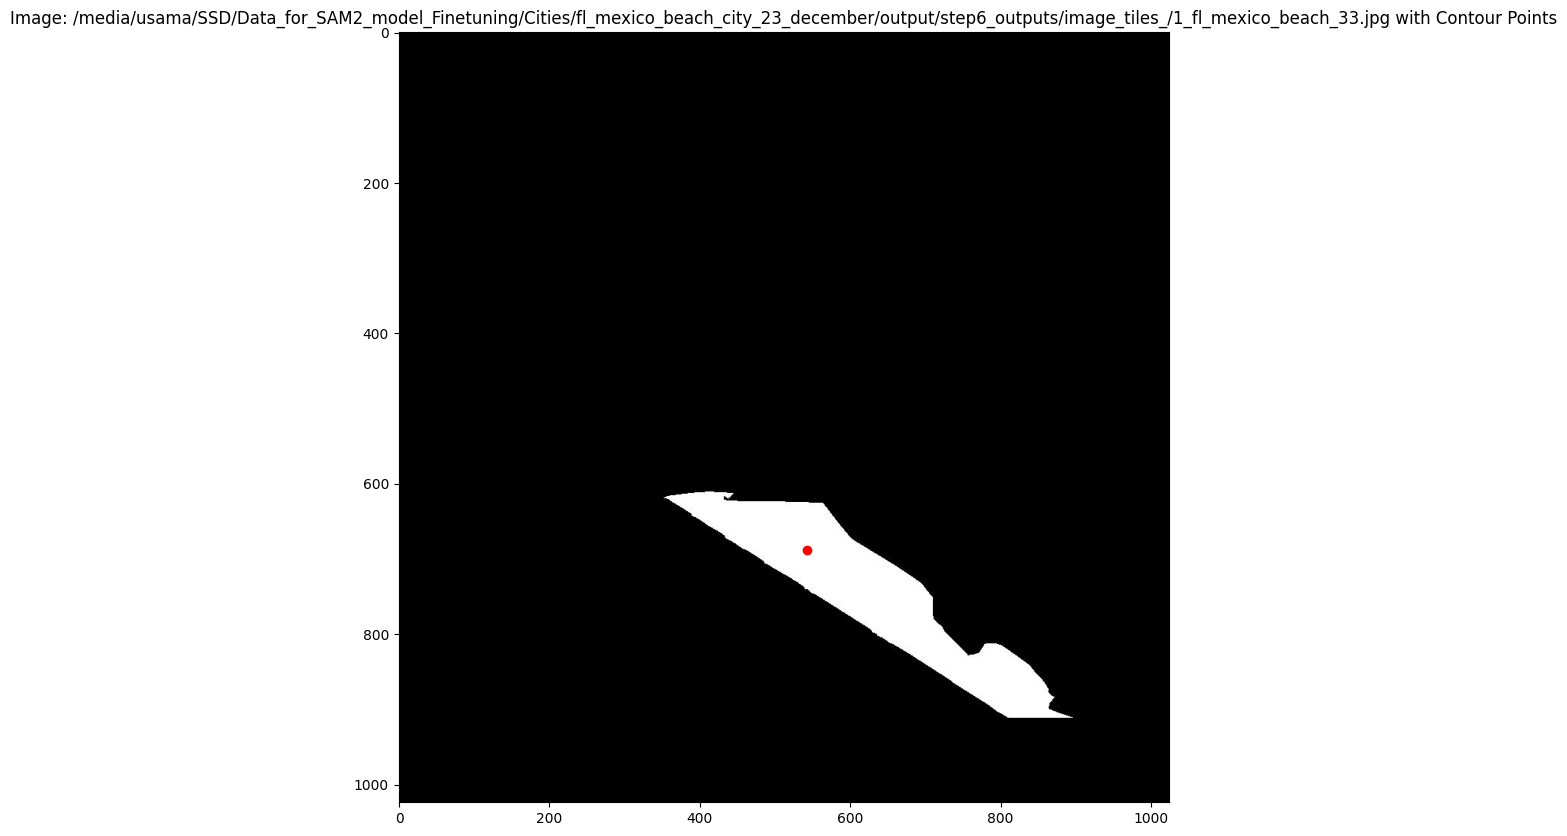

scale 1.0
points [[(856.0, 127.5), (887.25, 131.0), (866.75, 141.0), (895.75, 152.5)]]
copy image path test_data_sam2_24_22_december/images/1_fl_mexico_beach_47_copy0.jpg
point pairs [(856, 127)]


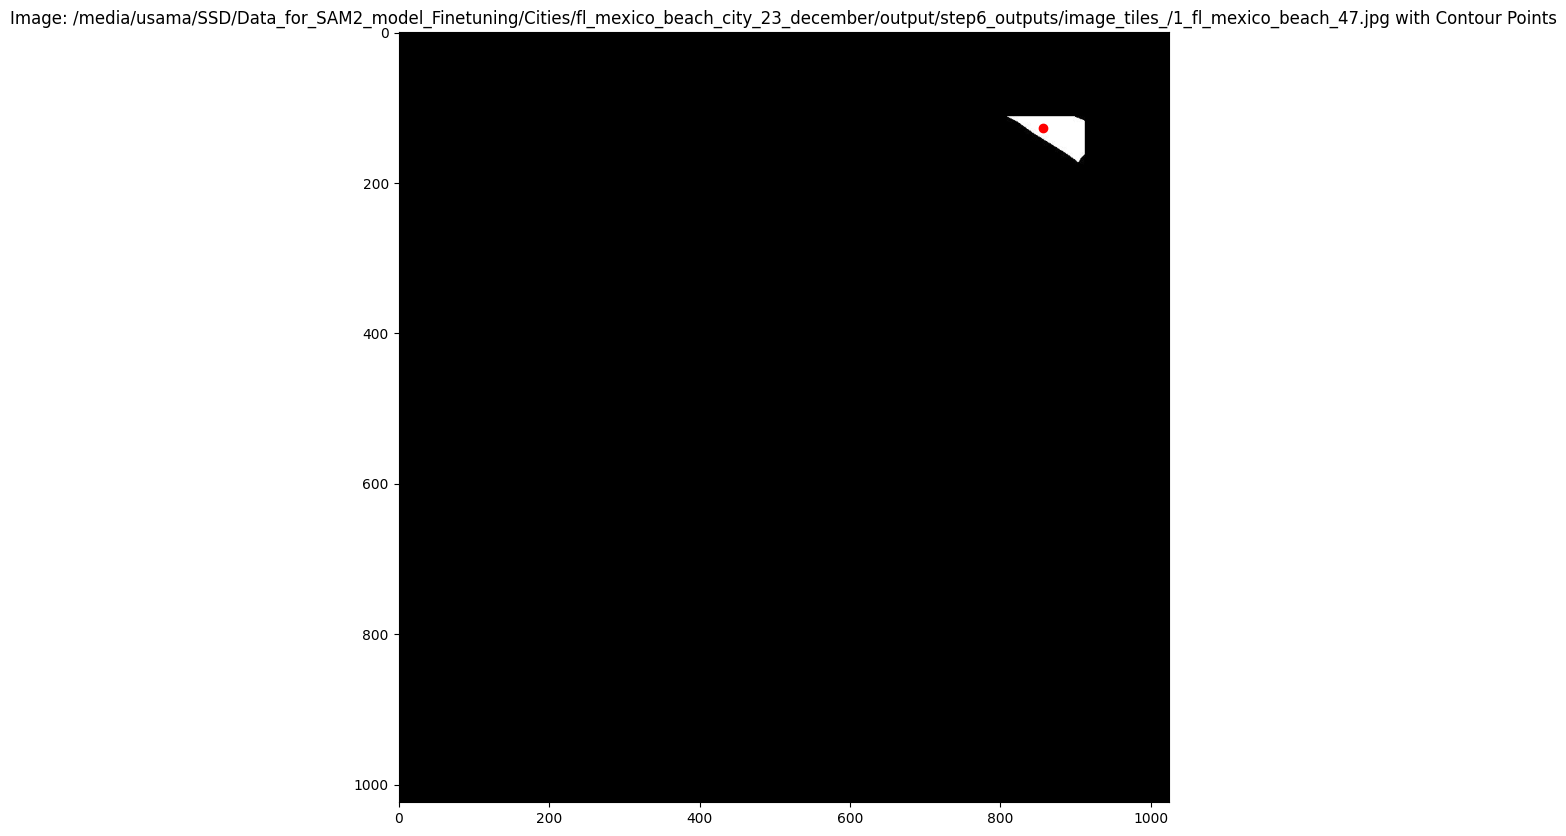

scale 1.0
representative point after area is less than 200 [[(709.875, 560.25), (719.5, 564.5), (715.375, 569.25), (728.0, 576.0)], [(771.0, 545.5), (793.0, 556.0), (783.0, 583.0), (805.5, 592.5)], [(676.5, 493.0), (713.75, 496.5), (681.25, 511.5), (716.0, 514.5)], [(826.75, 479.5), (860.25, 482.5), (832.0, 542.5), (855.25, 539.5)], [(730.25, 410.5), (803.0, 396.5), (725.75, 455.0), (777.75, 450.0)], [(260.0, 219.0), (307.5, 215.0), (260.5, 257.5), (288.25, 257.5)], [(409.5, 271.5), (512.5, 237.5), (453.5, 372.5), (570.5, 427.5)], [(150.75, 159.5), (178.0, 168.5), (157.25, 194.5), (190.5, 204.0)], [(119.0, 133.5)]]
points [[(709.875, 560.25), (719.5, 564.5), (715.375, 569.25), (728.0, 576.0)], [(771.0, 545.5), (793.0, 556.0), (783.0, 583.0), (805.5, 592.5)], [(676.5, 493.0), (713.75, 496.5), (681.25, 511.5), (716.0, 514.5)], [(826.75, 479.5), (860.25, 482.5), (832.0, 542.5), (855.25, 539.5)], [(730.25, 410.5), (803.0, 396.5), (725.75, 455.0), (777.75, 450.0)], [(260.0, 219.0), (307.5, 

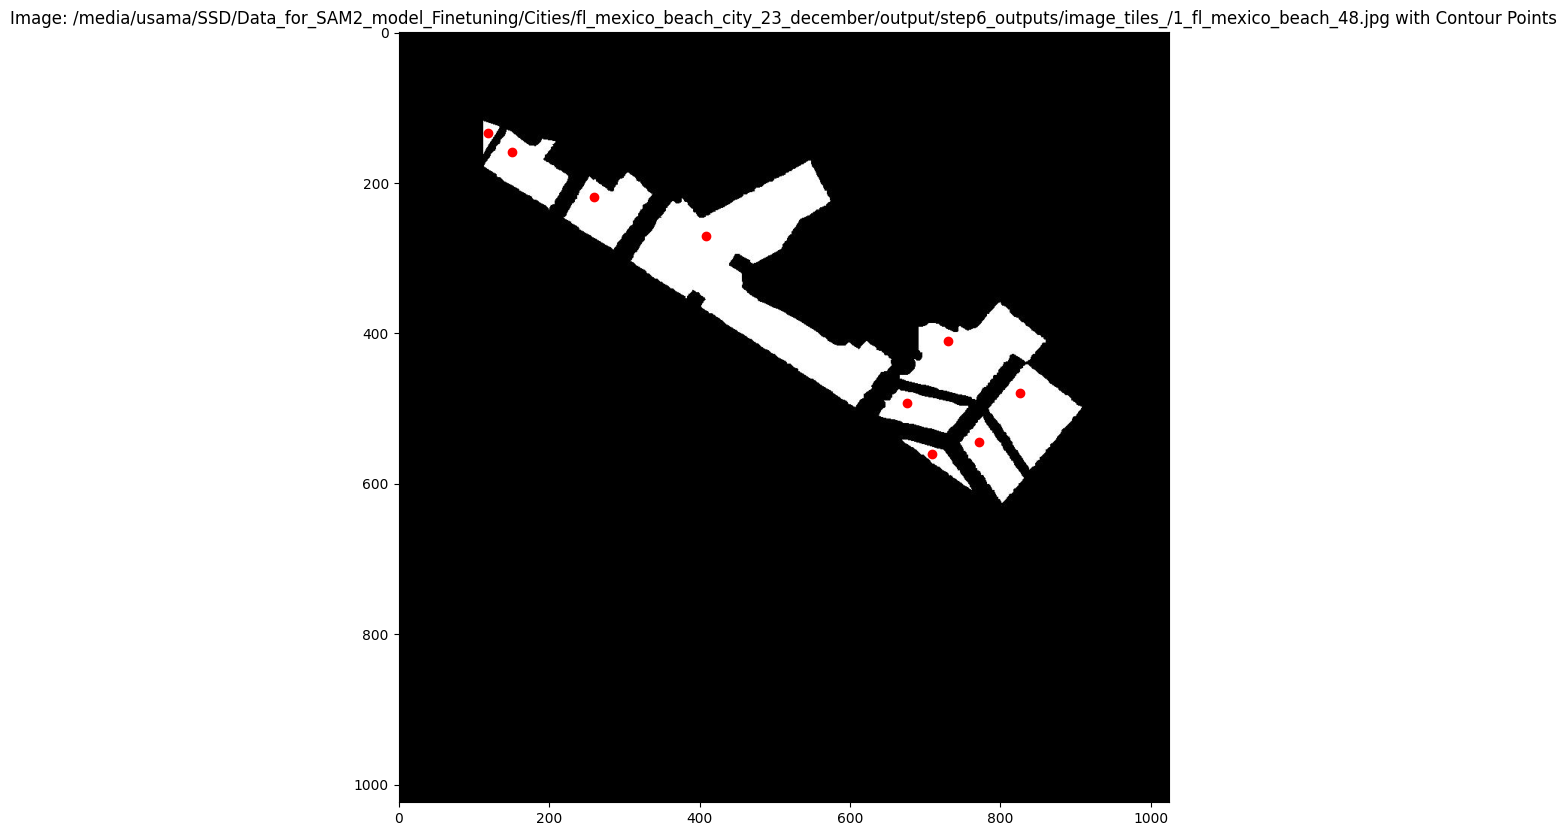

scale 1.0
points [[(728.0, 518.5), (761.25, 523.5), (727.5, 571.0), (769.0, 577.0)], [(549.25, 395.5), (575.5, 385.5), (533.5, 434.0), (559.0, 424.5)], [(695.25, 227.0), (799.75, 226.0), (692.75, 341.0), (761.25, 321.5)]]
copy image path test_data_sam2_24_22_december/images/1_fl_mexico_beach_63_copy0.jpg
point pairs [(728, 518), (549, 395), (695, 227)]


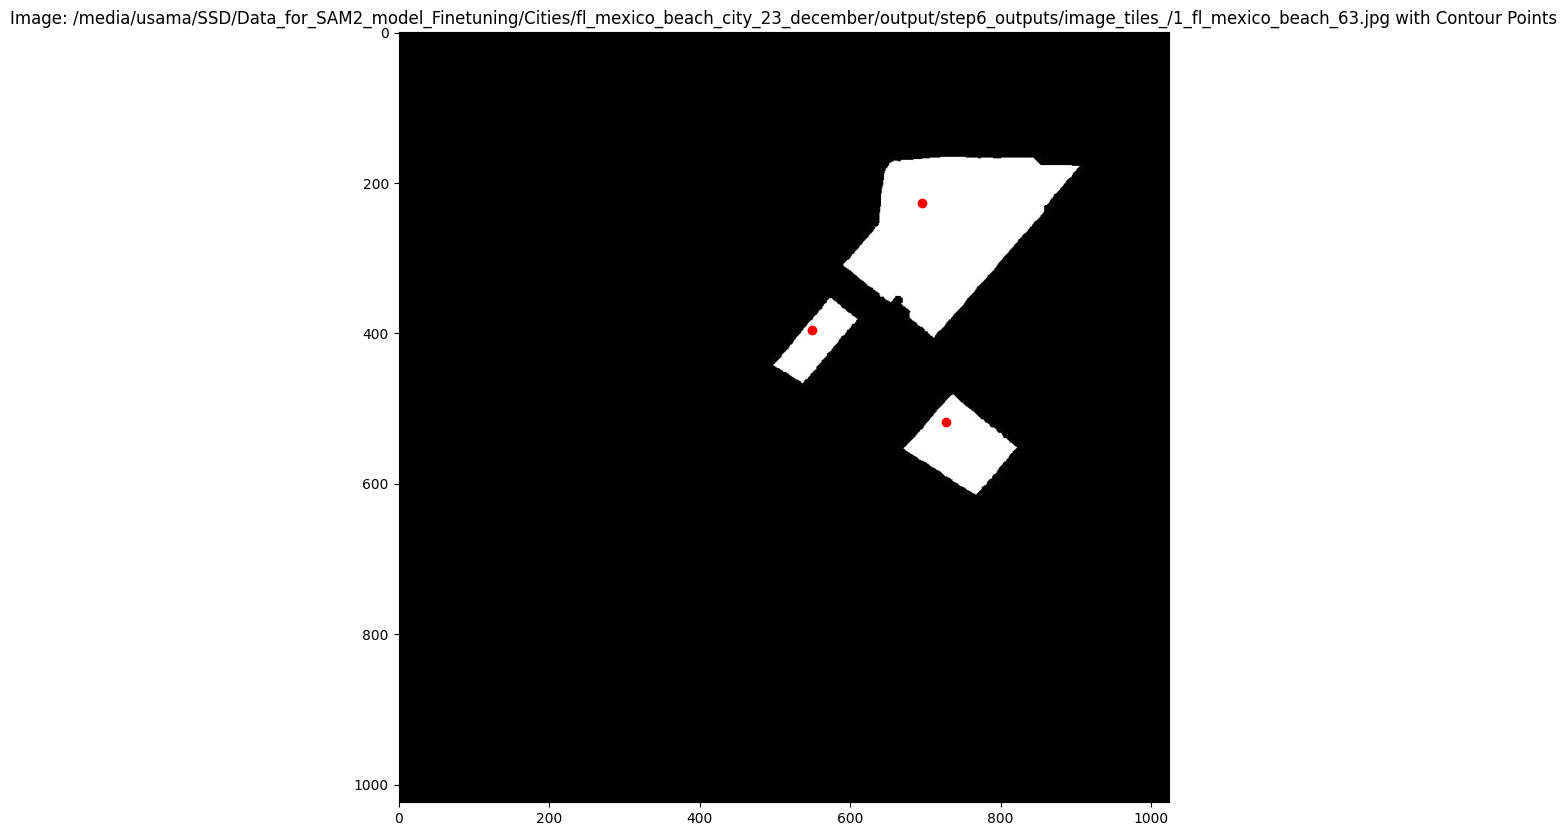

scale 1.0
representative point after area is less than 200 [[(689.0, 890.0)]]
points [[(689.0, 890.0)], [(333.0, 824.0), (390.0, 848.0), (373.5, 875.0), (412.25, 882.5)], [(764.0, 795.5), (777.0, 780.5), (744.5, 822.0), (765.875, 801.75)], [(333.25, 718.5), (559.75, 751.5), (482.75, 828.5), (591.0, 846.5)]]
copy image path test_data_sam2_24_22_december/images/1_fl_mexico_beach_64_copy0.jpg
point pairs [(689, 890), (333, 824), (764, 795), (333, 718)]


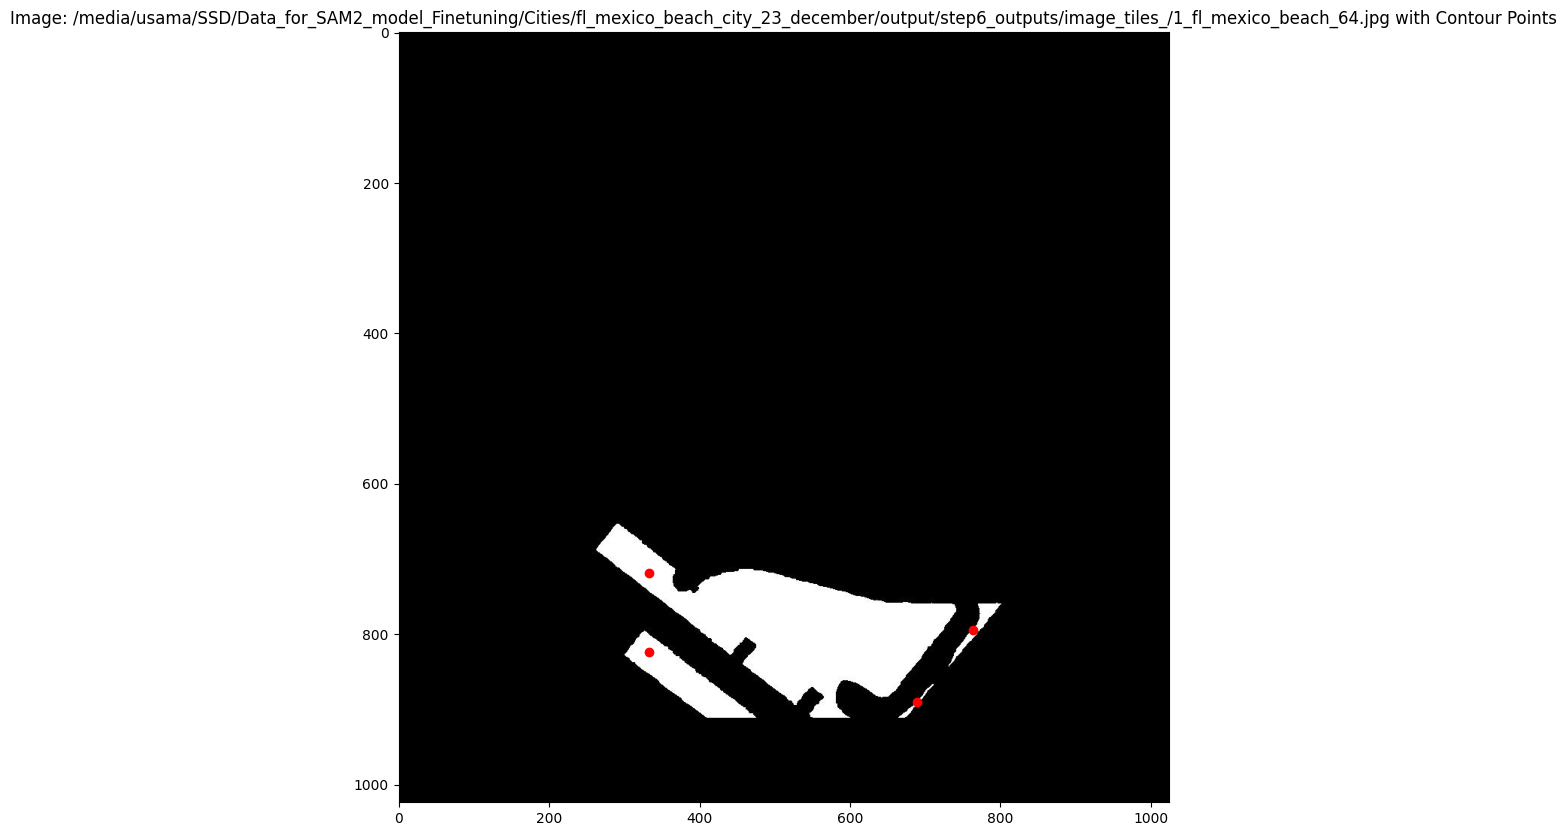

scale 1.0
points [[(340.75, 277.5), (717.75, 282.75), (344.75, 572.0), (717.75, 567.25)]]
copy image path test_data_sam2_24_22_december/images/1_fl_mexico_beach_66_copy0.jpg
point pairs [(340, 277)]


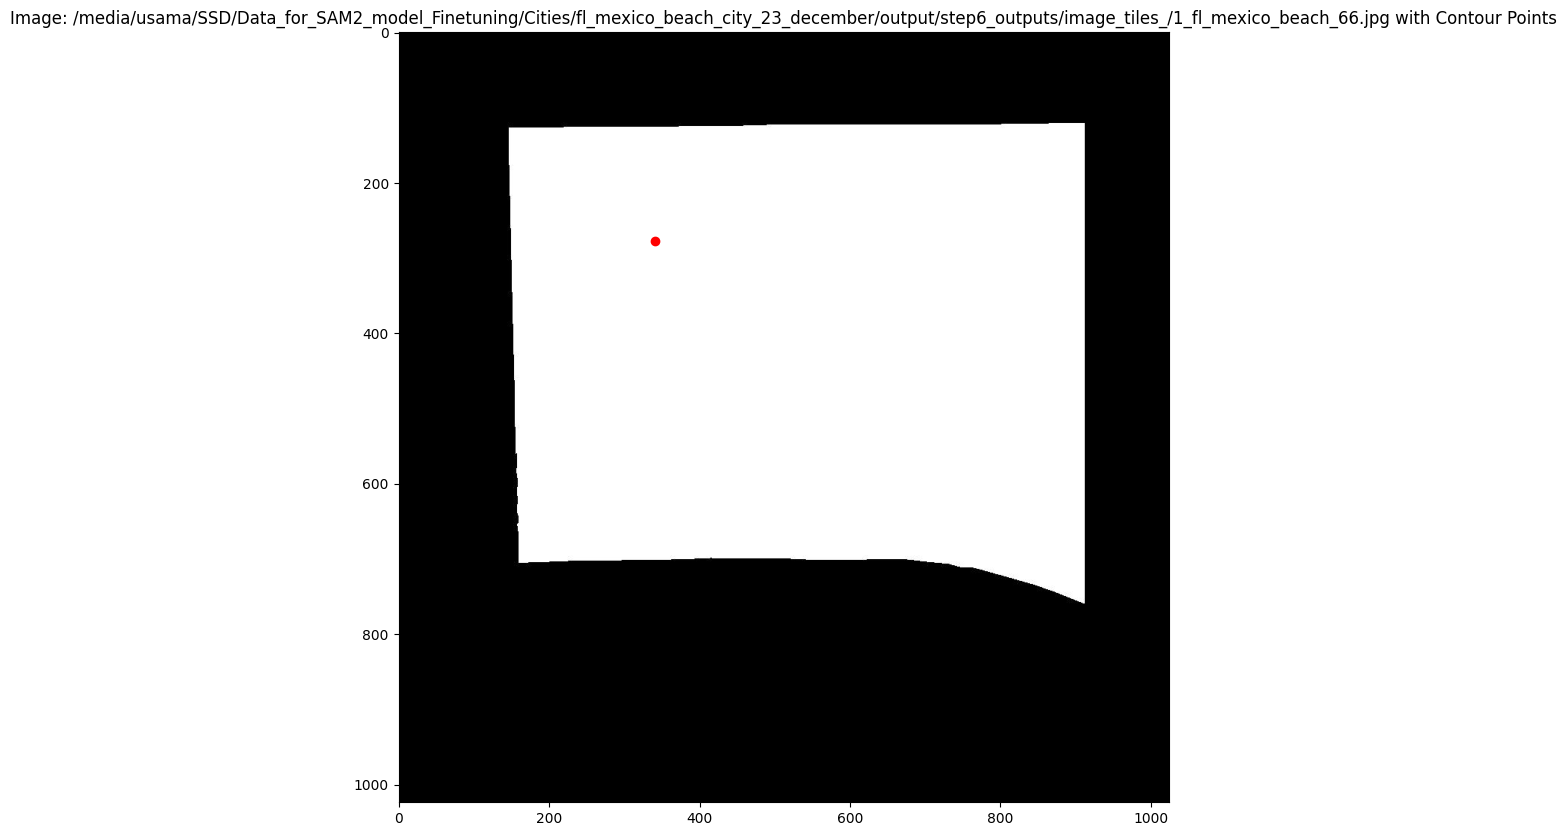

scale 1.0
points [[(190.5, 299.75), (338.0, 256.0), (179.5, 651.5), (339.0, 520.5)]]
copy image path test_data_sam2_24_22_december/images/1_fl_mexico_beach_67_copy0.jpg
point pairs [(190, 299)]


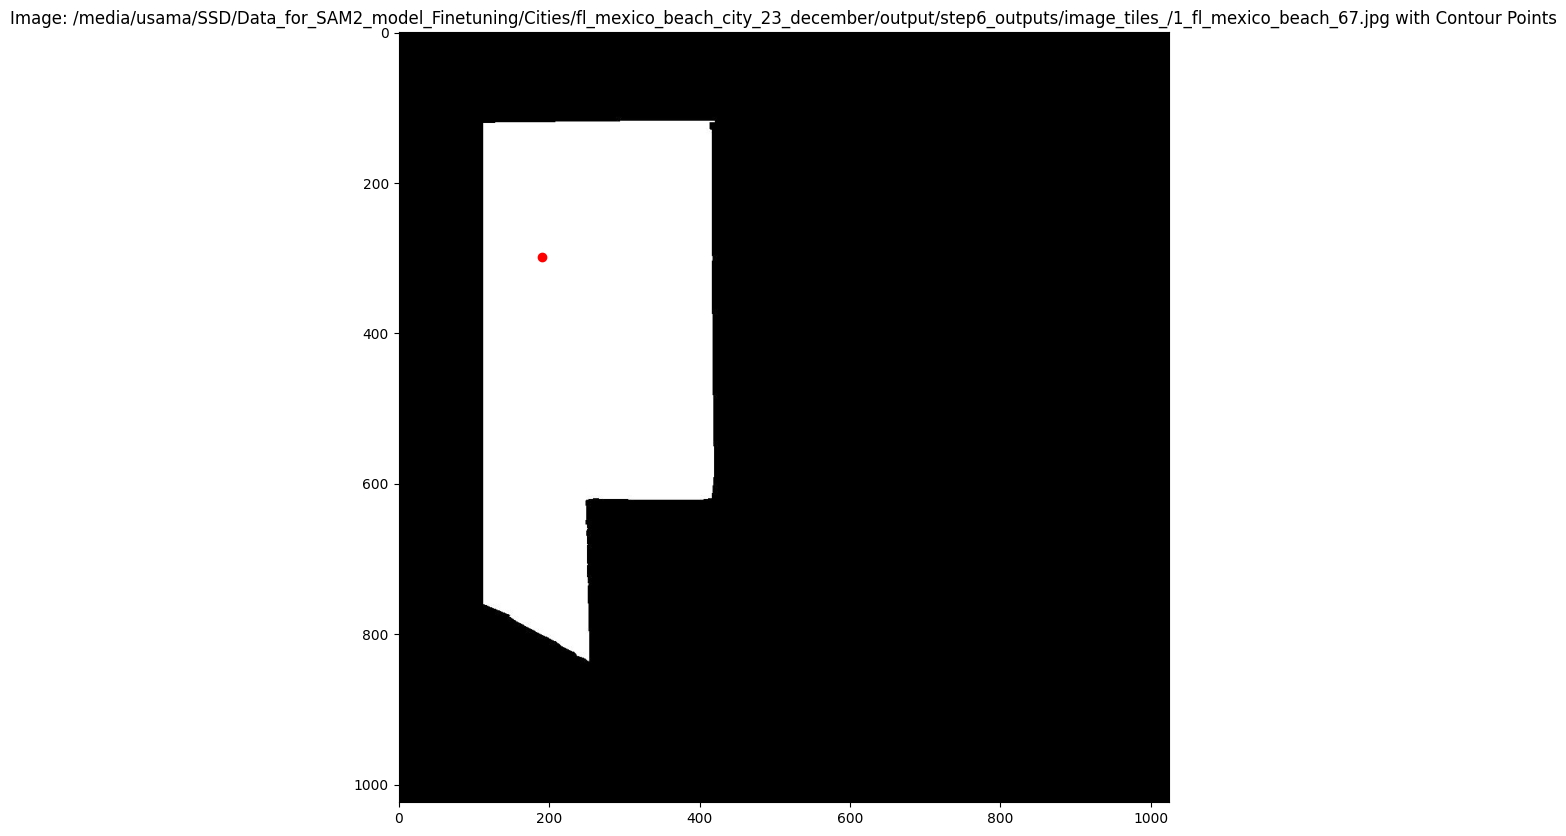

scale 1.0
points [[(880.5, 334.0), (896.0, 334.0), (878.0, 354.5), (896.0, 354.5)], [(800.0, 286.5), (819.75, 294.0), (813.0, 307.5), (833.25, 314.5)], [(654.5, 270.25), (678.5, 279.5), (667.5, 296.5), (691.5, 304.5)], [(702.5, 209.5), (758.5, 209.5), (723.0, 230.5), (741.75, 238.0)], [(603.75, 134.0), (631.25, 137.0), (617.0, 154.5), (651.5, 170.5)], [(503.5, 159.0), (539.25, 178.5), (511.0, 225.5), (569.75, 243.5)]]
copy image path test_data_sam2_24_22_december/images/1_fl_mexico_beach_78_copy0.jpg
point pairs [(880, 334), (800, 286), (654, 270), (702, 209), (603, 134), (503, 159)]


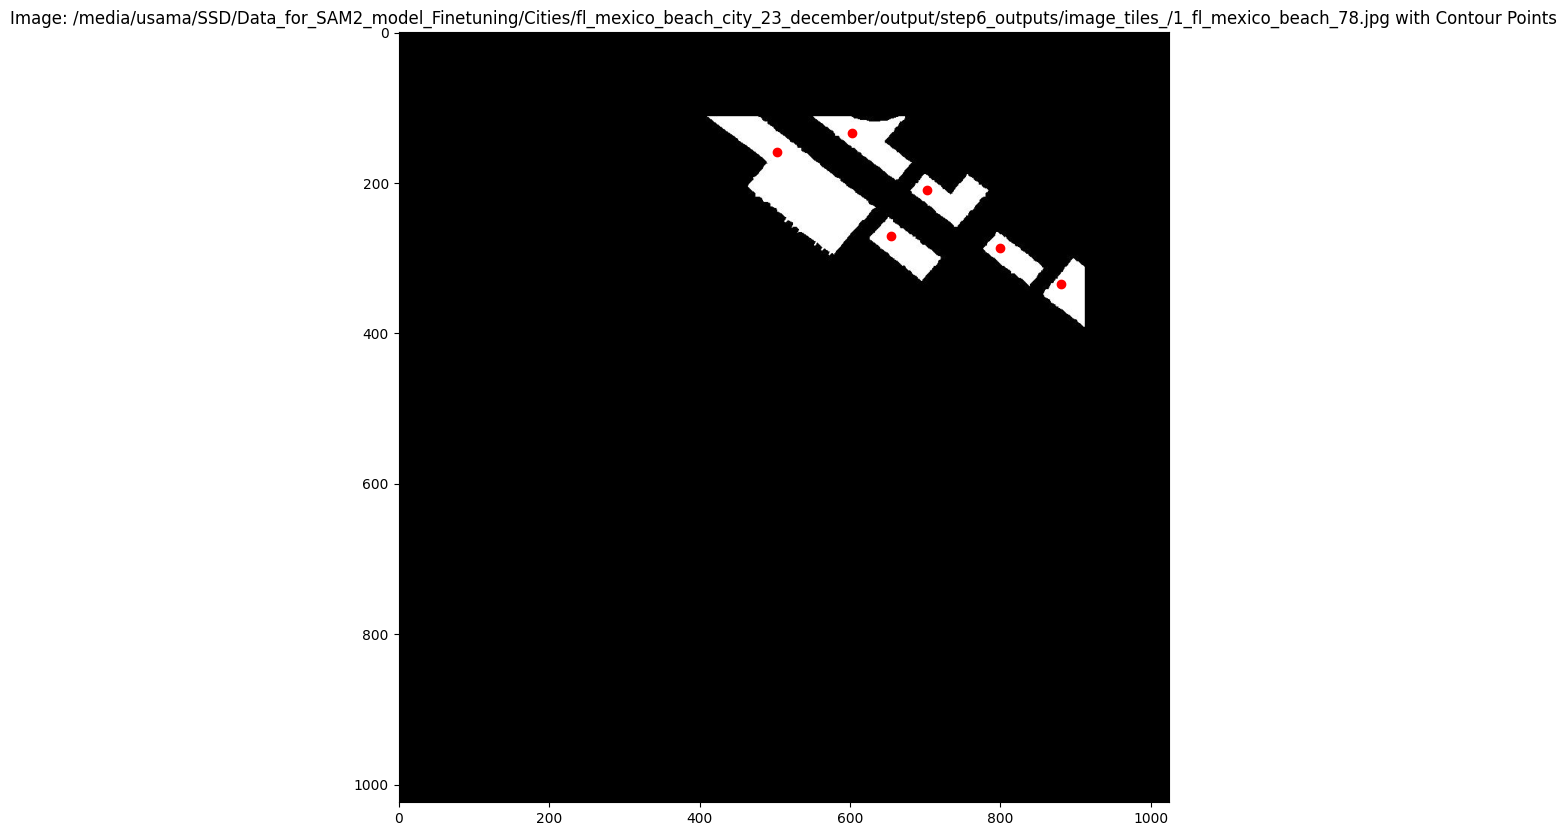

scale 1.0
points [[(770.5, 861.5), (790.0, 868.5), (760.75, 891.0), (802.5, 891.5)], [(668.25, 768.5), (700.75, 779.5), (676.25, 822.5), (713.5, 831.0)], [(533.0, 697.5), (563.25, 709.5), (552.75, 724.5), (585.0, 739.5)], [(438.75, 622.5), (463.5, 631.0), (455.75, 645.5), (479.5, 654.5)], [(350.75, 552.5), (374.75, 561.5), (366.75, 577.5), (389.0, 584.5)], [(313.25, 485.0), (334.0, 479.5), (301.5, 513.5), (321.25, 507.5)], [(230.75, 417.0), (257.75, 418.0), (228.0, 463.5), (255.0, 465.5)], [(131.5, 347.0), (185.0, 360.0), (143.25, 395.5), (170.5, 395.0)], [(240.0, 151.5), (271.5, 151.5), (230.5, 207.5), (259.25, 206.0)]]
copy image path test_data_sam2_24_22_december/images/1_fl_mexico_beach_79_copy0.jpg
point pairs [(770, 861), (668, 768), (533, 697), (438, 622), (350, 552), (313, 485), (230, 417), (131, 347), (240, 151)]


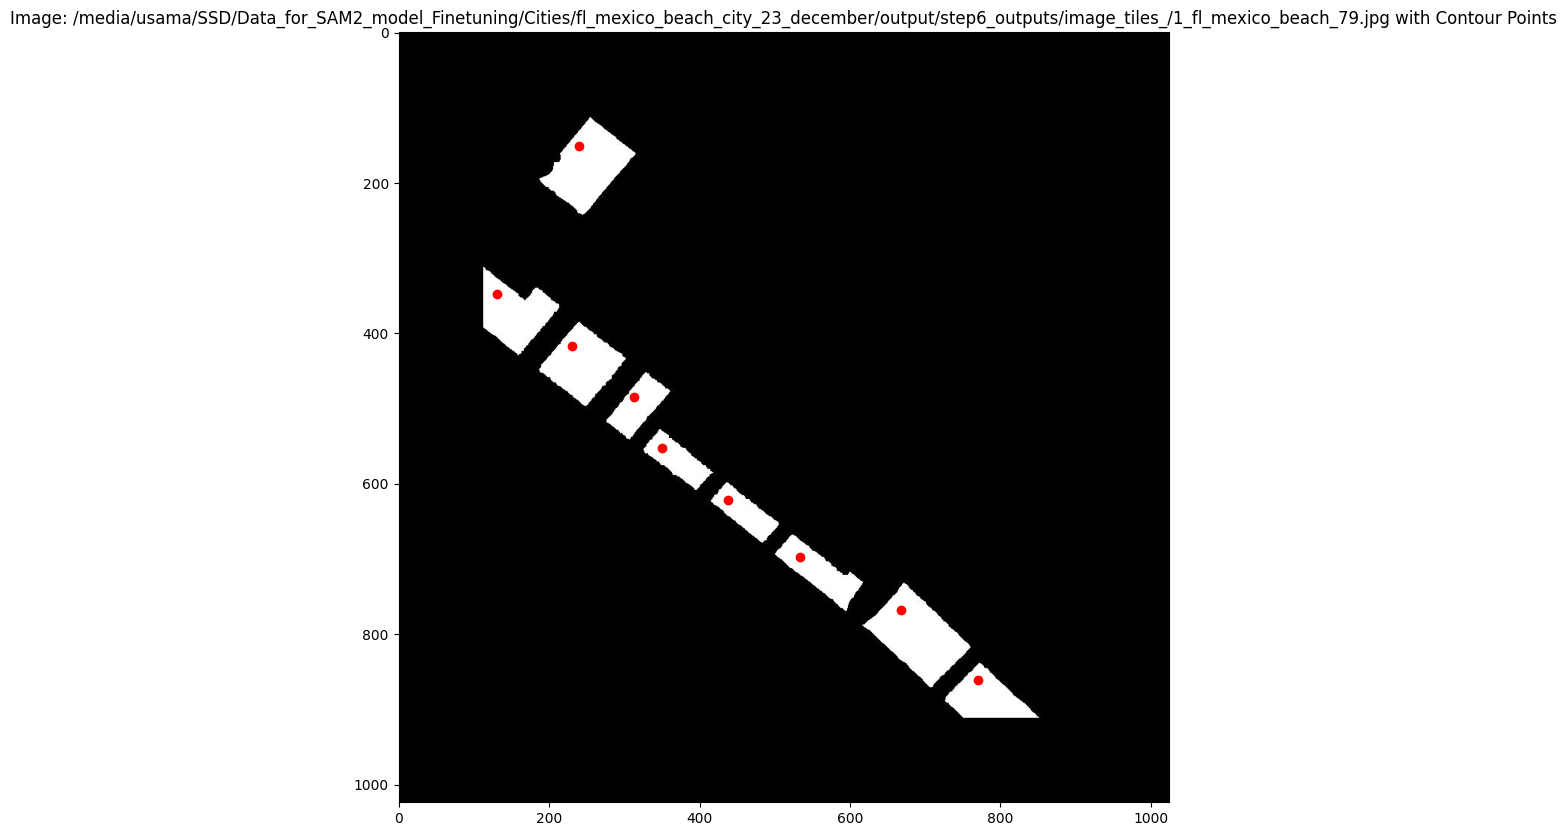

scale 1.0
points [[(757.25, 295.5), (857.0, 296.75), (758.5, 355.5), (857.0, 352.25)], [(549.5, 265.0), (669.75, 304.5), (549.25, 390.0), (676.5, 399.5)]]
copy image path test_data_sam2_24_22_december/images/1_fl_mexico_beach_81_copy0.jpg
point pairs [(757, 295), (549, 265)]


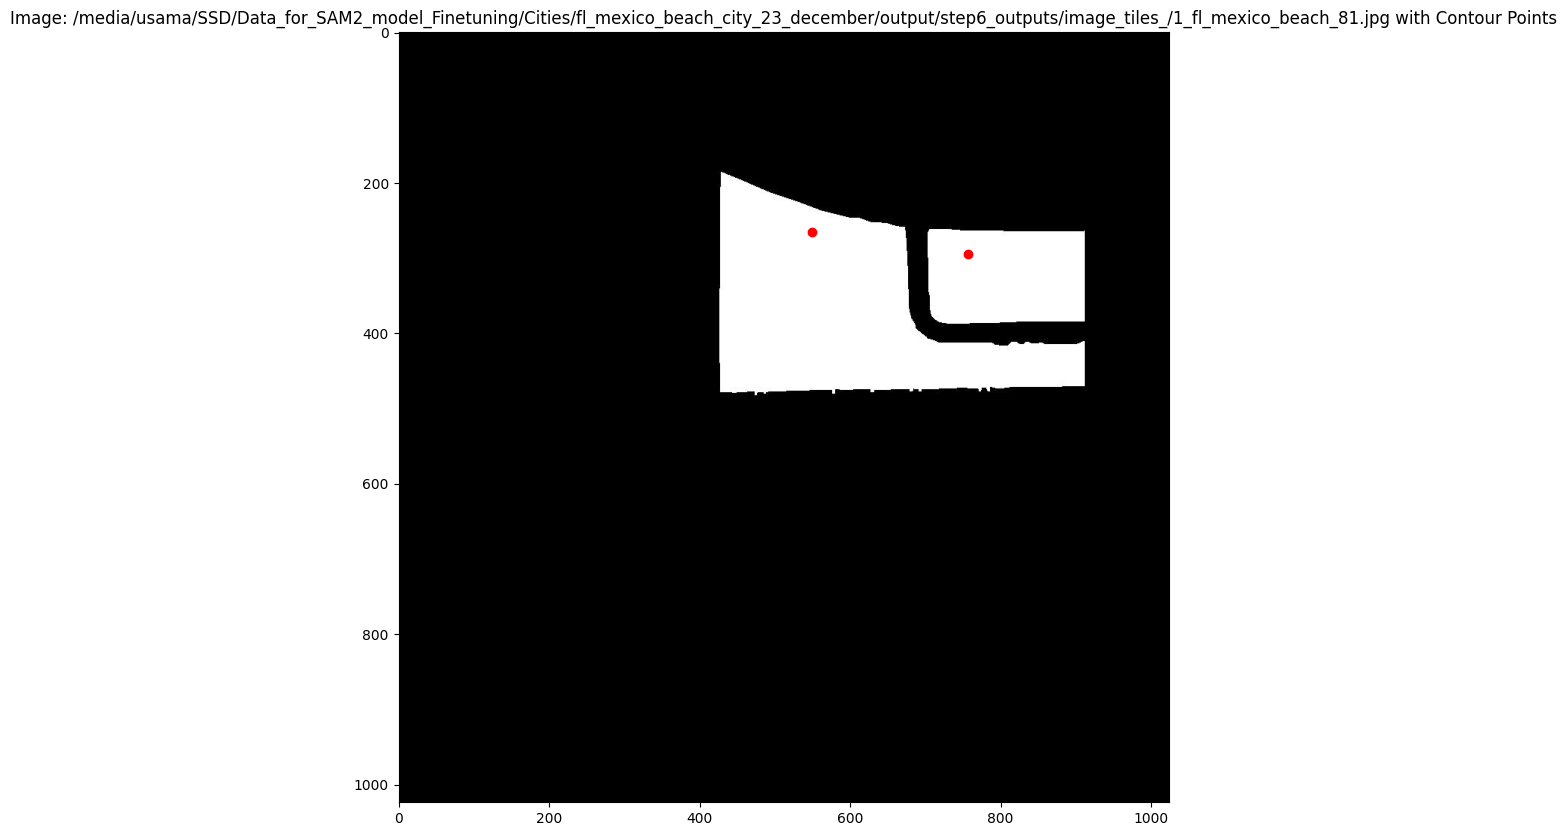

scale 1.0
points [[(138.5, 429.5), (183.5, 427.0), (138.5, 452.5), (183.5, 451.0)], [(138.25, 295.75), (182.25, 298.0), (138.25, 350.75), (182.75, 363.0)]]
copy image path test_data_sam2_24_22_december/images/1_fl_mexico_beach_82_copy0.jpg
point pairs [(138, 429), (138, 295)]


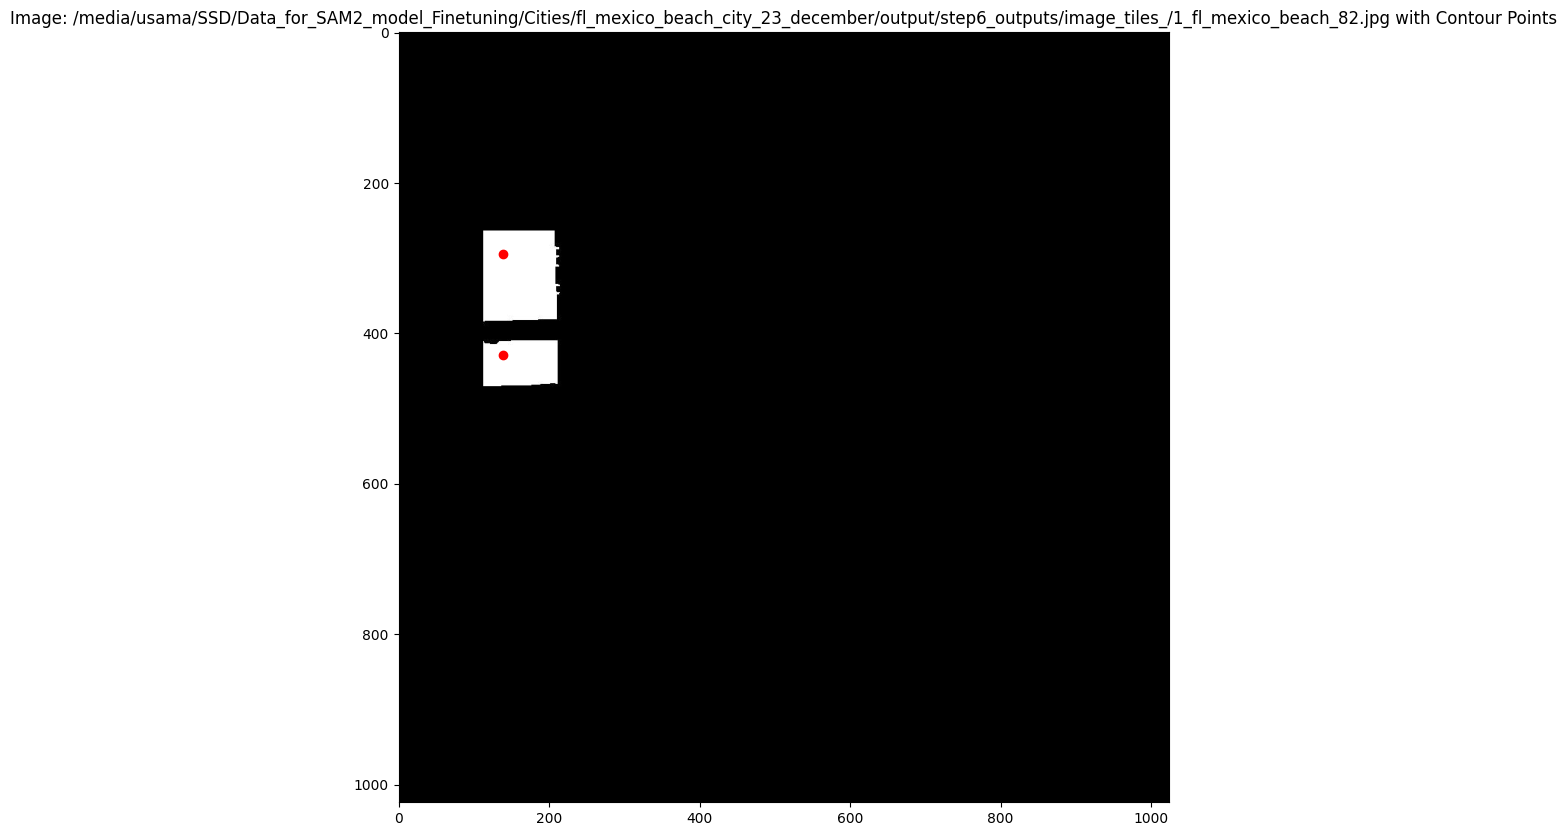

scale 1.0
points [[(817.25, 146.5), (858.5, 147.0), (835.875, 179.75), (888.0, 211.0)]]
copy image path test_data_sam2_24_22_december/images/1_fl_mexico_beach_93_copy0.jpg
point pairs [(817, 146)]


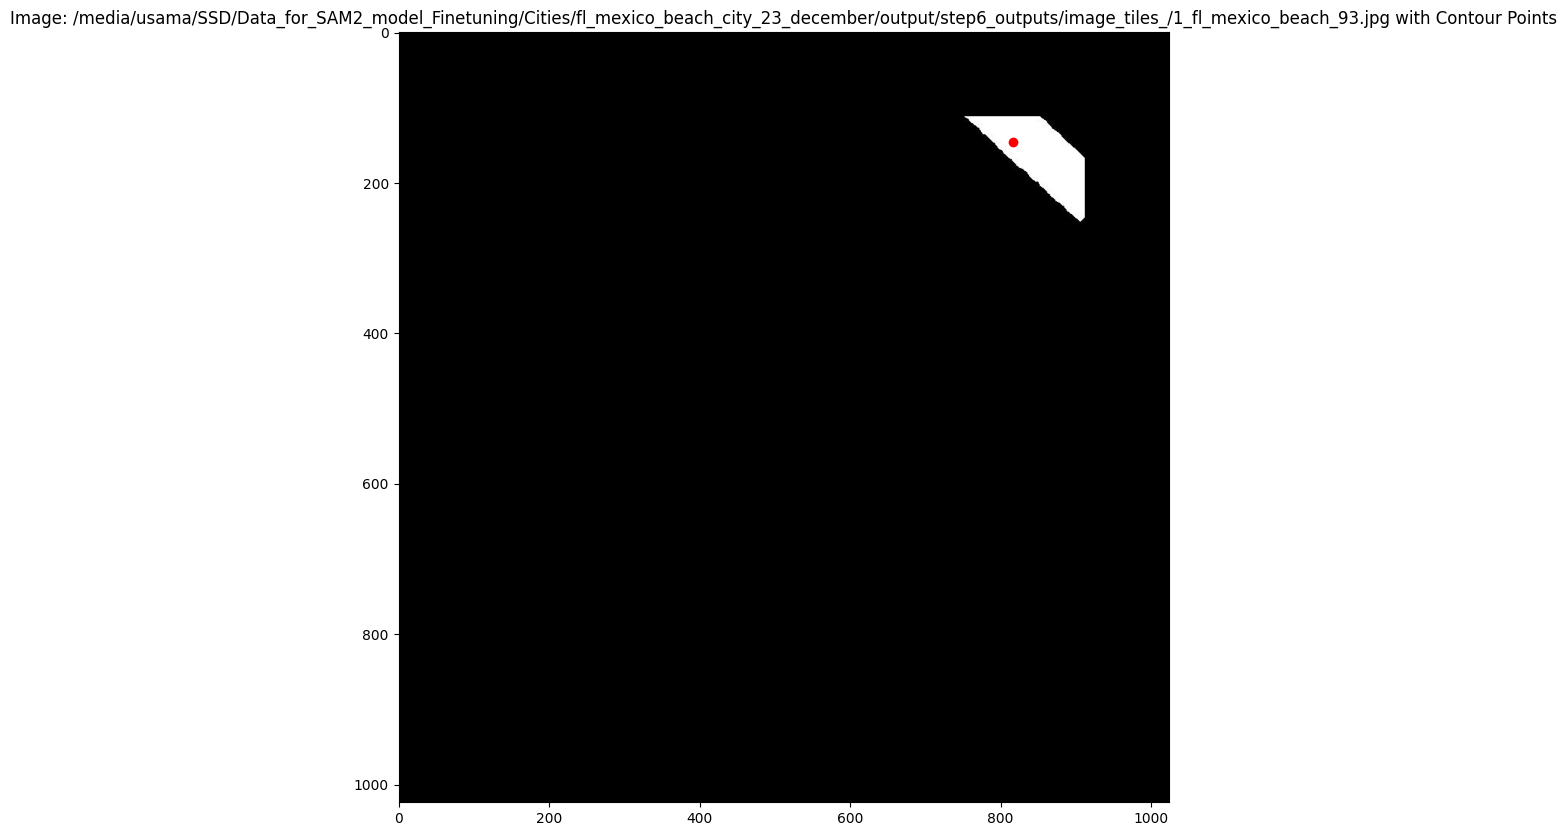

scale 1.0
points [[(122.0, 197.25), (131.0, 195.0), (122.0, 213.25), (133.0, 213.0)]]
copy image path test_data_sam2_24_22_december/images/1_fl_mexico_beach_94_copy0.jpg
point pairs [(122, 197)]


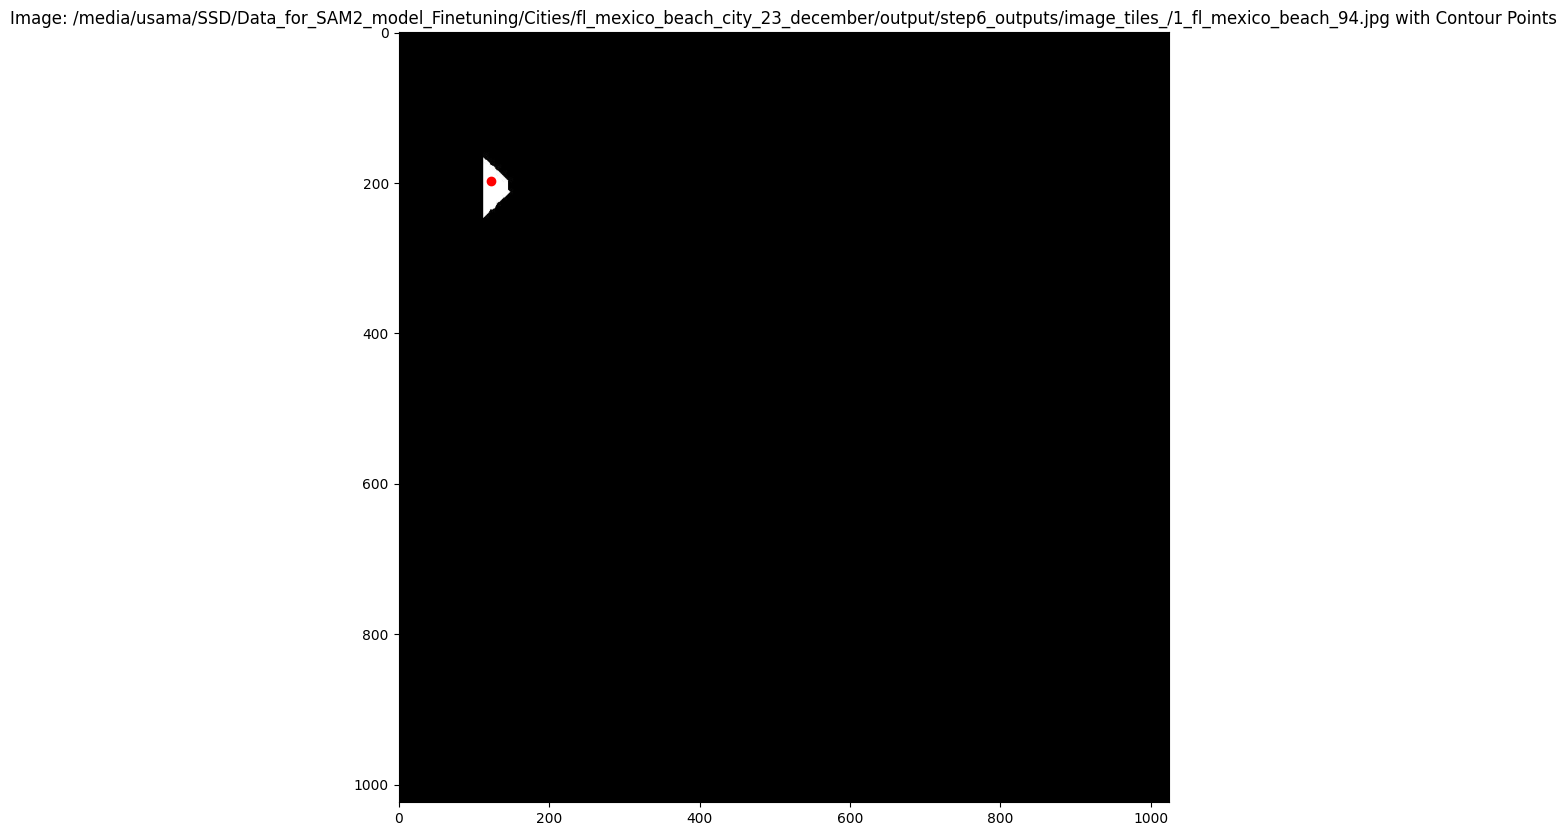

scale 1.0
points [[(676.5, 592.5), (701.5, 592.25), (673.5, 611.0), (701.5, 608.25)]]
copy image path test_data_sam2_24_22_december/images/2_fl_mexico_beach_32_copy0.jpg
point pairs [(676, 592)]


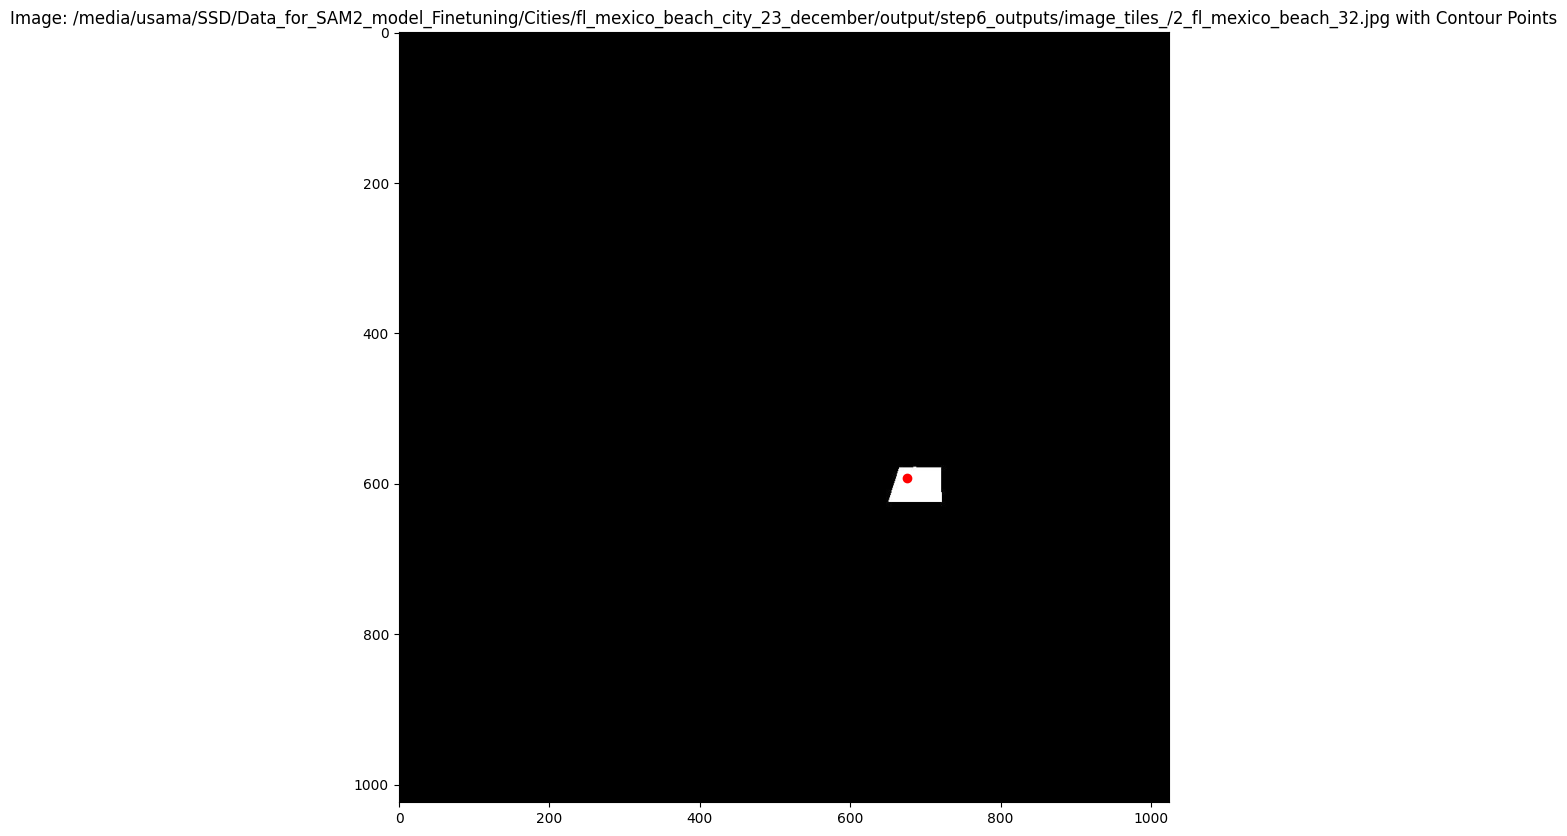

scale 1.0
points [[(187.0, 592.75), (214.0, 592.0), (187.0, 606.75), (225.0, 606.0)]]
copy image path test_data_sam2_24_22_december/images/2_fl_mexico_beach_33_copy0.jpg
point pairs [(187, 592)]


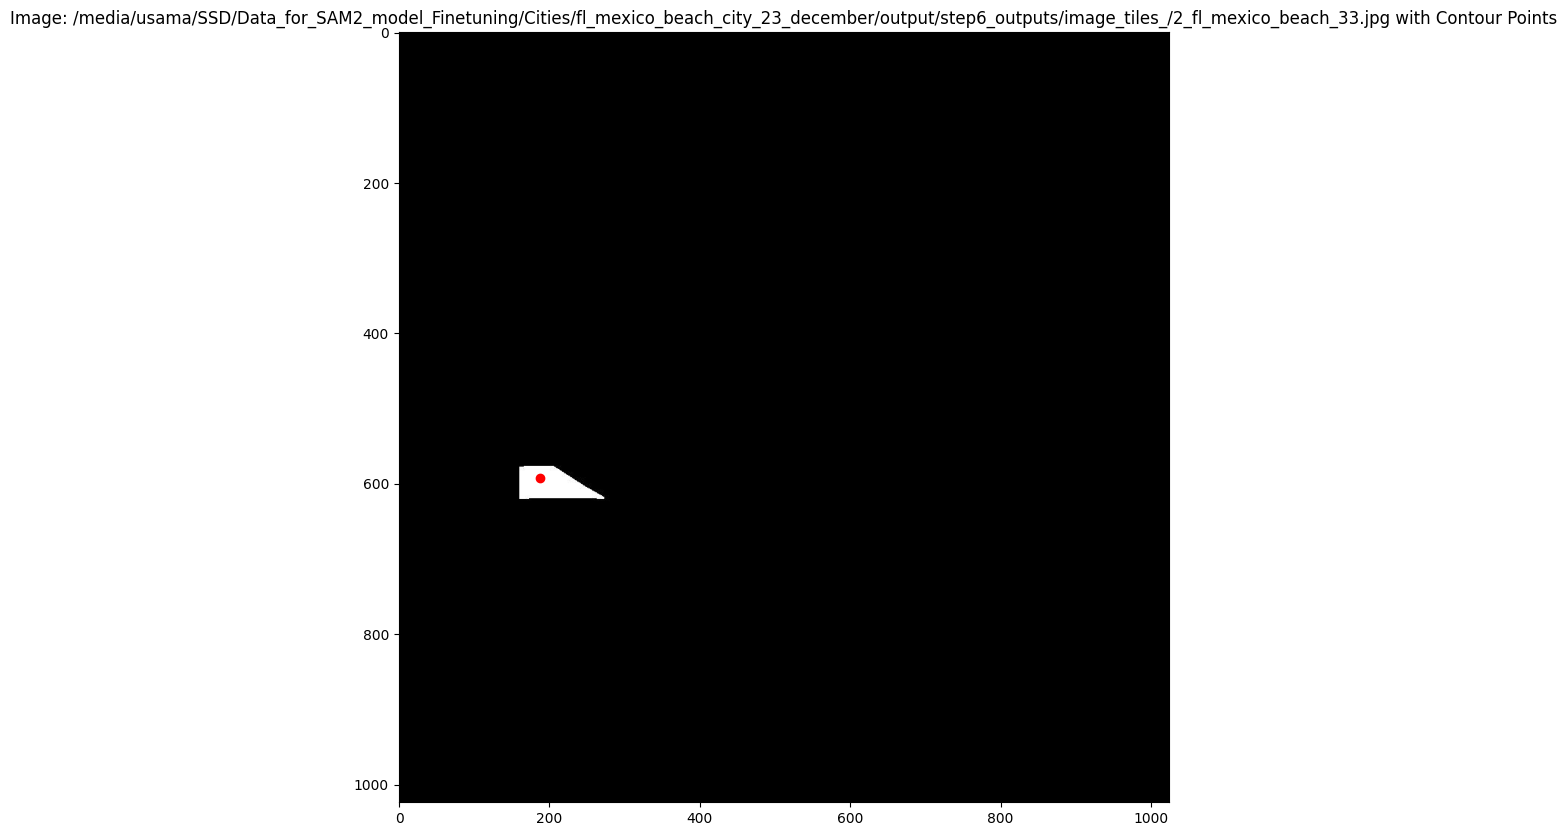

scale 1.0
representative point after area is less than 200 [[(699.0, 452.5)]]
points [[(699.0, 452.5)]]
copy image path test_data_sam2_24_22_december/images/2_fl_mexico_beach_47_copy0.jpg
point pairs [(699, 452)]


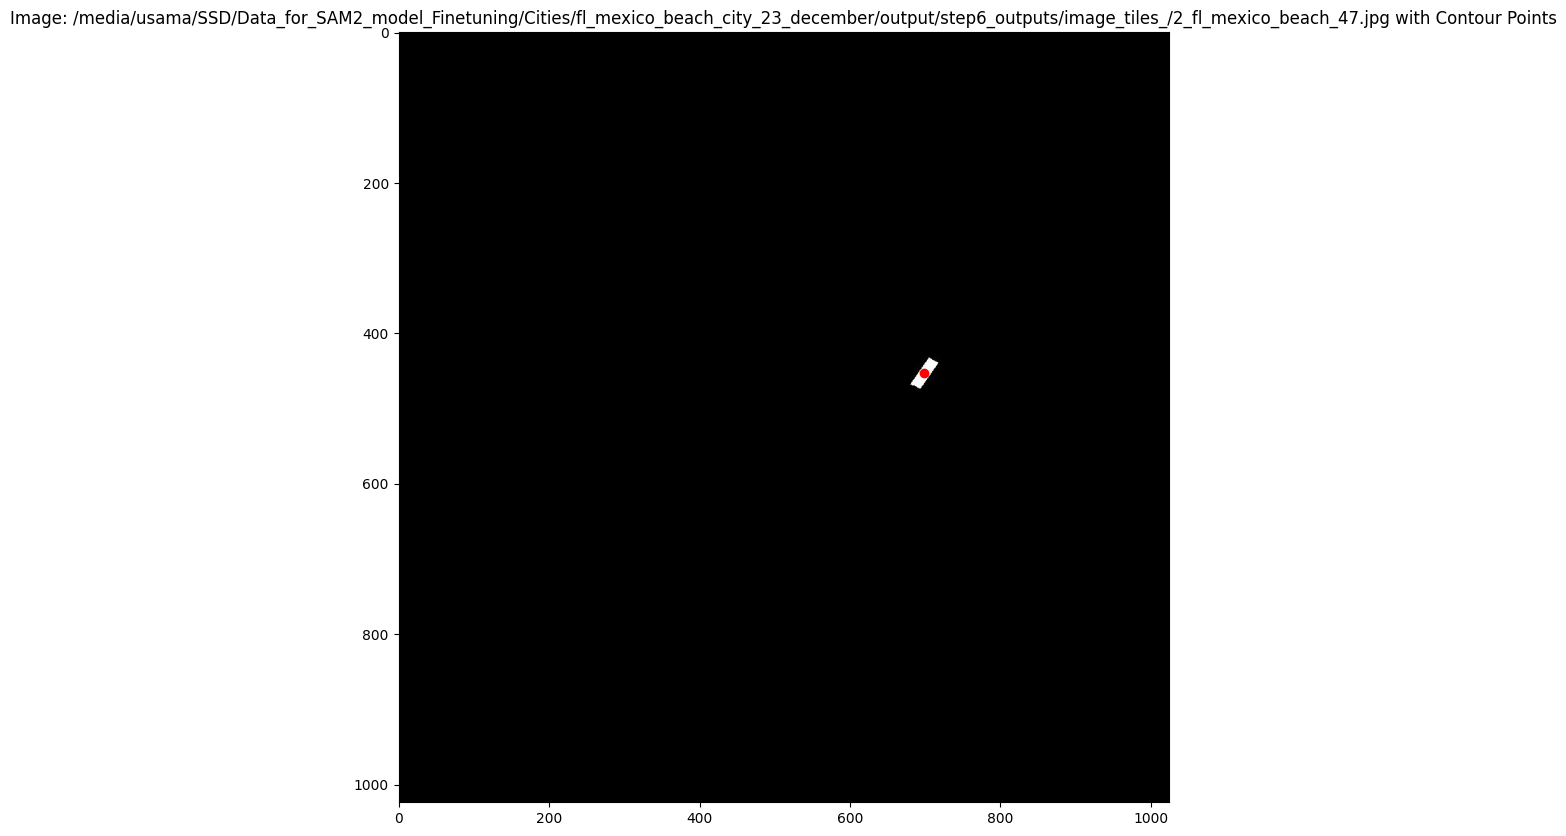

scale 1.0
points [[(219.0, 742.0), (259.25, 758.0), (242.25, 780.0), (285.0, 794.0)], [(224.0, 224.5), (358.25, 224.5), (282.75, 309.0), (334.5, 315.5)]]
copy image path test_data_sam2_24_22_december/images/2_fl_mexico_beach_64_copy0.jpg
point pairs [(219, 742), (224, 224)]


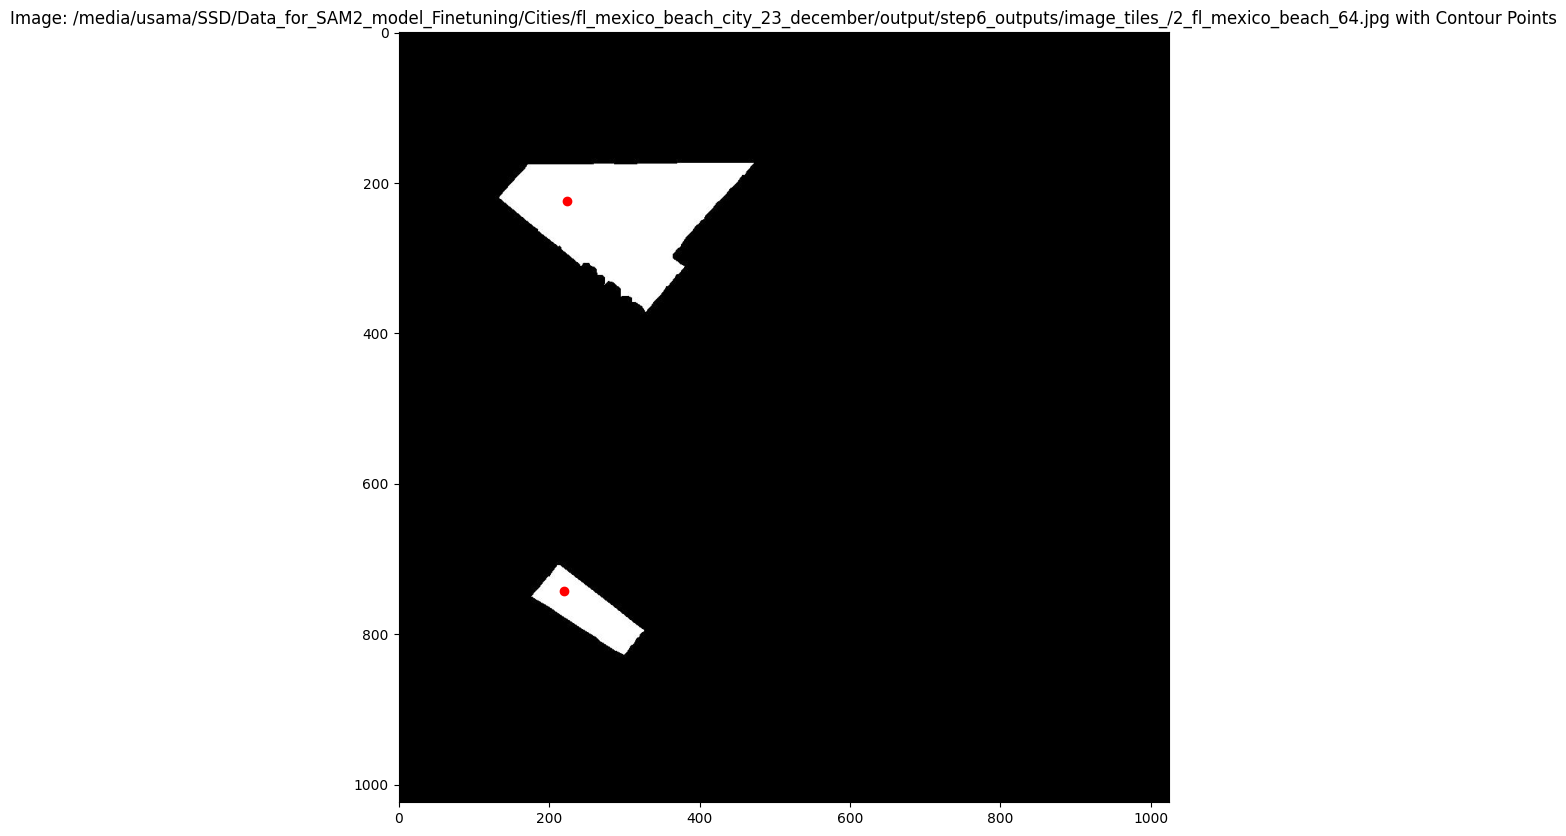

scale 1.0
points [[(737.0, 180.5), (803.0, 198.5), (877.0, 311.0)]]
copy image path test_data_sam2_24_22_december/images/3_fl_mexico_beach_108_copy0.jpg
point pairs [(737, 180)]


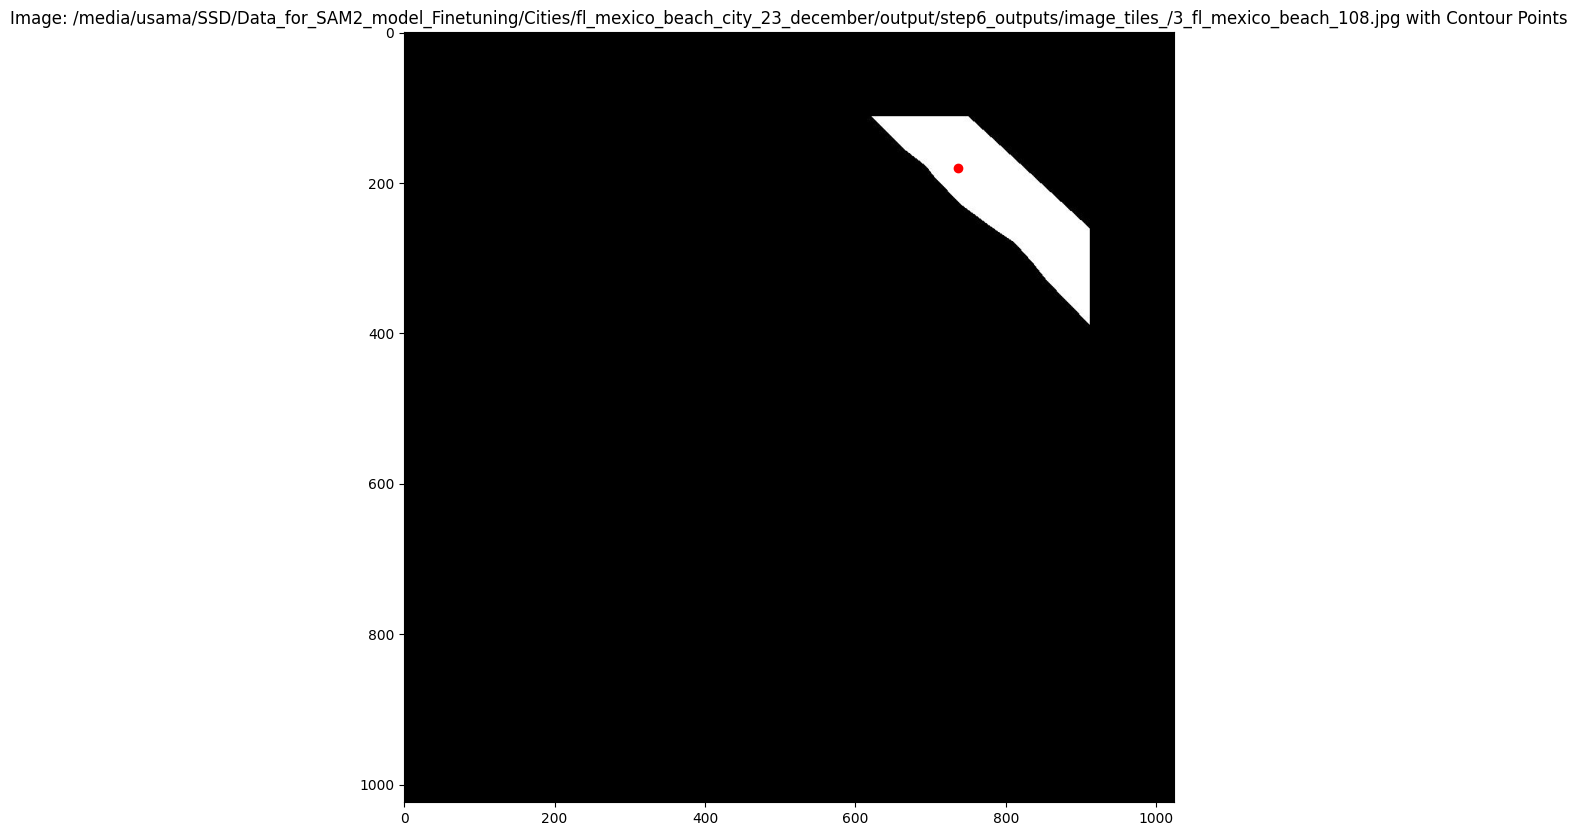

scale 1.0
points [[(222.0, 430.0), (442.5, 587.5), (416.75, 635.0), (577.5, 764.0)]]
copy image path test_data_sam2_24_22_december/images/3_fl_mexico_beach_109_copy0.jpg
point pairs [(222, 430)]


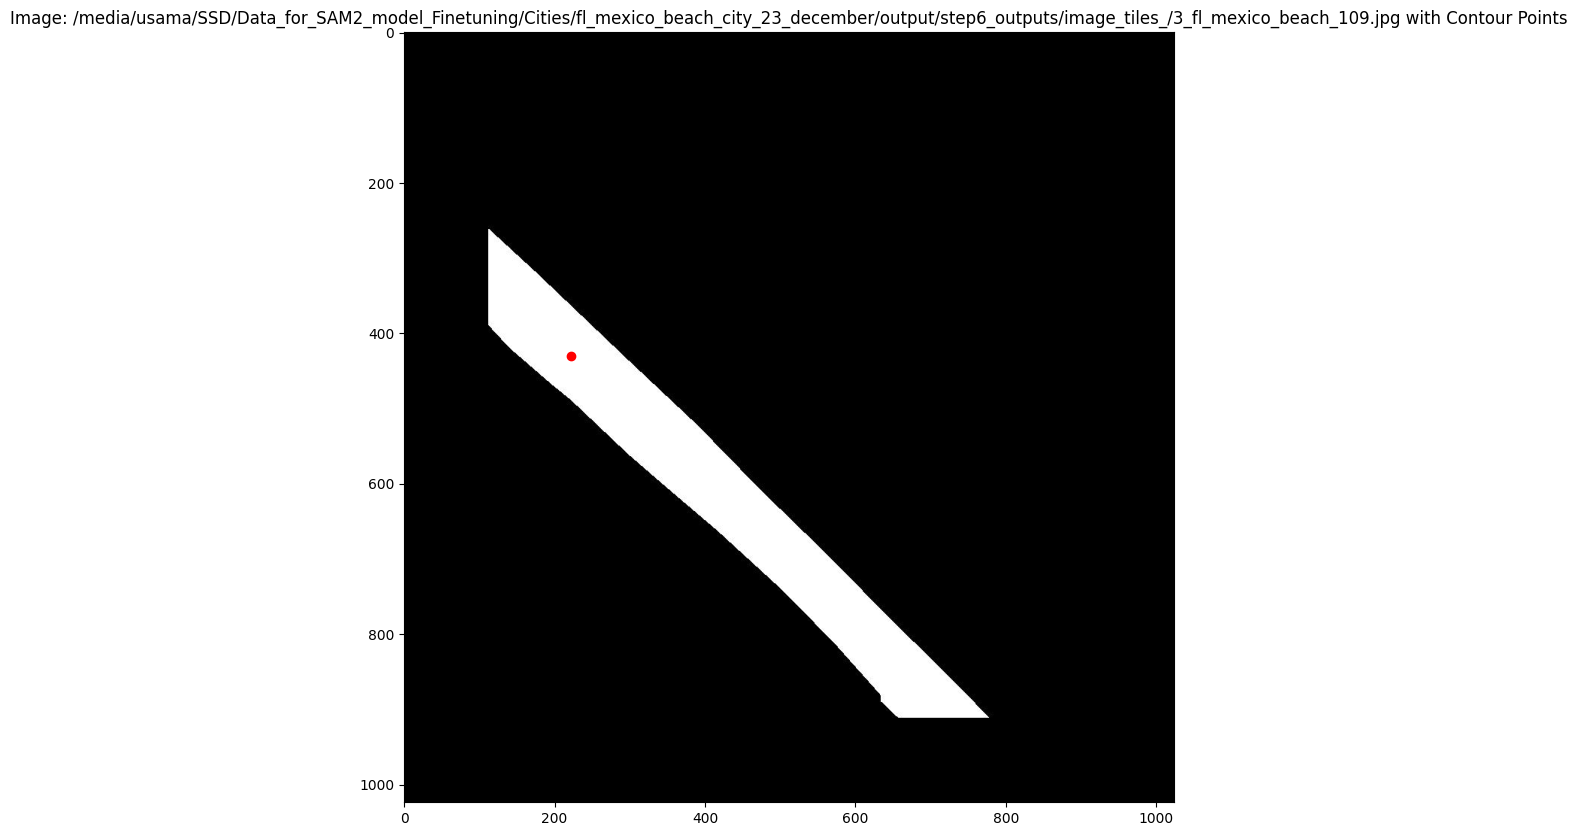

scale 1.0
points [[(757.5, 177.5), (819.25, 195.0), (786.875, 243.25), (874.75, 302.5)]]
copy image path test_data_sam2_24_22_december/images/3_fl_mexico_beach_123_copy0.jpg
point pairs [(757, 177)]


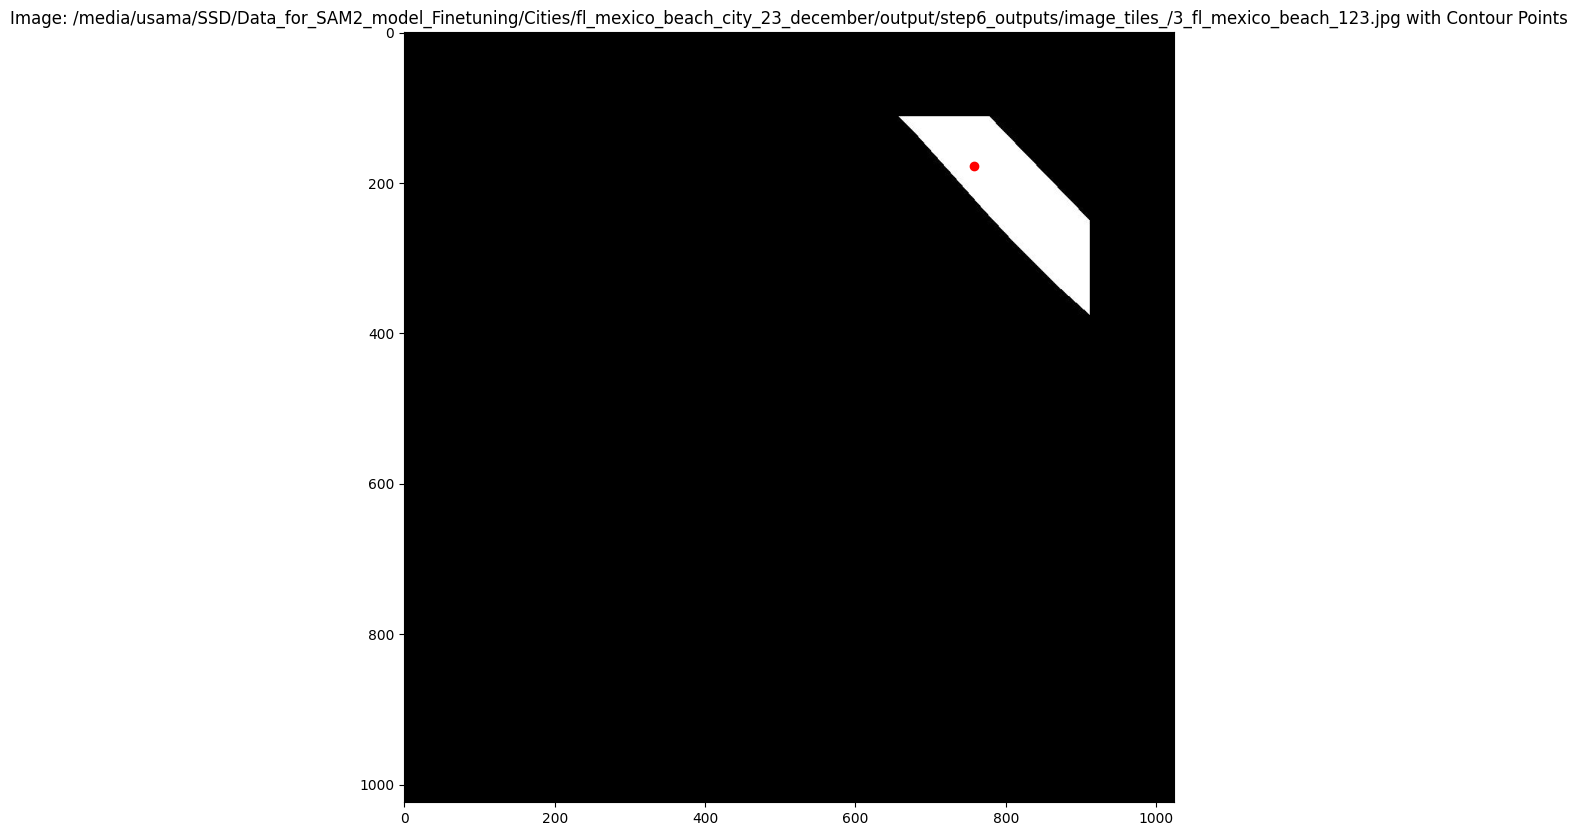

scale 1.0
points [[(128.25, 288.5), (175.0, 324.0), (145.5, 348.0), (192.5, 360.0)]]
copy image path test_data_sam2_24_22_december/images/3_fl_mexico_beach_124_copy0.jpg
point pairs [(128, 288)]


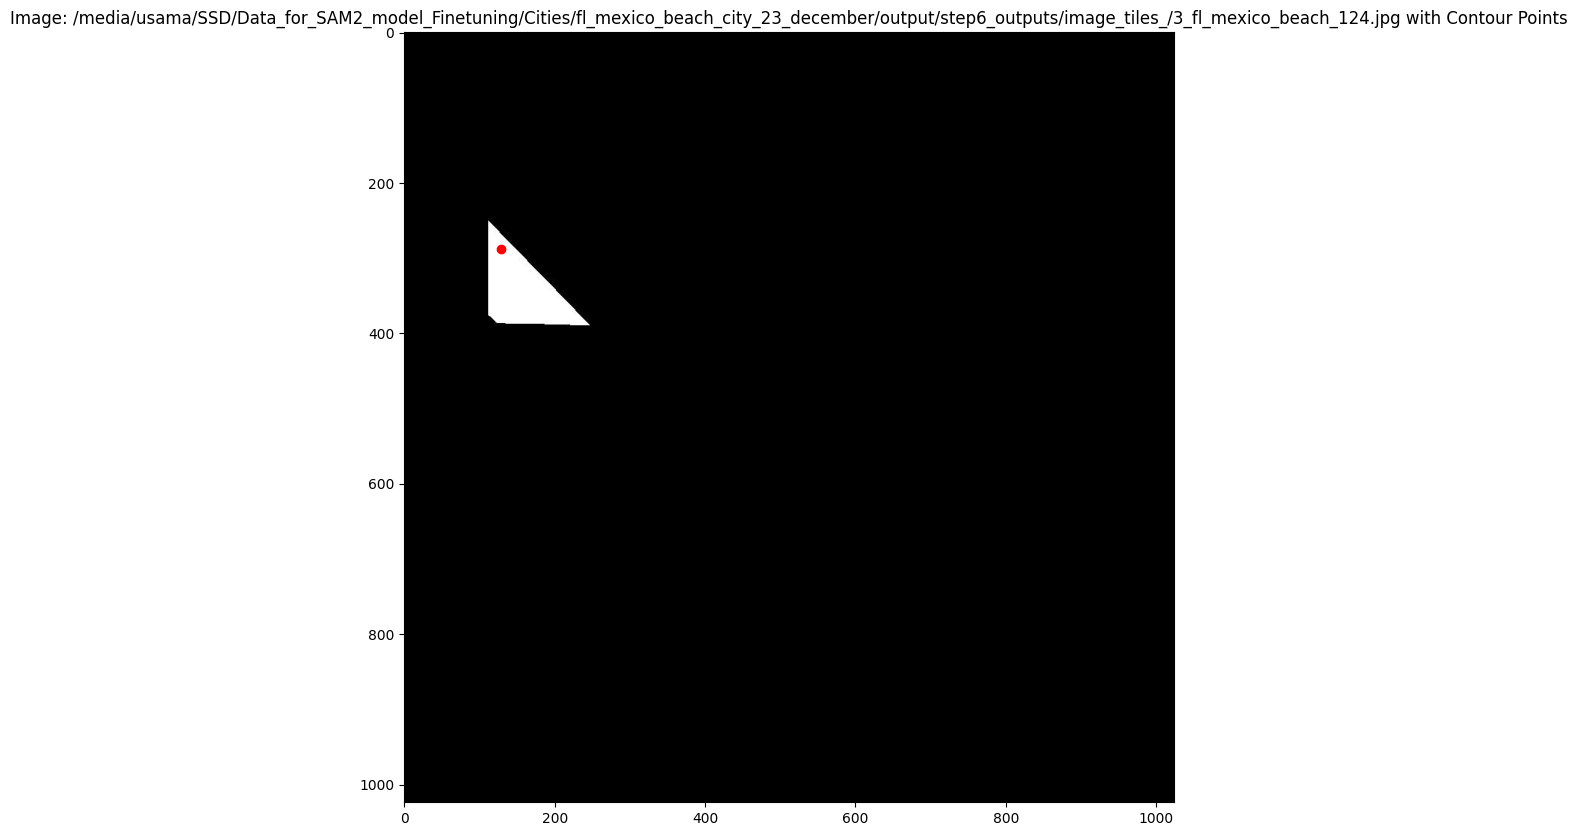

scale 1.0
points [[(374.5, 471.5), (611.5, 520.5), (448.5, 677.5), (719.25, 677.25)]]
copy image path test_data_sam2_24_22_december/images/3_fl_mexico_beach_30_copy0.jpg
point pairs [(374, 471)]


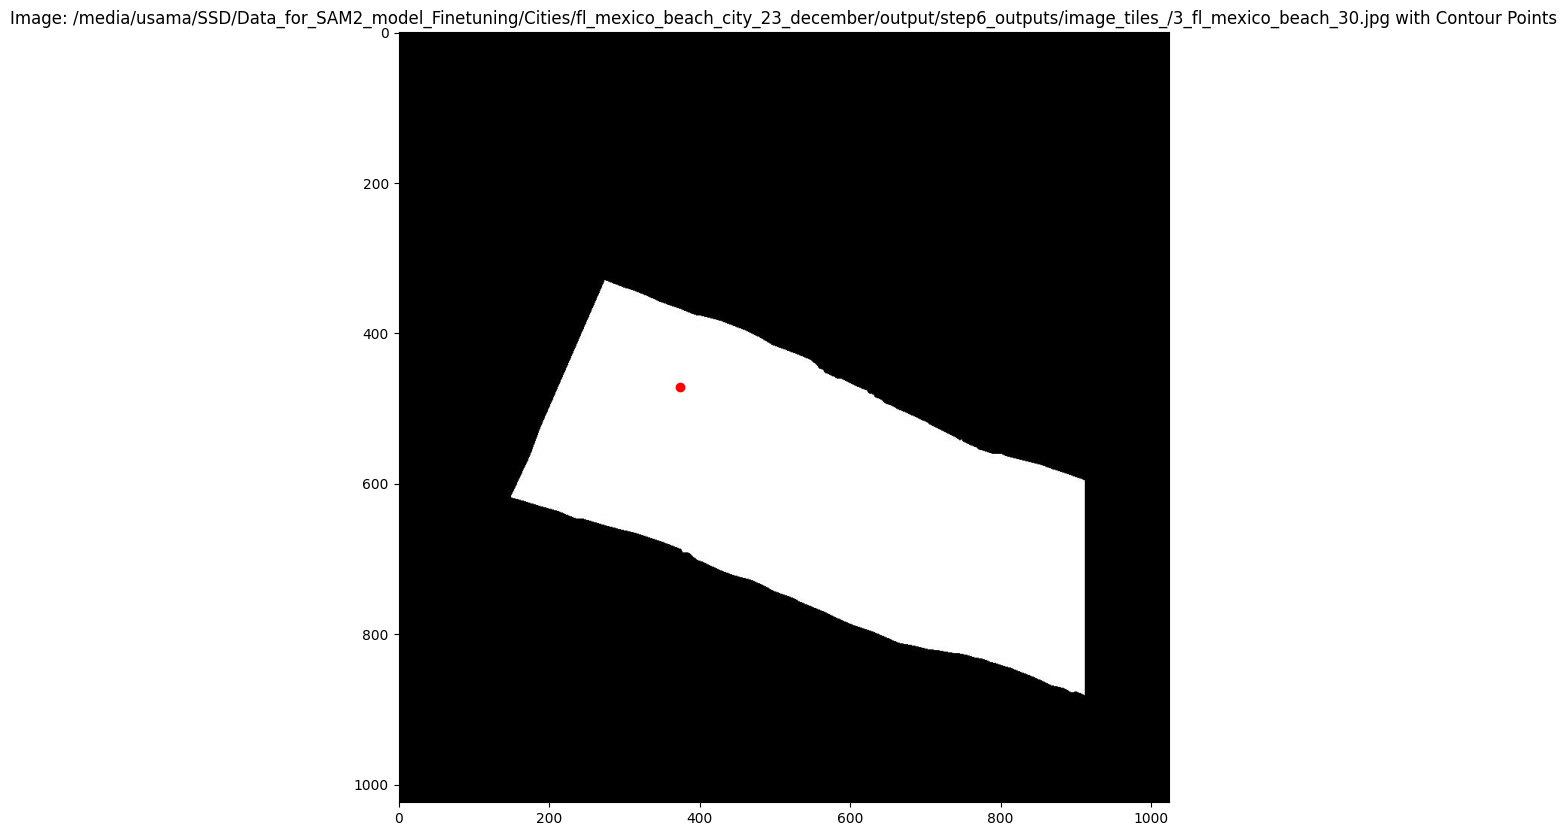

scale 1.0
points [[(200.25, 679.5), (313.75, 818.5), (709.25, 867.5)]]
copy image path test_data_sam2_24_22_december/images/3_fl_mexico_beach_31_copy0.jpg
point pairs [(200, 679)]


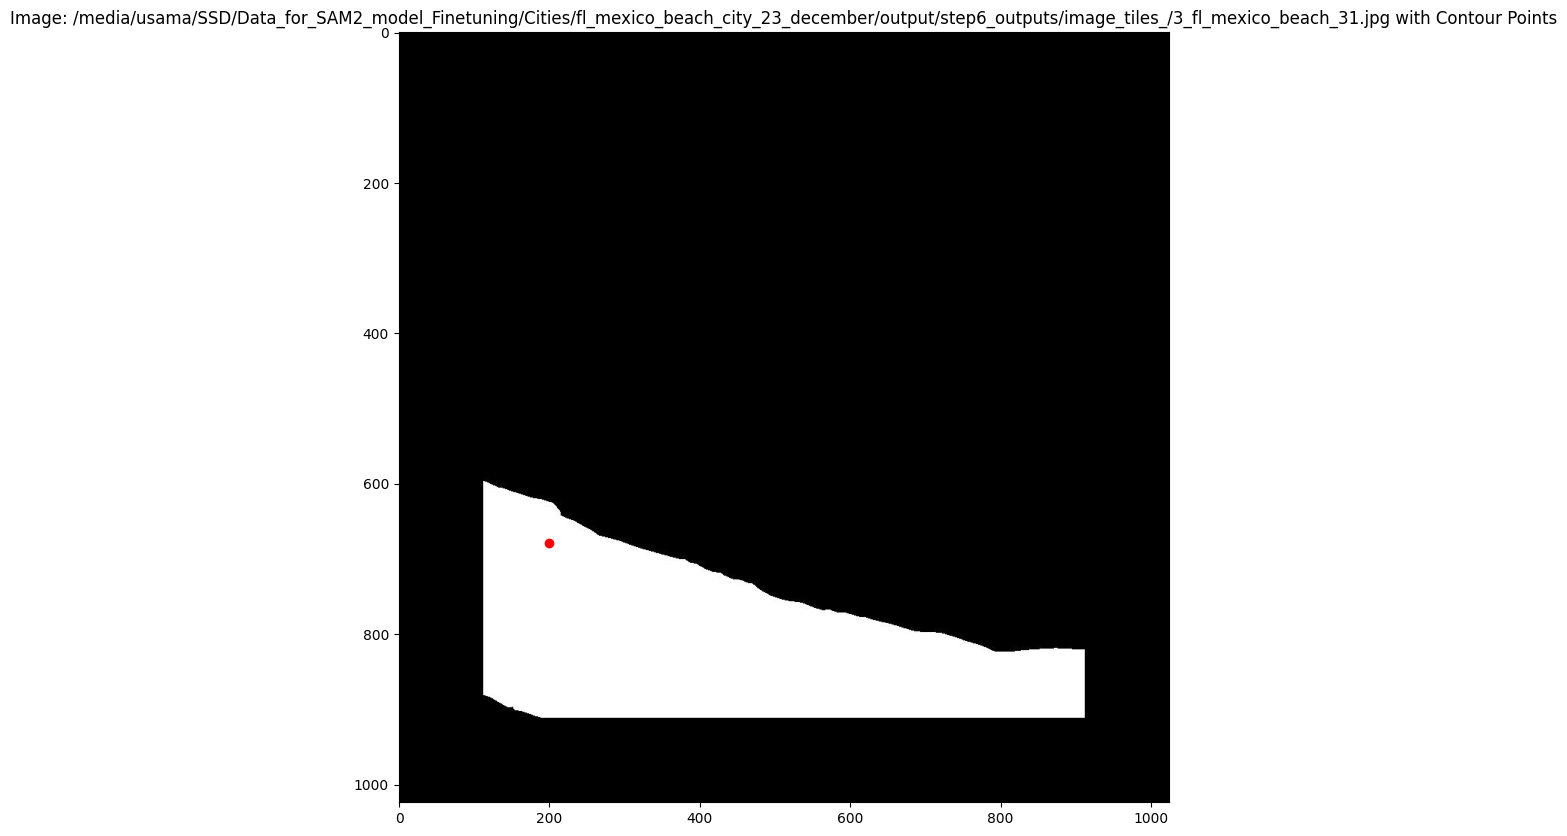

scale 1.0
points [[(180.25, 845.5), (356.25, 861.5), (228.5, 886.5), (424.25, 886.5)]]
copy image path test_data_sam2_24_22_december/images/3_fl_mexico_beach_32_copy0.jpg
point pairs [(180, 845)]


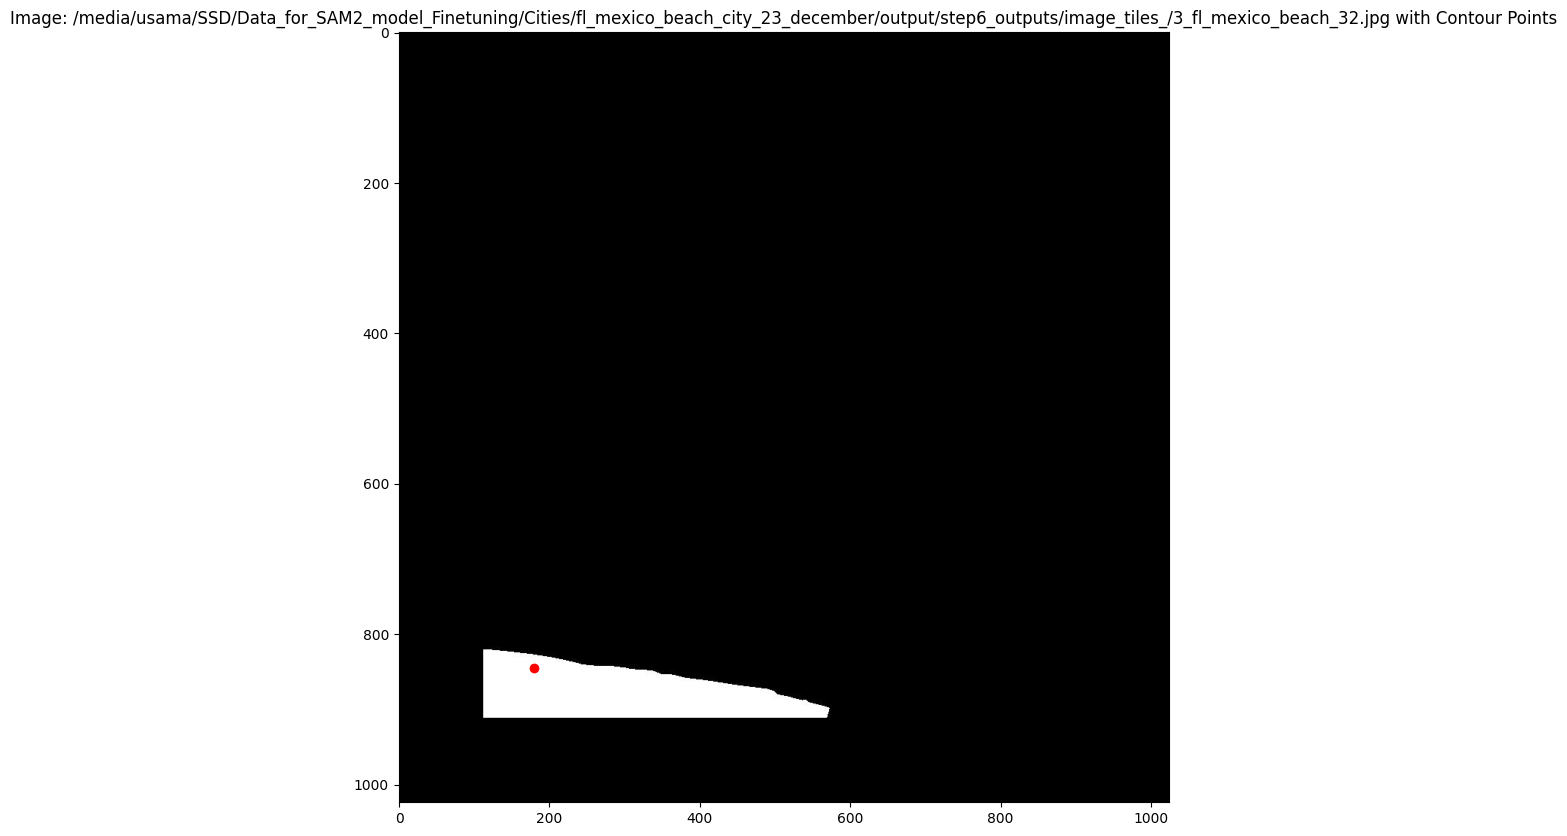

scale 1.0
points [[(458.25, 154.5), (737.5, 154.75), (532.75, 206.5), (761.25, 232.5)]]
copy image path test_data_sam2_24_22_december/images/3_fl_mexico_beach_45_copy0.jpg
point pairs [(458, 154)]


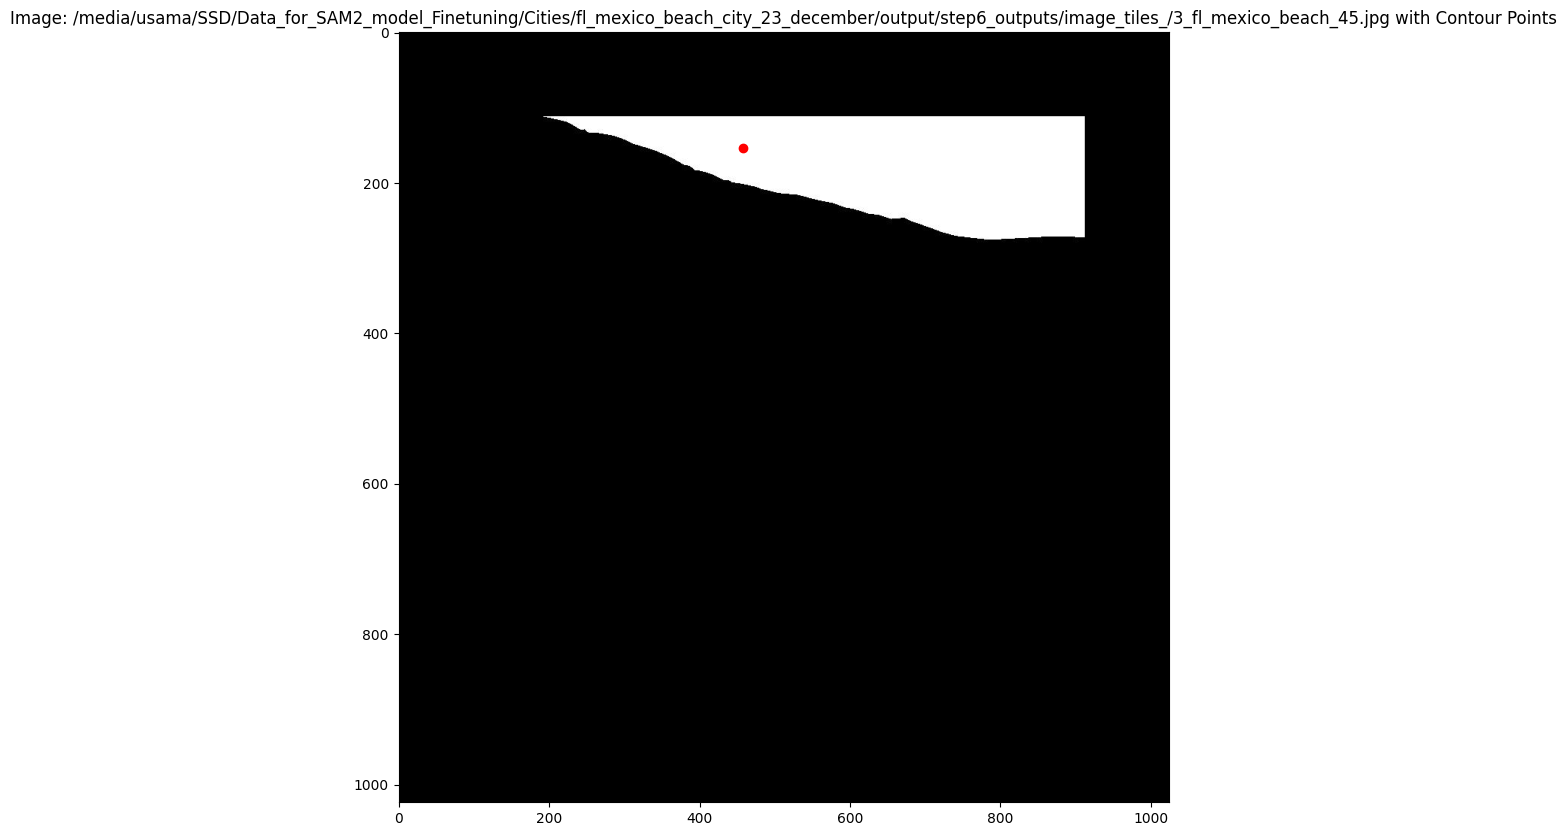

scale 1.0
points [[(612.75, 399.25), (628.0, 394.5), (614.25, 417.25), (632.0, 413.5)], [(698.0, 255.5), (818.5, 263.5), (642.25, 295.5), (861.75, 317.5)], [(576.0, 255.5), (588.75, 217.5), (568.0, 316.0), (584.25, 322.5)], [(227.5, 170.75), (442.5, 169.5), (227.5, 246.75), (426.25, 280.5)]]
copy image path test_data_sam2_24_22_december/images/3_fl_mexico_beach_46_copy0.jpg
point pairs [(612, 399), (698, 255), (576, 255), (227, 170)]


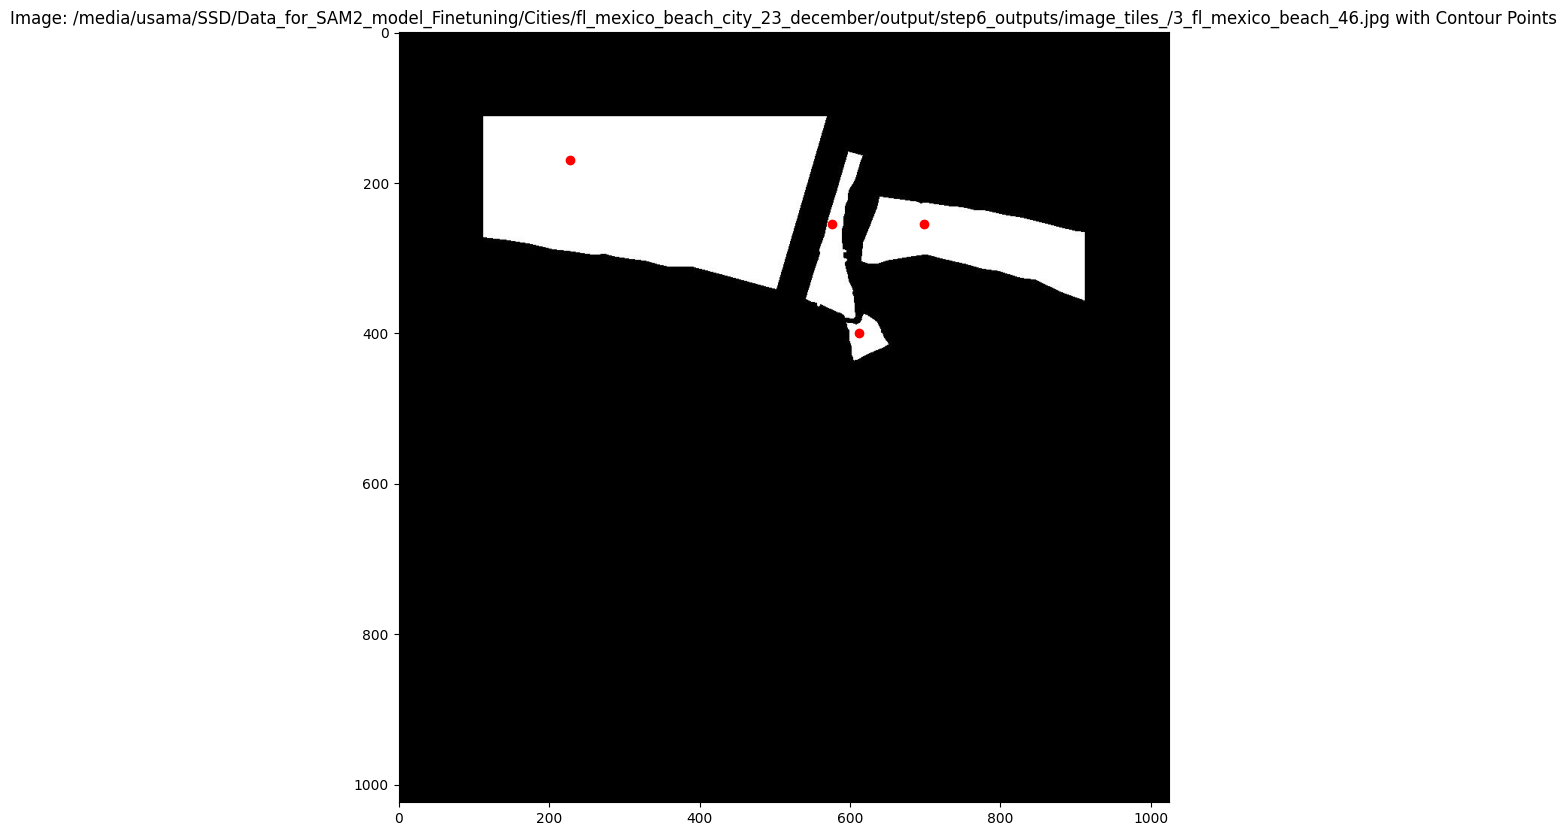

scale 1.0
points [[(258.0, 366.5), (528.0, 447.5), (497.0, 470.5), (741.0, 556.5)]]
copy image path test_data_sam2_24_22_december/images/3_fl_mexico_beach_47_copy0.jpg
point pairs [(258, 366)]


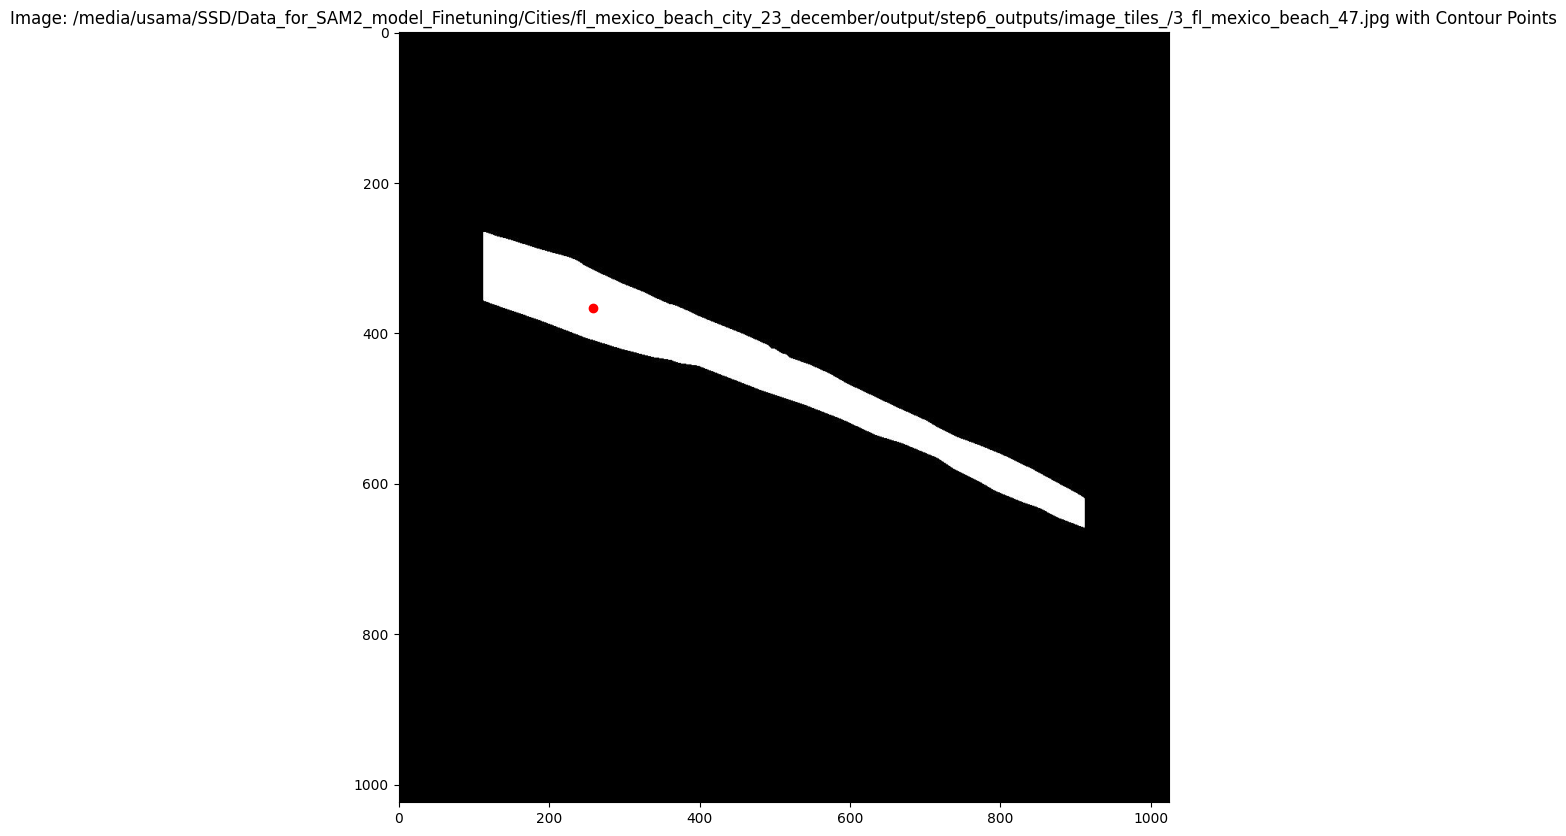

scale 1.0
points [[(250.0, 698.5), (403.5, 763.5), (386.0, 778.5), (535.0, 837.5)]]
copy image path test_data_sam2_24_22_december/images/3_fl_mexico_beach_48_copy0.jpg
point pairs [(250, 698)]


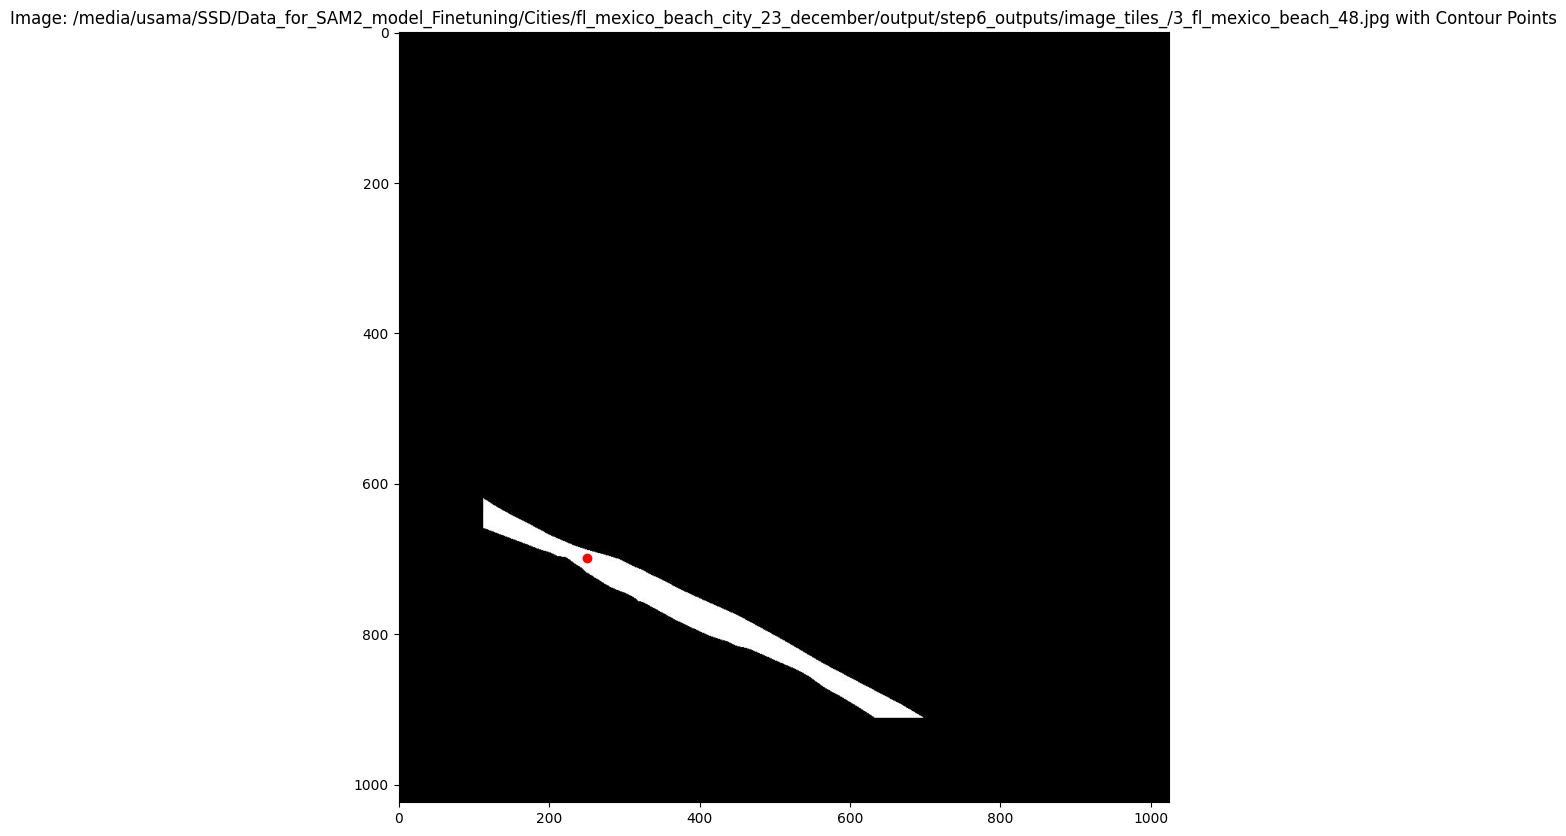

scale 1.0
points [[(734.0, 150.5), (789.0, 177.0), (865.5, 226.5)]]
copy image path test_data_sam2_24_22_december/images/3_fl_mexico_beach_62_copy0.jpg
point pairs [(734, 150)]


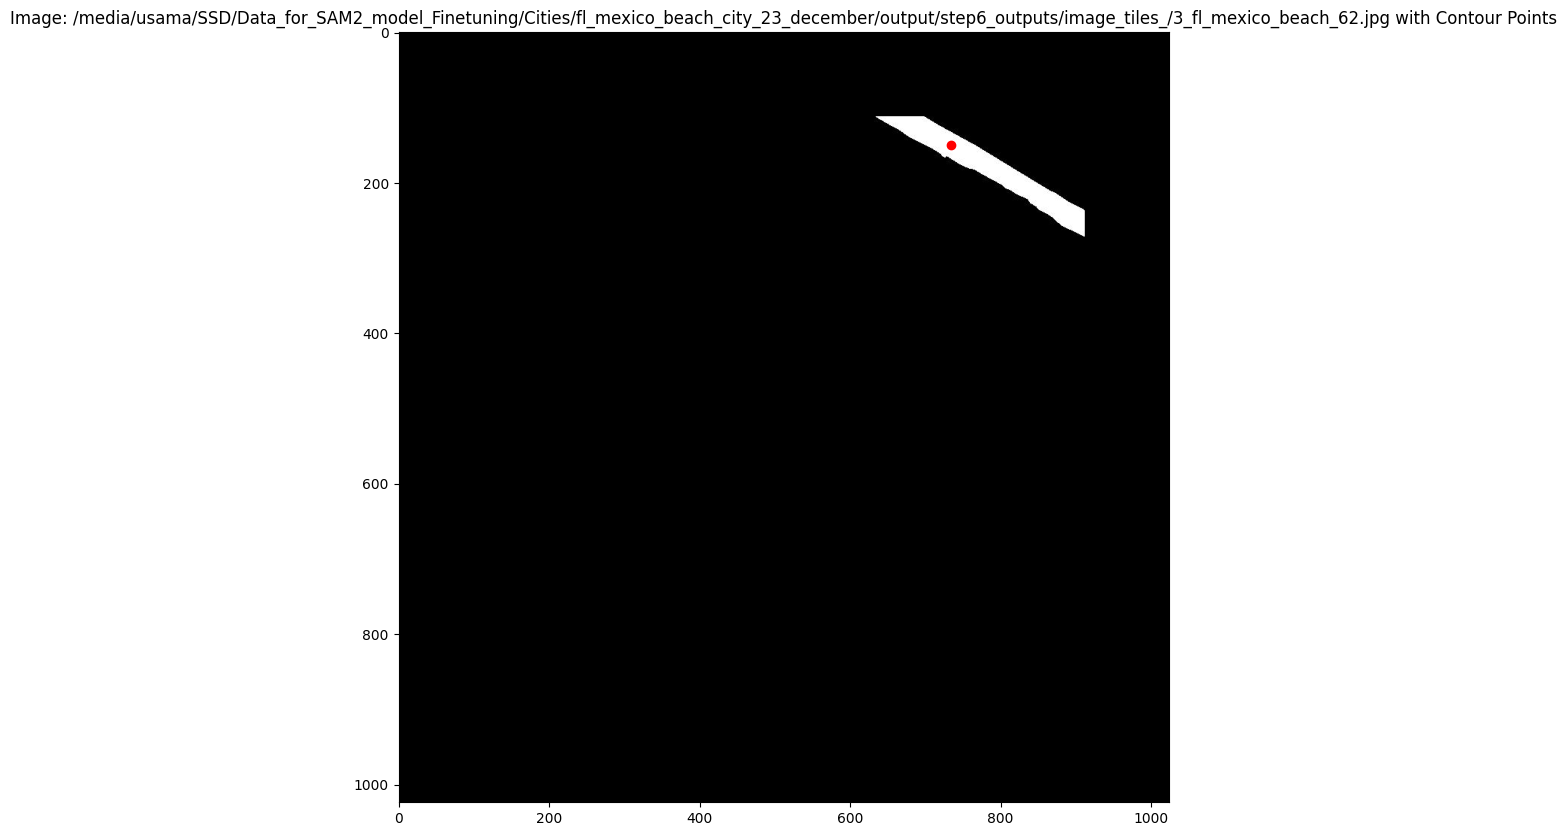

scale 1.0
points [[(153.5, 276.5), (206.25, 301.0), (195.75, 318.0), (246.5, 340.0)]]
copy image path test_data_sam2_24_22_december/images/3_fl_mexico_beach_63_copy0.jpg
point pairs [(153, 276)]


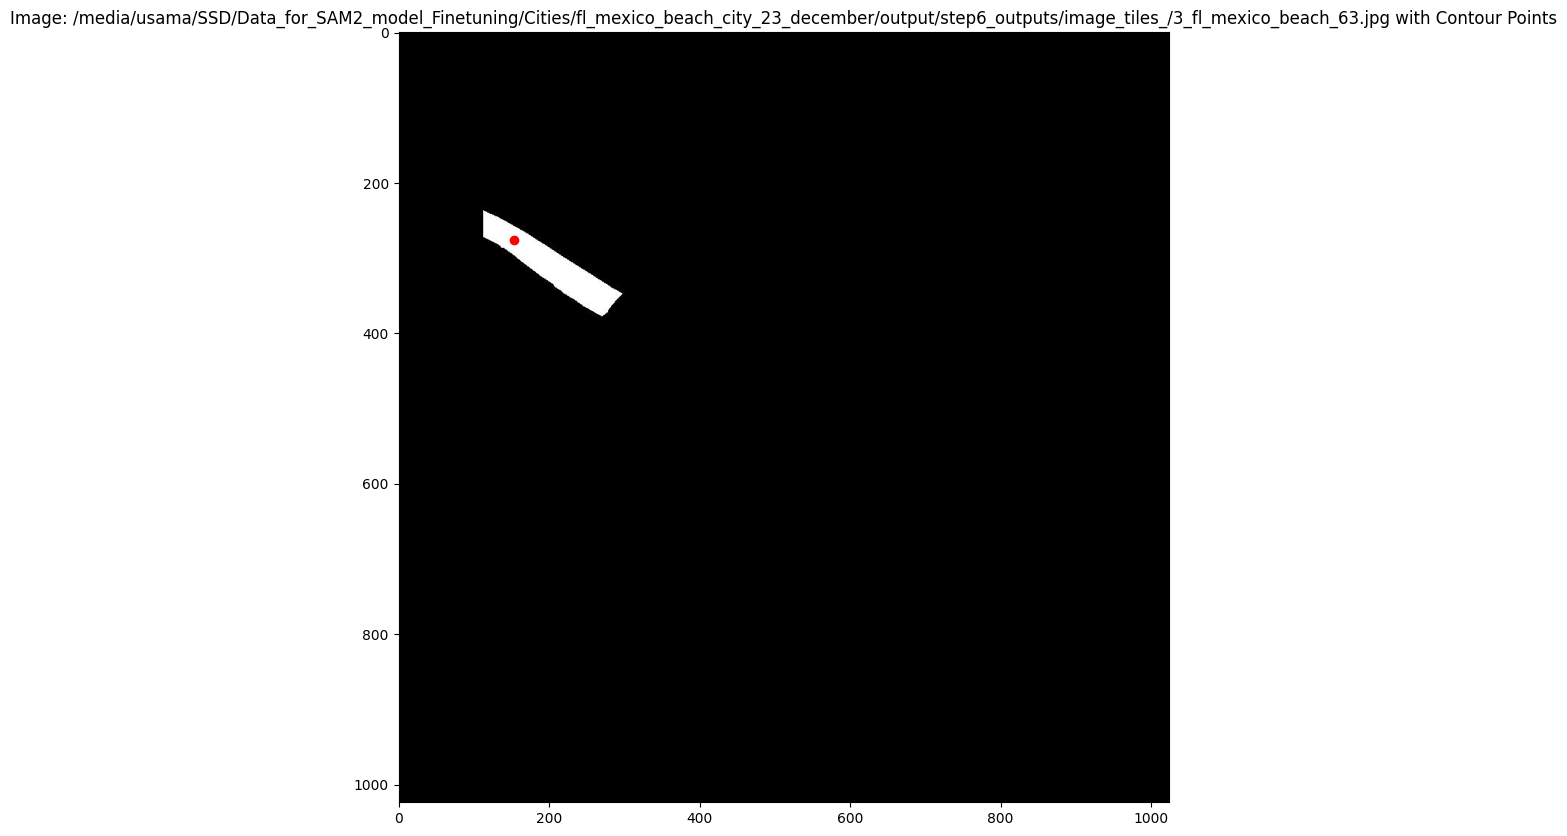

scale 1.0
points [[(502.5, 847.0), (552.75, 859.5), (530.75, 878.0), (569.5, 890.5)]]
copy image path test_data_sam2_24_22_december/images/3_fl_mexico_beach_79_copy0.jpg
point pairs [(502, 847)]


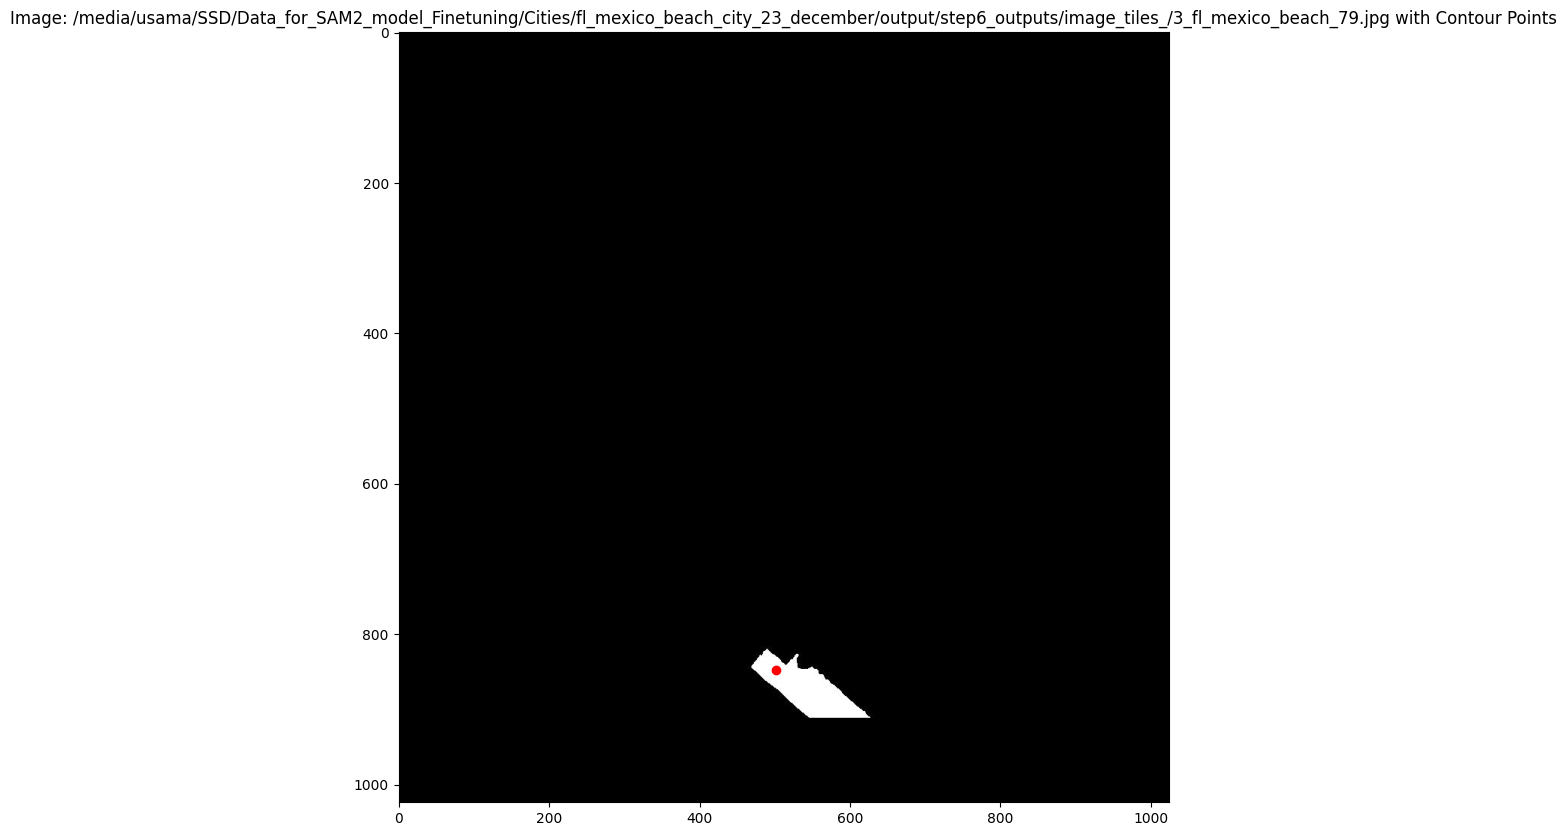

scale 1.0
points [[(697.25, 188.0), (763.5, 218.5), (863.0, 347.0)]]
copy image path test_data_sam2_24_22_december/images/3_fl_mexico_beach_93_copy0.jpg
point pairs [(697, 188)]


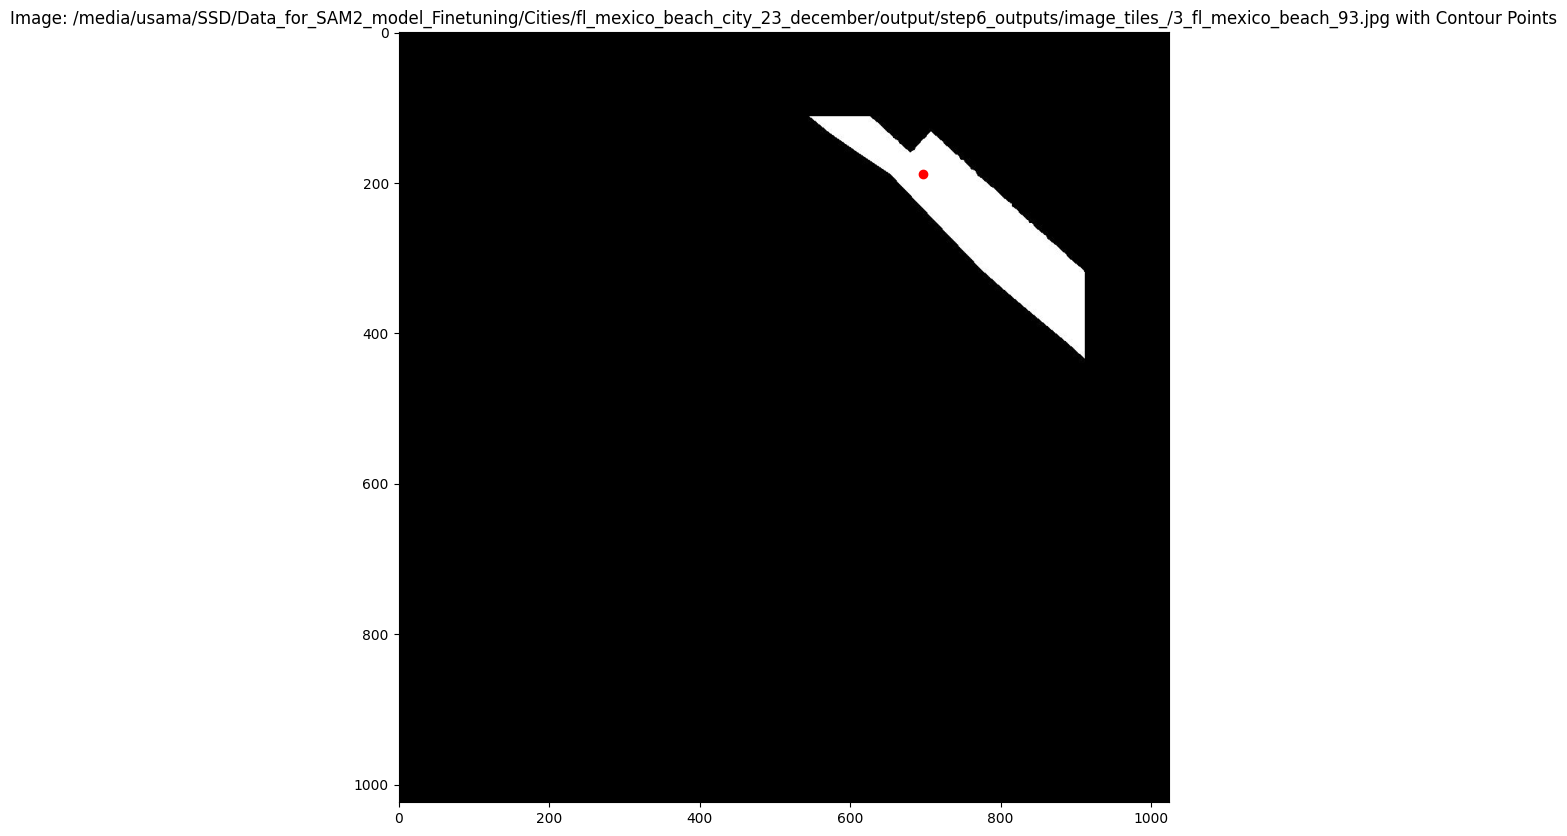

scale 1.0
points [[(223.5, 476.5), (426.0, 619.0), (401.5, 666.0), (535.5, 768.5)]]
copy image path test_data_sam2_24_22_december/images/3_fl_mexico_beach_94_copy0.jpg
point pairs [(223, 476)]


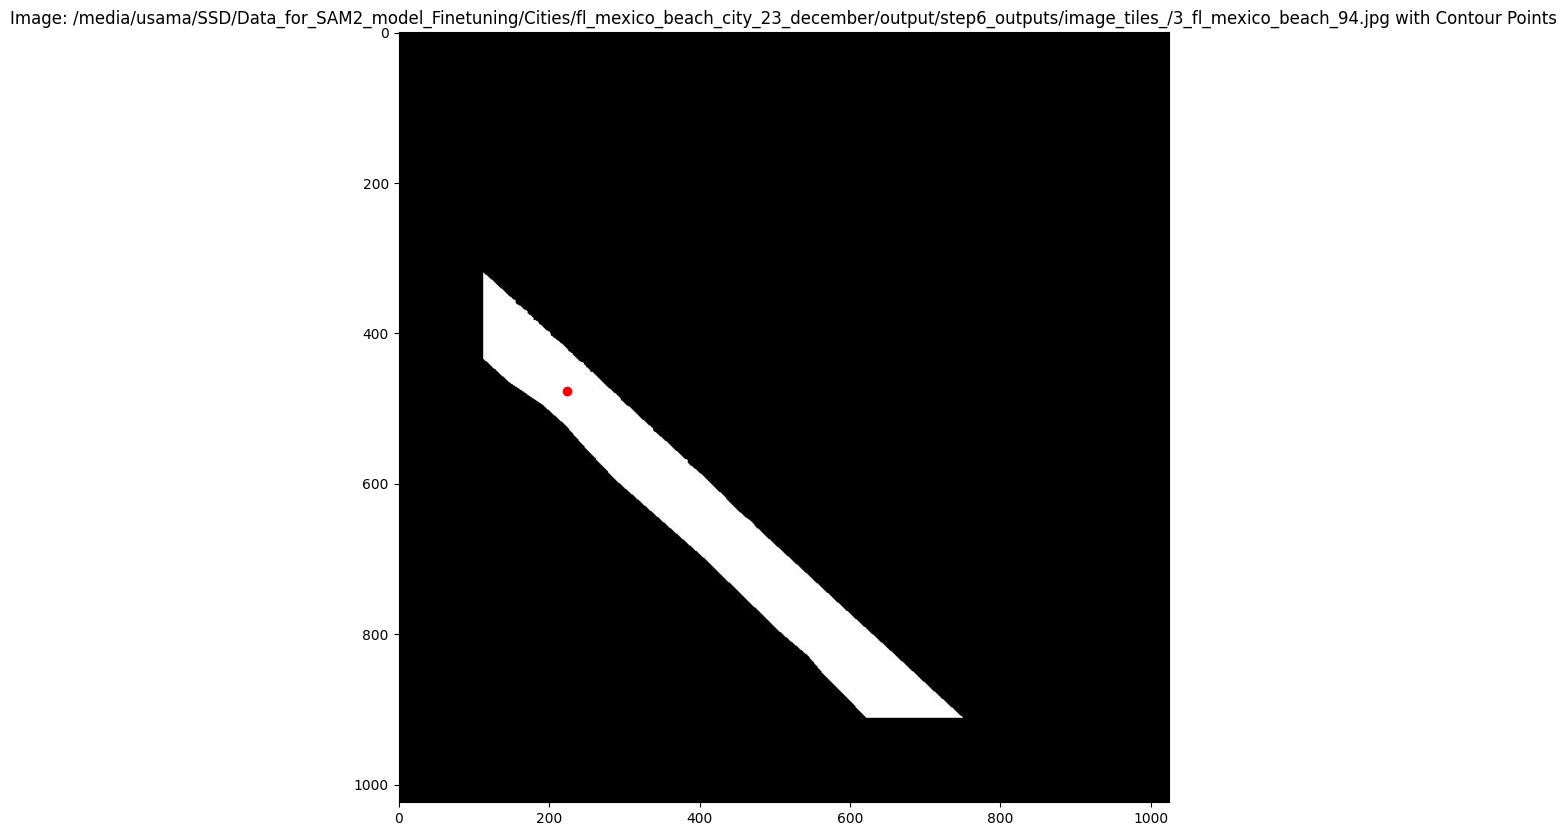

scale 1.0
points [[(616.0, 422.5), (774.25, 422.0), (549.25, 721.5), (774.25, 721.25)], [(798.25, 144.0), (863.25, 143.25), (819.5, 170.5), (884.5, 197.0)]]
copy image path test_data_sam2_24_22_december/images/4_fl_mexico_beach_16_copy0.jpg
point pairs [(616, 422), (798, 144)]


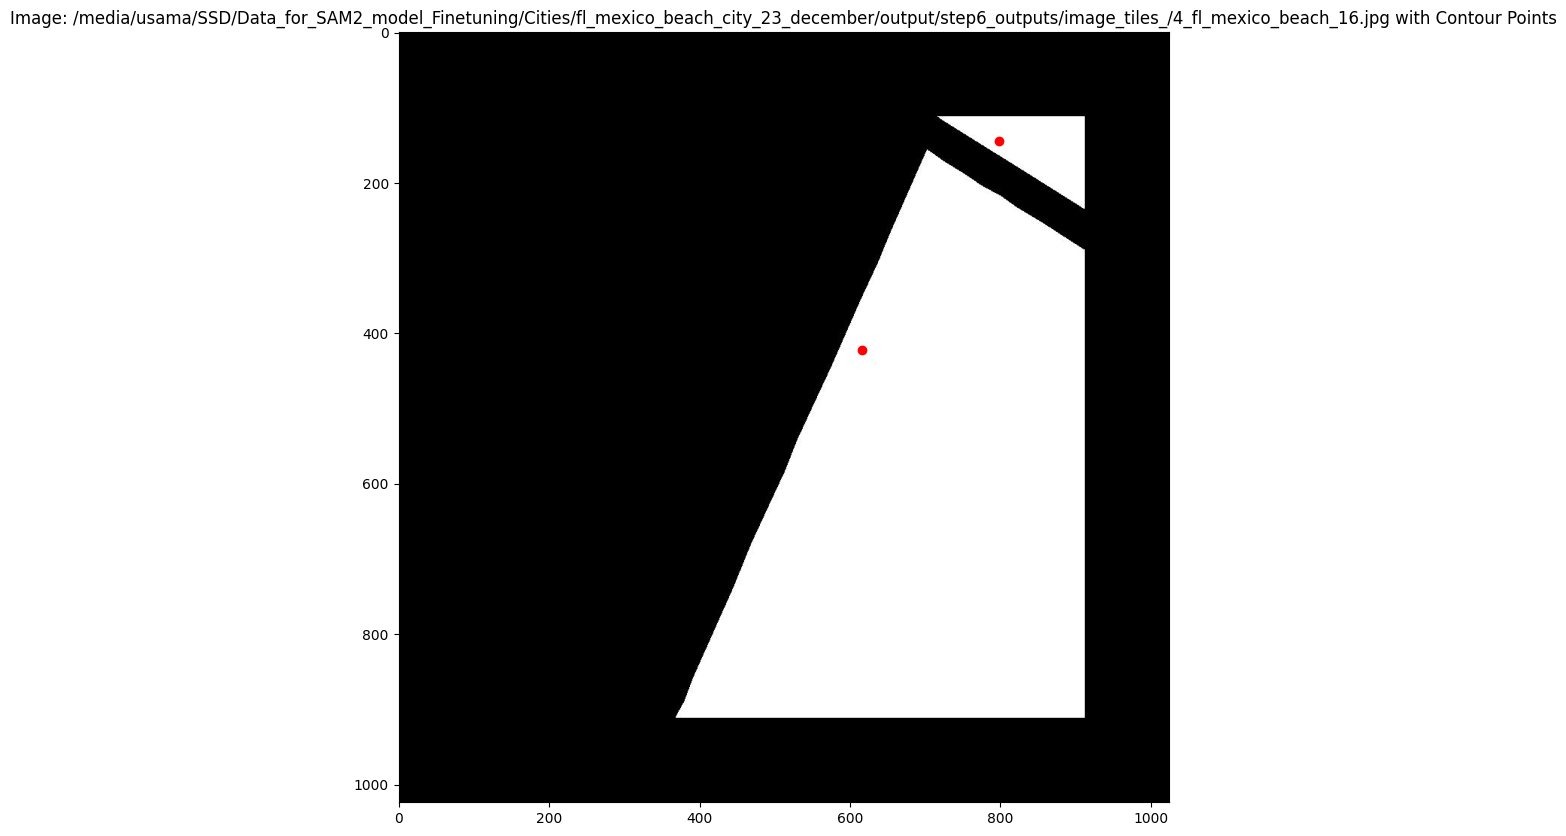

scale 1.0
points [[(234.5, 451.0), (531.25, 579.0), (313.75, 755.0), (669.75, 755.0)], [(346.25, 272.0), (709.25, 271.75), (489.25, 457.0), (785.0, 584.0)]]
copy image path test_data_sam2_24_22_december/images/4_fl_mexico_beach_17_copy0.jpg
point pairs [(234, 451), (346, 272)]


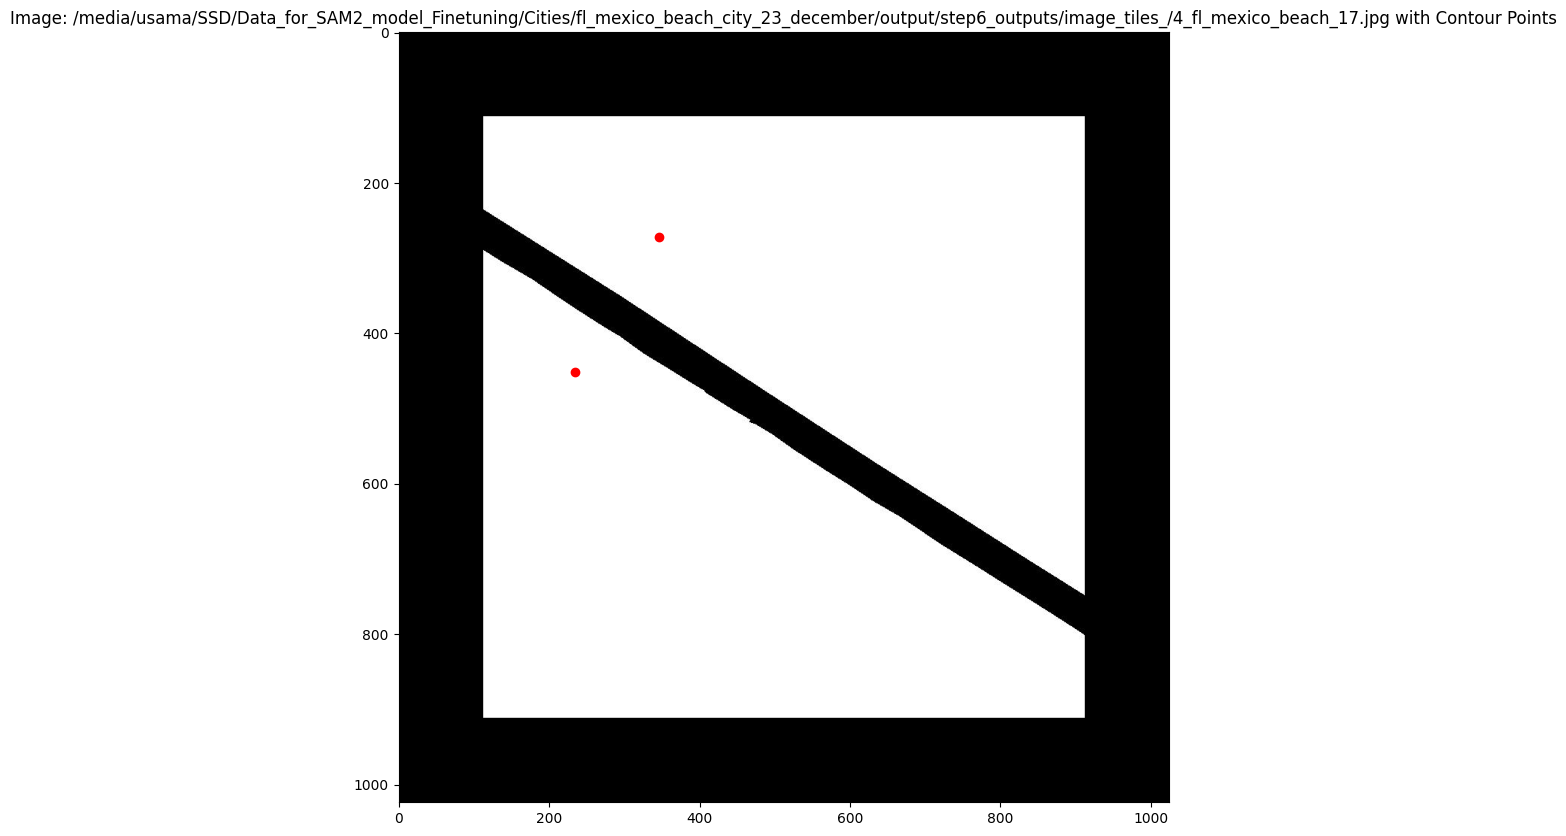

scale 1.0
points [[(135.0, 836.0), (153.5, 883.5), (210.5, 884.0)], [(313.75, 313.75), (709.25, 313.75), (313.75, 627.75), (709.25, 709.25)]]
copy image path test_data_sam2_24_22_december/images/4_fl_mexico_beach_18_copy0.jpg
point pairs [(135, 836), (313, 313)]


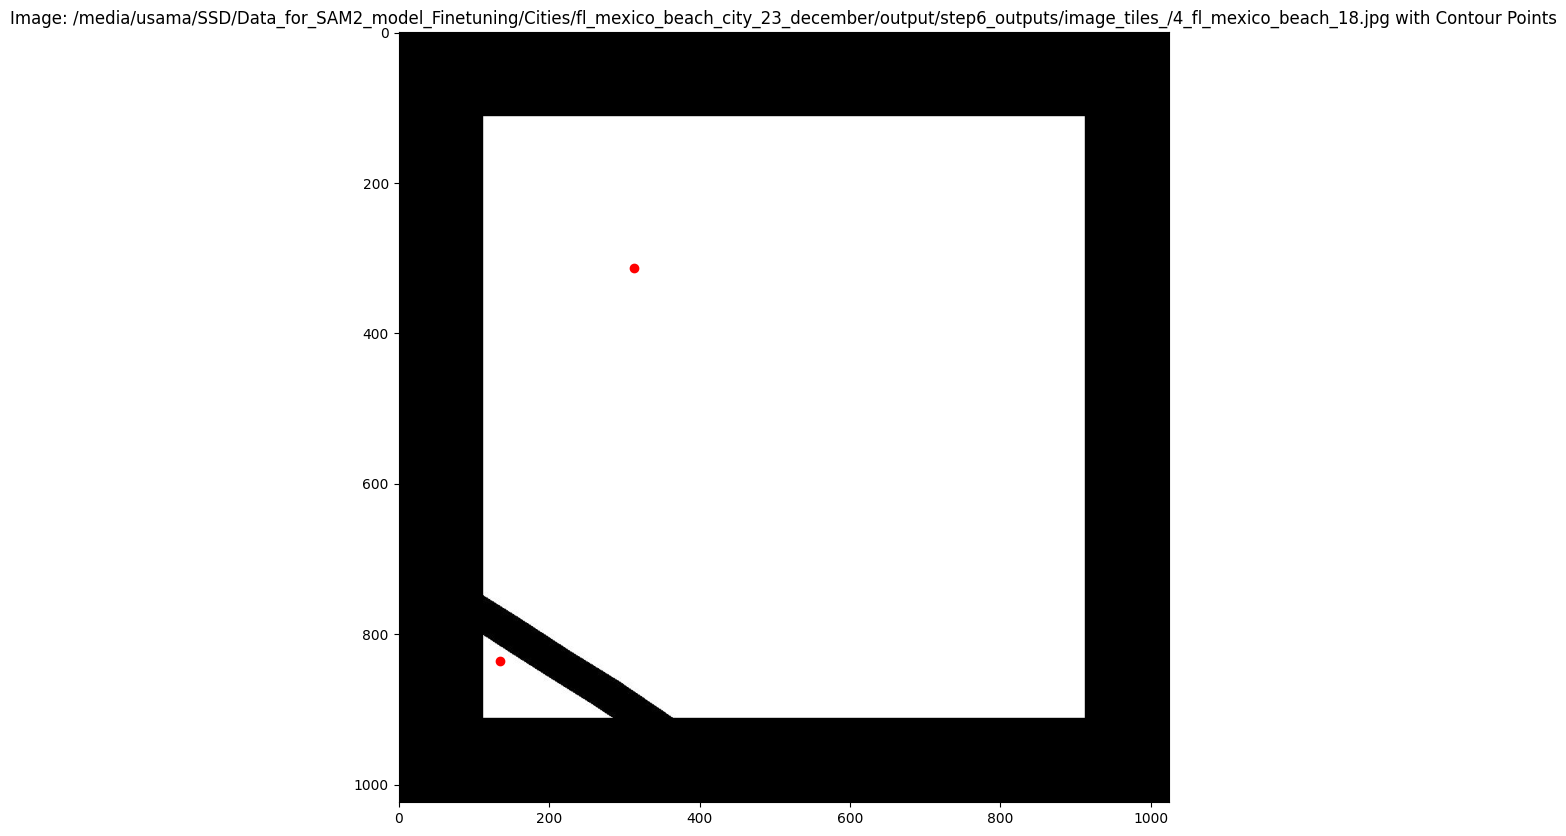

scale 1.0
points [[(313.75, 313.75), (709.25, 313.75), (313.75, 709.25), (709.25, 709.25)]]
copy image path test_data_sam2_24_22_december/images/4_fl_mexico_beach_19_copy0.jpg
point pairs [(313, 313)]


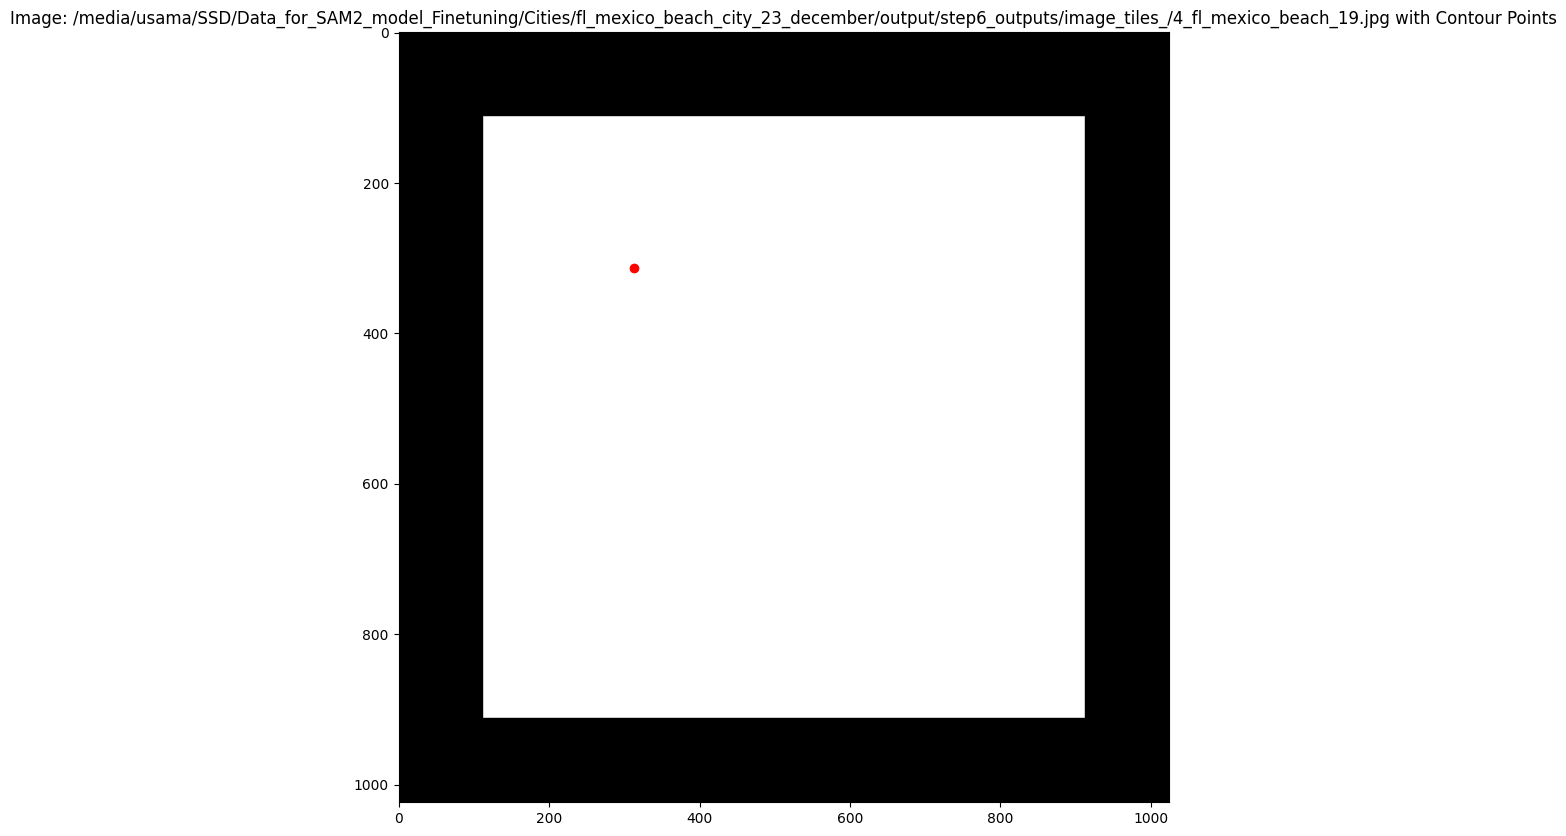

scale 1.0
points [[(802.75, 771.5), (859.25, 771.25), (776.0, 856.5), (859.25, 856.0)]]
copy image path test_data_sam2_24_22_december/images/4_fl_mexico_beach_2_copy0.jpg
point pairs [(802, 771)]


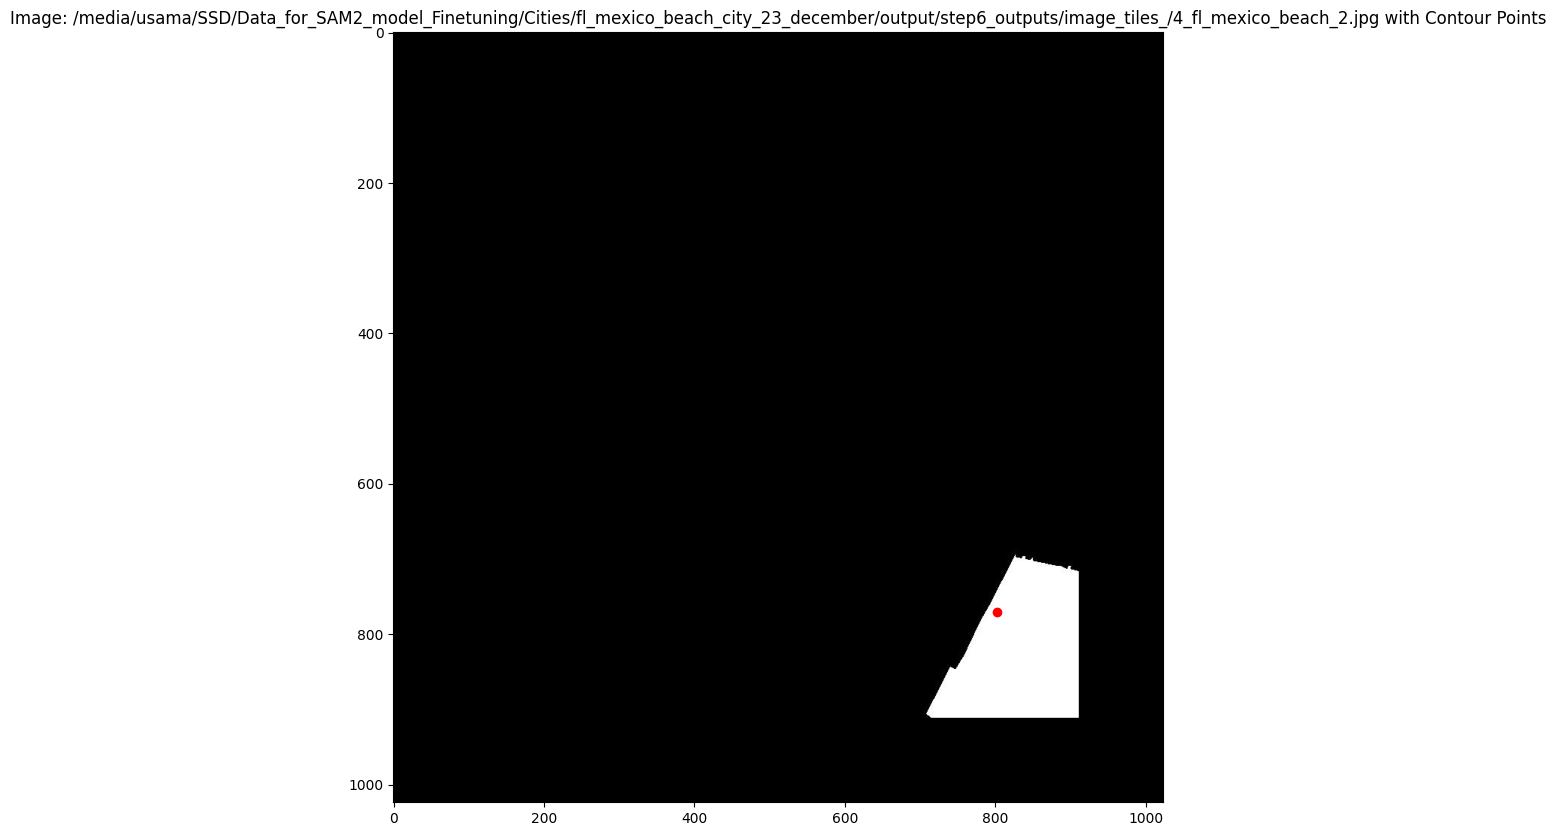

scale 1.0
points [[(145.75, 313.75), (197.75, 310.5), (145.75, 709.25), (203.25, 705.0)]]
copy image path test_data_sam2_24_22_december/images/4_fl_mexico_beach_20_copy0.jpg
point pairs [(145, 313)]


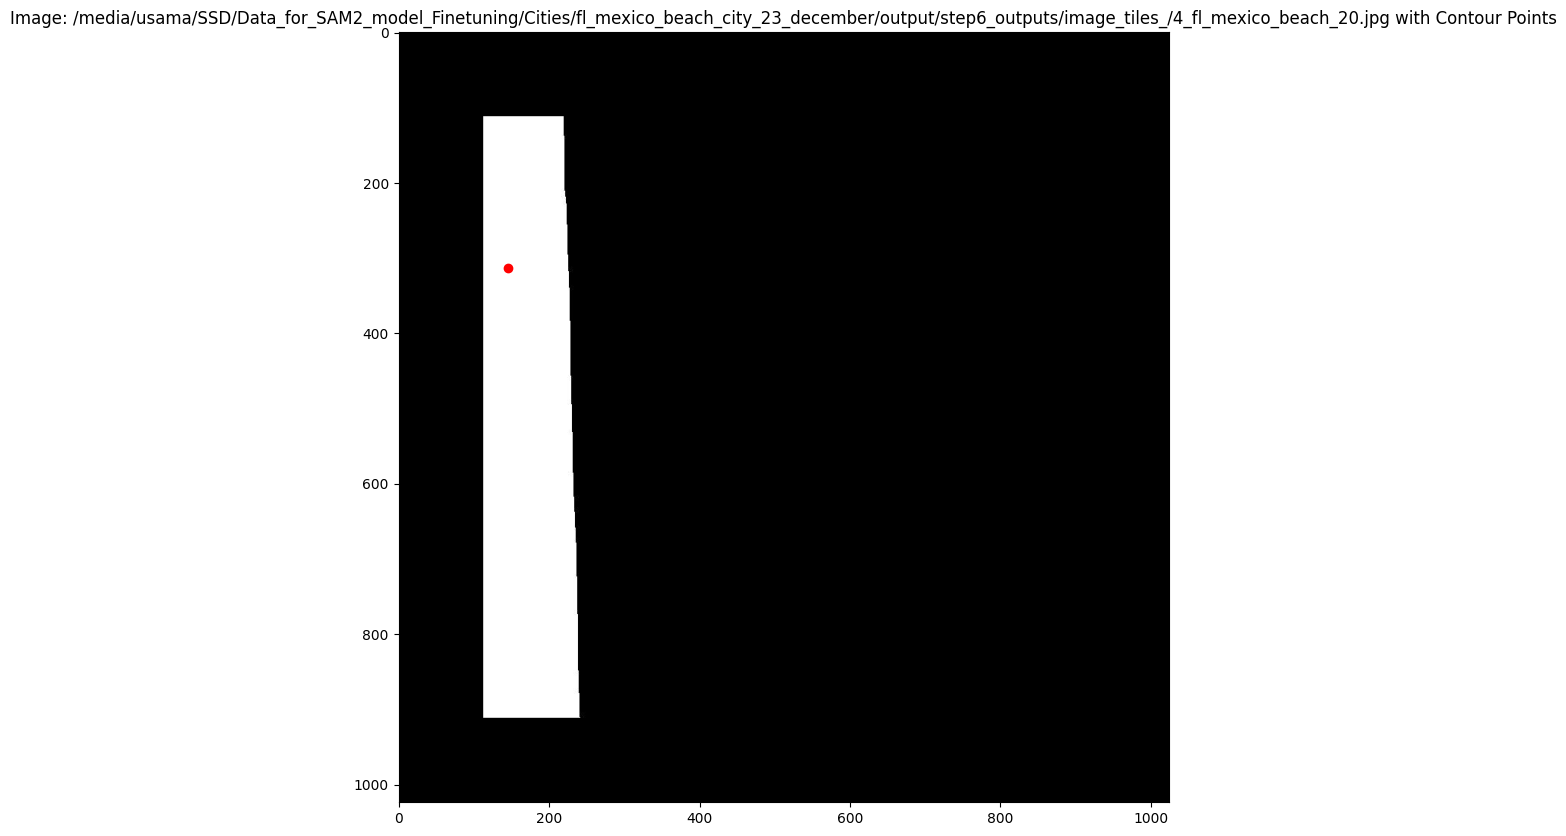

scale 1.0
points [[(258.25, 769.5), (709.25, 805.0), (313.75, 861.0), (709.25, 861.0)]]
copy image path test_data_sam2_24_22_december/images/4_fl_mexico_beach_3_copy0.jpg
point pairs [(258, 769)]


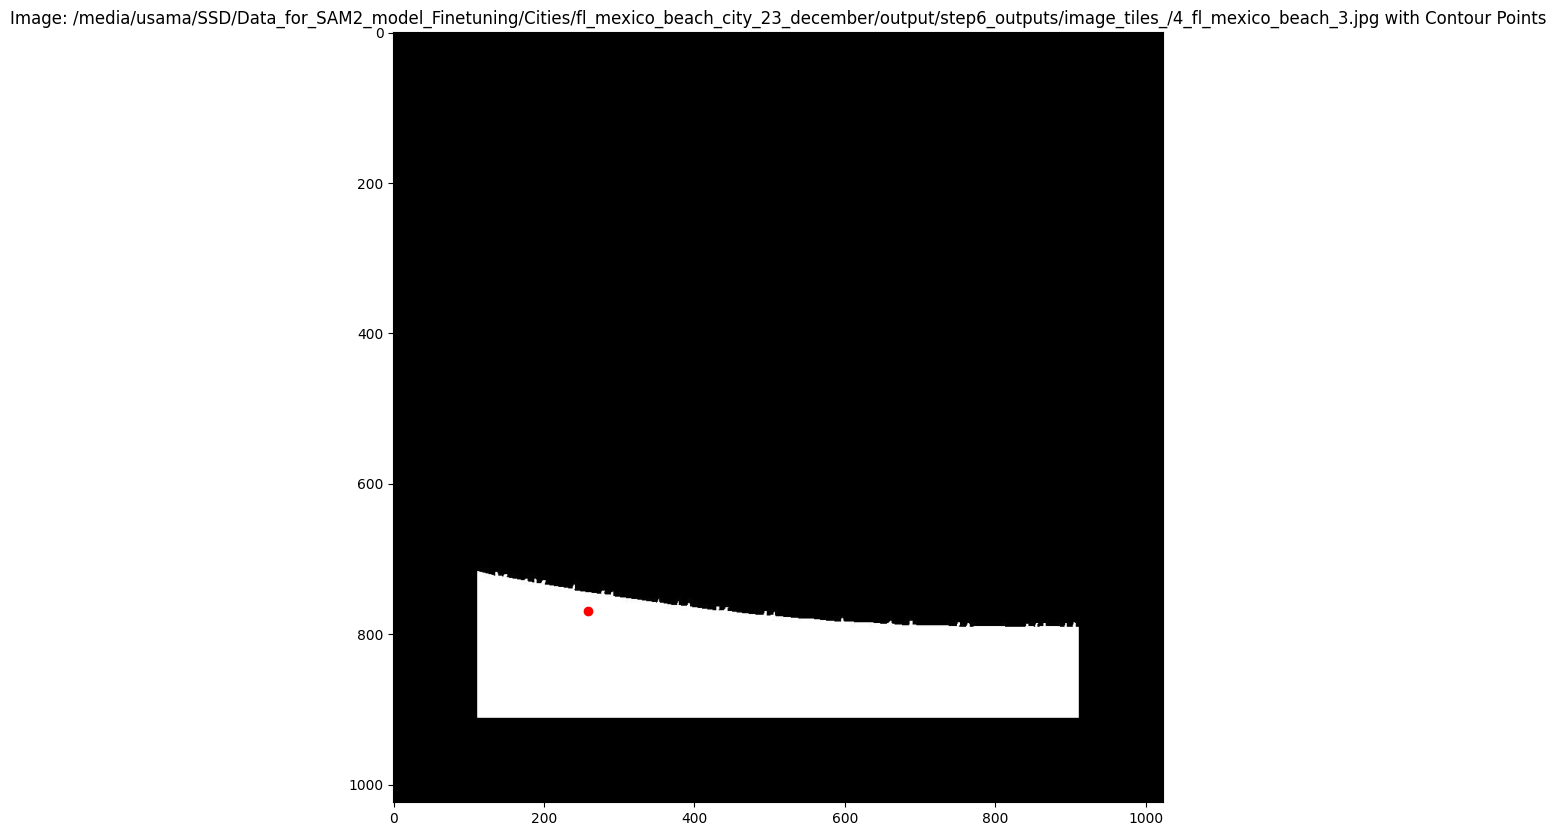

scale 1.0
points [[(457.25, 234.5), (750.5, 234.0), (541.0, 404.0), (764.75, 470.5)]]
copy image path test_data_sam2_24_22_december/images/4_fl_mexico_beach_30_copy0.jpg
point pairs [(457, 234)]


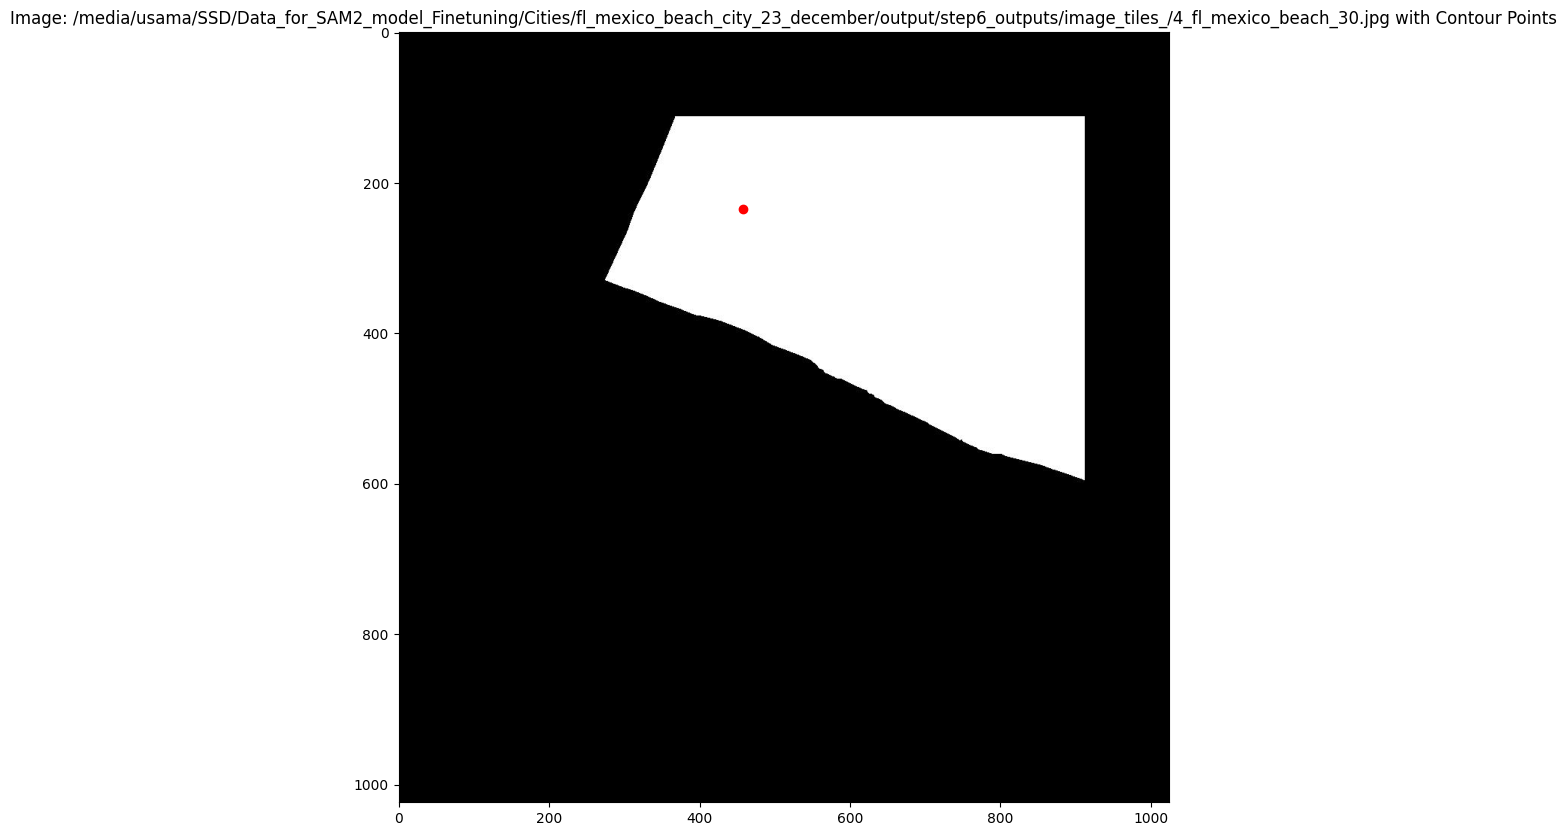

scale 1.0
points [[(313.75, 291.75), (709.25, 291.75), (337.0, 608.5), (709.25, 608.25)]]
copy image path test_data_sam2_24_22_december/images/4_fl_mexico_beach_31_copy0.jpg
point pairs [(313, 291)]


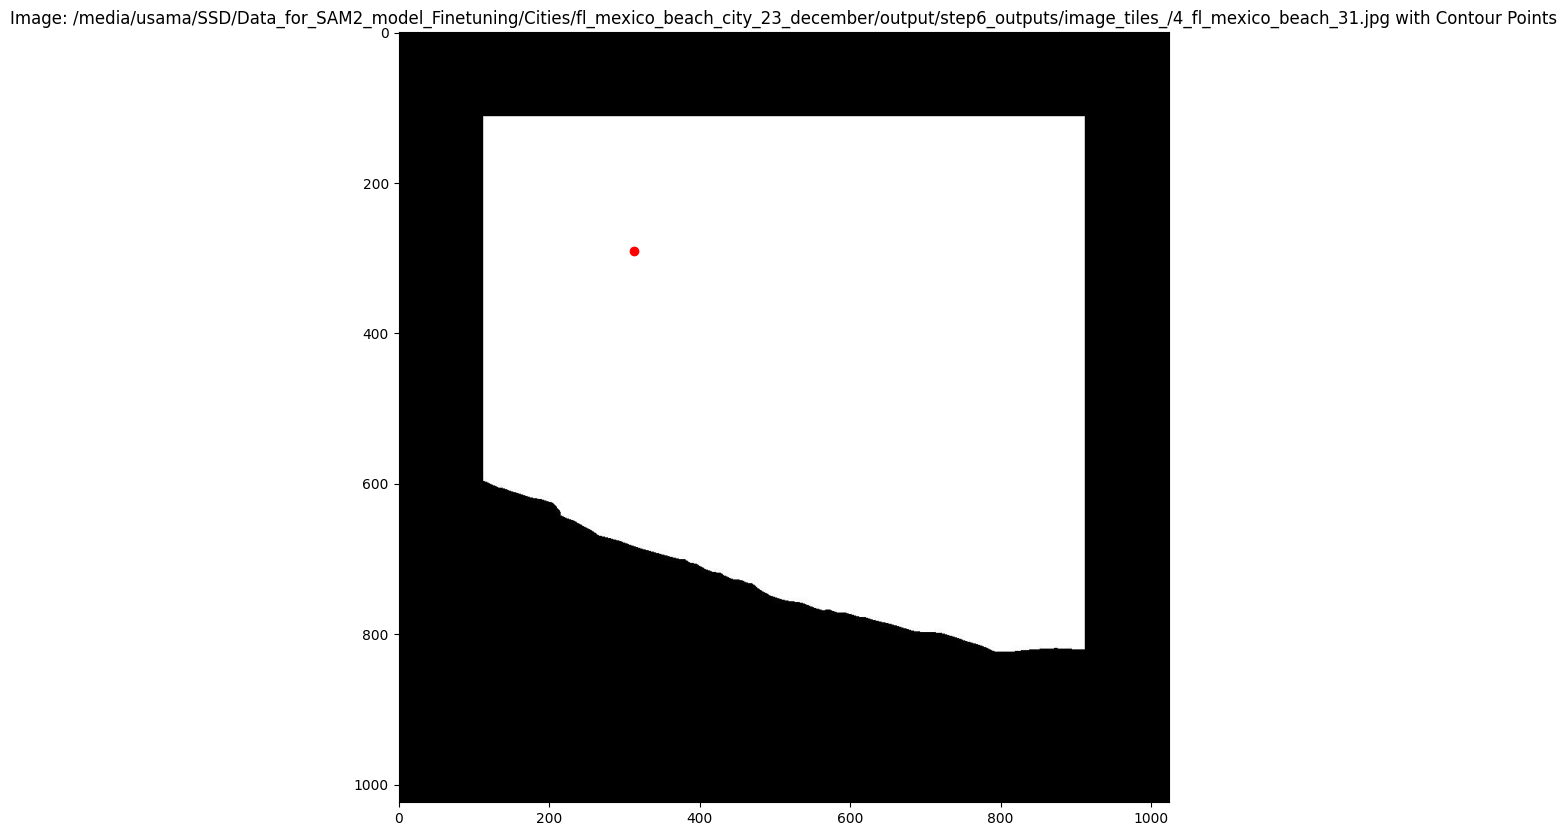

scale 1.0
points [[(577.0, 200.0), (775.5, 200.0), (841.25, 368.5)], [(313.75, 386.0), (604.25, 386.0), (313.75, 659.75), (567.75, 698.5)]]
copy image path test_data_sam2_24_22_december/images/4_fl_mexico_beach_32_copy0.jpg
point pairs [(577, 200), (313, 386)]


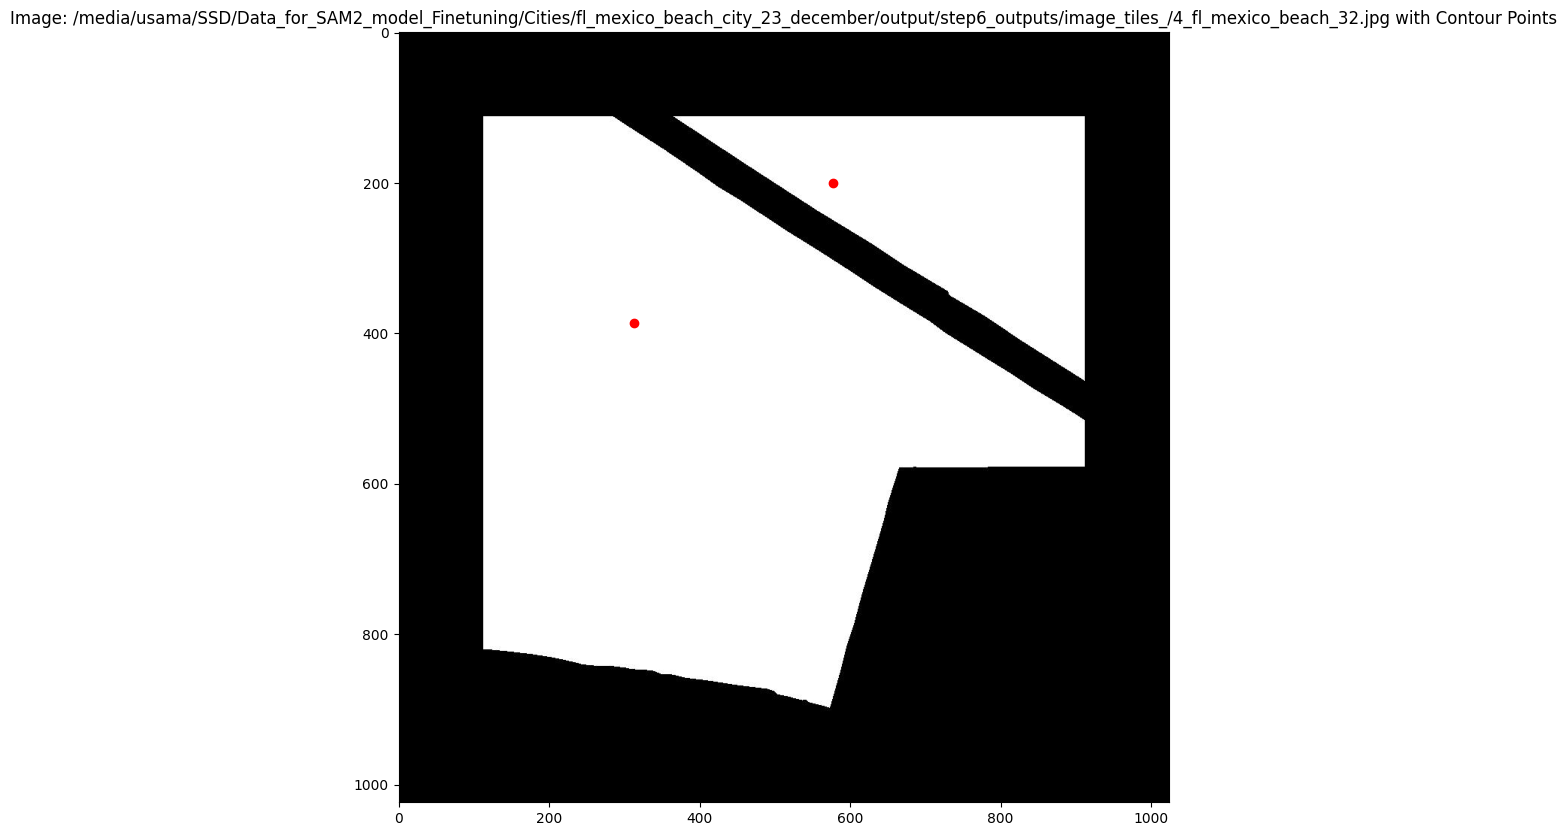

scale 1.0
points [[(124.0, 537.0), (134.0, 561.5), (161.0, 561.0)], [(313.75, 229.75), (709.25, 229.75), (313.75, 401.25), (709.25, 450.25)]]
copy image path test_data_sam2_24_22_december/images/4_fl_mexico_beach_33_copy0.jpg
point pairs [(124, 537), (313, 229)]


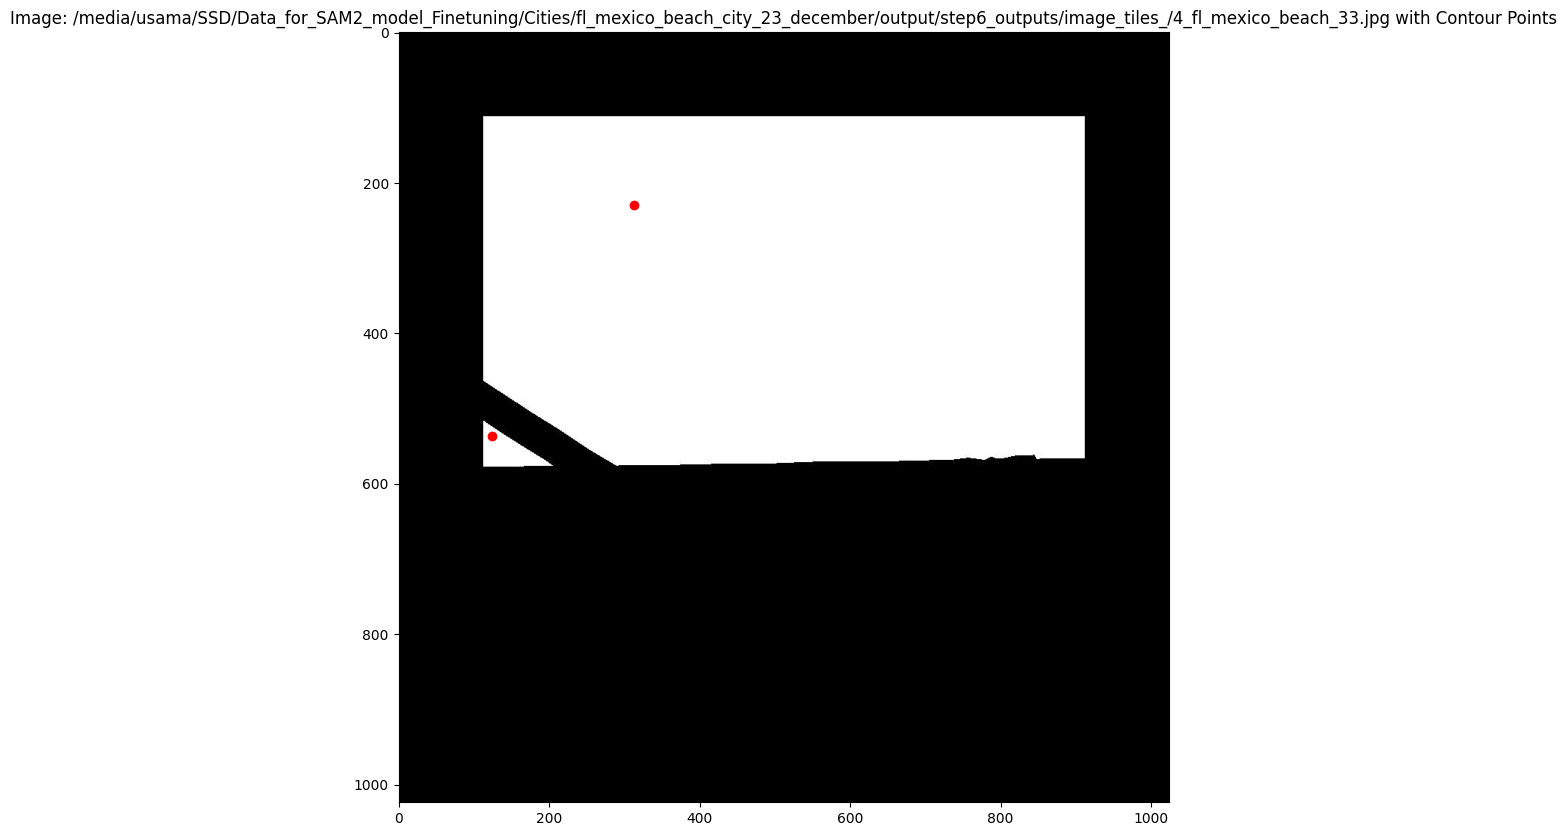

scale 1.0
points [[(556.75, 736.5), (781.0, 743.0), (601.0, 850.5), (781.0, 850.0)], [(451.5, 594.5), (751.25, 592.5), (469.25, 635.0), (751.25, 632.25)], [(148.75, 227.25), (209.75, 218.0), (148.75, 449.25), (212.75, 451.0)]]
copy image path test_data_sam2_24_22_december/images/4_fl_mexico_beach_34_copy0.jpg
point pairs [(556, 736), (451, 594), (148, 227)]


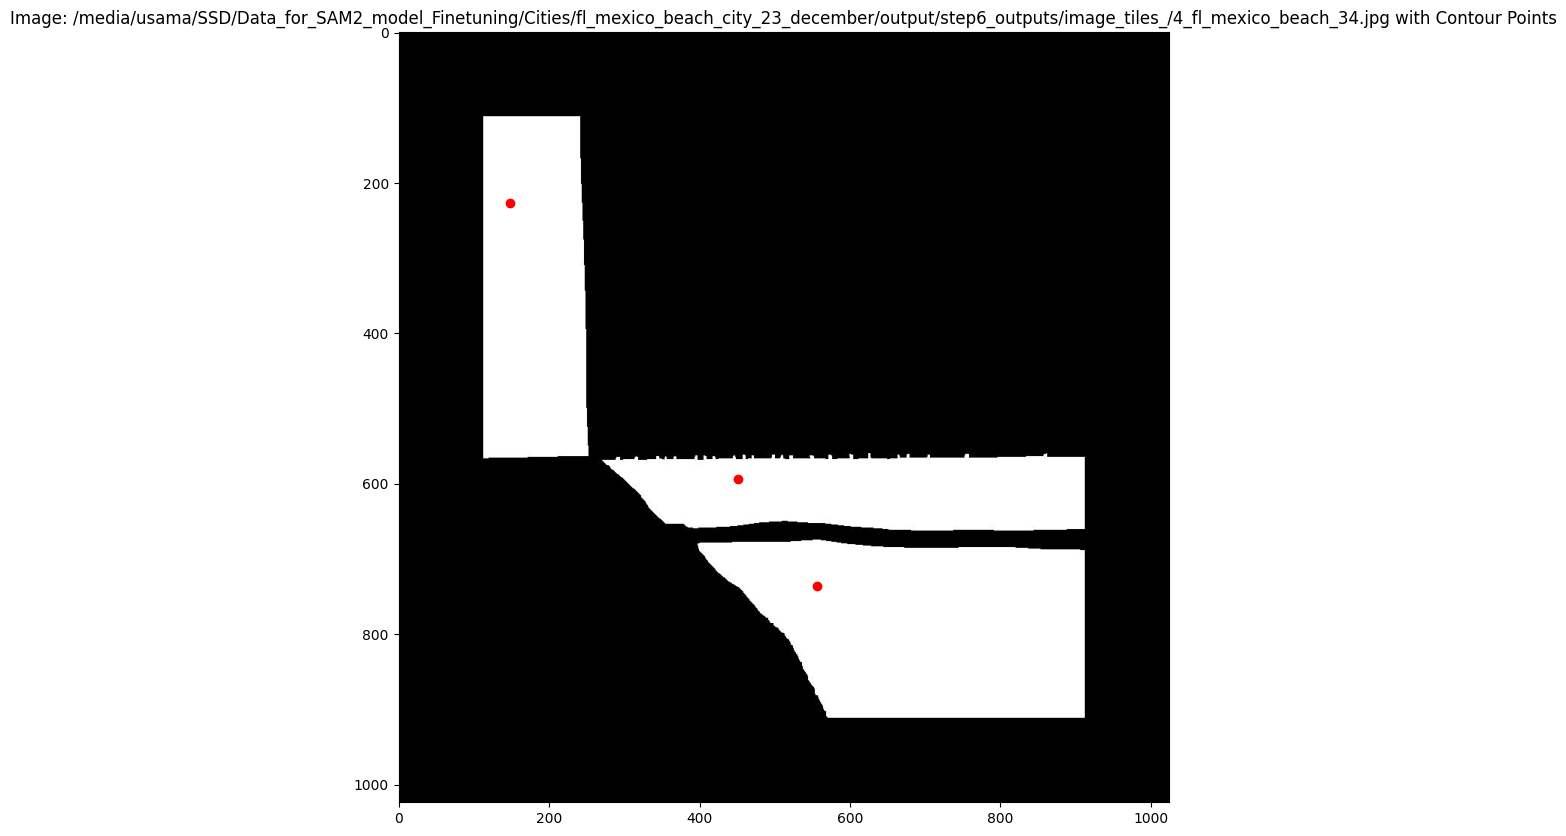

scale 1.0
points [[(248.25, 612.5), (509.75, 651.0), (248.25, 821.5), (582.0, 822.0)]]
copy image path test_data_sam2_24_22_december/images/4_fl_mexico_beach_35_copy0.jpg
point pairs [(248, 612)]


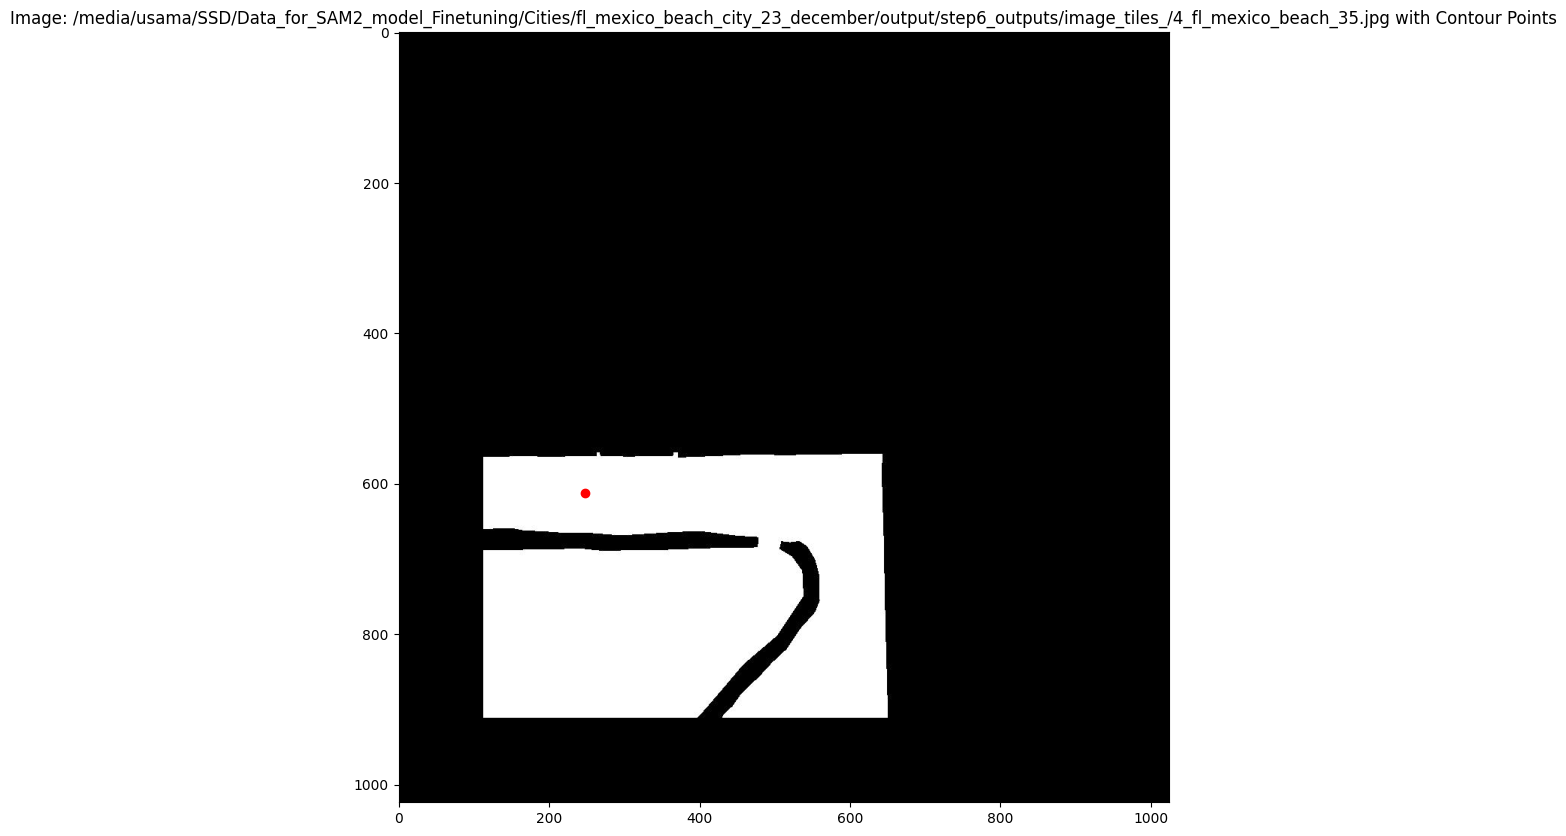

scale 1.0
points [[(313.75, 823.5), (709.25, 823.0), (313.75, 878.5), (709.25, 878.5)]]
copy image path test_data_sam2_24_22_december/images/4_fl_mexico_beach_4_copy0.jpg
point pairs [(313, 823)]


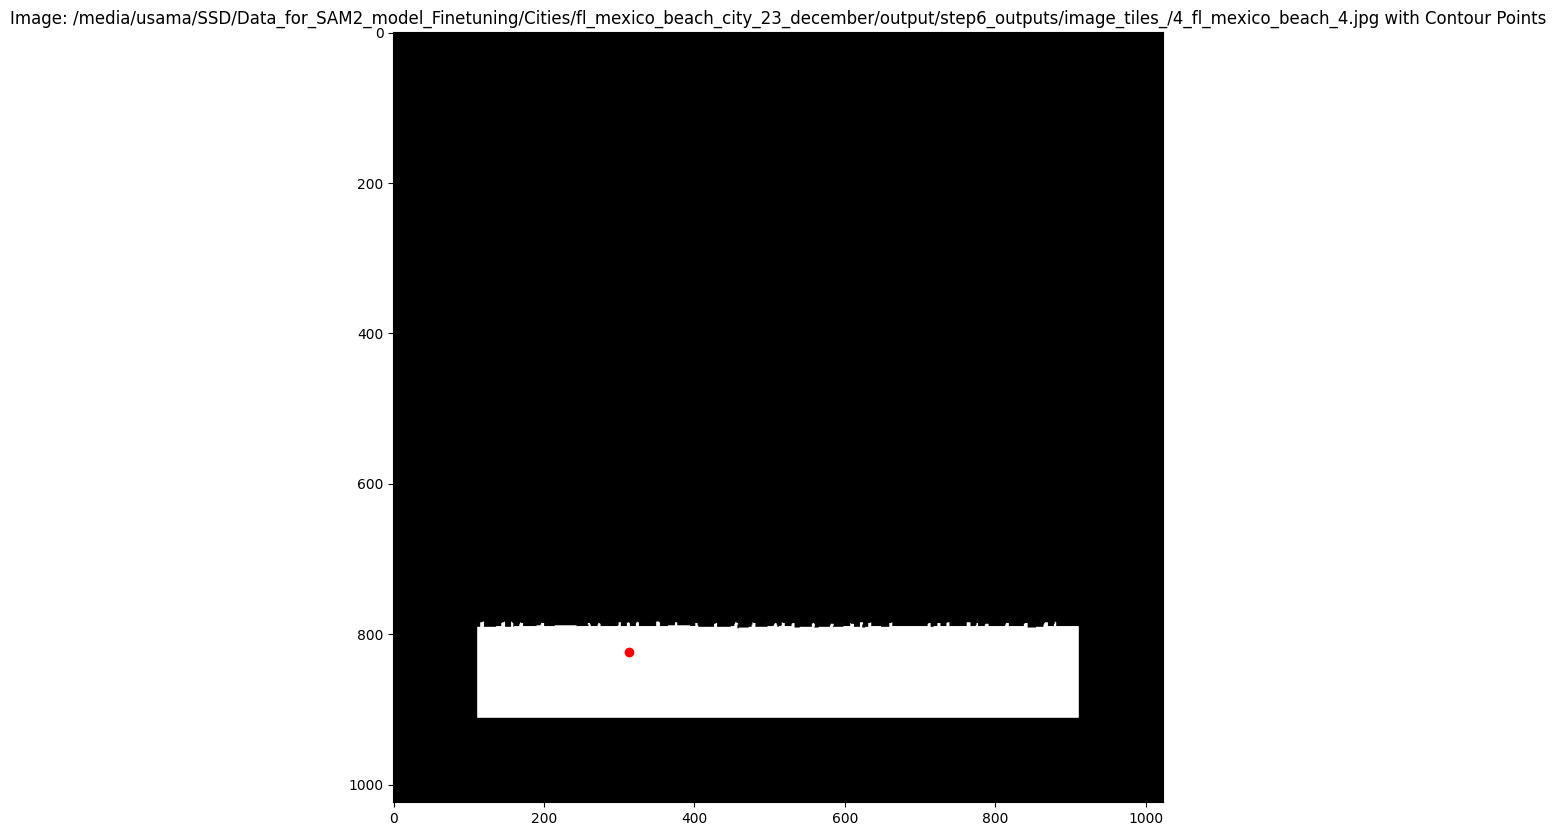

scale 1.0
length of tmp_pts 2
points [[(894.5, 530.5), (897.25, 523.0)], [(825.0, 210.0), (684.5, 209.5)]]
copy image path test_data_sam2_24_22_december/images/4_fl_mexico_beach_48_copy0.jpg
point pairs [(894, 530), (825, 210)]


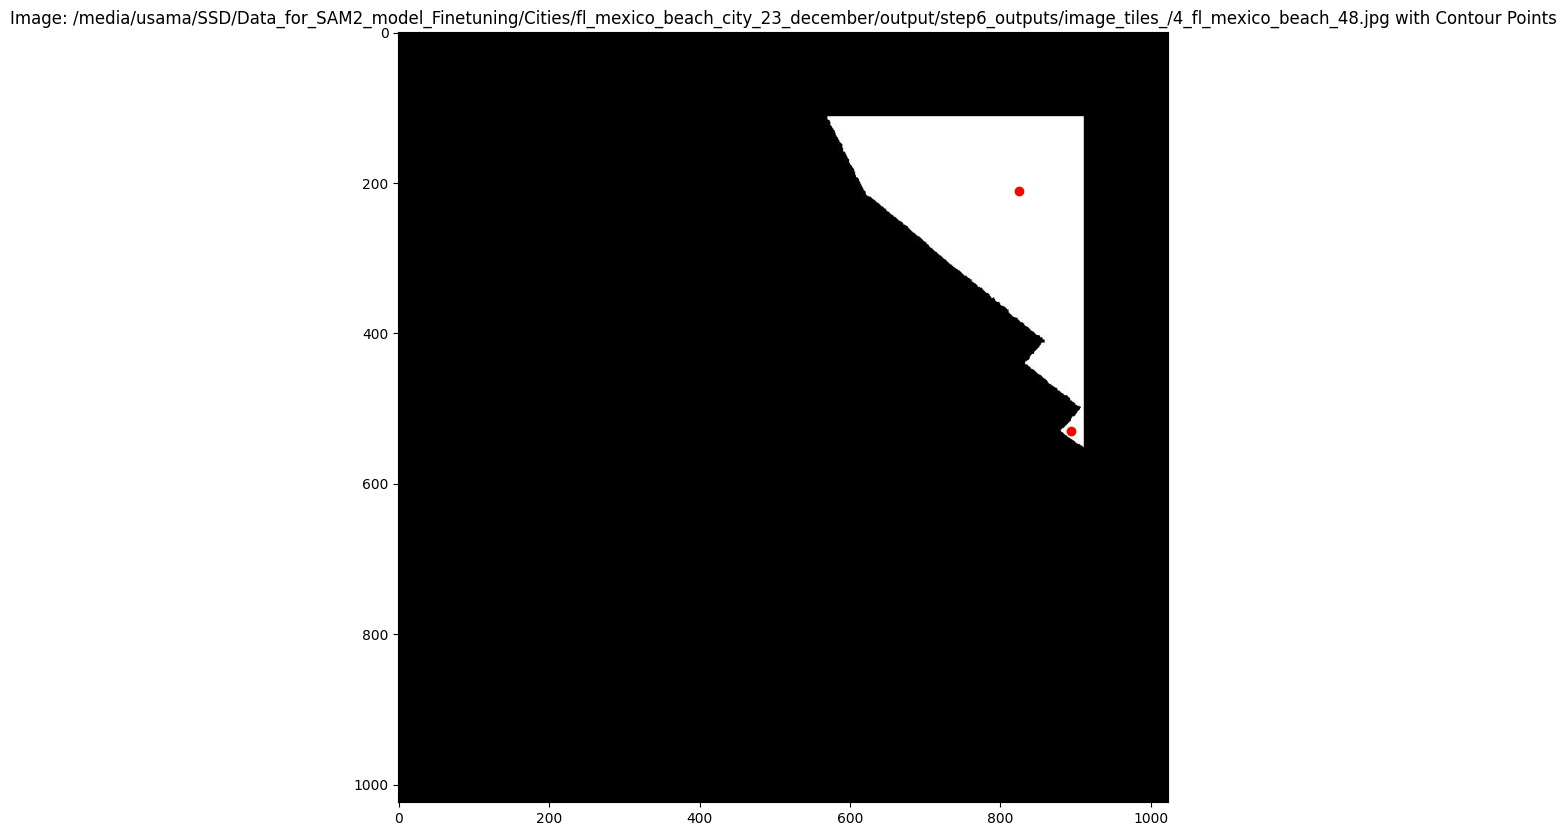

scale 1.0
representative point after area is less than 200 [[(390.25, 319.0), (565.75, 323.0), (415.0, 603.5), (578.5, 709.0)], [(479.5, 752.5)]]
representative point after area is less than 200 [[(390.25, 319.0), (565.75, 323.0), (415.0, 603.5), (578.5, 709.0)], [(479.5, 752.5)], [(456.0, 735.5)]]
length of tmp_pts 1
points [[(390.25, 319.0), (565.75, 323.0), (415.0, 603.5), (578.5, 709.0)], [(479.5, 752.5)], [(456.0, 735.5)], [(185.5, 258.75), (265.5, 258.0), (185.5, 473.25), (262.5, 522.0)]]
copy image path test_data_sam2_24_22_december/images/4_fl_mexico_beach_49_copy0.jpg
point pairs [(390, 319), (479, 752), (456, 735), (185, 258)]


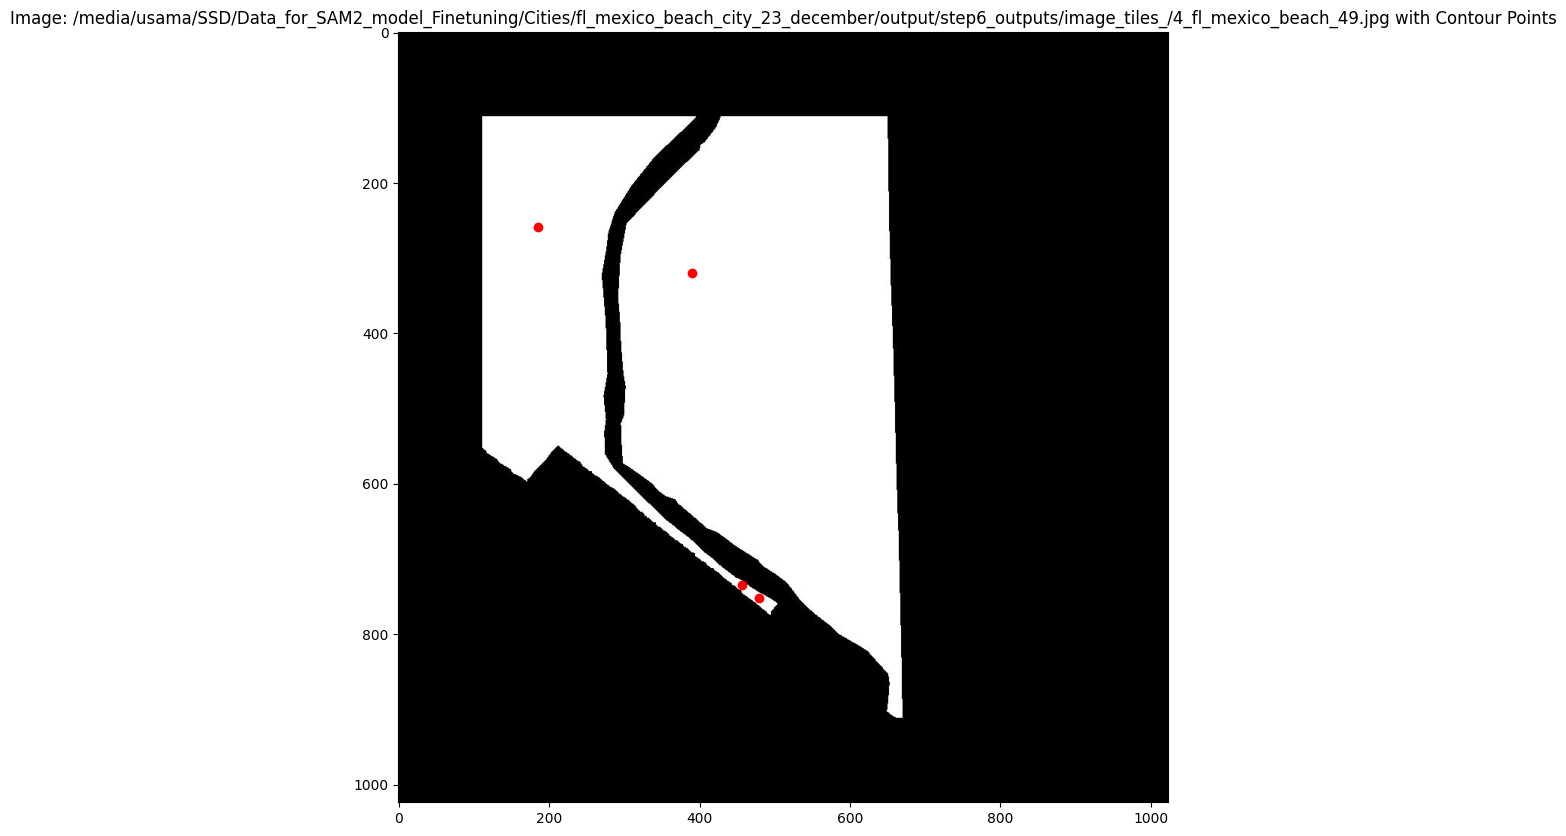

scale 1.0
points [[(313.75, 822.0), (709.25, 821.5), (313.75, 878.0), (709.25, 878.0)]]
copy image path test_data_sam2_24_22_december/images/4_fl_mexico_beach_5_copy0.jpg
point pairs [(313, 822)]


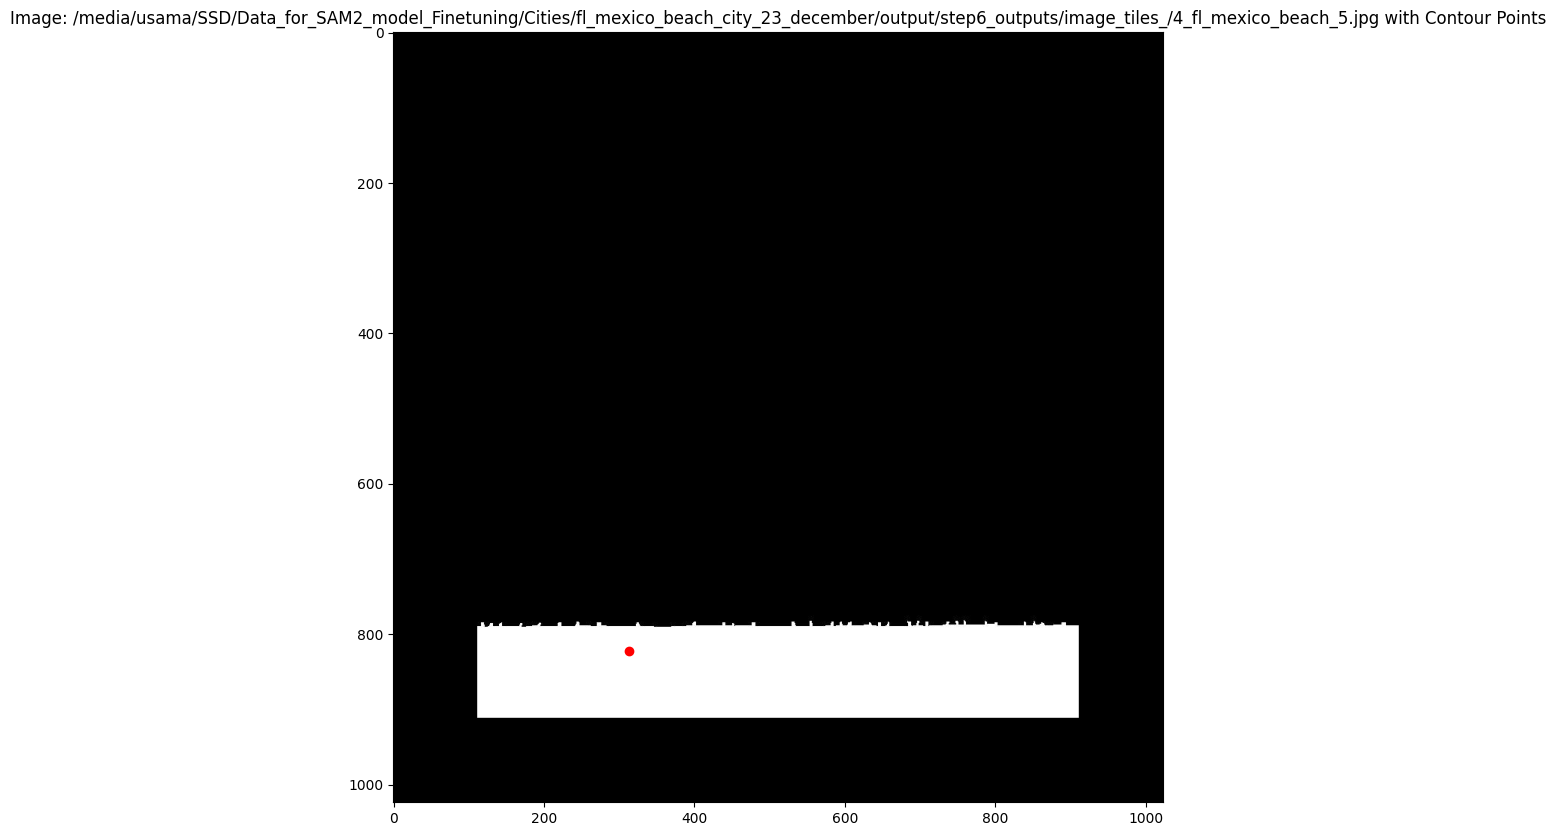

scale 1.0
points [[(140.5, 821.0), (189.0, 820.0), (140.5, 878.0), (189.0, 885.0)]]
copy image path test_data_sam2_24_22_december/images/4_fl_mexico_beach_6_copy0.jpg
point pairs [(140, 821)]


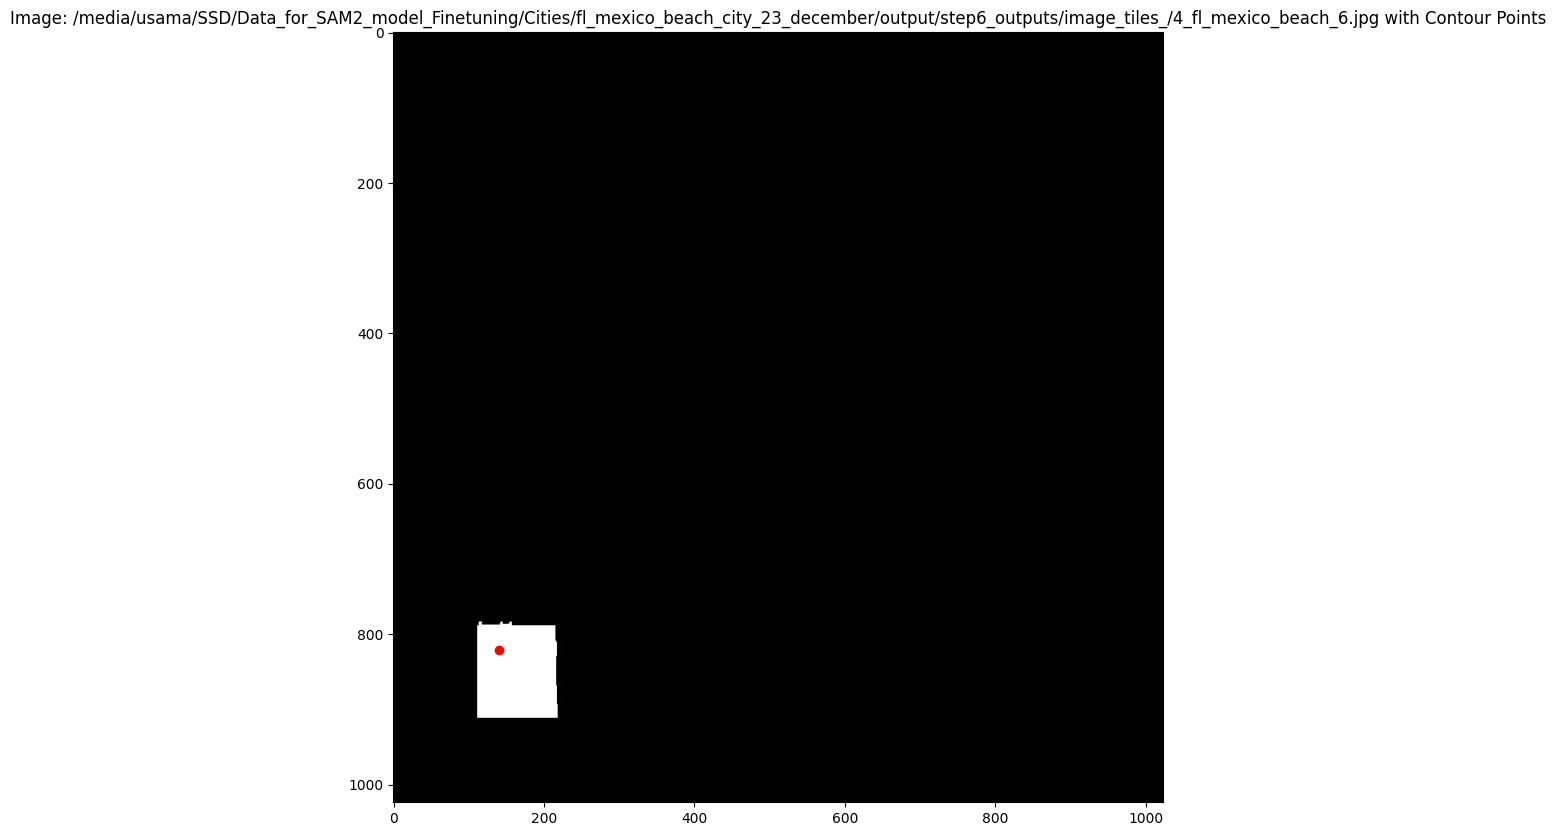

scale 1.0
representative point after area is less than 200 [[(667.0, 113.0)]]
points [[(667.0, 113.0)]]
copy image path test_data_sam2_24_22_december/images/4_fl_mexico_beach_63_copy0.jpg
point pairs [(667, 113)]


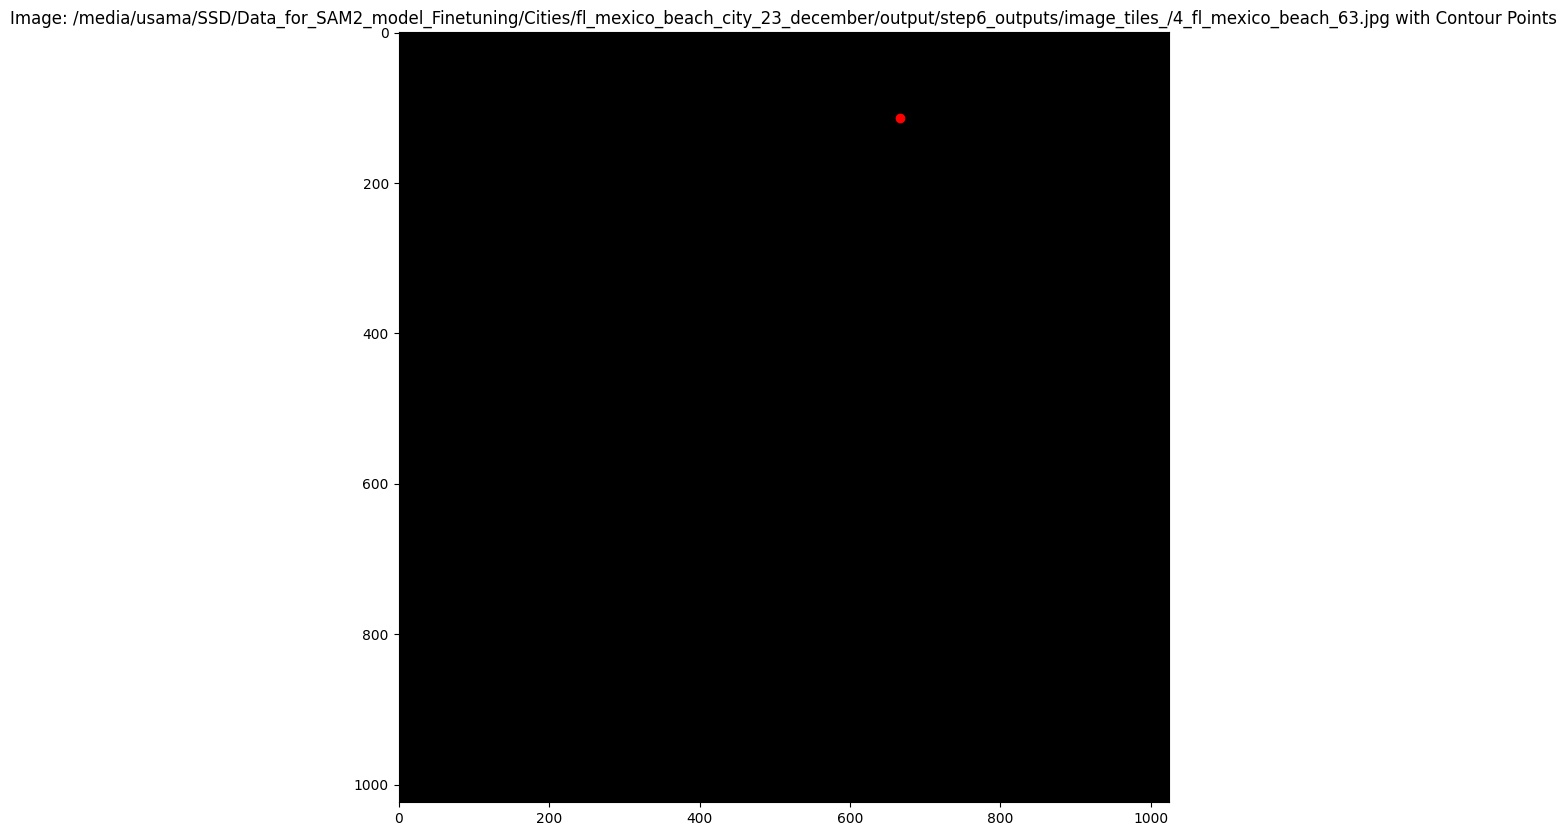

scale 1.0
representative point after area is less than 200 [[(493.625, 337.25), (543.75, 312.0), (474.0, 377.5), (516.25, 369.0)], [(448.5, 288.0), (496.0, 270.0), (422.0, 343.5), (472.0, 319.0)], [(395.25, 233.0), (440.5, 216.5), (366.5, 290.5), (408.625, 281.25)], [(350.75, 182.5), (393.0, 175.0), (319.5, 247.5), (371.0, 220.0)], [(443.75, 117.5)]]
points [[(493.625, 337.25), (543.75, 312.0), (474.0, 377.5), (516.25, 369.0)], [(448.5, 288.0), (496.0, 270.0), (422.0, 343.5), (472.0, 319.0)], [(395.25, 233.0), (440.5, 216.5), (366.5, 290.5), (408.625, 281.25)], [(350.75, 182.5), (393.0, 175.0), (319.5, 247.5), (371.0, 220.0)], [(443.75, 117.5)], [(300.25, 123.0), (346.25, 125.5), (314.5, 150.5), (332.0, 152.5)], [(196.0, 143.5), (244.5, 142.5), (218.75, 185.0), (256.5, 201.0)]]
copy image path test_data_sam2_24_22_december/images/5_fl_mexico_beach_109_copy0.jpg
point pairs [(493, 337), (448, 288), (395, 233), (350, 182), (443, 117), (300, 123), (196, 143)]


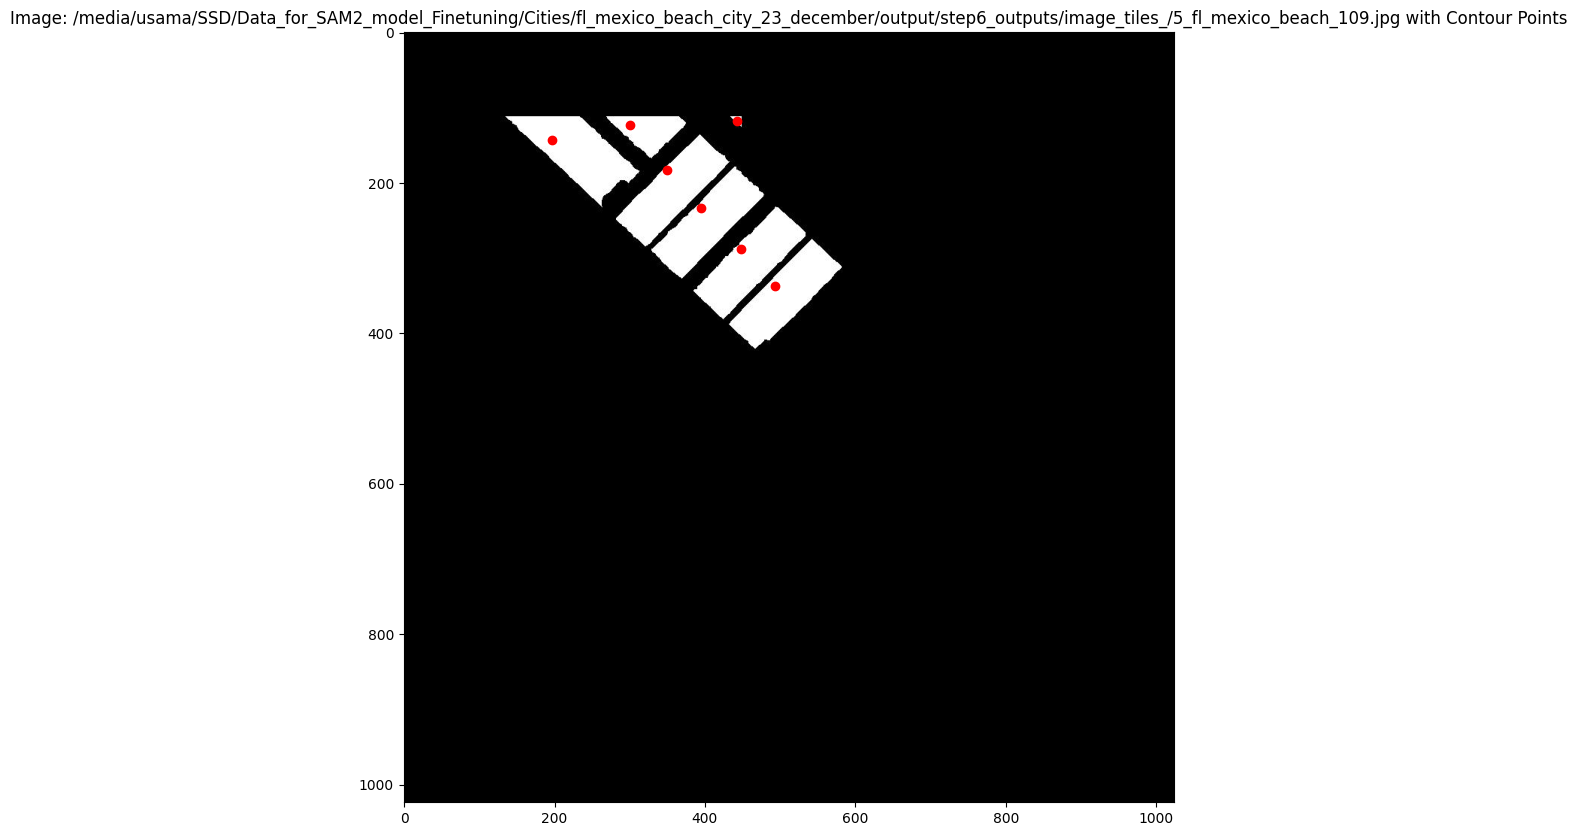

scale 1.0
points [[(604.0, 293.5), (648.25, 305.0), (623.0, 379.5), (698.5, 365.5)]]
copy image path test_data_sam2_24_22_december/images/5_fl_mexico_beach_48_copy0.jpg
point pairs [(604, 293)]


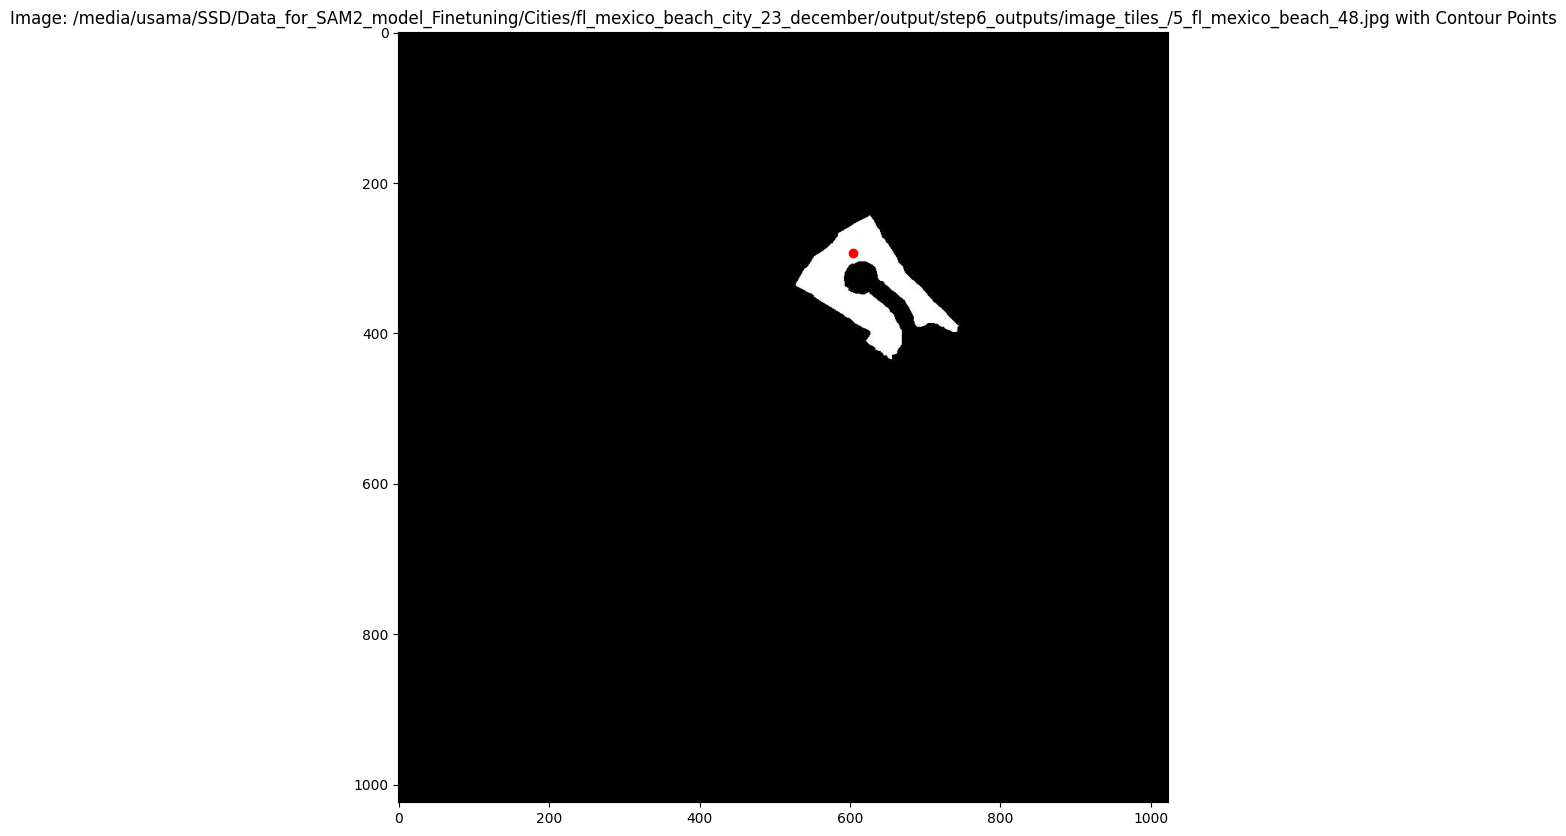

scale 1.0
points [[(822.5, 820.5), (859.0, 834.0), (836.0, 867.0), (877.0, 877.0)], [(869.75, 755.5), (892.5, 759.5), (875.25, 787.5), (895.75, 798.5)], [(890.0, 625.5), (899.5, 625.75), (888.0, 641.0), (903.25, 655.5)], [(859.75, 543.5), (892.25, 522.5), (848.75, 565.5), (872.75, 569.5)]]
copy image path test_data_sam2_24_22_december/images/5_fl_mexico_beach_79_copy0.jpg
point pairs [(822, 820), (869, 755), (890, 625), (859, 543)]


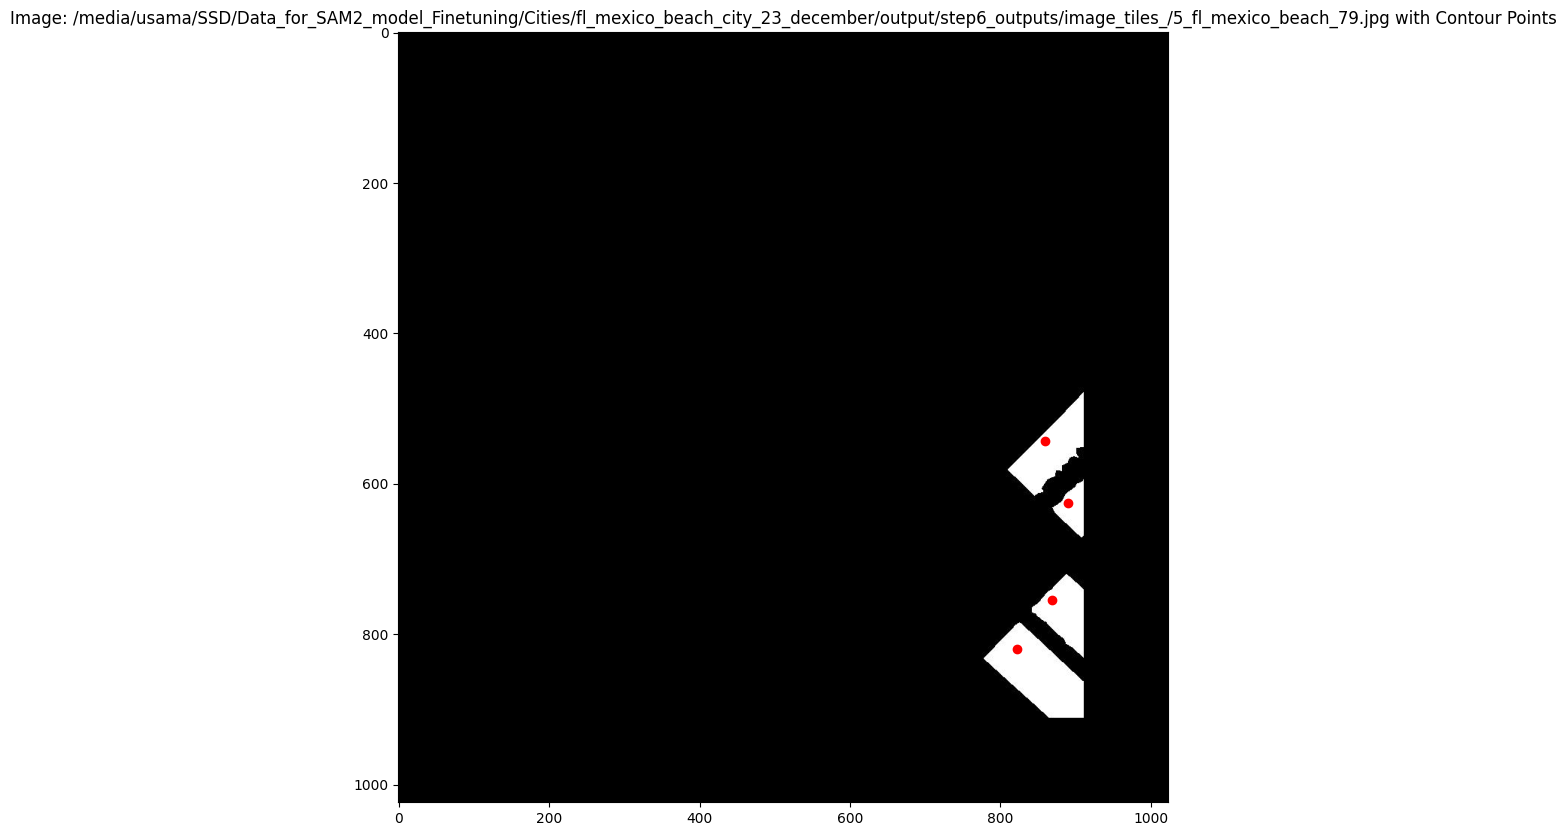

scale 1.0
representative point after area is less than 200 [[(287.5, 907.0)]]
points [[(287.5, 907.0)], [(644.375, 897.75), (648.625, 895.75), (640.0, 906.5), (653.75, 905.0)], [(117.0, 873.0), (137.75, 887.0), (124.75, 899.25), (143.5, 898.5)], [(530.875, 848.25), (562.5, 834.0), (517.875, 874.25), (582.0, 887.0)], [(134.75, 783.5), (192.0, 817.0), (170.75, 869.5), (219.25, 867.5)], [(416.25, 791.0), (473.75, 773.0), (384.0, 856.5), (454.125, 856.25)], [(321.625, 713.75), (381.5, 697.0), (294.0, 800.0), (356.0, 787.0)], [(222.5, 608.0), (285.5, 600.0), (192.5, 707.0), (258.25, 697.5)], [(168.75, 545.5), (211.0, 538.0), (133.75, 625.5), (186.25, 589.5)], [(134.0, 471.5), (162.5, 456.5), (124.75, 520.5), (159.75, 498.0)], [(251.0, 465.5), (341.0, 527.0), (329.0, 564.0), (414.0, 616.5)]]
copy image path test_data_sam2_24_22_december/images/5_fl_mexico_beach_80_copy0.jpg
point pairs [(287, 907), (644, 897), (117, 873), (530, 848), (134, 783), (416, 791), (321, 713), (222, 608), (168, 545)

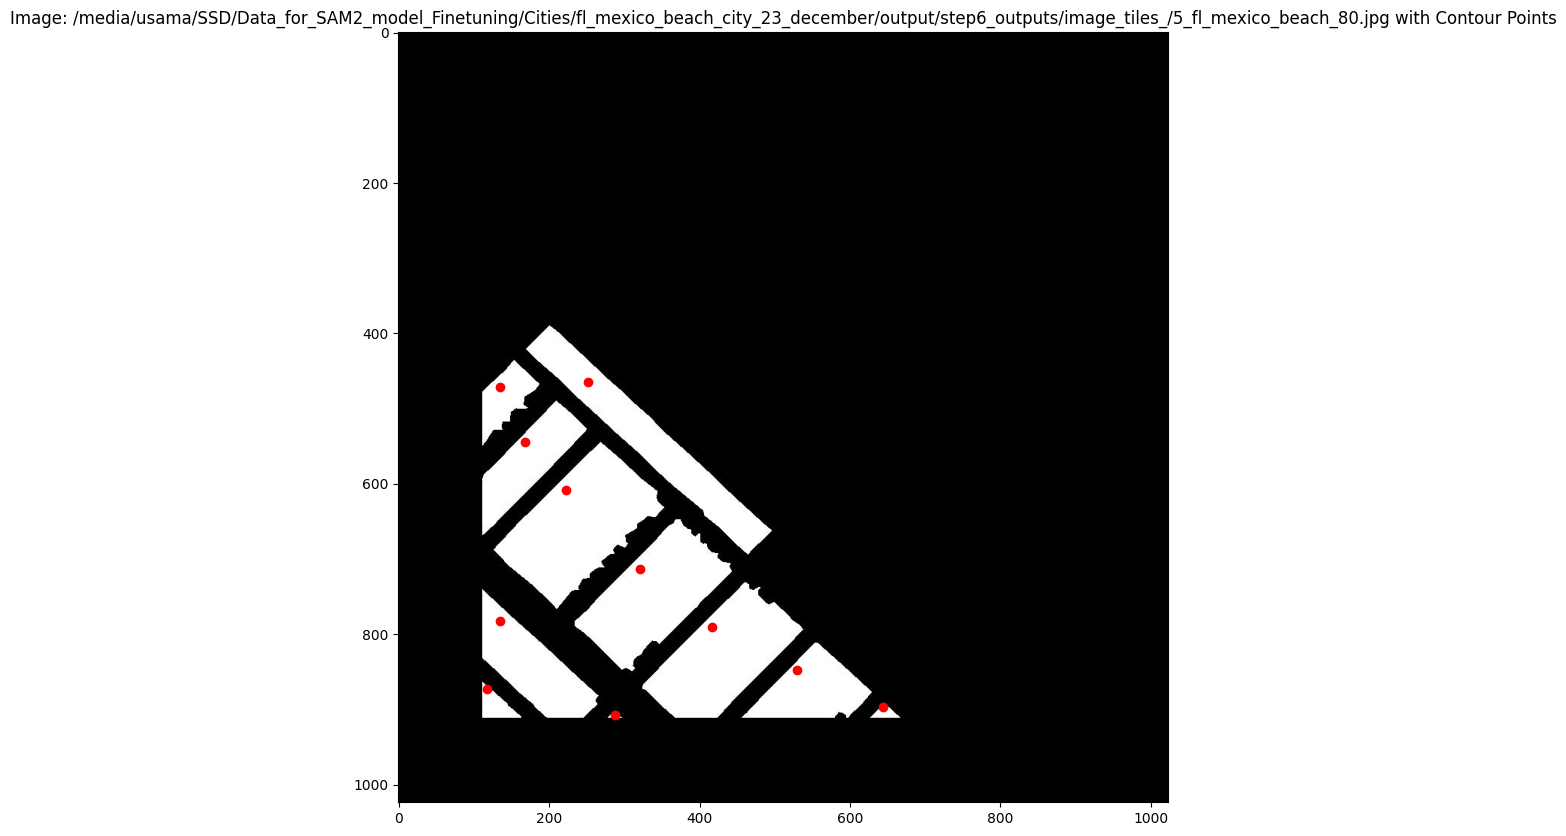

scale 1.0
points [[(252.75, 839.0), (292.375, 820.25), (231.0, 885.5), (296.75, 883.5)], [(354.75, 743.0), (397.25, 728.75), (367.0, 811.5), (398.5, 860.0)]]
copy image path test_data_sam2_24_22_december/images/5_fl_mexico_beach_81_copy0.jpg
point pairs [(252, 839), (354, 743)]


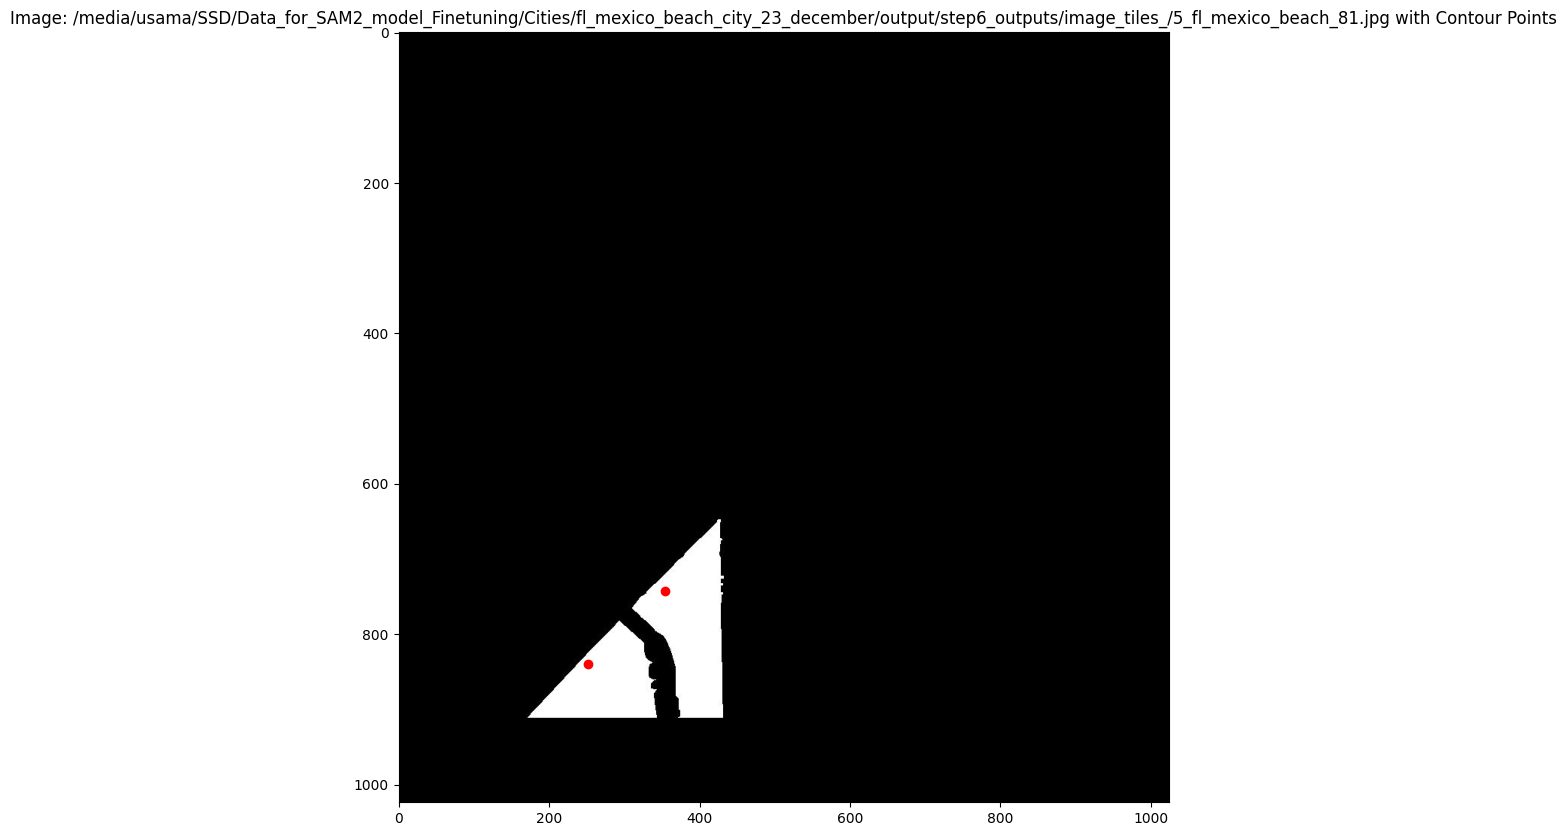

scale 1.0
points [[(889.5, 123.5), (899.75, 122.5), (892.375, 129.25), (904.0, 137.0)]]
copy image path test_data_sam2_24_22_december/images/5_fl_mexico_beach_93_copy0.jpg
point pairs [(889, 123)]


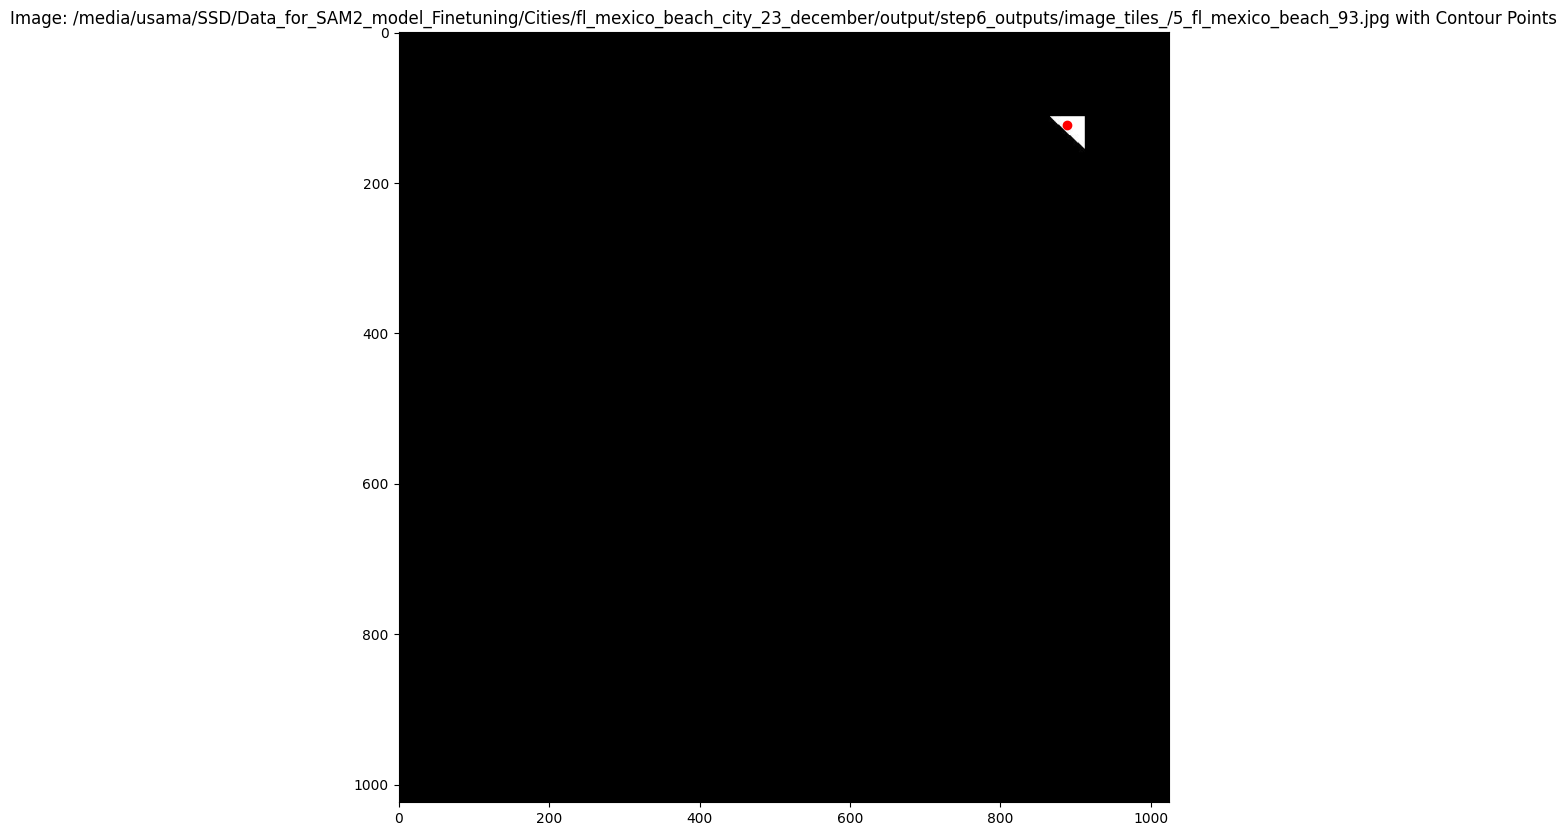

scale 1.0
representative point after area is less than 200 [[(908.0, 883.0)]]
representative point after area is less than 200 [[(908.0, 883.0)], [(772.5, 720.0), (836.0, 745.5), (807.5, 783.5), (872.25, 816.5)], [(822.0, 635.5), (865.25, 649.0), (843.0, 698.5), (886.5, 720.0)], [(883.75, 557.5), (905.5, 536.0), (883.0, 579.5), (900.0, 579.0)], [(591.75, 547.25), (657.5, 576.5), (630.5, 618.5), (690.0, 642.5)], [(654.5, 484.0), (721.25, 511.5), (696.5, 557.0), (763.0, 581.5)], [(838.25, 428.5), (889.5, 392.0), (819.5, 504.0), (873.75, 499.5)], [(409.25, 380.5), (475.25, 409.0), (443.375, 441.25), (512.25, 476.25)], [(472.5, 316.5), (558.75, 358.5), (512.75, 387.0), (579.75, 414.5)], [(778.0, 325.0), (835.0, 304.0), (744.25, 411.5), (809.0, 390.0)], [(863.75, 239.5), (889.75, 236.5), (873.75, 266.5), (899.75, 283.5)], [(685.5, 247.5), (747.0, 226.5), (657.0, 335.5), (719.75, 319.0)], [(909.5, 174.5)]]
Error creating polygon: A linearring requires at least 4 coordinates.
points [[(908.0,

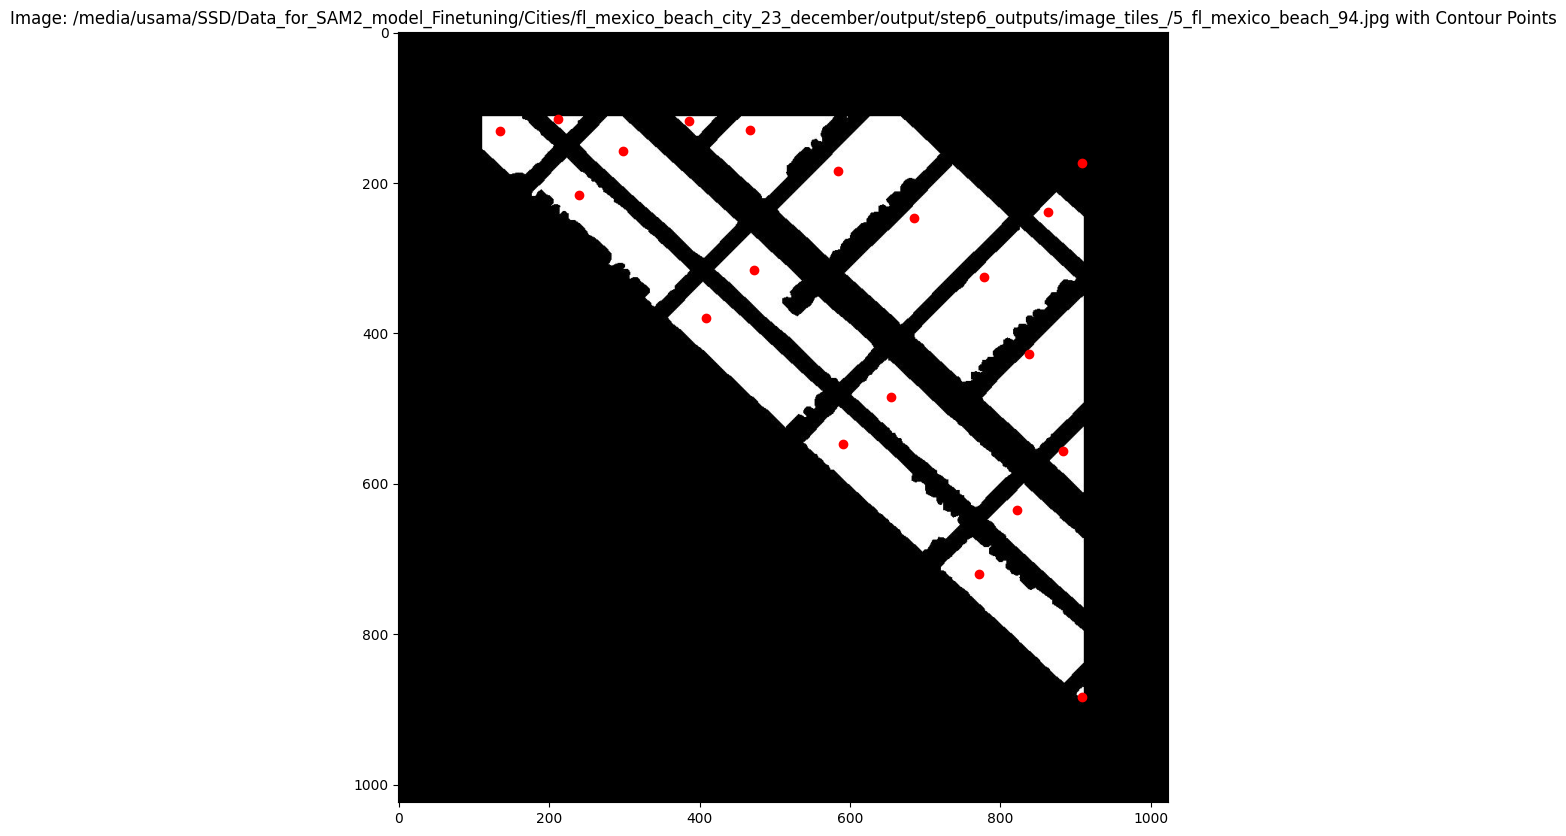

scale 1.0
representative point after area is less than 200 [[(149.0, 857.25), (170.75, 867.0), (145.25, 893.0), (184.75, 890.0)], [(119.25, 817.5)]]
points [[(149.0, 857.25), (170.75, 867.0), (145.25, 893.0), (184.75, 890.0)], [(119.25, 817.5)], [(215.25, 810.5), (267.25, 833.0), (245.0, 866.5), (289.25, 874.0)], [(383.5, 795.0), (418.0, 773.0), (381.25, 843.5), (417.0, 859.5)], [(129.5, 712.0), (153.0, 723.5), (137.75, 771.0), (160.0, 760.5)], [(334.75, 669.5), (392.0, 659.0), (305.25, 743.5), (360.5, 730.0)], [(244.0, 594.5), (309.0, 565.5), (219.25, 661.0), (276.25, 656.0)], [(172.25, 489.5), (225.25, 480.0), (146.5, 577.0), (201.25, 544.5)], [(132.75, 397.25), (160.0, 399.5), (131.625, 447.75), (158.0, 427.5)], [(183.5, 341.5), (284.25, 420.0), (269.25, 436.0), (370.0, 512.5)], [(203.5, 232.5), (280.25, 286.5), (268.375, 310.75), (370.0, 385.5)], [(257.5, 180.0), (362.0, 207.0), (295.25, 248.5), (392.5, 306.0)]]
copy image path test_data_sam2_24_22_december/images/5_fl_mexico_beach

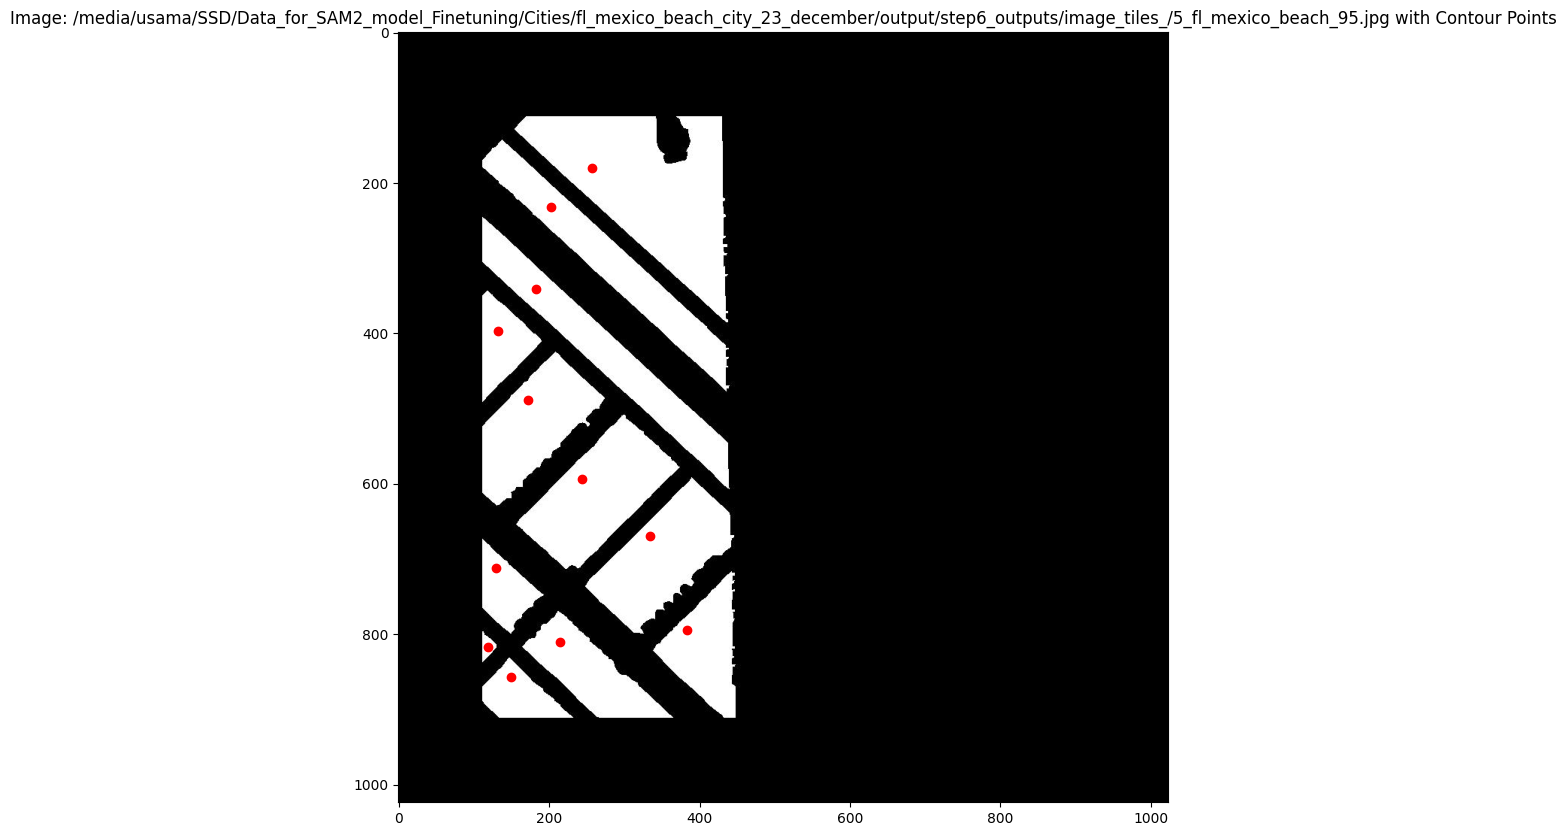

scale 1.0
points [[(903.75, 841.5), (891.25, 885.5), (900.75, 876.75)], [(816.25, 802.0), (852.75, 802.0), (806.0, 872.5), (842.5, 872.5)], [(756.0, 754.0), (849.75, 720.0), (720.0, 856.0)], [(623.75, 751.5), (646.0, 716.0), (603.75, 843.5), (630.0, 788.0)], [(770.5, 591.5), (861.5, 591.0), (771.0, 613.0), (861.5, 608.0)]]
copy image path test_data_sam2_24_22_december/images/6_fl_mexico_beach_32_copy0.jpg
point pairs [(903, 841), (816, 802), (756, 754), (623, 751), (770, 591)]


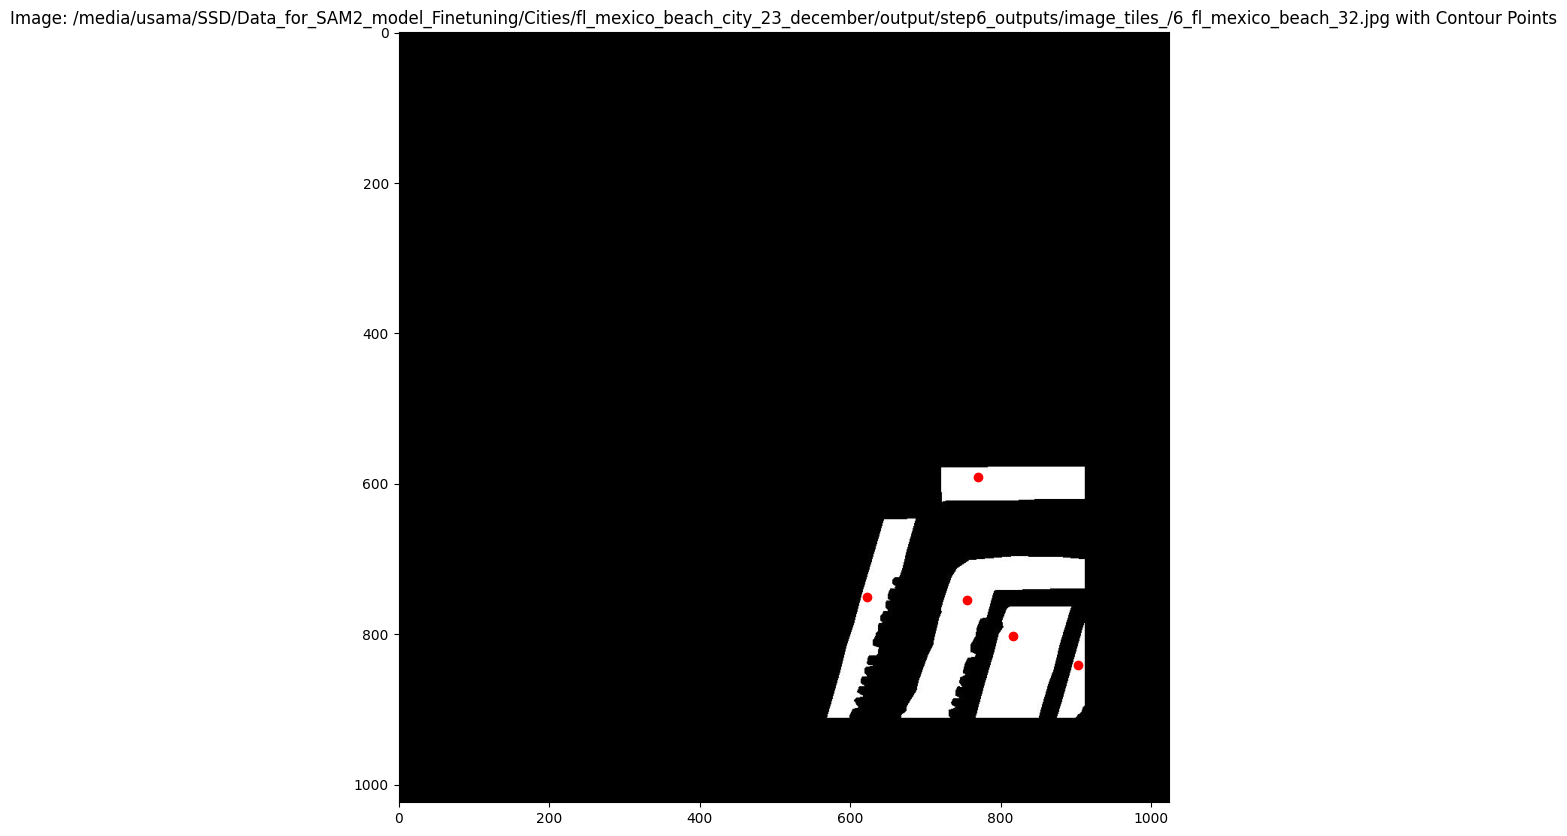

scale 1.0
points [[(558.0, 891.5), (568.0, 894.0), (555.75, 901.5), (575.25, 901.5)], [(336.25, 831.5), (371.5, 823.5), (320.25, 879.5), (356.75, 878.0)], [(469.0, 823.0), (516.0, 822.5), (452.0, 875.0), (492.75, 878.5)], [(221.5, 819.5), (263.5, 807.0), (203.75, 872.5), (241.0, 867.5)], [(138.75, 801.25), (172.25, 788.0), (125.0, 851.0)], [(149.25, 712.5), (213.75, 711.5), (149.25, 726.5), (208.75, 726.0)], [(125.75, 590.5), (145.25, 590.5), (125.75, 607.5), (145.25, 607.5)]]
copy image path test_data_sam2_24_22_december/images/6_fl_mexico_beach_33_copy0.jpg
point pairs [(558, 891), (336, 831), (469, 823), (221, 819), (138, 801), (149, 712), (125, 590)]


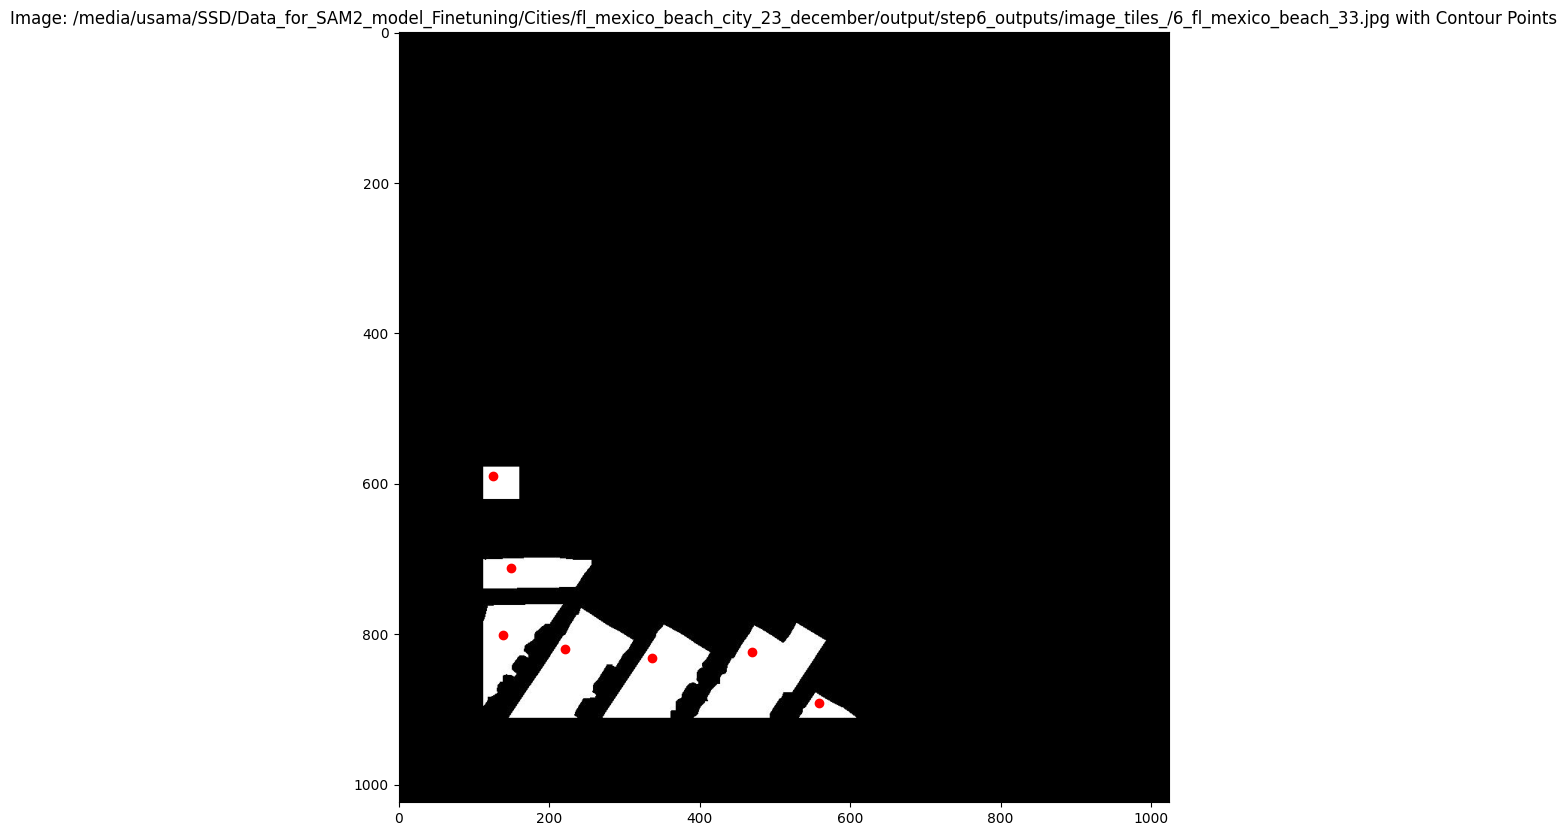

scale 1.0
points [[(891.5, 202.0), (902.5, 191.5), (887.0, 216.0), (899.5, 216.0)], [(874.25, 138.5), (885.5, 134.5), (866.0, 170.5), (877.75, 157.0)], [(779.25, 138.5), (816.0, 138.5), (772.75, 182.0), (809.25, 184.0)], [(679.0, 134.0), (701.0, 136.5), (674.75, 170.5), (696.5, 172.0)], [(550.75, 205.0), (571.5, 174.0), (538.0, 290.5), (558.75, 256.5)]]
copy image path test_data_sam2_24_22_december/images/6_fl_mexico_beach_46_copy0.jpg
point pairs [(891, 202), (874, 138), (779, 138), (679, 134), (550, 205)]


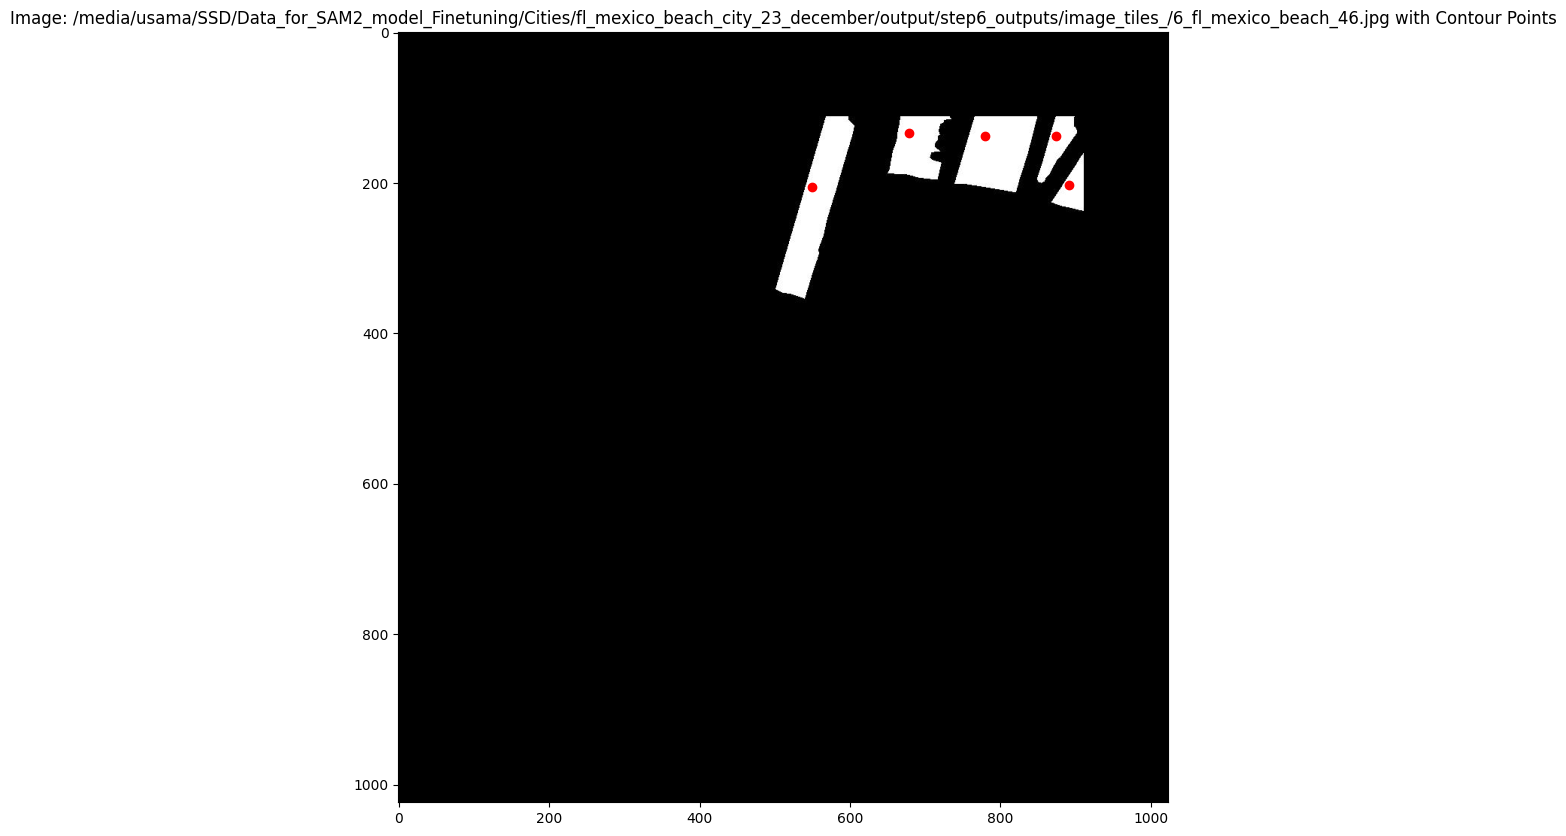

scale 1.0
points [[(862.5, 478.0), (894.25, 452.5), (848.5, 518.0), (886.5, 516.5)], [(806.25, 367.5), (862.0, 336.0), (777.75, 453.0), (829.0, 439.5)], [(702.75, 300.0), (768.25, 241.5), (671.75, 387.5), (725.75, 363.0)], [(588.5, 248.5), (649.75, 220.0), (545.75, 336.5), (621.5, 308.5)], [(491.5, 199.5), (541.25, 173.0), (456.75, 297.5), (513.5, 265.5)], [(367.25, 179.0), (414.0, 165.5), (338.25, 266.0), (391.75, 246.0)], [(254.5, 161.0), (296.0, 148.0), (230.75, 231.5), (274.5, 224.5)], [(147.75, 147.5), (186.25, 148.0), (141.75, 195.25), (173.0, 196.5)]]
copy image path test_data_sam2_24_22_december/images/6_fl_mexico_beach_47_copy0.jpg
point pairs [(862, 478), (806, 367), (702, 300), (588, 248), (491, 199), (367, 179), (254, 161), (147, 147)]


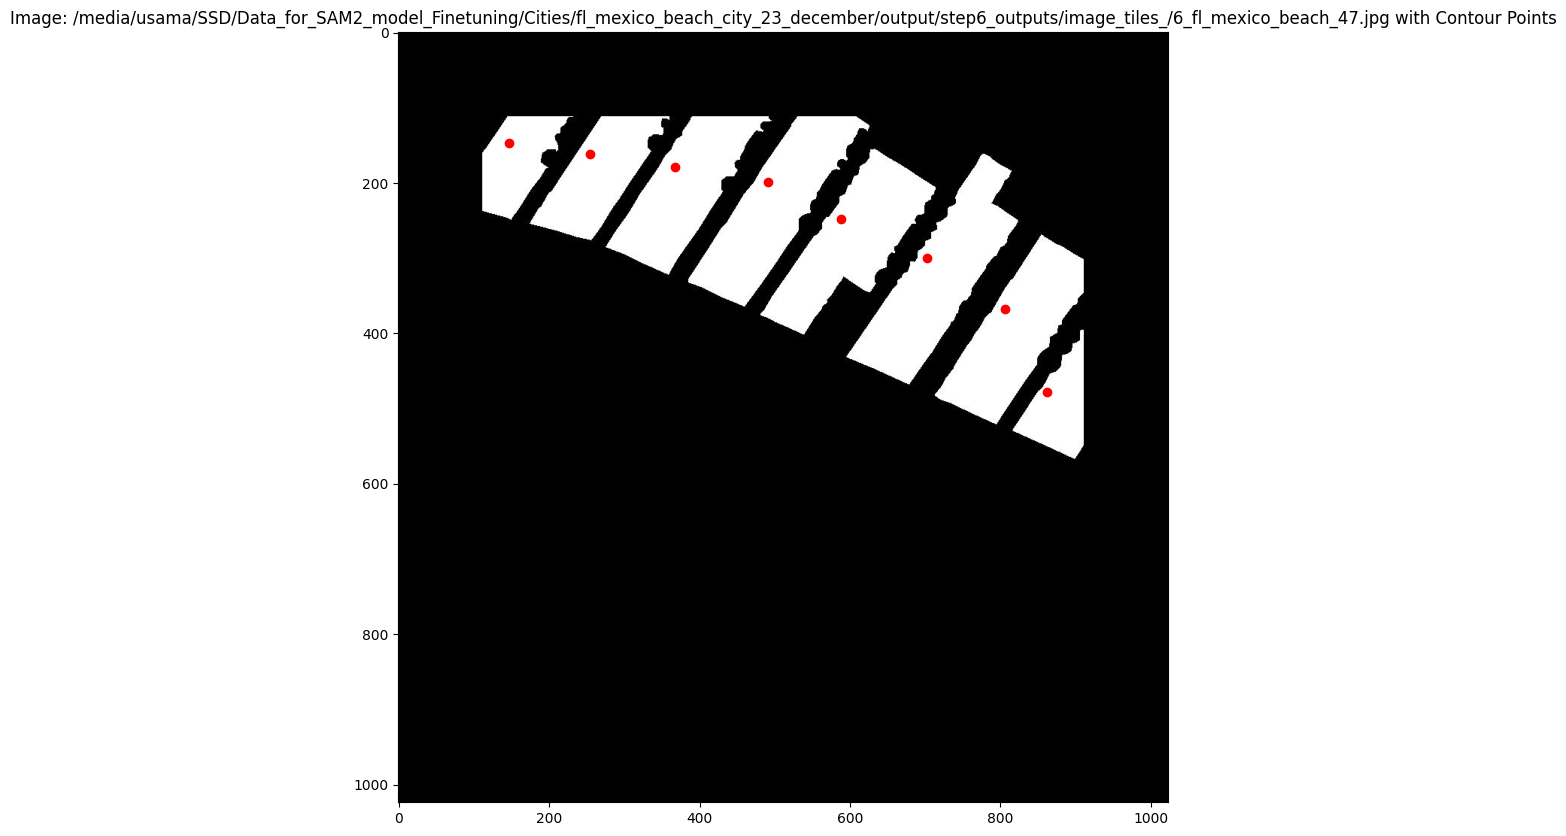

scale 1.0
representative point after area is less than 200 [[(823.25, 835.0), (864.5, 819.5), (801.25, 878.0), (850.75, 880.0)], [(726.5, 777.5), (780.25, 759.5), (694.75, 843.5), (749.75, 835.0)], [(630.75, 712.0), (687.0, 694.5), (596.25, 787.0), (654.0, 774.5)], [(526.75, 655.5), (583.75, 633.0), (492.25, 727.5), (553.75, 711.5)], [(427.5, 576.0), (492.5, 556.0), (393.75, 665.5), (450.75, 646.5)], [(317.75, 518.5), (373.75, 493.0), (282.5, 611.5), (339.25, 596.5)], [(214.25, 469.5), (273.0, 434.5), (181.75, 552.5), (237.75, 529.0)], [(117.5, 319.5)]]
points [[(823.25, 835.0), (864.5, 819.5), (801.25, 878.0), (850.75, 880.0)], [(726.5, 777.5), (780.25, 759.5), (694.75, 843.5), (749.75, 835.0)], [(630.75, 712.0), (687.0, 694.5), (596.25, 787.0), (654.0, 774.5)], [(526.75, 655.5), (583.75, 633.0), (492.25, 727.5), (553.75, 711.5)], [(427.5, 576.0), (492.5, 556.0), (393.75, 665.5), (450.75, 646.5)], [(317.75, 518.5), (373.75, 493.0), (282.5, 611.5), (339.25, 596.5)], [(214.25, 469.5), (

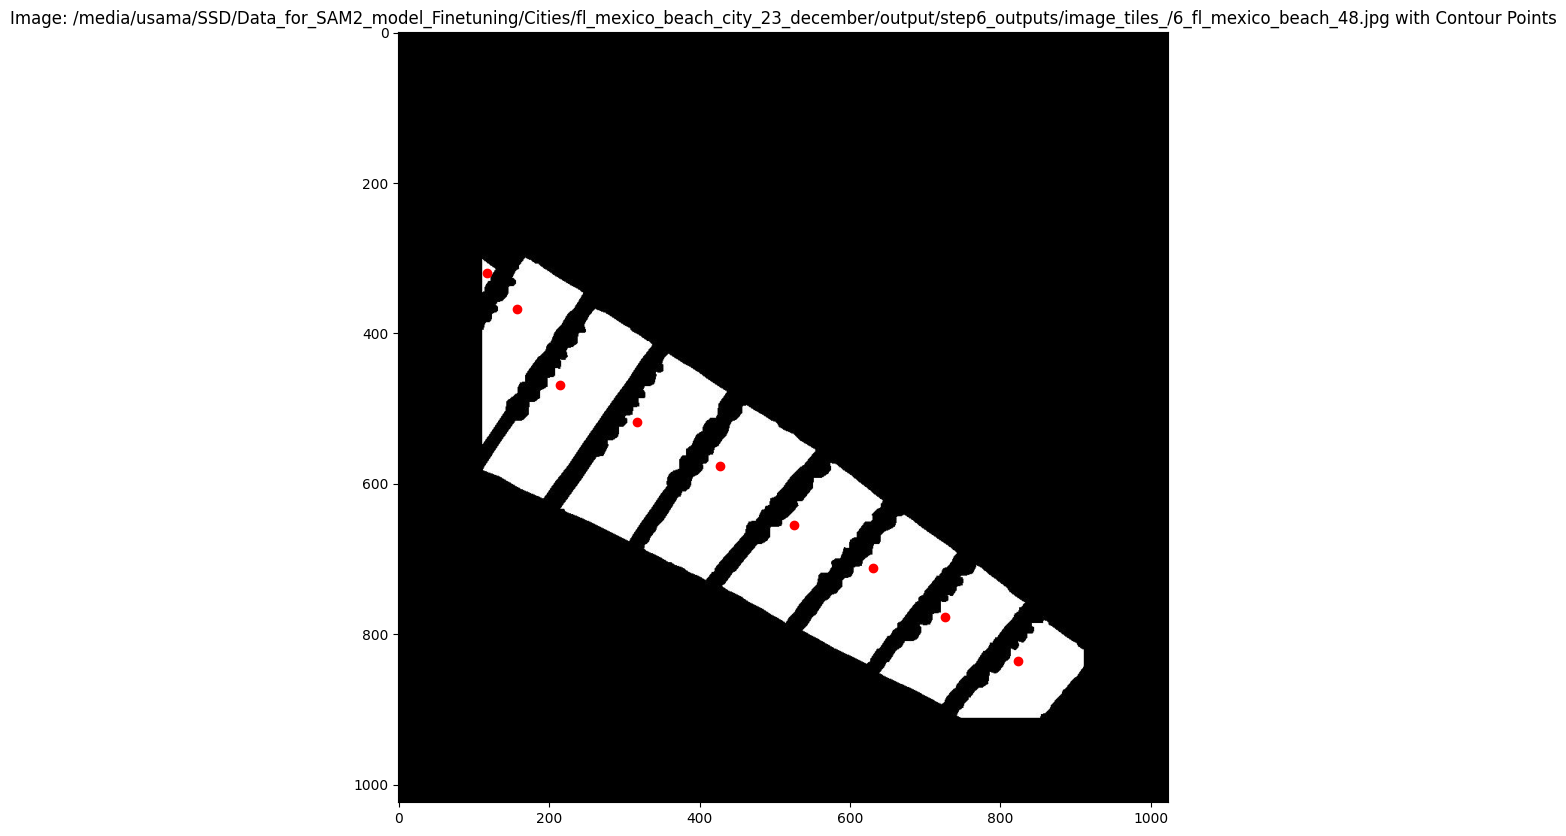

scale 1.0
representative point after area is less than 200 [[(114.5, 836.0)]]
points [[(114.5, 836.0)]]
copy image path test_data_sam2_24_22_december/images/6_fl_mexico_beach_49_copy0.jpg
point pairs [(114, 836)]


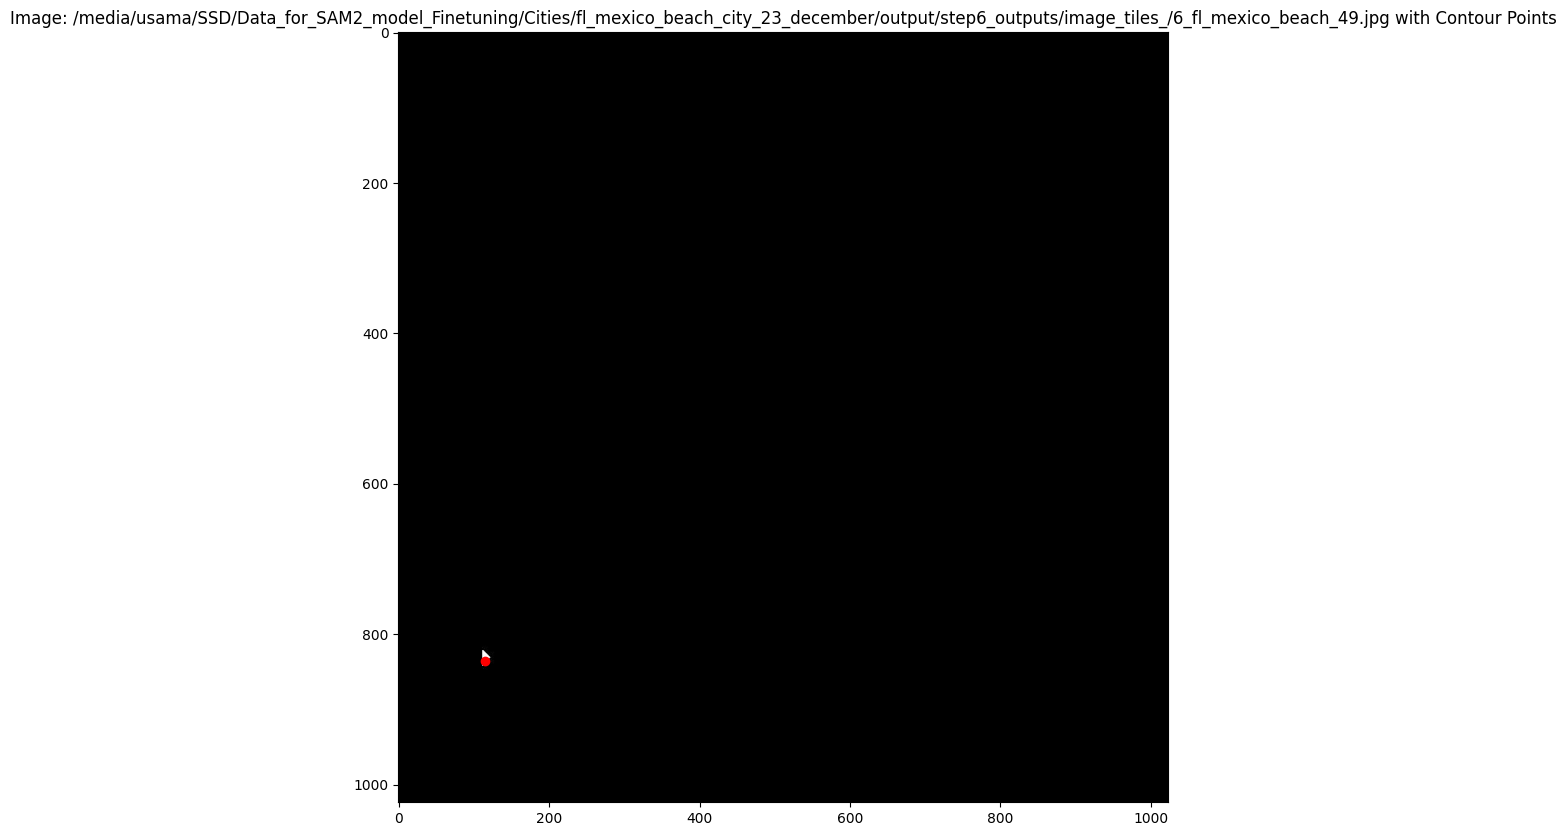

scale 1.0
points [[(794.75, 123.5), (821.75, 122.5), (803.0, 133.0), (816.0, 138.0)]]
copy image path test_data_sam2_24_22_december/images/6_fl_mexico_beach_62_copy0.jpg
point pairs [(794, 123)]


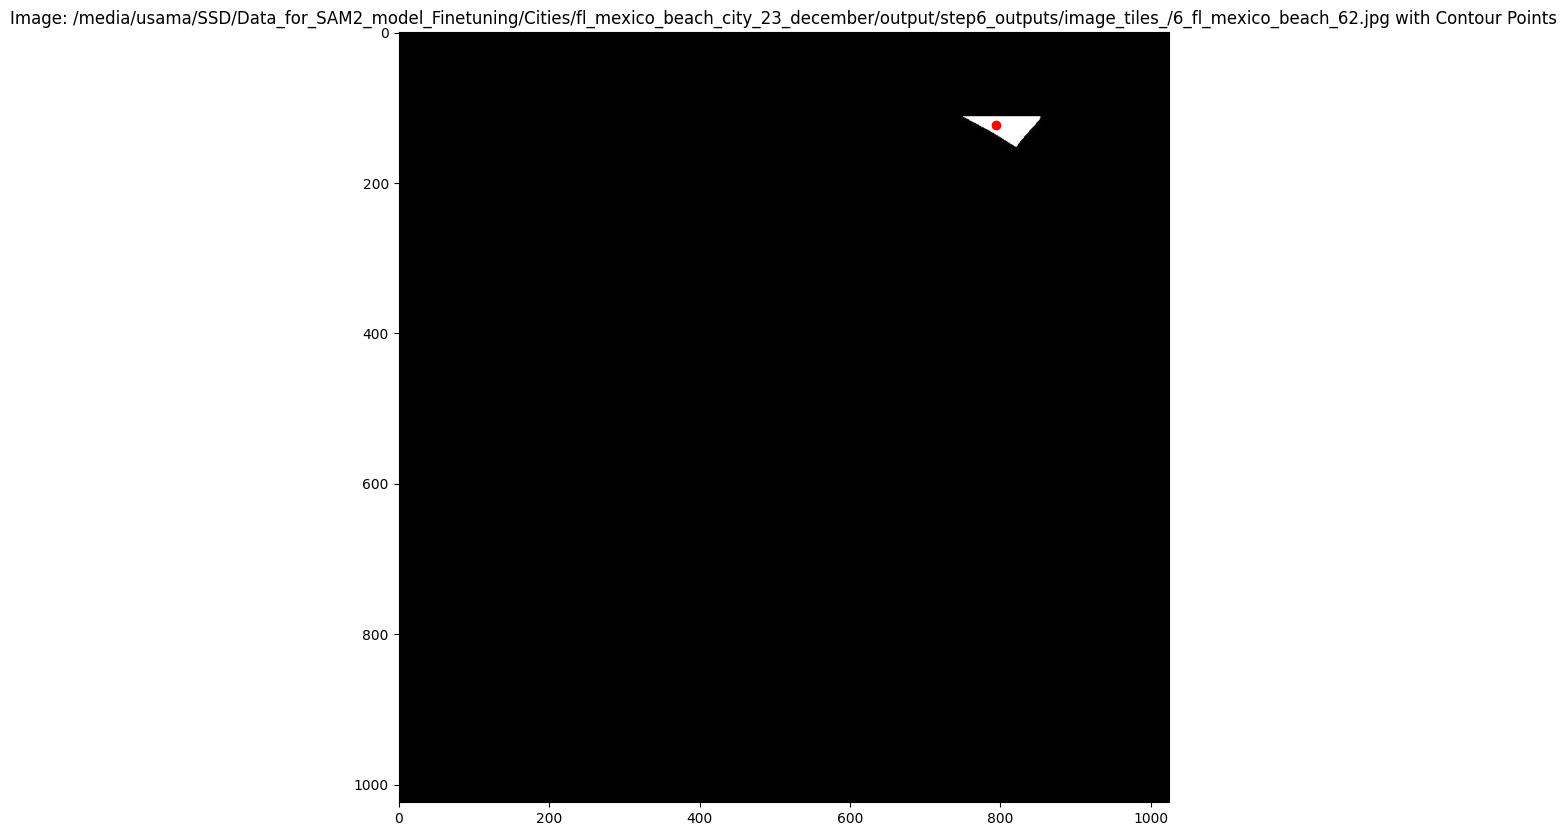

scale 1.0
points [[(833.25, 605.0), (867.5, 609.5), (840.5, 648.5), (882.5, 666.0)], [(875.25, 508.0), (890.25, 511.0), (880.5, 531.5), (897.625, 541.25)], [(795.25, 440.5), (818.25, 445.0), (805.5, 466.5), (830.75, 477.5)], [(639.25, 452.0), (673.25, 454.0), (635.5, 510.5), (677.0, 513.5)], [(579.0, 428.0), (595.5, 411.5), (565.5, 450.5), (583.0, 433.0)], [(750.75, 373.5), (771.5, 365.5), (738.0, 406.0), (759.5, 394.0)], [(414.25, 294.0), (474.25, 300.0), (426.25, 374.0), (493.0, 387.5)], [(299.25, 235.5), (333.75, 227.5), (283.5, 284.0), (320.5, 286.5)], [(209.25, 168.5), (248.25, 161.5), (189.25, 225.5), (232.0, 224.5)]]
copy image path test_data_sam2_24_22_december/images/6_fl_mexico_beach_63_copy0.jpg
point pairs [(833, 605), (875, 508), (795, 440), (639, 452), (579, 428), (750, 373), (414, 294), (299, 235), (209, 168)]


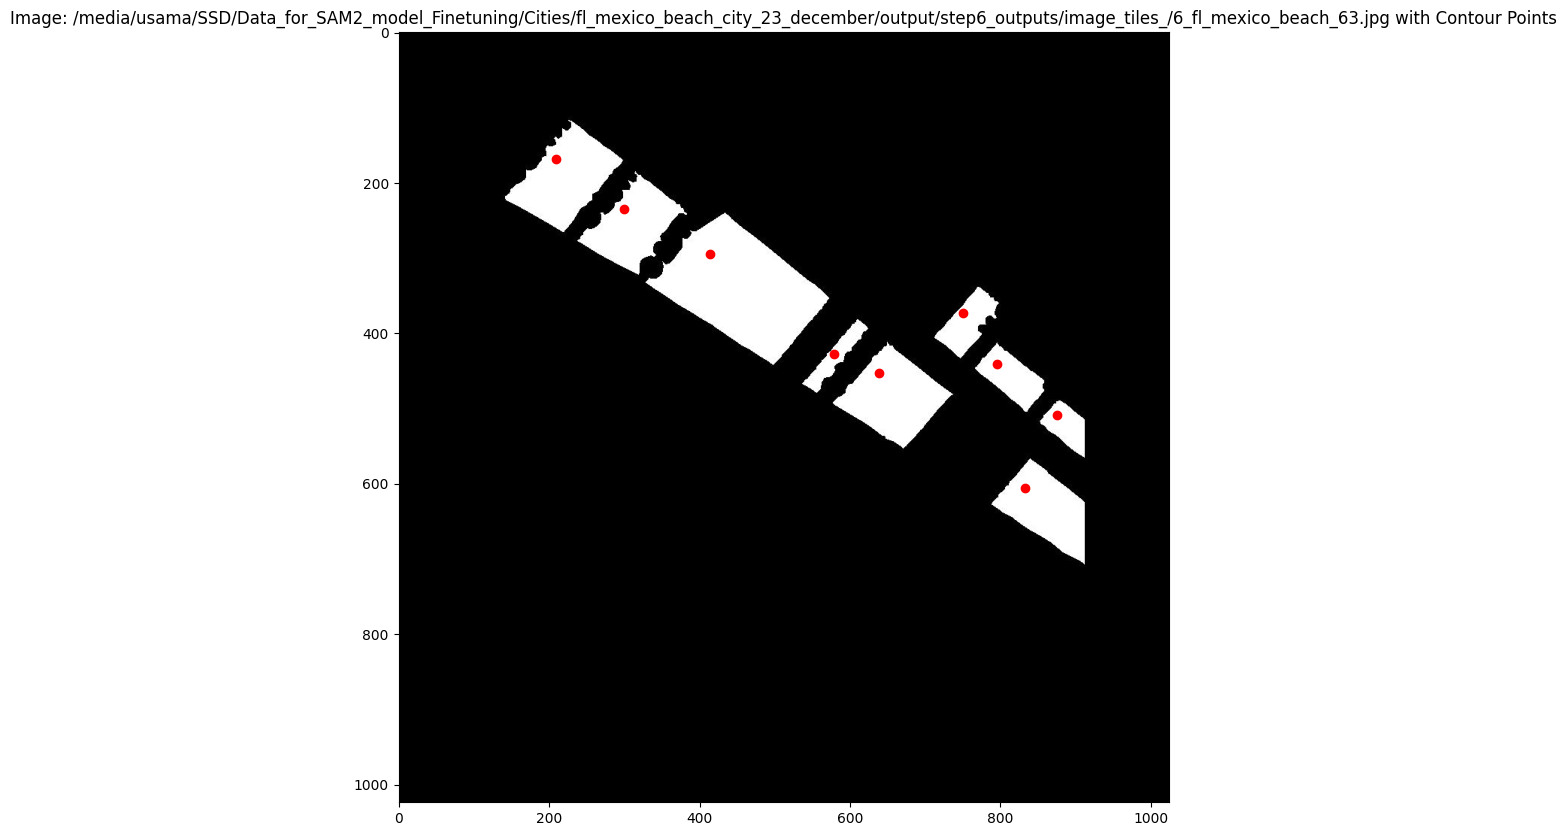

scale 1.0
points [[(132.75, 662.5), (166.0, 681.0), (142.0, 710.0), (179.0, 715.0)], [(265.5, 631.5), (289.25, 624.5), (254.25, 660.5), (277.0, 652.0)], [(168.75, 583.0), (190.75, 588.0), (182.875, 615.25), (203.875, 619.75)], [(121.375, 534.75), (130.5, 539.5), (121.75, 551.5), (130.25, 551.0)]]
copy image path test_data_sam2_24_22_december/images/6_fl_mexico_beach_64_copy0.jpg
point pairs [(132, 662), (265, 631), (168, 583), (121, 534)]


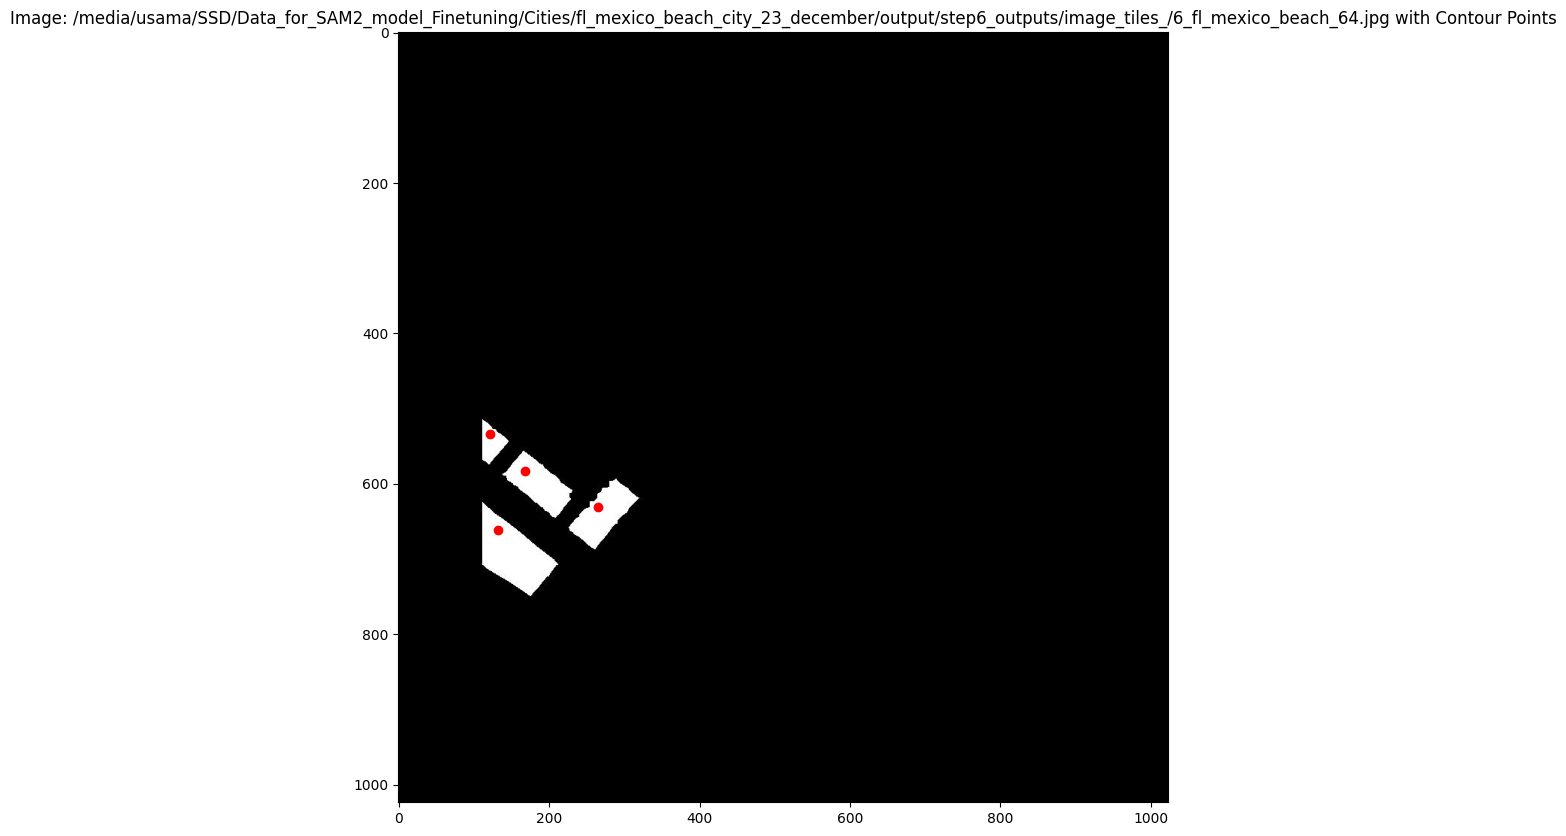

scale 1.0
representative point after area is less than 200 [[(863.75, 132.0), (894.75, 133.5), (875.0, 161.5), (904.25, 185.5)], [(827.75, 116.5)]]
points [[(863.75, 132.0), (894.75, 133.5), (875.0, 161.5), (904.25, 185.5)], [(827.75, 116.5)]]
copy image path test_data_sam2_24_22_december/images/7_fl_mexico_beach_108_copy0.jpg
point pairs [(863, 132), (827, 116)]


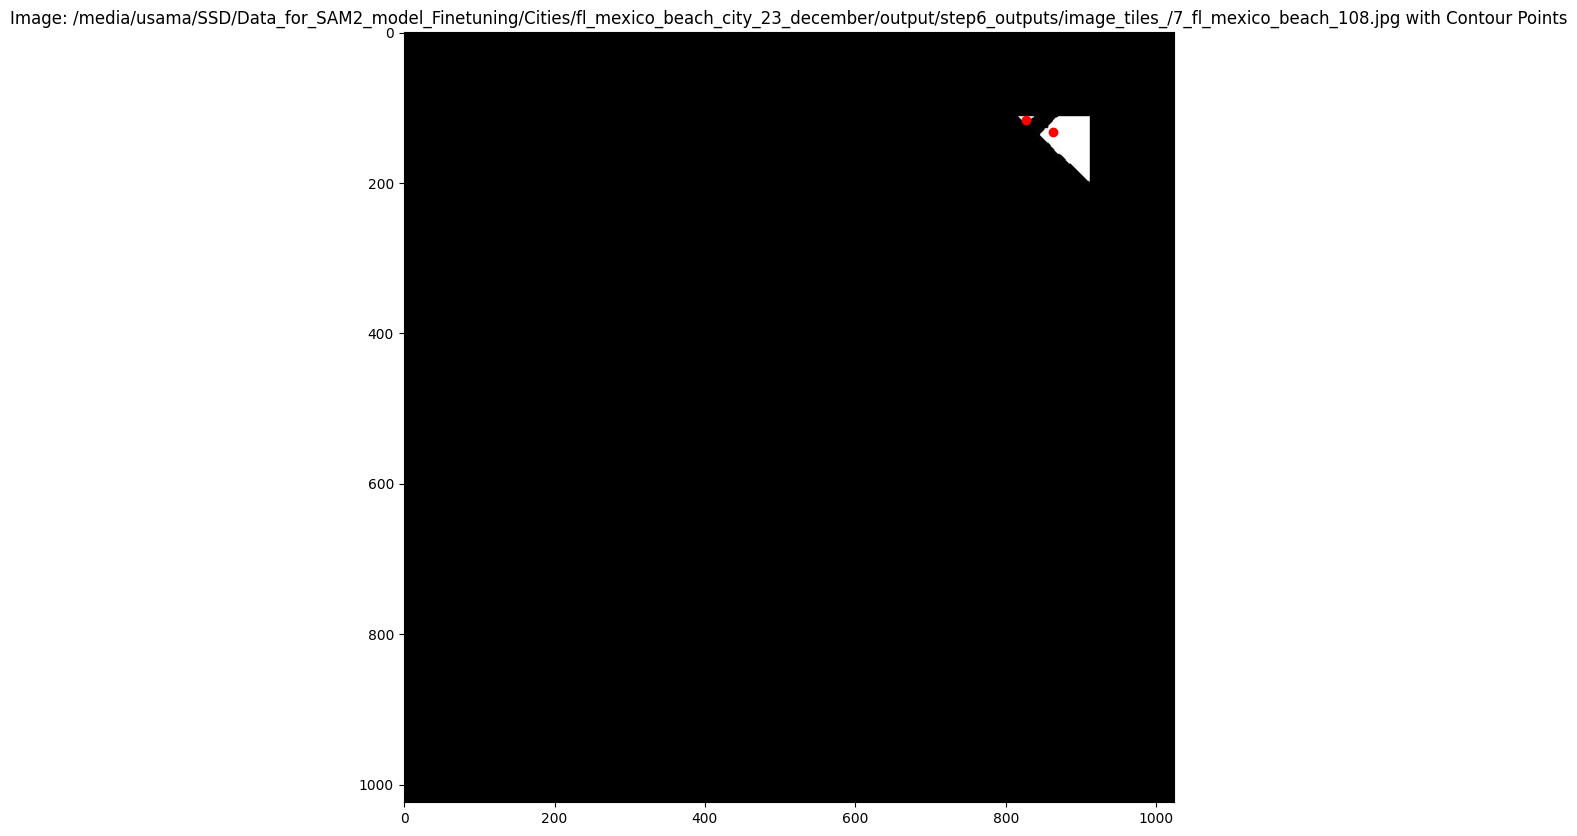

scale 1.0
points [[(552.5, 571.0), (681.25, 671.0), (661.5, 710.5), (772.0, 794.5)], [(616.0, 493.0), (684.25, 527.5), (658.25, 580.5), (762.75, 649.5)], [(721.25, 461.5), (771.75, 455.0), (738.75, 497.0), (785.25, 524.5)], [(854.5, 531.0), (889.0, 528.75), (855.0, 728.0), (889.0, 716.25)], [(371.5, 388.0), (405.75, 394.5), (386.5, 442.0), (415.0, 442.0)], [(270.25, 290.5), (306.25, 302.5), (283.25, 341.5), (316.25, 348.5)], [(659.75, 284.0), (816.25, 276.75), (616.0, 356.5), (863.5, 357.0)], [(566.5, 133.25), (793.5, 133.25), (574.5, 168.0), (793.5, 166.25)], [(139.25, 158.5), (185.75, 185.5), (166.25, 229.0), (207.0, 236.5)]]
copy image path test_data_sam2_24_22_december/images/7_fl_mexico_beach_109_copy0.jpg
point pairs [(552, 571), (616, 493), (721, 461), (854, 531), (371, 388), (270, 290), (659, 284), (566, 133), (139, 158)]


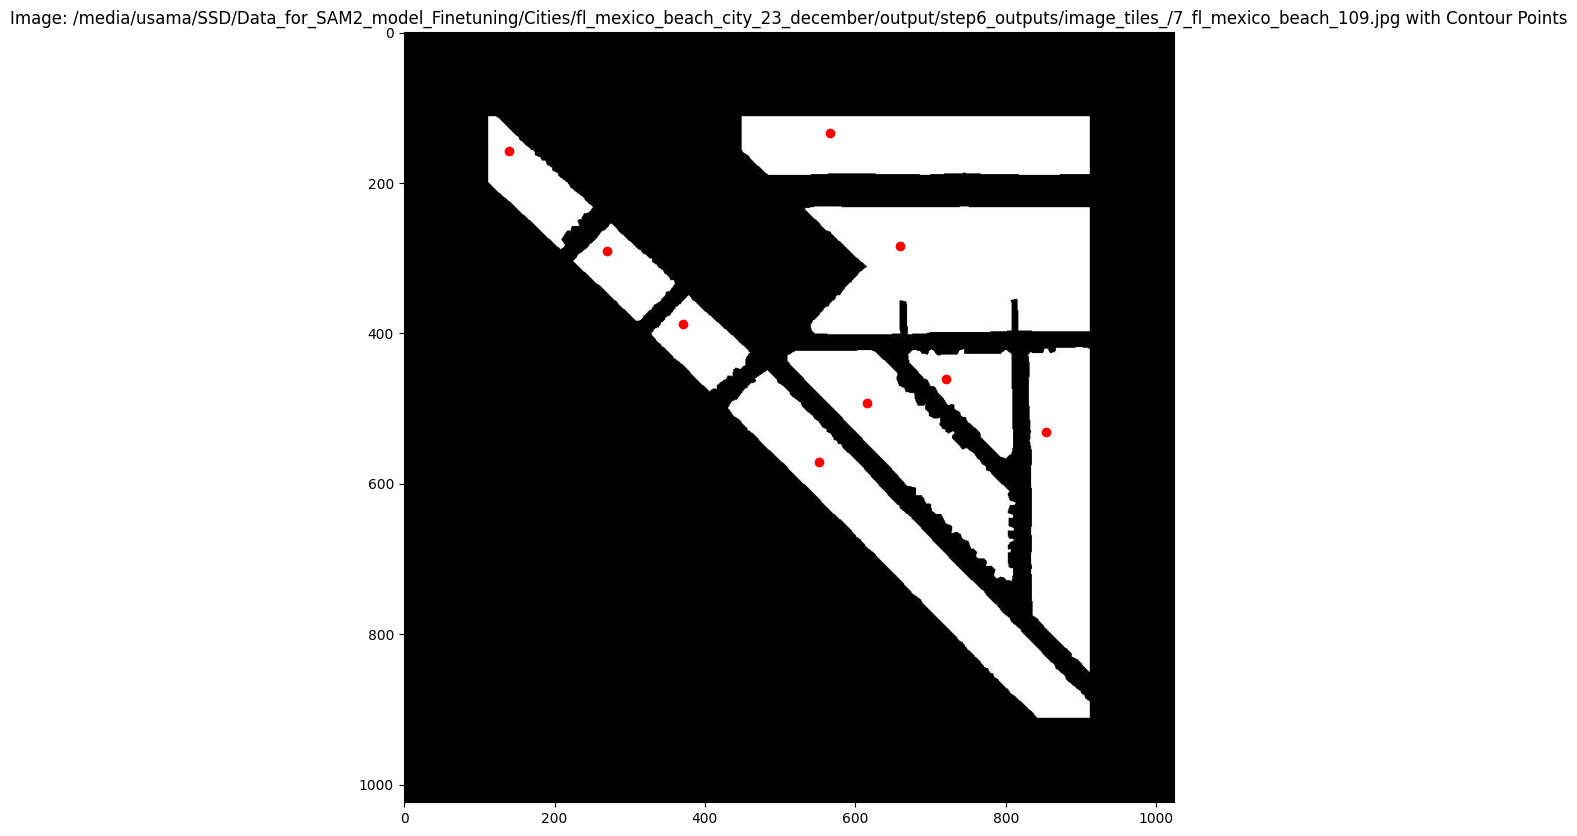

scale 1.0
length of tmp_pts 2
points [[118.5, 905.0], [(120.75, 805.5), (117.75, 746.5)], [(116.5, 467.0), (118.5, 534.5)], [(172.25, 546.0), (212.25, 540.5), (173.25, 735.0), (214.25, 782.0)], [(144.0, 276.25), (199.5, 285.25), (153.5, 371.0), (200.0, 339.0)], [(143.25, 133.25), (197.0, 133.5), (143.25, 167.25), (197.25, 170.0)]]
copy image path test_data_sam2_24_22_december/images/7_fl_mexico_beach_110_copy0.jpg
point pairs [(118, 905), (120, 805), (116, 467), (172, 546), (144, 276), (143, 133)]


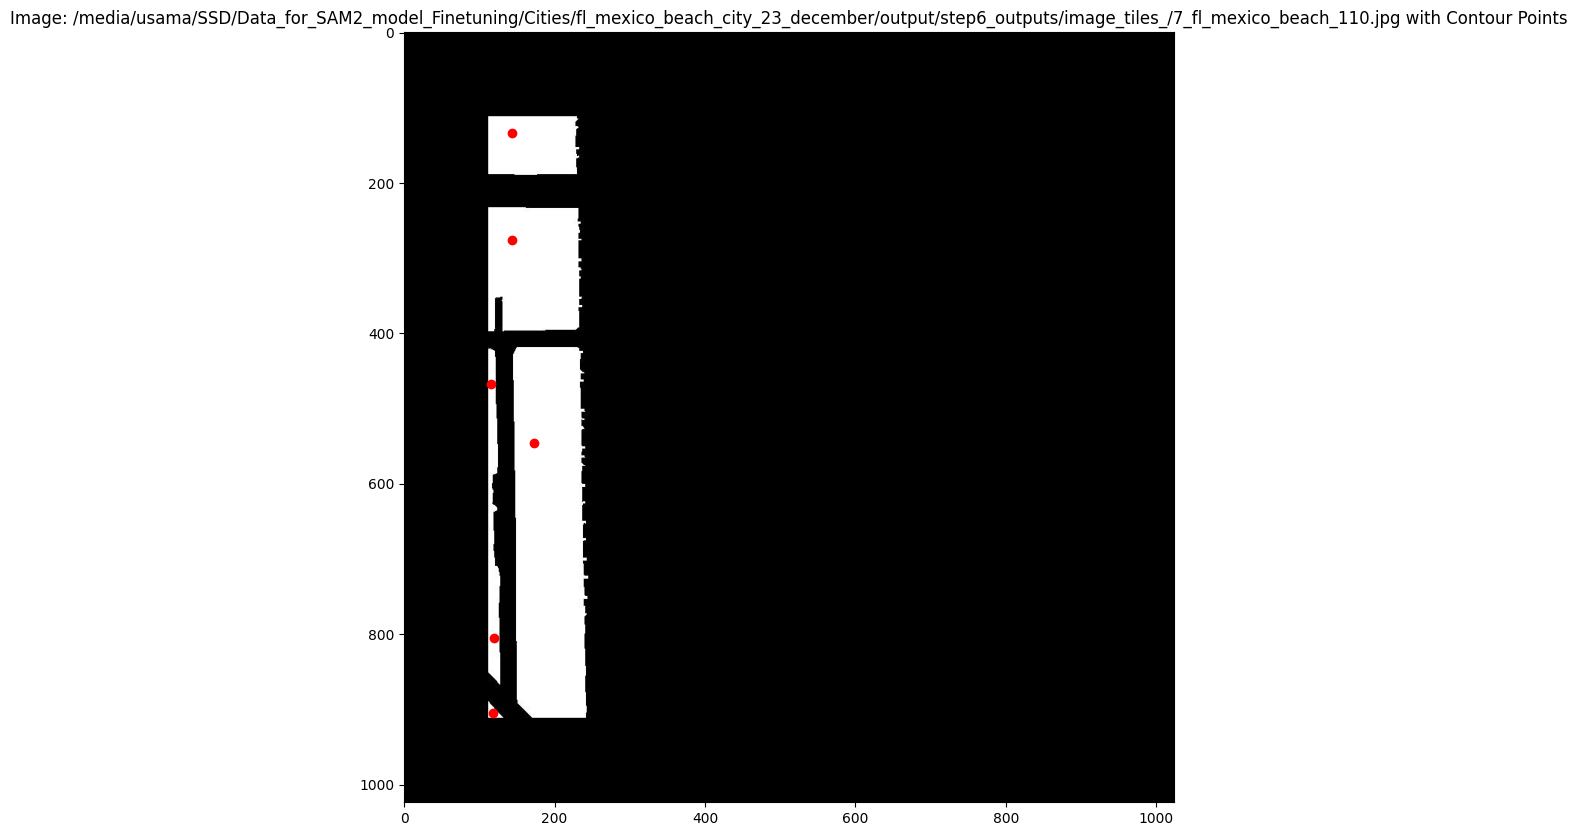

scale 1.0
points [[(873.25, 128.5), (893.5, 129.0), (899.75, 156.5)]]
copy image path test_data_sam2_24_22_december/images/7_fl_mexico_beach_123_copy0.jpg
point pairs [(873, 128)]


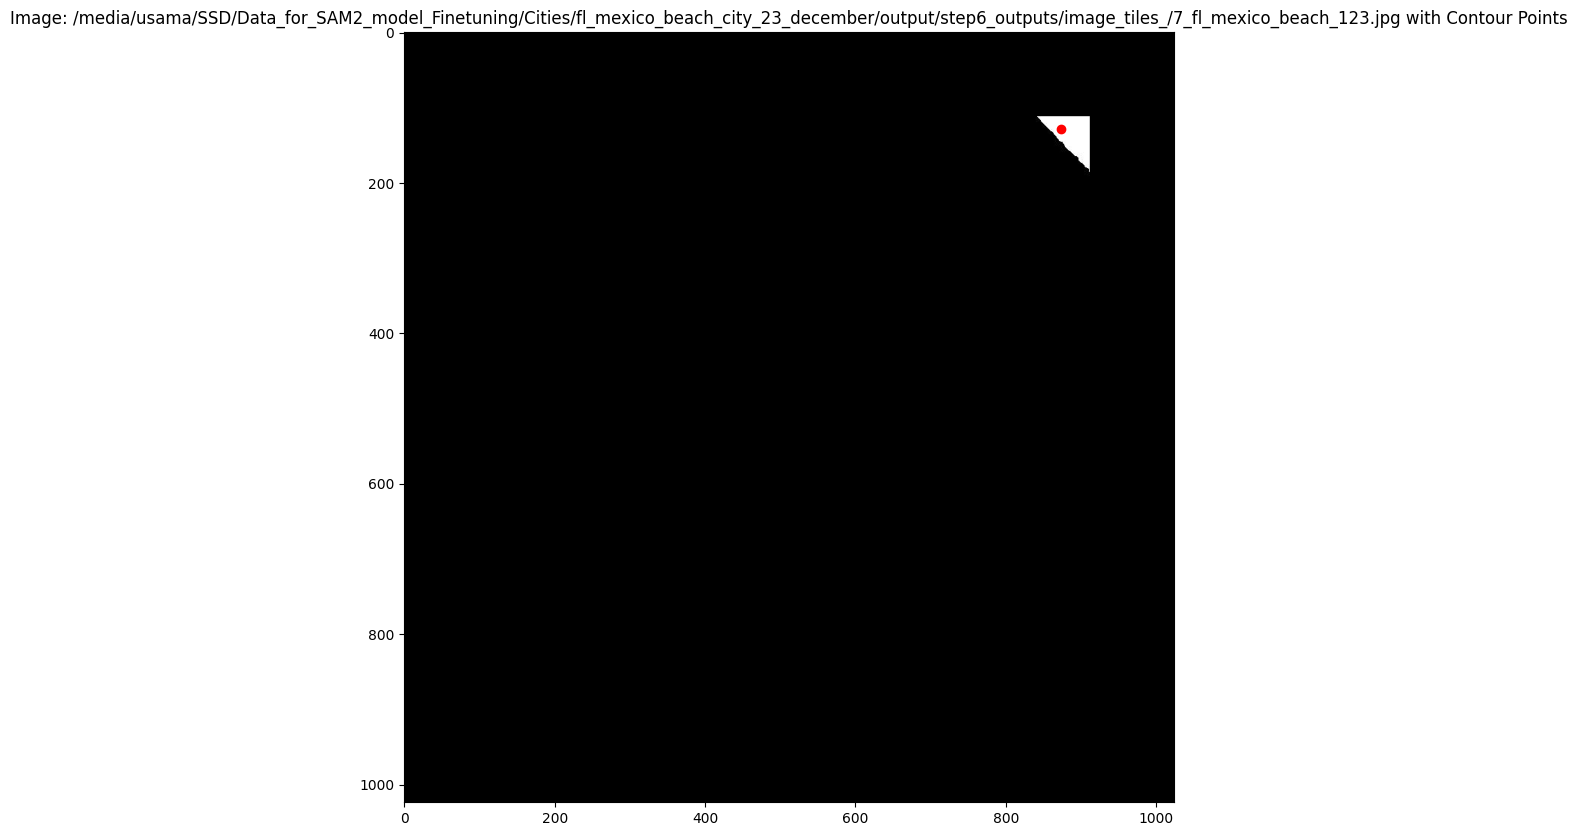

scale 1.0
points [[(200.75, 129.5), (223.5, 124.0), (208.125, 146.25), (224.0, 156.0)], [(139.25, 166.25), (173.0, 172.5), (153.5, 211.5), (192.0, 242.0)]]
copy image path test_data_sam2_24_22_december/images/7_fl_mexico_beach_124_copy0.jpg
point pairs [(200, 129), (139, 166)]


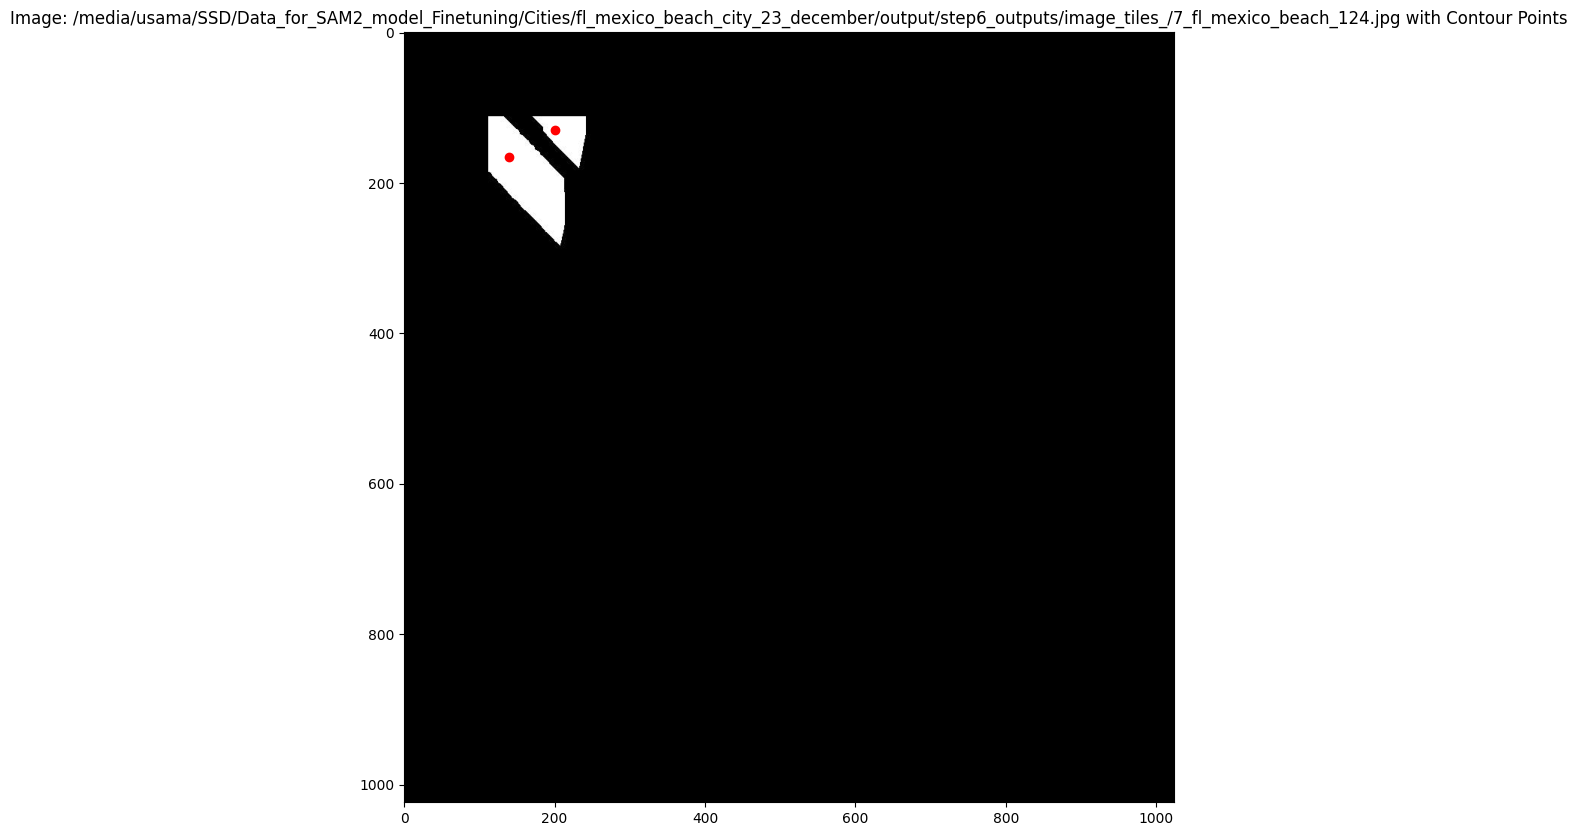

scale 1.0
representative point after area is less than 200 [[(872.75, 745.5), (894.75, 722.5), (868.5, 783.0), (893.0, 799.5)], [(836.75, 640.5), (863.5, 626.5), (818.0, 696.5), (849.25, 678.5)], [(321.75, 585.5)]]
points [[(872.75, 745.5), (894.75, 722.5), (868.5, 783.0), (893.0, 799.5)], [(836.75, 640.5), (863.5, 626.5), (818.0, 696.5), (849.25, 678.5)], [(321.75, 585.5)], [(672.0, 603.0), (755.25, 614.5), (703.0, 642.5), (750.75, 660.5)]]
copy image path test_data_sam2_24_22_december/images/7_fl_mexico_beach_33_copy0.jpg
point pairs [(872, 745), (836, 640), (321, 585), (672, 603)]


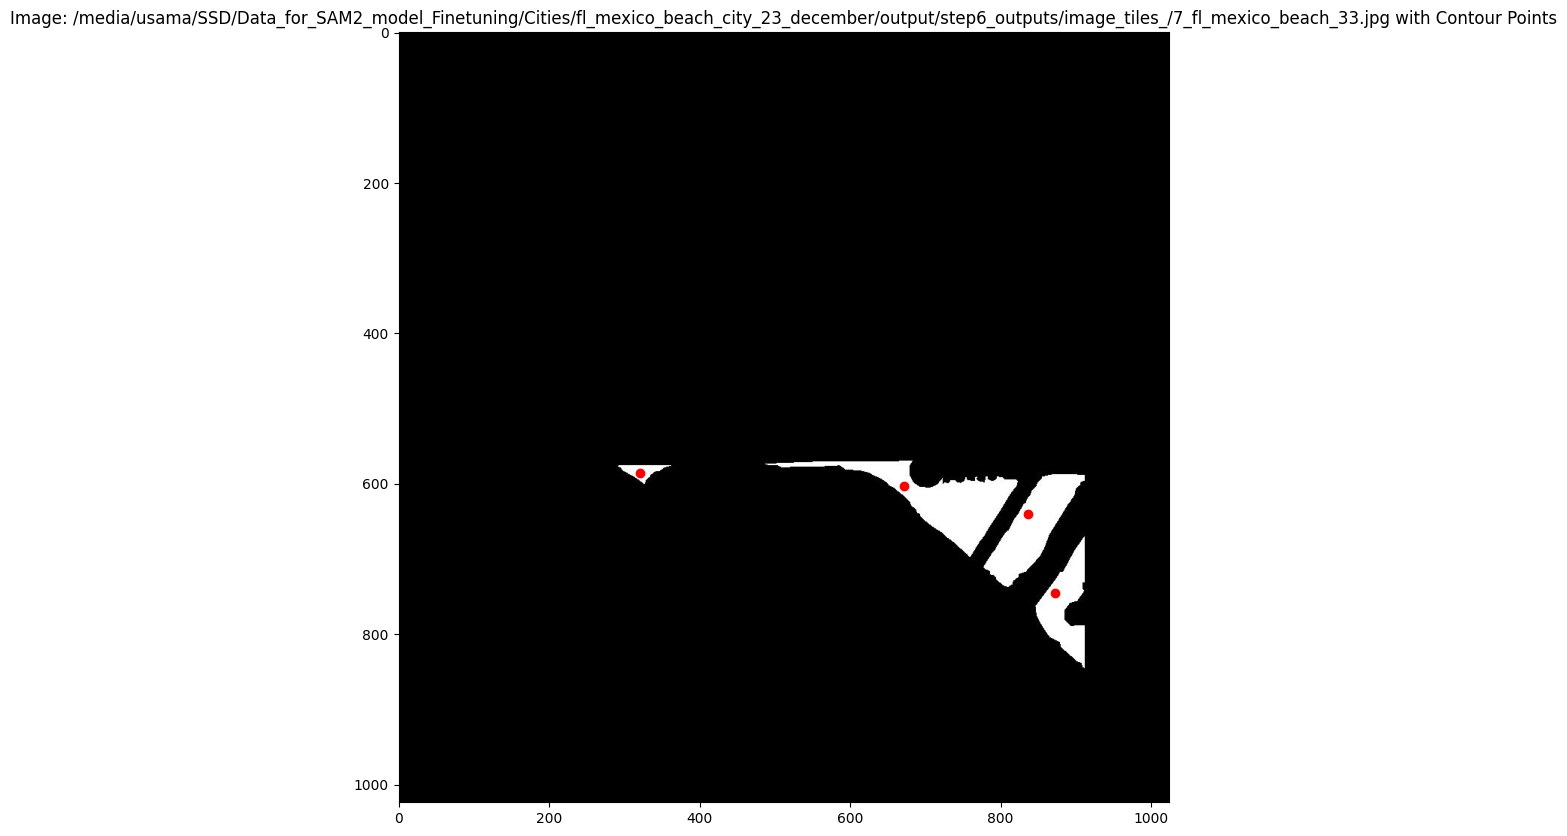

scale 1.0
representative point after area is less than 200 [[(482.75, 894.0), (497.25, 891.0), (477.5, 902.5), (501.25, 901.0)], [(210.75, 856.0), (255.75, 856.5), (220.5, 877.5), (257.0, 889.5)], [(447.5, 820.5), (352.5, 888.5), (405.75, 871.5)], [(557.75, 899.5)]]
points [[(482.75, 894.0), (497.25, 891.0), (477.5, 902.5), (501.25, 901.0)], [(210.75, 856.0), (255.75, 856.5), (220.5, 877.5), (257.0, 889.5)], [(447.5, 820.5), (352.5, 888.5), (405.75, 871.5)], [(557.75, 899.5)], [(357.5, 731.0), (384.5, 745.0), (351.75, 806.5), (386.75, 803.5)], [(259.25, 740.5), (287.75, 726.25), (247.0, 785.5), (278.25, 790.0)], [113.25, 591.5], [(153.5, 622.0), (168.5, 623.0), (126.25, 685.5), (158.5, 657.5)], [(201.0, 683.0), (262.5, 651.0), (145.5, 776.0)]]
copy image path test_data_sam2_24_22_december/images/7_fl_mexico_beach_34_copy0.jpg
point pairs [(482, 894), (210, 856), (447, 820), (557, 899), (357, 731), (259, 740), (113, 591), (153, 622), (201, 683)]


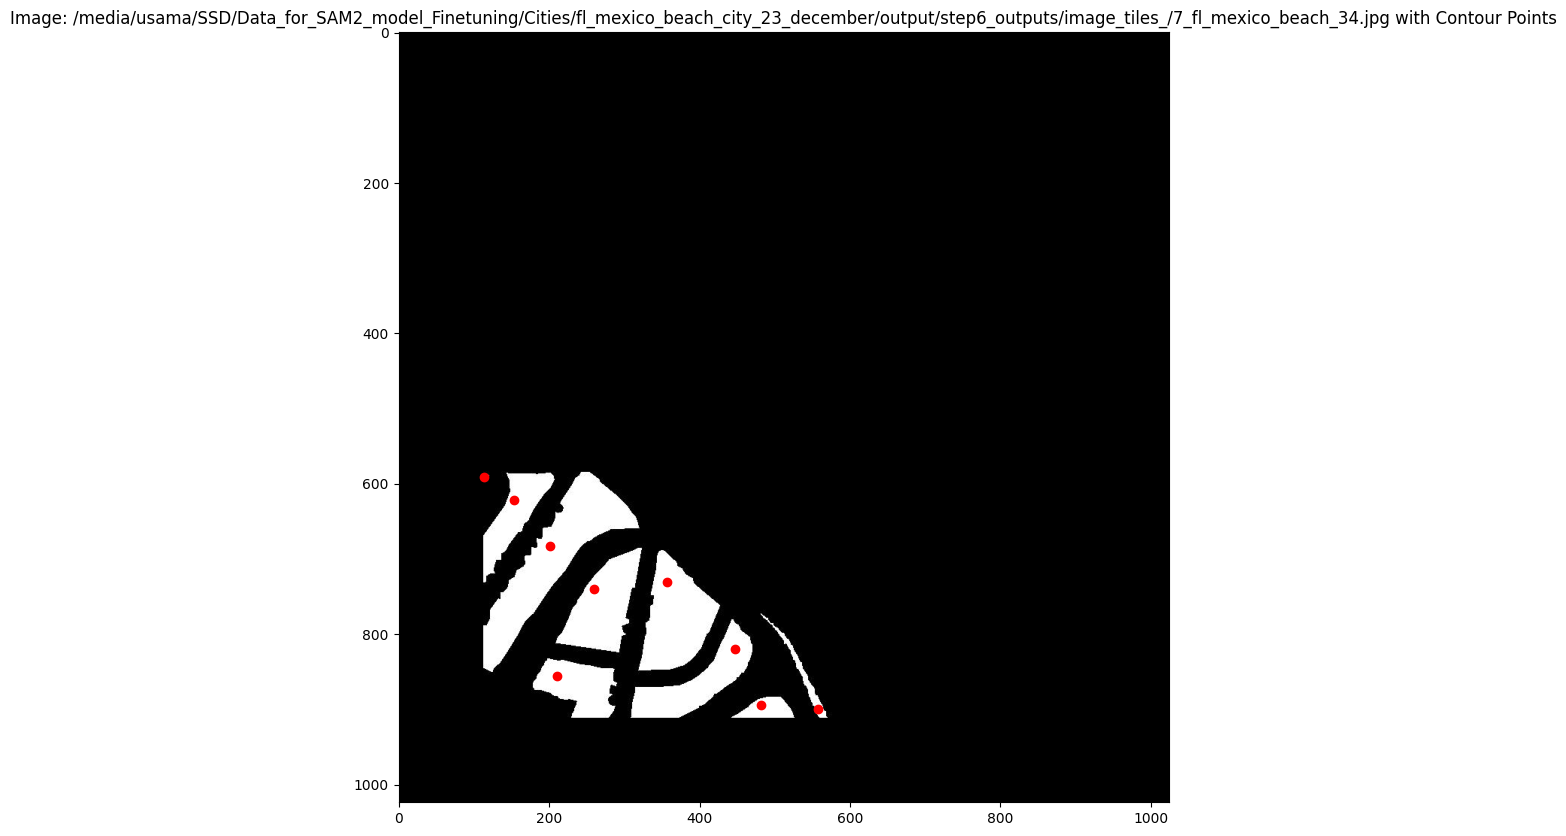

scale 1.0
representative point after area is less than 200 [[(599.0, 183.0)]]
representative point after area is less than 200 [[(599.0, 183.0)], [(591.75, 169.5)]]
representative point after area is less than 200 [[(599.0, 183.0)], [(591.75, 169.5)], [(585.5, 155.5)]]
length of tmp_pts 1
length of tmp_pts 2
points [[(599.0, 183.0)], [(591.75, 169.5)], [(585.5, 155.5)], [(647.0, 249.5), (700.0, 289.5), (687.5, 313.5), (735.75, 341.5)], [(531.0, 148.5), (437.0, 209.5)], [(429.25, 140.5), (345.5, 185.5)], [(228.5, 131.5), (245.75, 133.0), (217.0, 165.5), (237.0, 160.5)]]
copy image path test_data_sam2_24_22_december/images/7_fl_mexico_beach_48_copy0.jpg
point pairs [(599, 183), (591, 169), (585, 155), (647, 249), (531, 148), (429, 140), (228, 131)]


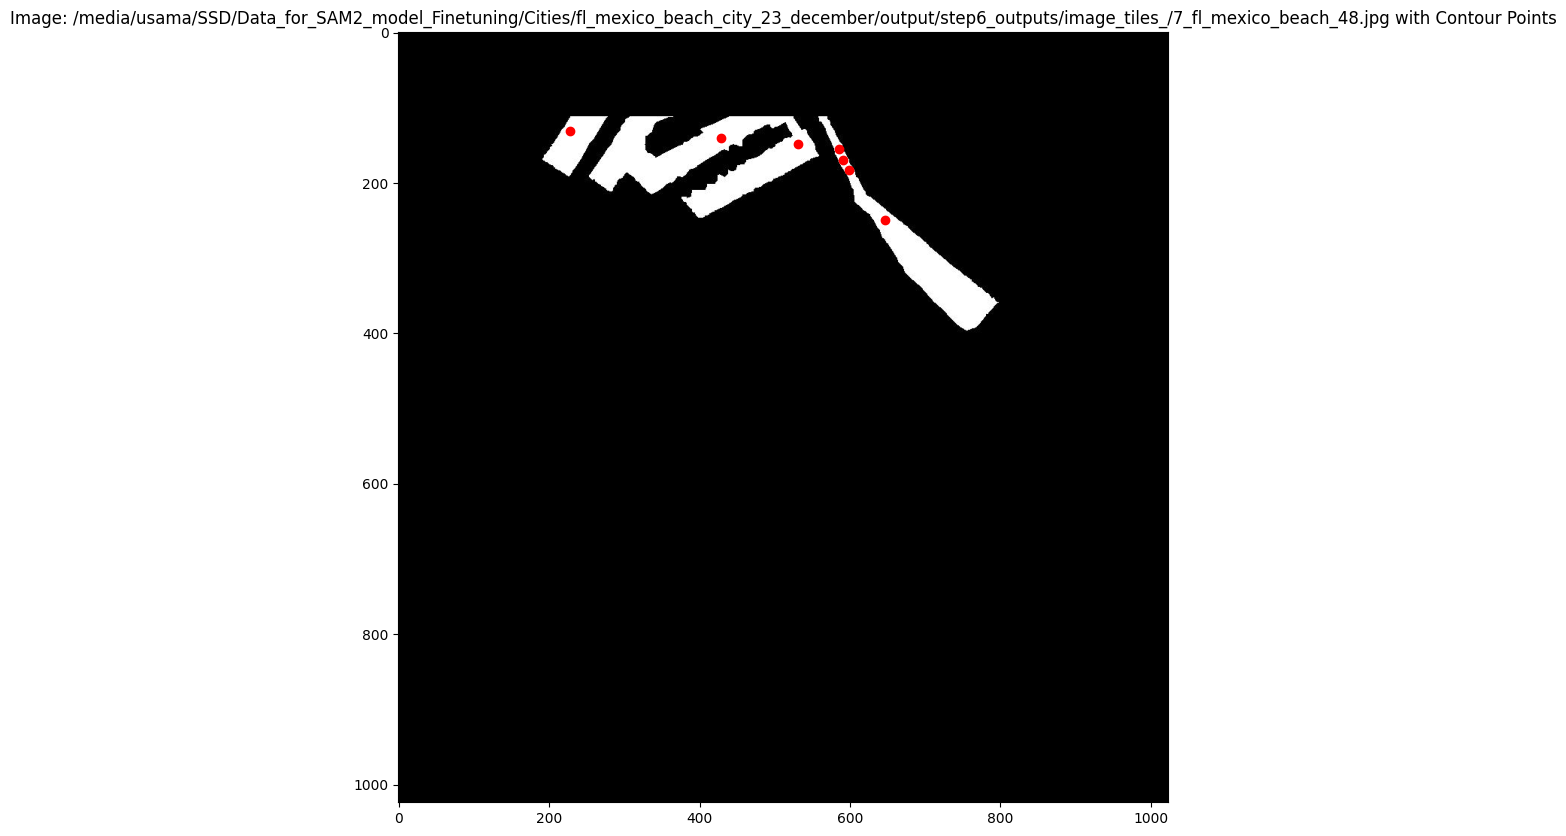

scale 1.0
length of tmp_pts 2
points [[652.5, 907.5], [(533.75, 831.5), (465.75, 880.5)], [(381.75, 816.5), (276.25, 782.5)], [(198.25, 632.0), (248.25, 613.0), (173.75, 695.0), (225.25, 684.0)]]
copy image path test_data_sam2_24_22_december/images/7_fl_mexico_beach_49_copy0.jpg
point pairs [(652, 907), (533, 831), (381, 816), (198, 632)]


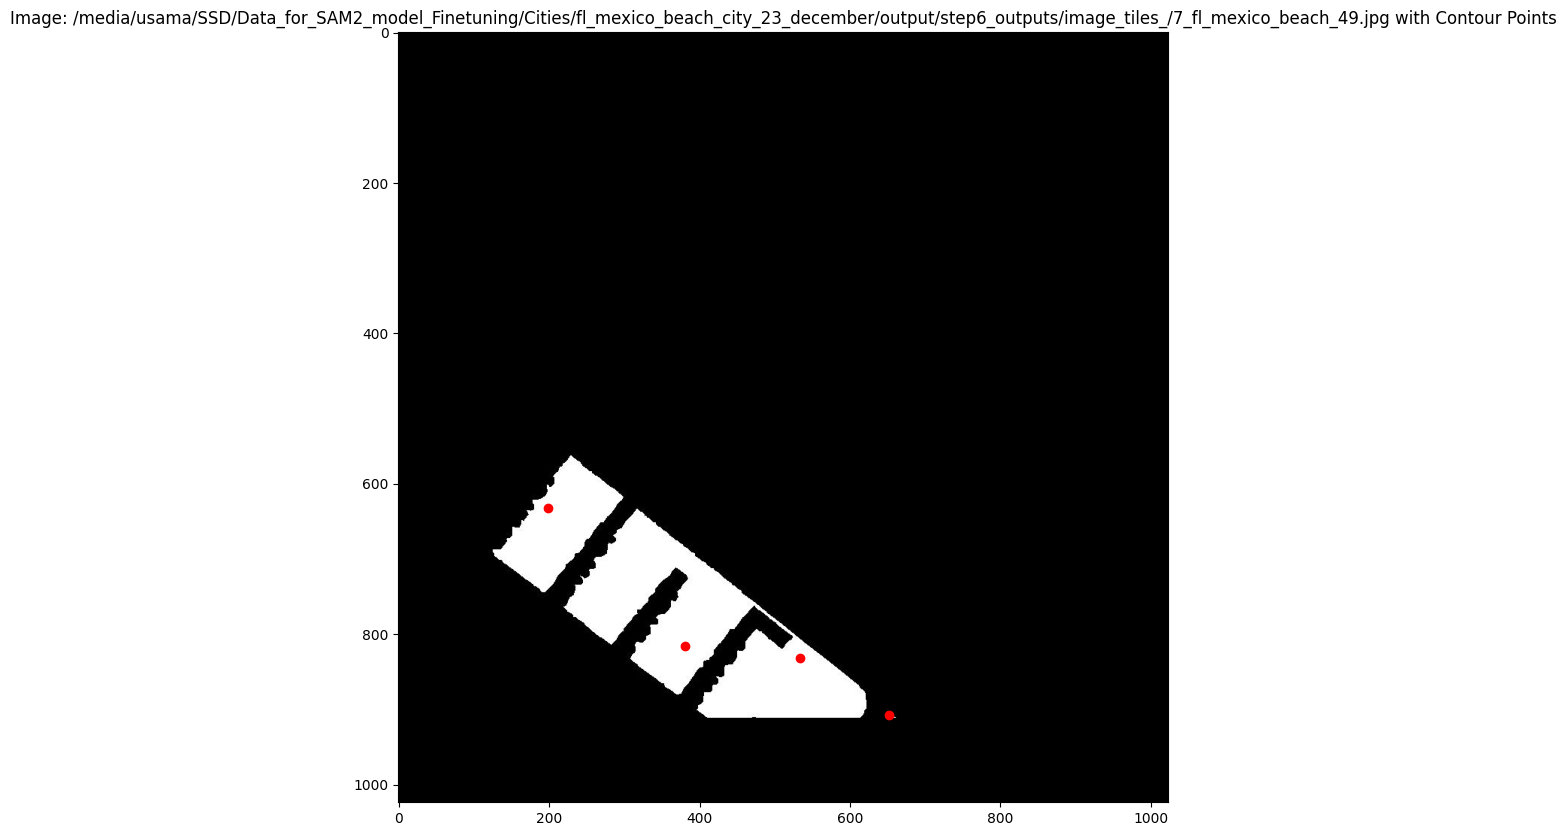

scale 1.0
representative point after area is less than 200 [[(895.25, 480.5), (904.375, 470.25), (894.25, 491.0), (901.75, 489.5)], [(850.75, 362.5), (889.5, 333.5), (830.25, 415.0), (874.75, 417.0)], [(633.25, 249.5)]]
representative point after area is less than 200 [[(895.25, 480.5), (904.375, 470.25), (894.25, 491.0), (901.75, 489.5)], [(850.75, 362.5), (889.5, 333.5), (830.25, 415.0), (874.75, 417.0)], [(633.25, 249.5)], [(842.25, 265.5), (889.5, 225.0), (815.25, 311.5), (846.0, 290.5)], [(661.75, 122.5)]]
points [[(895.25, 480.5), (904.375, 470.25), (894.25, 491.0), (901.75, 489.5)], [(850.75, 362.5), (889.5, 333.5), (830.25, 415.0), (874.75, 417.0)], [(633.25, 249.5)], [(842.25, 265.5), (889.5, 225.0), (815.25, 311.5), (846.0, 290.5)], [(661.75, 122.5)], [(511.25, 141.0), (565.75, 141.5), (529.25, 187.0), (561.75, 179.5)], [(436.75, 121.0), (448.25, 120.5), (440.25, 126.0), (446.25, 128.5)]]
copy image path test_data_sam2_24_22_december/images/7_fl_mexico_beach_63_copy0.jpg
poin

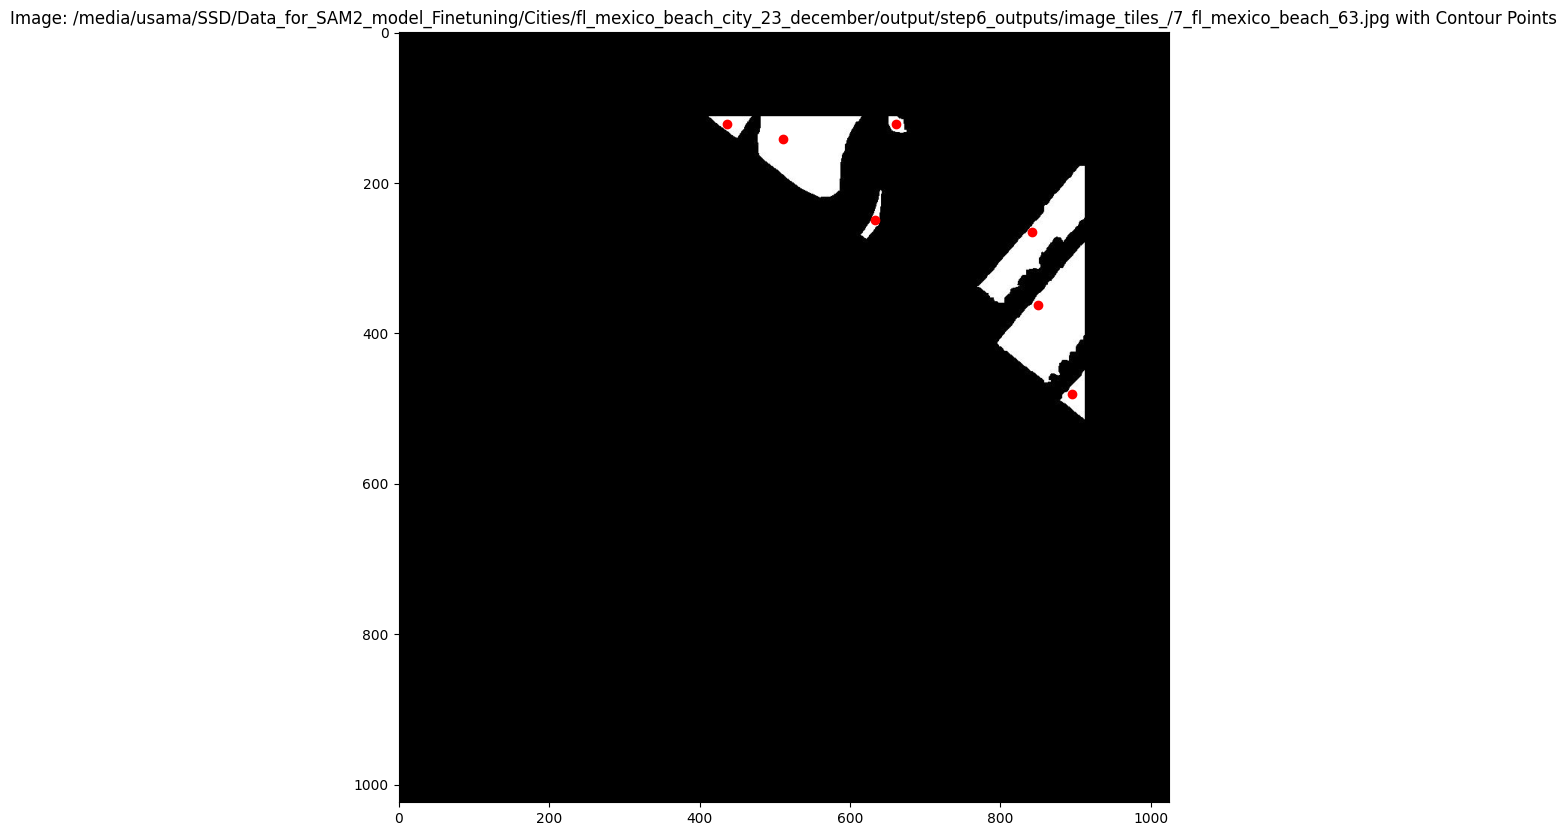

scale 1.0
points [[(763.0, 822.0), (803.5, 793.0), (735.0, 869.5), (772.25, 844.5)], [(841.75, 826.75), (890.75, 786.5), (827.75, 867.5), (869.0, 867.5)], [(350.25, 535.5), (390.625, 511.75), (326.0, 588.5), (388.75, 588.5)], [(891.0, 480.25), (901.5, 463.25), (890.5, 581.0), (901.5, 580.25)], [(261.25, 474.0), (322.25, 452.0), (224.5, 554.0), (288.25, 527.0)], [(703.0, 463.0), (745.5, 463.5), (700.5, 597.0), (746.5, 586.0)], [(184.25, 393.0), (240.25, 383.0), (150.0, 481.5), (210.25, 443.5)], [(137.5, 301.5), (175.5, 296.0), (131.0, 353.0), (165.0, 338.0)], [(576.75, 312.5), (623.0, 304.0), (574.5, 551.5), (622.5, 536.0)], [(127.0, 193.0), (141.25, 196.5), (121.5, 217.5)], [(685.0, 312.0), (799.0, 297.0), (496.5, 585.0), (830.0, 528.5)], [(412.5, 265.0), (476.75, 223.5), (388.0, 377.0), (472.0, 382.5)]]
copy image path test_data_sam2_24_22_december/images/7_fl_mexico_beach_64_copy0.jpg
point pairs [(763, 822), (841, 826), (350, 535), (891, 480), (261, 474), (703, 463), (184, 393), (13

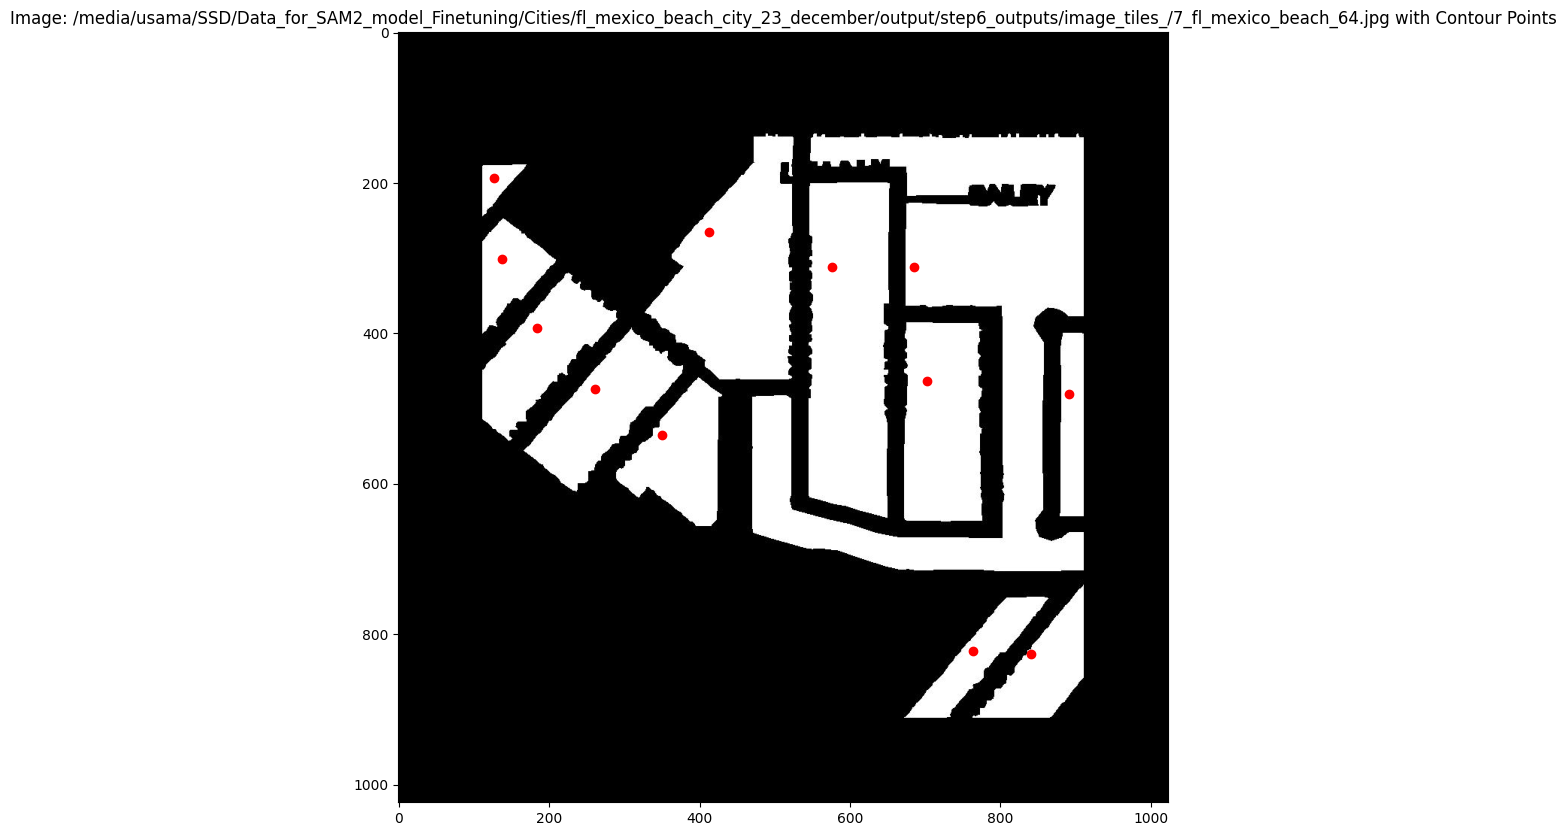

scale 1.0
representative point after area is less than 200 [[(840.25, 826.5), (888.5, 790.5), (826.75, 870.0), (877.25, 870.75)], [(370.0, 791.5), (667.25, 789.5), (393.0, 871.5), (635.75, 868.5)], [(129.0, 773.5), (159.5, 775.0), (124.25, 827.5), (152.0, 802.0)], [(910.0, 698.0)]]
representative point after area is less than 200 [[(840.25, 826.5), (888.5, 790.5), (826.75, 870.0), (877.25, 870.75)], [(370.0, 791.5), (667.25, 789.5), (393.0, 871.5), (635.75, 868.5)], [(129.0, 773.5), (159.5, 775.0), (124.25, 827.5), (152.0, 802.0)], [(910.0, 698.0)], [(907.5, 634.0)]]
points [[(840.25, 826.5), (888.5, 790.5), (826.75, 870.0), (877.25, 870.75)], [(370.0, 791.5), (667.25, 789.5), (393.0, 871.5), (635.75, 868.5)], [(129.0, 773.5), (159.5, 775.0), (124.25, 827.5), (152.0, 802.0)], [(910.0, 698.0)], [(907.5, 634.0)], [(414.5, 536.0), (455.5, 566.25), (410.5, 656.5), (456.0, 660.0)], [(529.0, 534.5), (570.0, 525.5), (528.5, 660.5), (571.0, 663.0)], [(130.0, 461.25), (163.0, 458.0), (130.0, 58

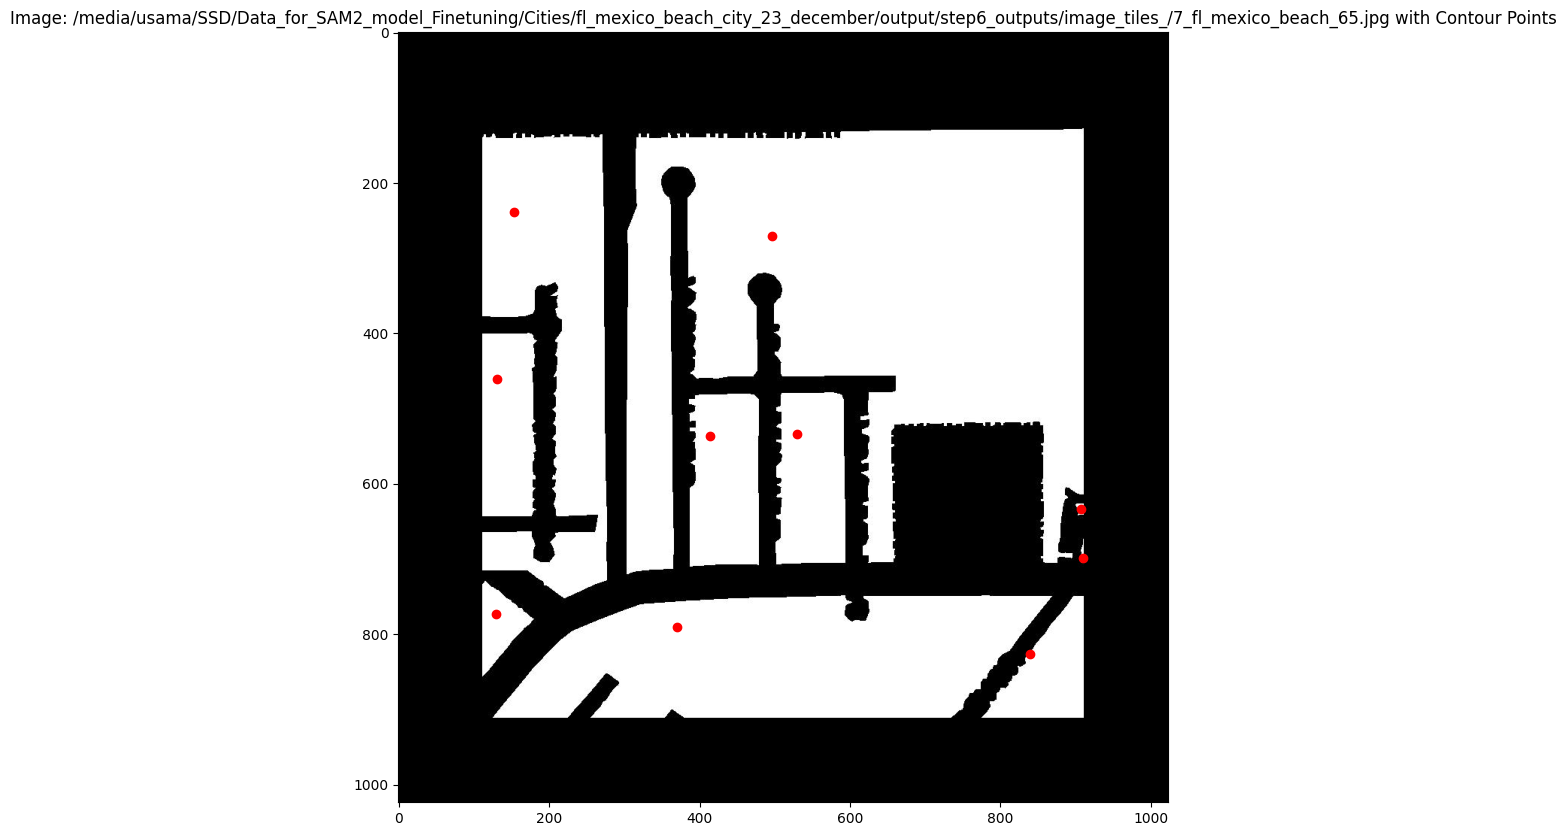

scale 1.0
points [[907.25, 903.5], [(812.75, 833.5), (867.75, 814.5), (791.5, 875.0), (858.0, 878.0)], [(683.75, 801.5), (750.75, 804.5), (656.5, 871.0), (718.25, 869.5)], [(124.5, 790.0), (146.0, 795.0), (124.5, 861.0), (141.5, 861.5)], [(222.0, 787.0), (255.75, 789.5), (210.75, 870.5), (243.25, 855.5)], [(569.0, 810.0), (615.5, 788.5), (539.5, 867.0), (583.0, 847.0)], [(446.75, 817.5), (494.5, 788.0), (414.5, 872.0), (467.5, 837.0)], [(333.75, 786.5), (400.75, 782.0), (306.75, 869.5), (369.75, 840.5)], [(123.5, 272.0), (141.5, 281.5), (123.5, 515.5), (144.75, 560.5)]]
copy image path test_data_sam2_24_22_december/images/7_fl_mexico_beach_66_copy0.jpg
point pairs [(907, 903), (812, 833), (683, 801), (124, 790), (222, 787), (569, 810), (446, 817), (333, 786), (123, 272)]


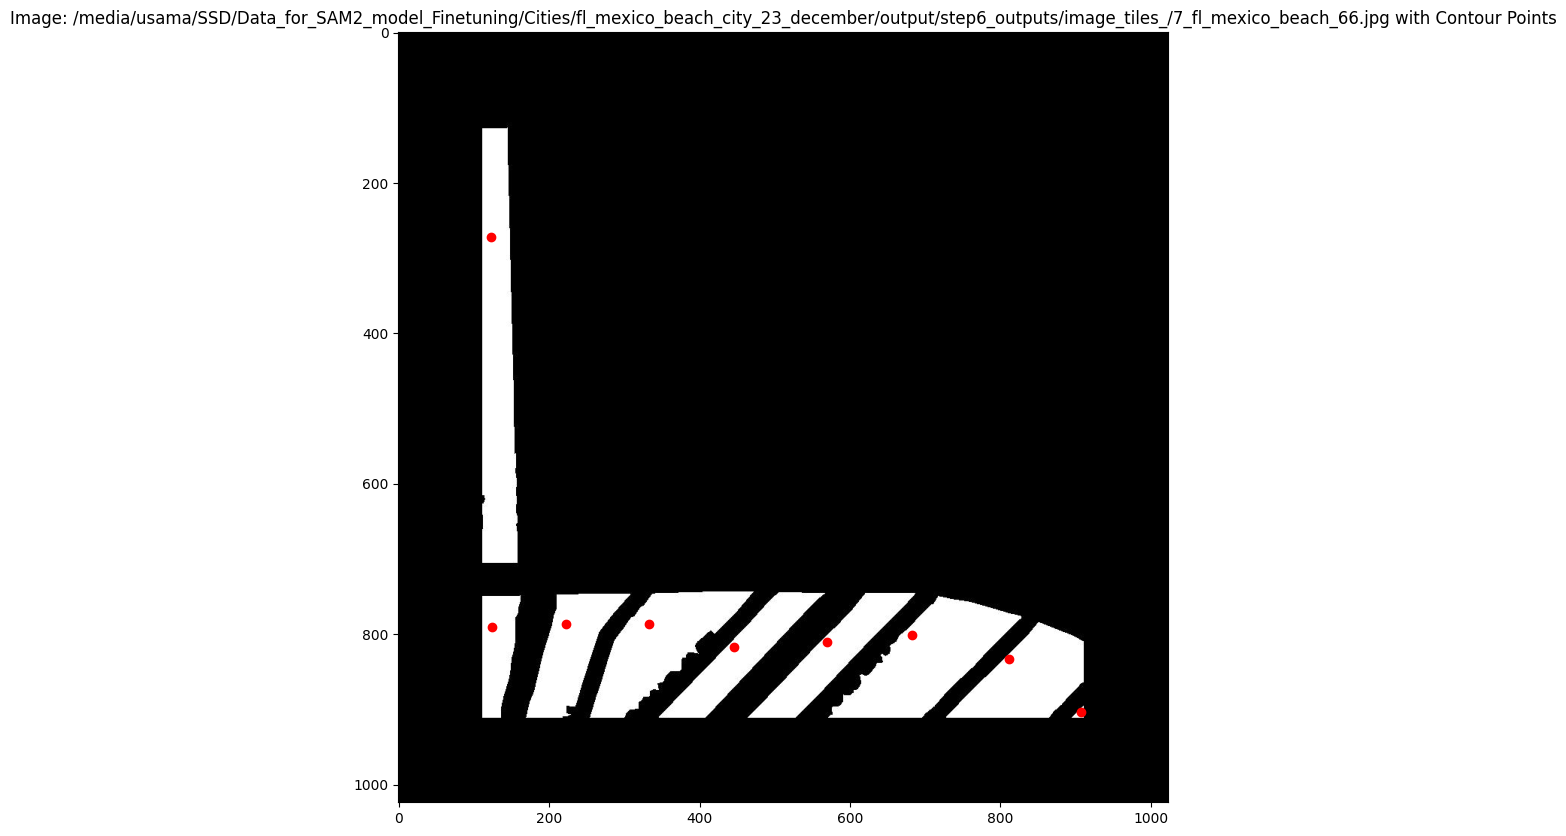

scale 1.0
points [[274.5, 905.5], [(167.75, 857.5), (191.5, 865.0), (153.5, 888.0), (210.0, 893.0)], [(121.0, 829.0), (129.75, 831.5), (119.5, 843.0), (126.75, 838.5)], [(562.5, 753.0), (790.5, 752.5), (558.5, 863.5), (790.5, 855.0)], [(293.5, 694.0), (369.5, 705.0), (295.0, 813.0), (367.0, 841.5)]]
copy image path test_data_sam2_24_22_december/images/7_fl_mexico_beach_67_copy0.jpg
point pairs [(274, 905), (167, 857), (121, 829), (562, 753), (293, 694)]


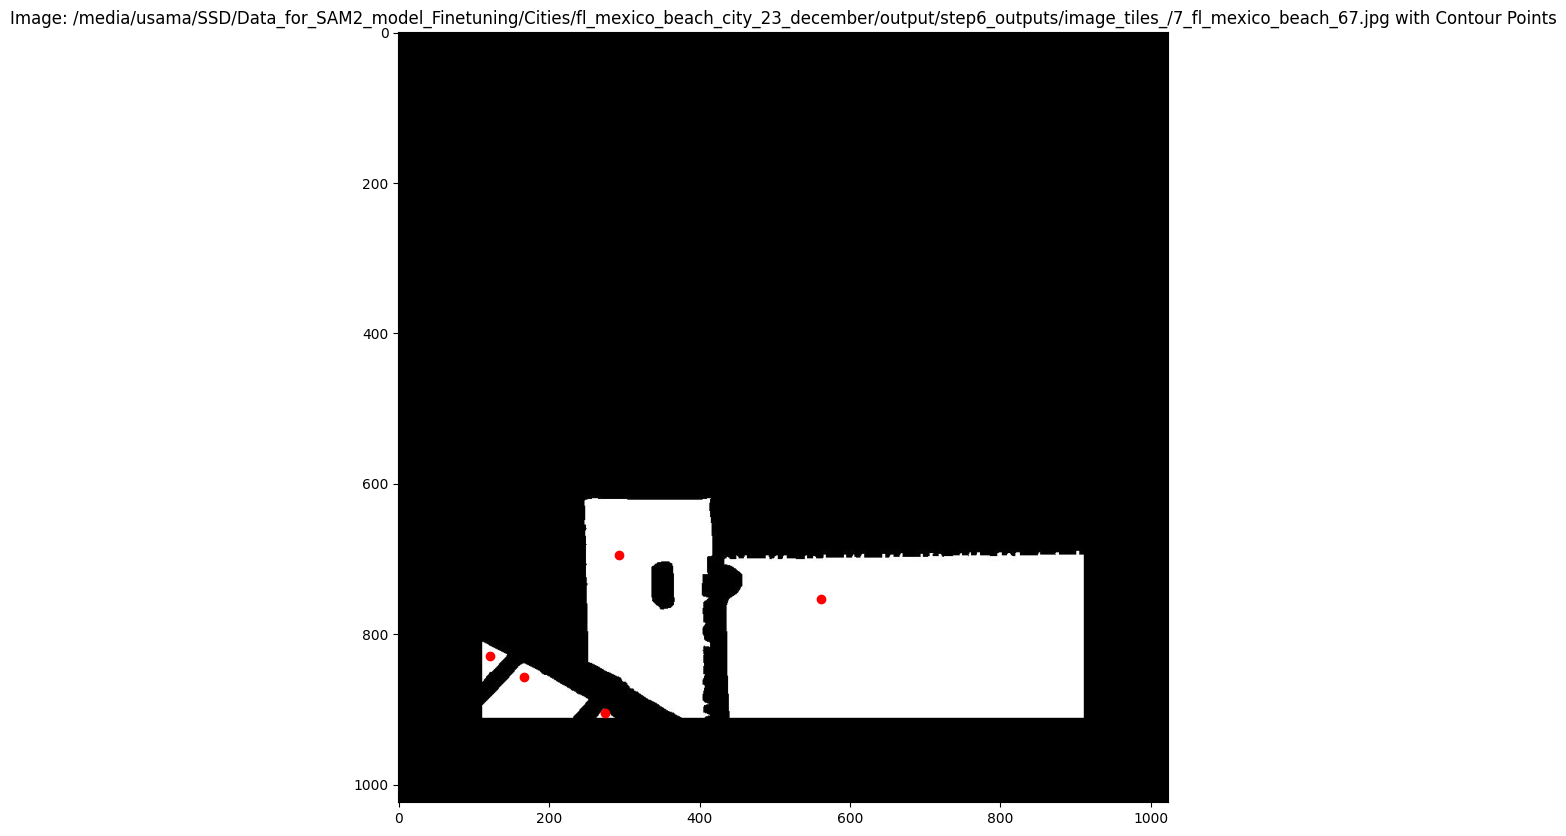

scale 1.0
points [[(137.25, 750.75), (178.5, 750.5), (137.25, 854.75), (179.25, 846.5)]]
copy image path test_data_sam2_24_22_december/images/7_fl_mexico_beach_68_copy0.jpg
point pairs [(137, 750)]


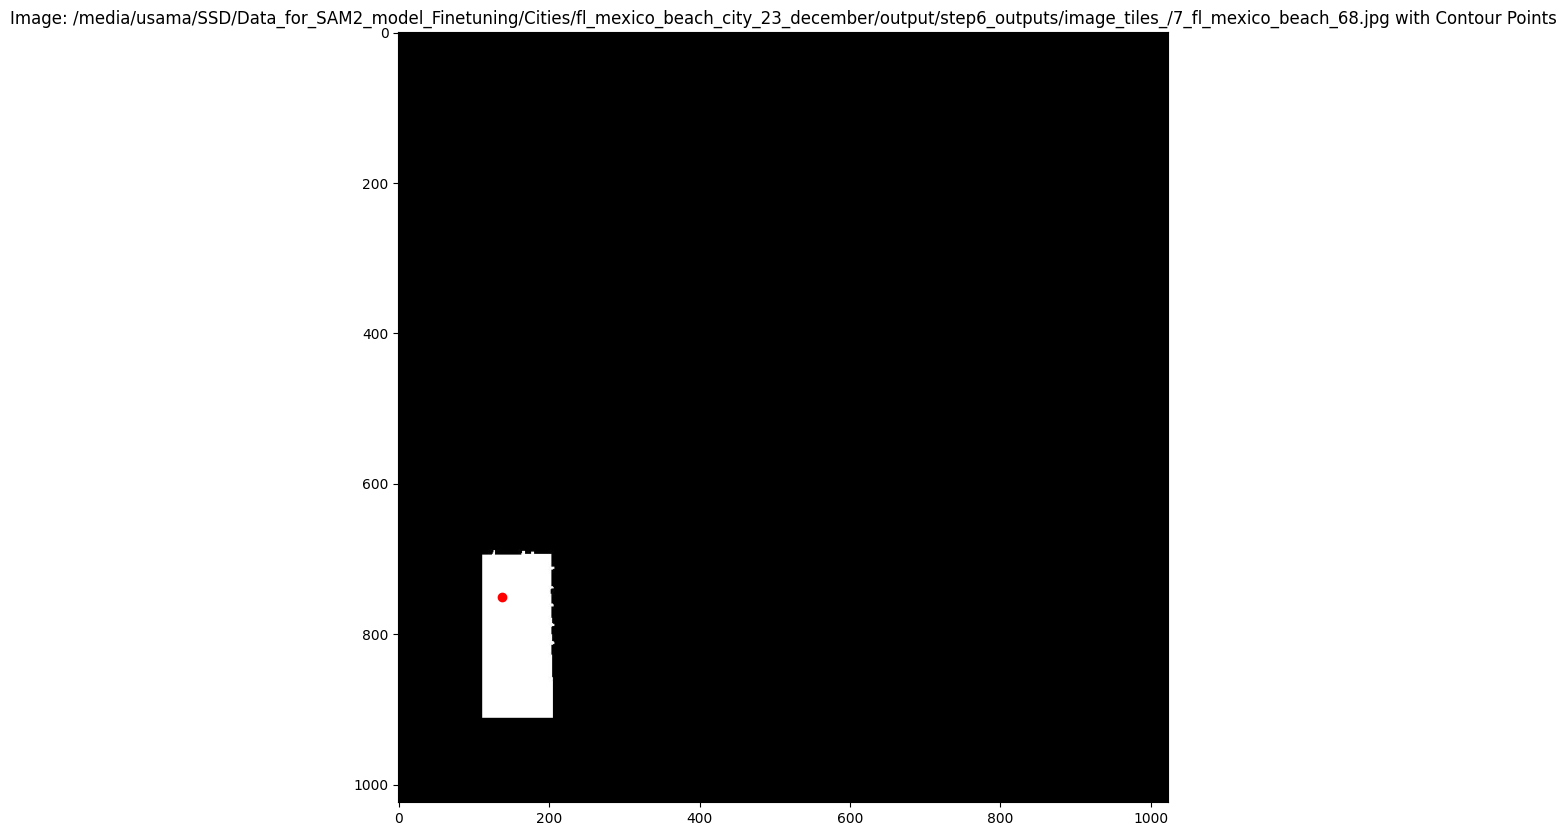

scale 1.0
representative point after area is less than 200 [[(906.25, 298.5)]]
points [[(906.25, 298.5)], [(851.5, 213.5), (890.75, 182.5), (830.25, 263.0), (872.25, 265.0)], [(767.25, 138.5), (808.0, 139.0), (730.25, 184.5), (790.25, 181.5)], [(677.0, 129.0), (696.5, 128.5), (675.75, 152.5), (690.25, 149.5)]]
copy image path test_data_sam2_24_22_december/images/7_fl_mexico_beach_78_copy0.jpg
point pairs [(906, 298), (851, 213), (767, 138), (677, 129)]


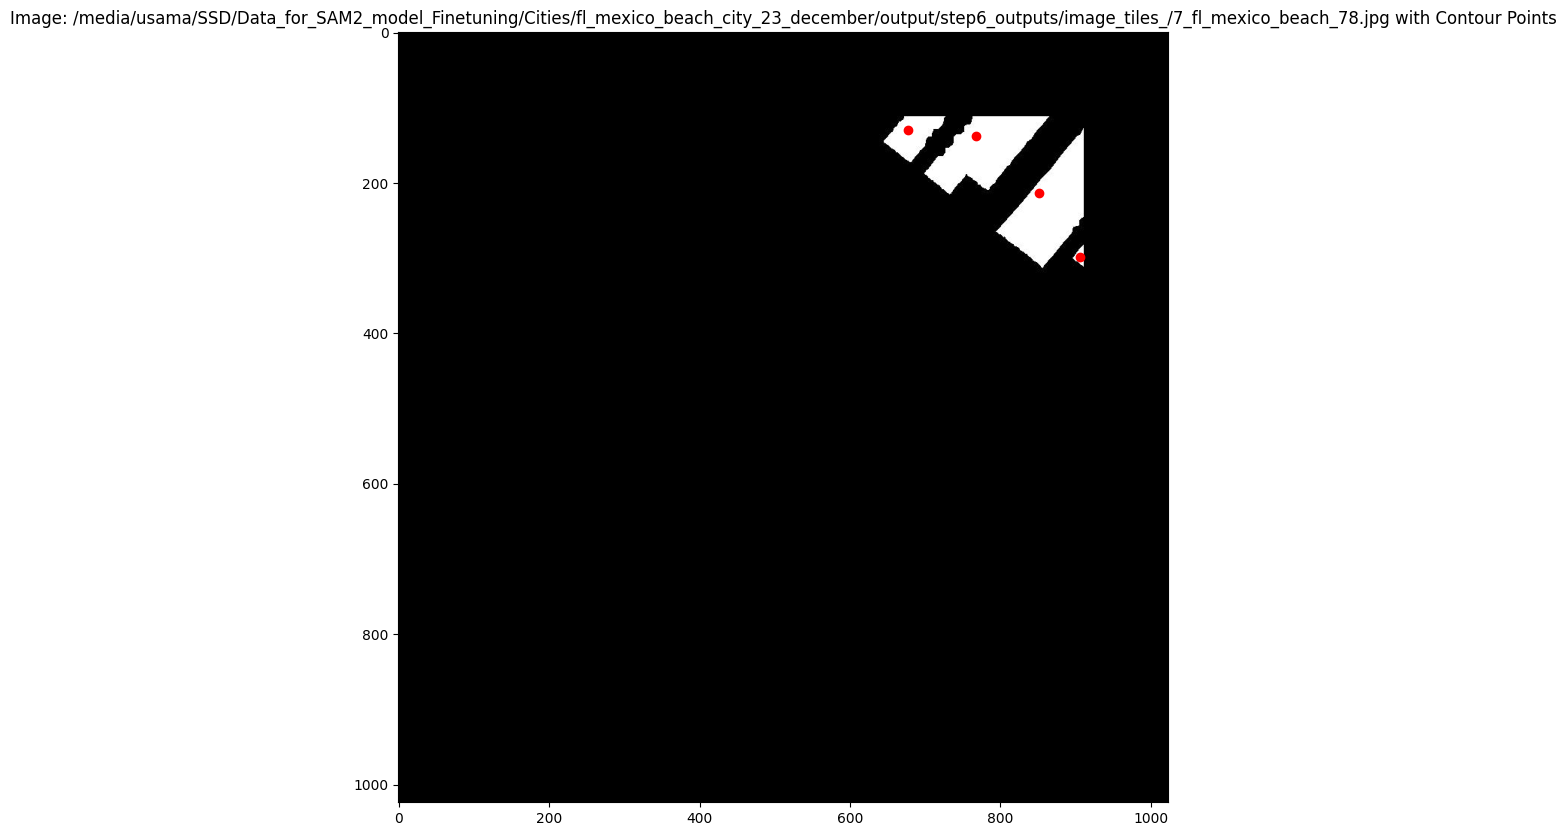

scale 1.0
points [[(427.0, 349.0), (475.5, 308.0), (384.5, 416.5), (435.75, 371.5)], [(186.75, 224.0), (208.25, 229.0), (191.75, 255.5), (211.75, 259.0)], [(347.0, 276.5), (408.0, 244.0), (306.75, 364.5), (368.75, 332.0)], [(329.25, 194.5), (159.75, 306.5), (260.0, 281.5)], [(601.75, 264.0), (769.25, 271.5), (549.75, 571.0), (702.5, 567.5)], [(292.75, 126.5), (321.0, 124.0), (300.75, 139.5), (312.5, 143.5)], [(140.75, 151.25), (177.25, 143.5), (129.25, 199.5), (166.0, 172.5)]]
copy image path test_data_sam2_24_22_december/images/7_fl_mexico_beach_79_copy0.jpg
point pairs [(427, 349), (186, 224), (347, 276), (329, 194), (601, 264), (292, 126), (140, 151)]


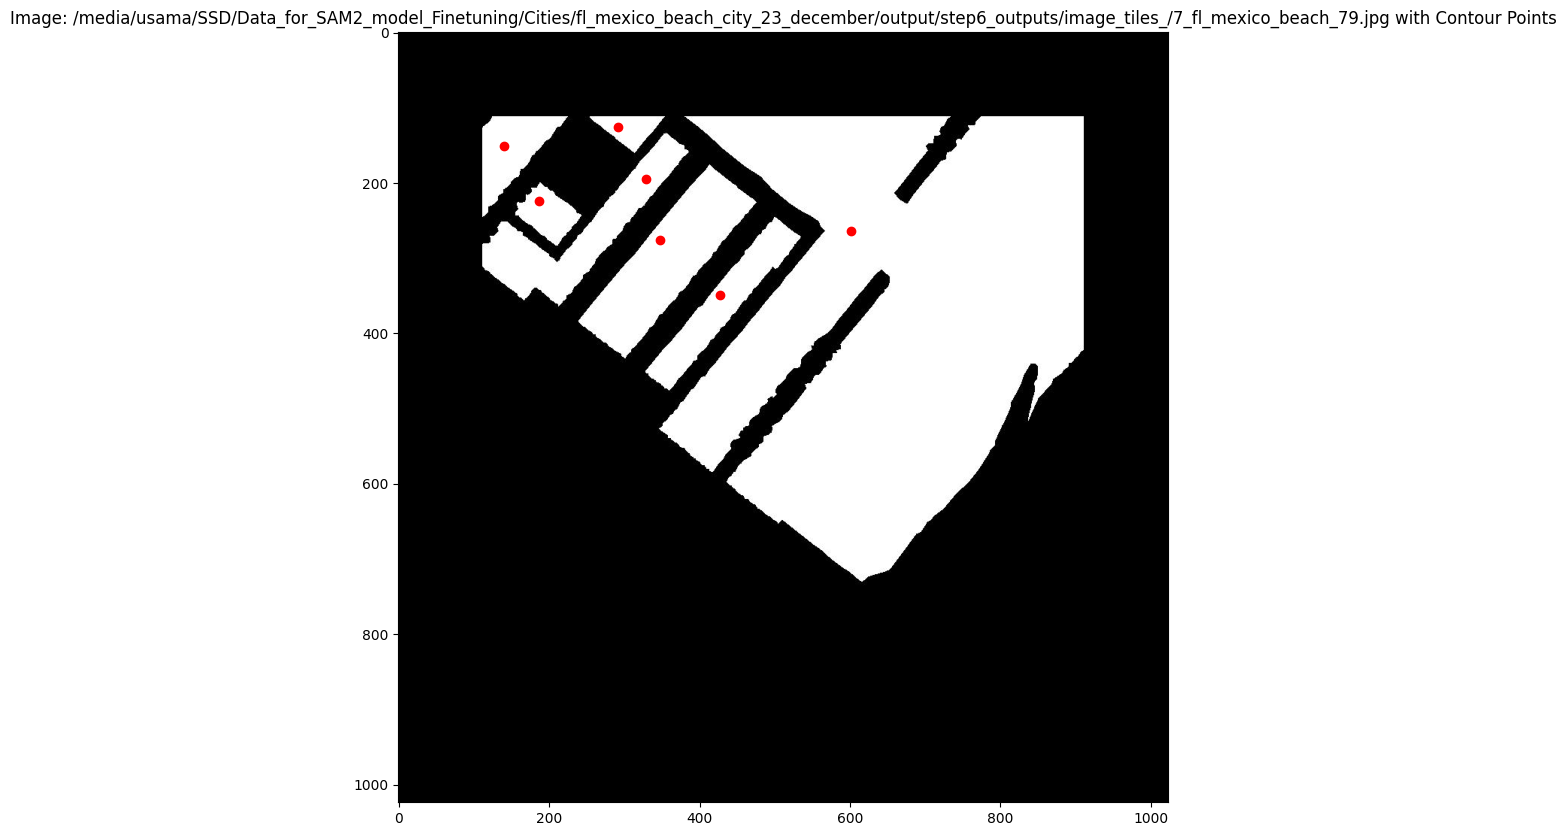

scale 1.0
points [[(864.5, 795.0), (890.0, 796.0), (868.25, 833.5), (893.5, 850.0)], [(630.0, 696.5), (720.75, 763.5), (713.0, 780.5), (793.5, 838.0)], [(803.5, 633.5), (875.0, 583.0), (777.25, 721.0), (845.75, 721.0)], [(311.5, 395.5), (402.625, 464.75), (391.0, 487.5), (476.5, 547.5)], [(742.25, 456.0), (859.5, 381.0), (684.25, 573.0), (793.375, 536.75)], [(702.25, 329.0), (848.5, 227.0), (622.5, 456.0), (729.0, 384.5)], [(618.75, 256.5), (701.5, 207.0), (515.5, 393.0), (645.25, 312.5)], [(492.75, 208.0), (561.0, 190.5), (407.5, 332.5), (517.75, 272.5)], [(395.375, 197.75), (437.75, 172.75), (341.0, 271.0), (404.625, 229.25)], [(286.25, 194.0), (322.25, 169.75), (228.75, 272.5), (296.0, 221.5)], [(263.25, 129.5), (274.75, 127.0), (255.0, 150.0), (271.0, 139.5)], [(140.75, 222.75), (177.25, 186.5), (135.75, 335.5), (168.5, 283.5)]]
copy image path test_data_sam2_24_22_december/images/7_fl_mexico_beach_80_copy0.jpg
point pairs [(864, 795), (630, 696), (803, 633), (311, 395), (742, 456)

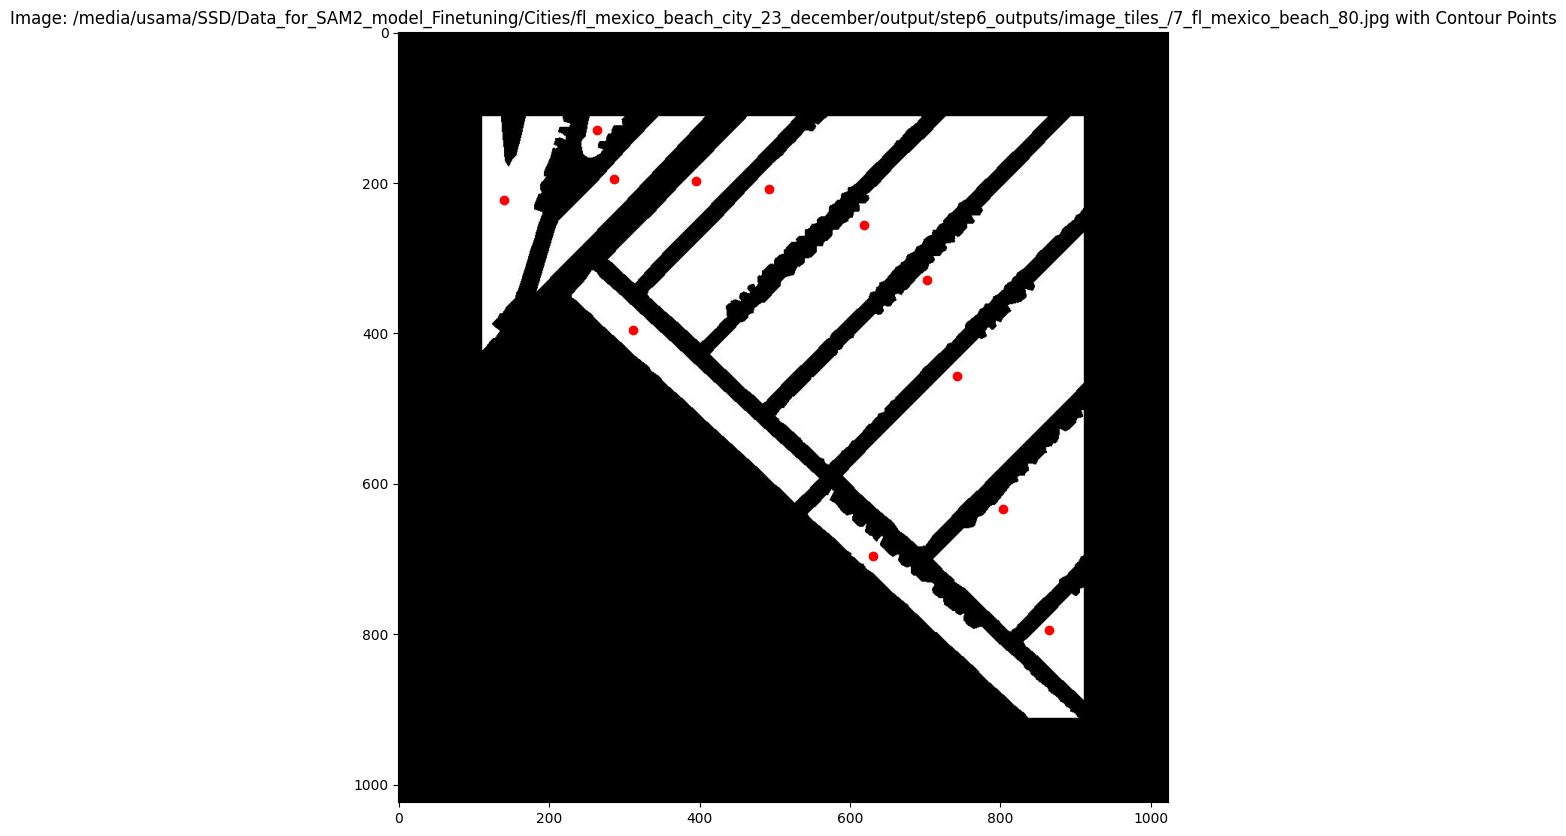

scale 1.0
representative point after area is less than 200 [[(240.25, 636.5), (345.0, 562.5), (179.375, 792.25), (281.0, 729.5)], [(243.375, 386.75), (346.25, 320.5), (172.75, 567.5), (283.75, 489.0)], [(563.75, 141.5), (791.5, 141.0), (624.75, 187.5), (791.5, 187.5)], [(400.75, 116.5)]]
points [[(240.25, 636.5), (345.0, 562.5), (179.375, 792.25), (281.0, 729.5)], [(243.375, 386.75), (346.25, 320.5), (172.75, 567.5), (283.75, 489.0)], [(563.75, 141.5), (791.5, 141.0), (624.75, 187.5), (791.5, 187.5)], [(400.75, 116.5)], [(206.0, 227.5), (309.0, 200.5), (156.75, 370.5), (260.25, 299.0)], [(141.75, 141.75), (180.25, 142.0), (128.75, 194.5), (167.75, 168.0)]]
copy image path test_data_sam2_24_22_december/images/7_fl_mexico_beach_81_copy0.jpg
point pairs [(240, 636), (243, 386), (563, 141), (400, 116), (206, 227), (141, 141)]


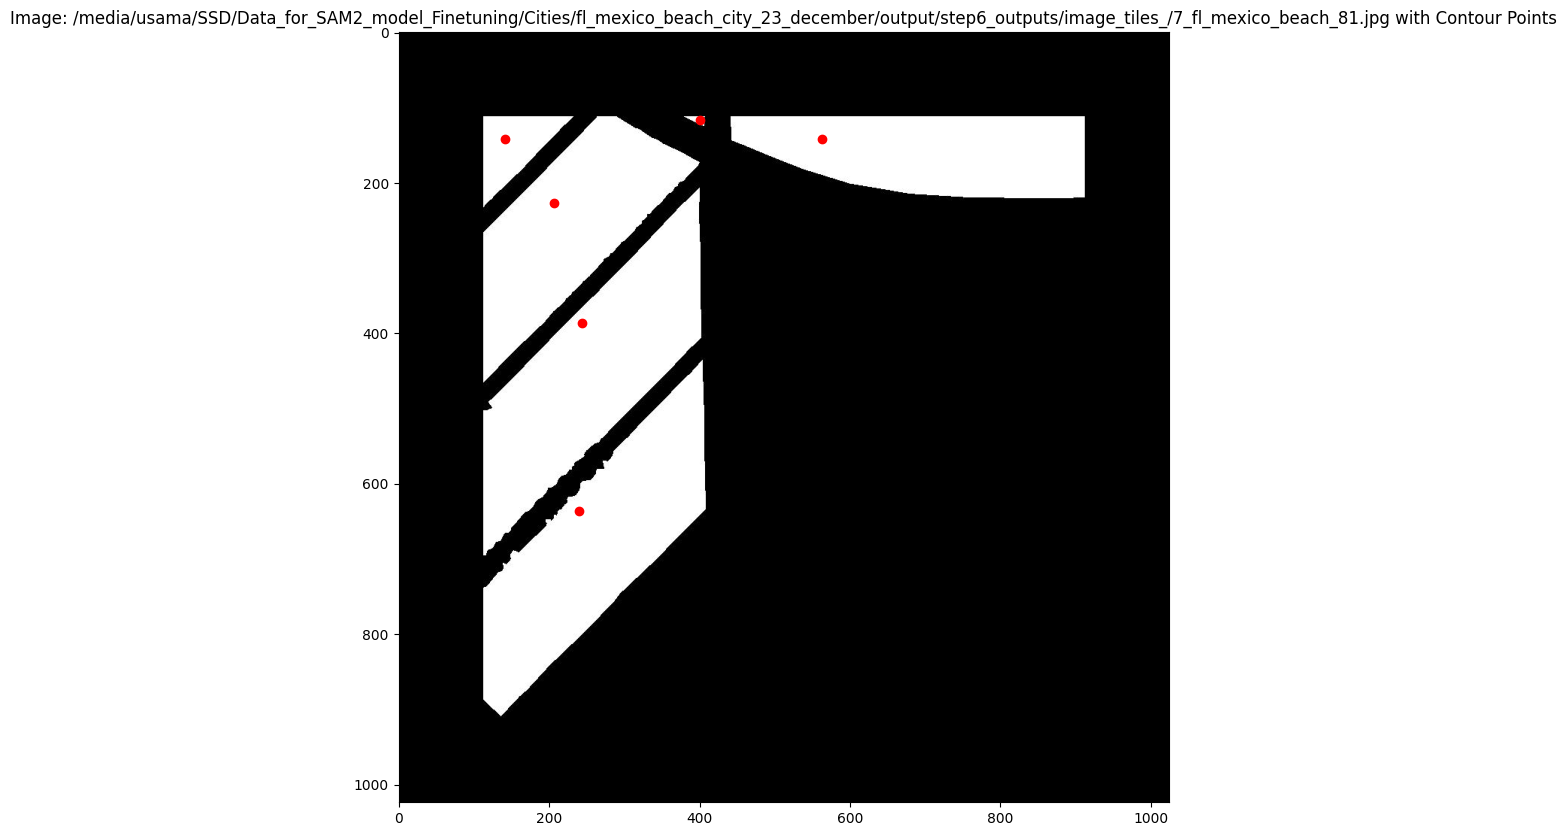

scale 1.0
points [[(137.75, 140.75), (180.25, 133.0), (137.75, 190.25), (180.75, 189.75)]]
copy image path test_data_sam2_24_22_december/images/7_fl_mexico_beach_82_copy0.jpg
point pairs [(137, 140)]


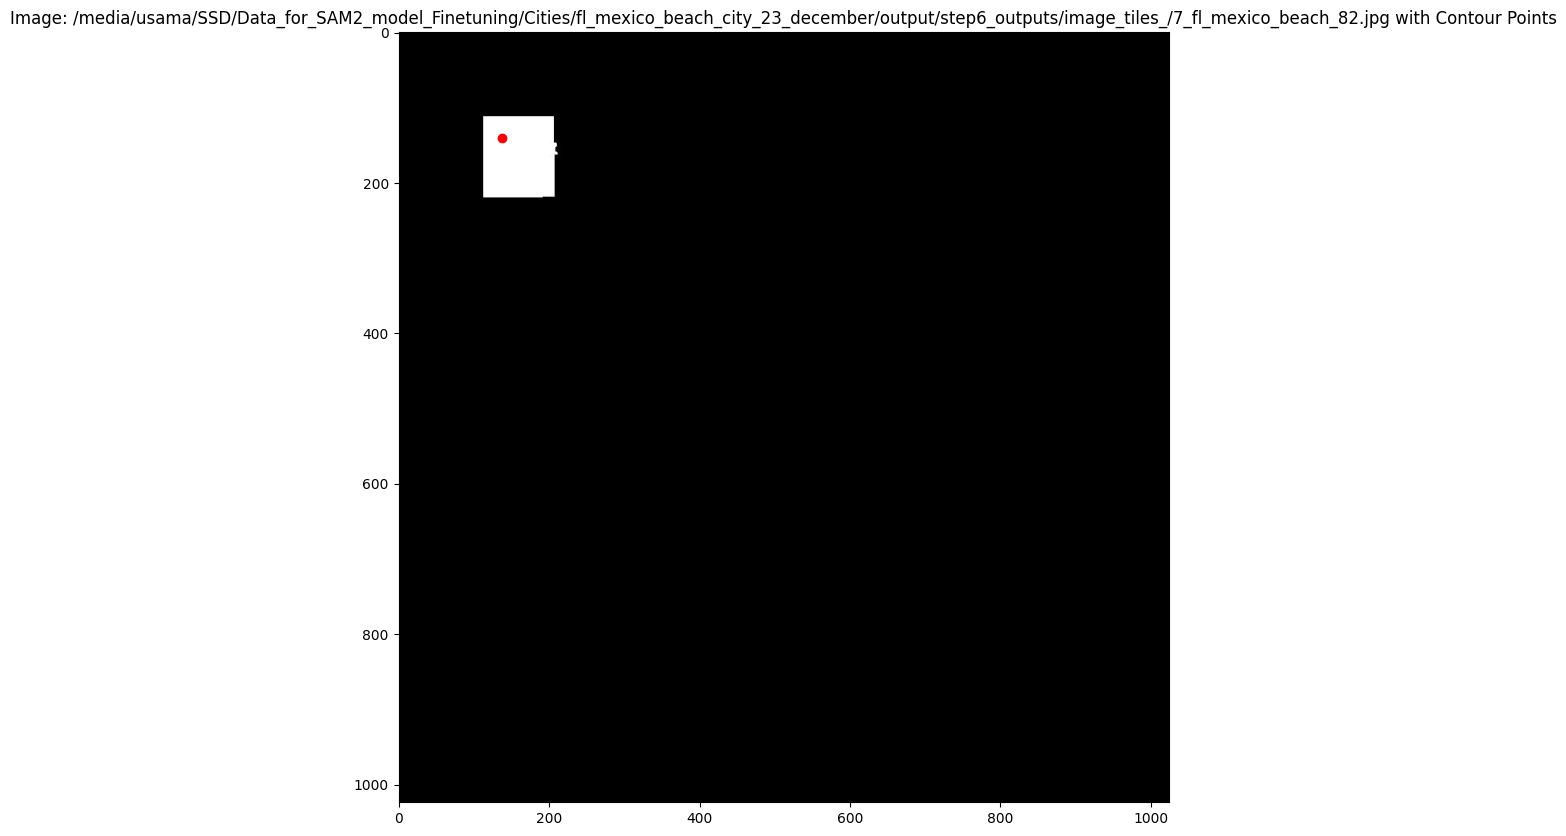

scale 1.0
representative point after area is less than 200 [[(895.5, 901.5)]]
points [[(895.5, 901.5)], [(720.5, 772.5), (783.0, 799.5), (758.75, 839.0), (817.5, 862.5)], [(539.0, 606.0), (601.0, 634.0), (578.0, 672.0), (638.0, 698.5)], [(358.5, 438.5), (419.0, 468.0), (399.25, 509.5), (461.0, 536.0)], [(177.0, 277.5), (236.25, 306.5), (220.25, 340.5), (283.0, 369.0)], [(868.0, 120.5), (893.25, 127.5), (877.5, 136.5), (889.0, 142.75)]]
copy image path test_data_sam2_24_22_december/images/7_fl_mexico_beach_94_copy0.jpg
point pairs [(895, 901), (720, 772), (539, 606), (358, 438), (177, 277), (868, 120)]


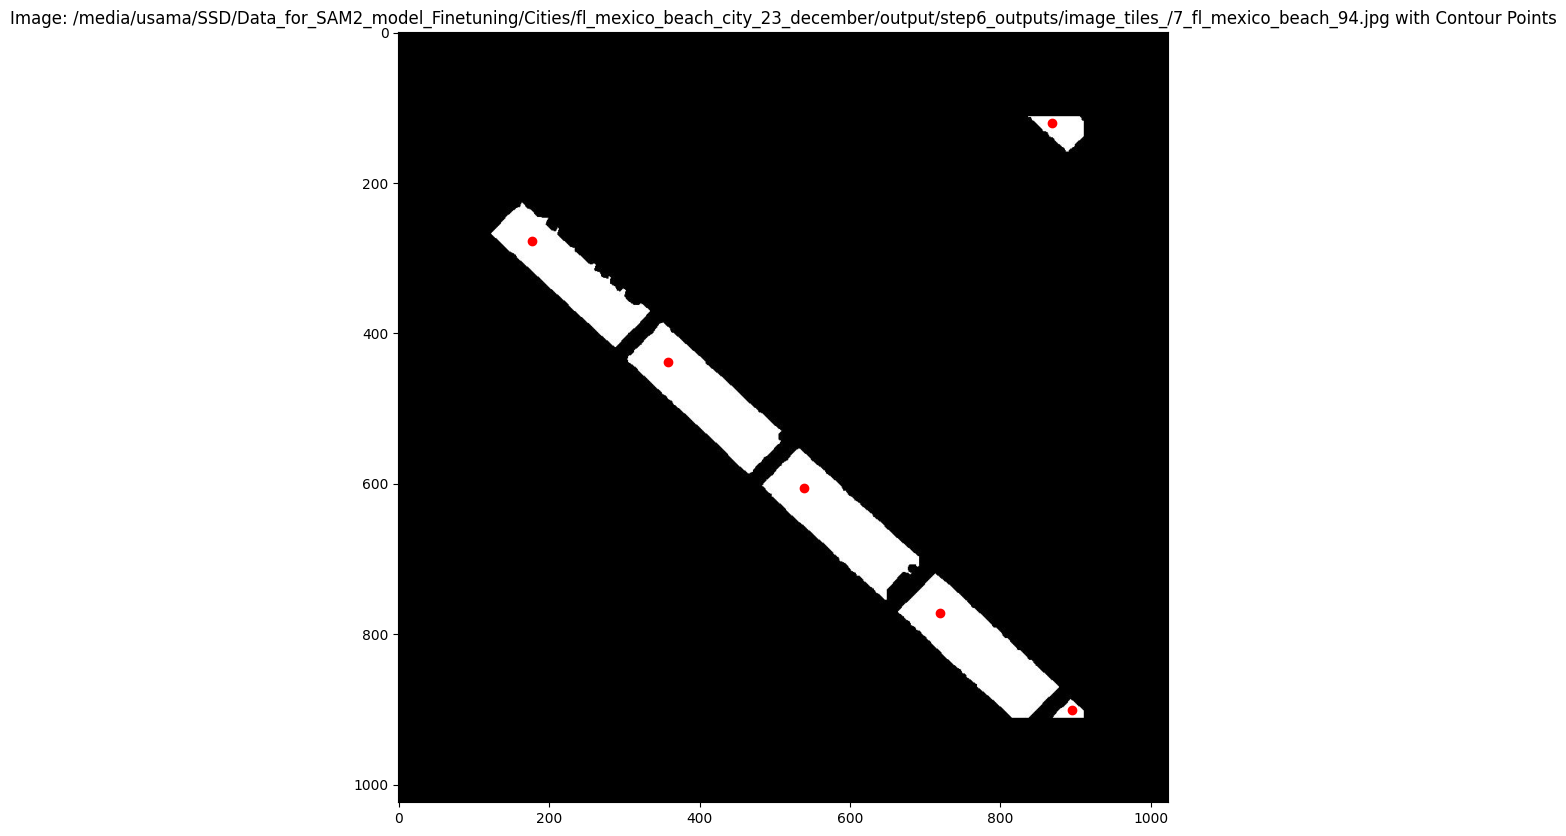

scale 1.0
representative point after area is less than 200 [[(115.0, 908.0)]]
representative point after area is less than 200 [[(115.0, 908.0)], [(564.5, 879.25), (795.5, 879.25), (564.5, 899.25), (795.5, 899.25)], [(116.5, 127.5)]]
points [[(115.0, 908.0)], [(564.5, 879.25), (795.5, 879.25), (564.5, 899.25), (795.5, 899.25)], [(116.5, 127.5)]]
copy image path test_data_sam2_24_22_december/images/7_fl_mexico_beach_95_copy0.jpg
point pairs [(115, 908), (564, 879), (116, 127)]


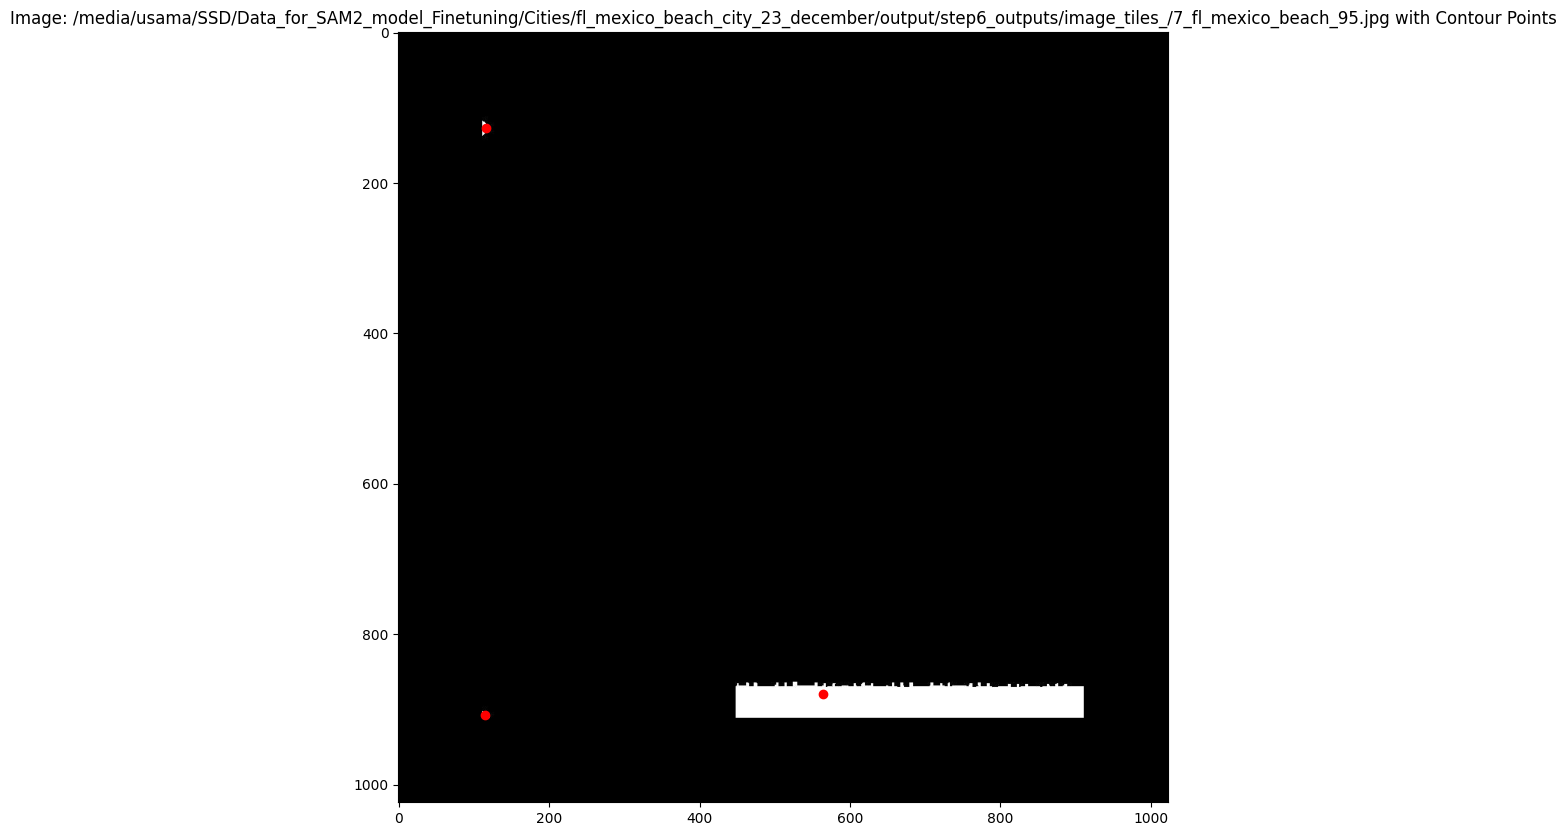

scale 1.0
points [[(143.25, 882.75), (196.75, 883.75), (143.25, 898.75), (196.75, 897.75)]]
copy image path test_data_sam2_24_22_december/images/7_fl_mexico_beach_96_copy0.jpg
point pairs [(143, 882)]


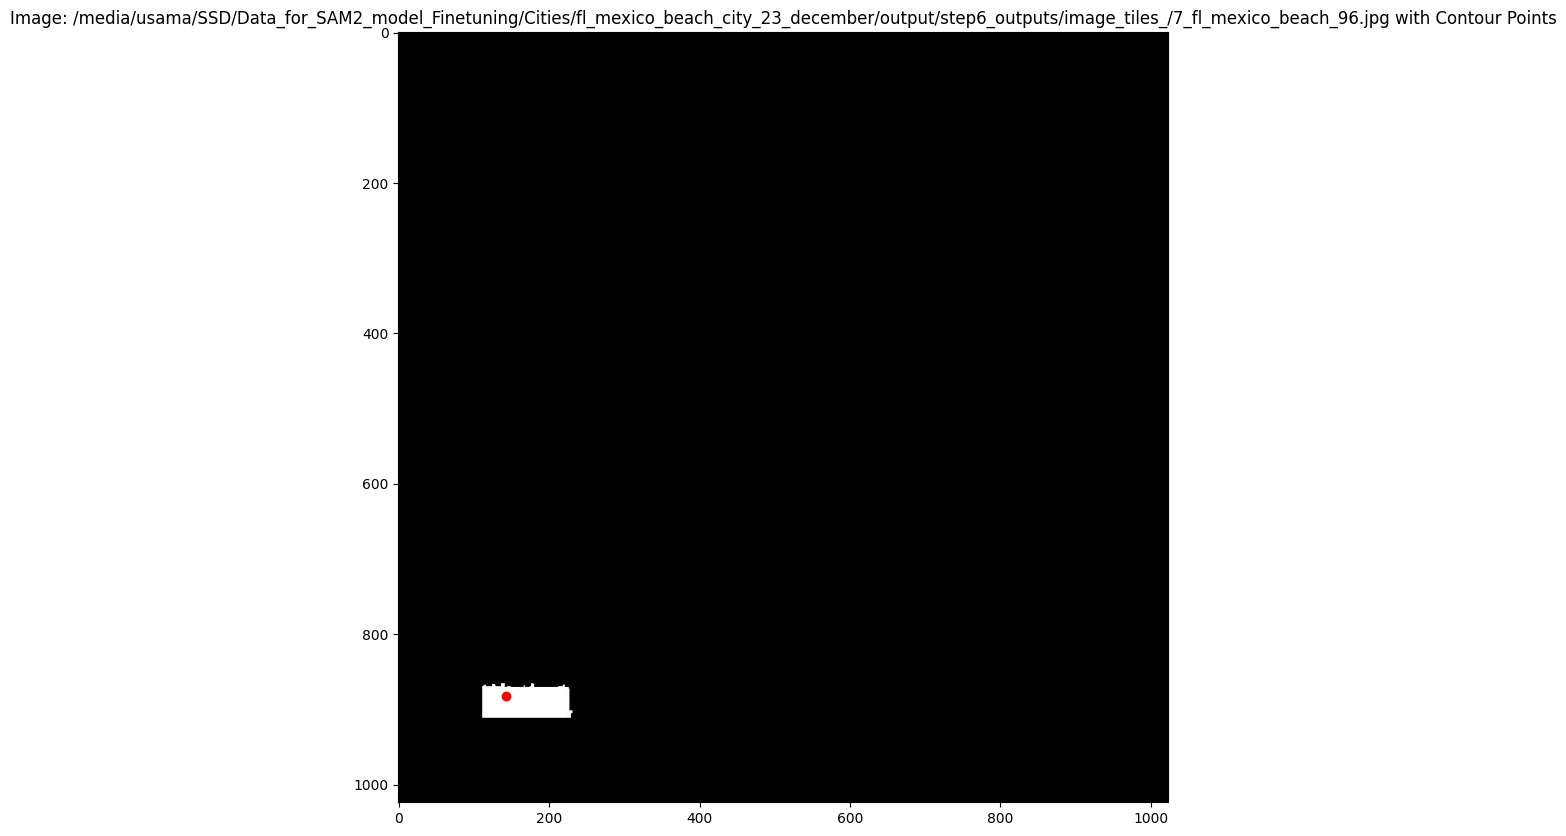

scale 1.0
points [[(684.0, 894.5), (690.5, 896.0), (680.5, 902.0), (695.75, 902.5)], [(592.75, 850.5), (620.5, 857.0), (594.25, 886.5), (626.75, 888.5)], [(494.5, 777.5), (506.0, 780.0), (496.5, 793.0), (508.5, 795.5)], [(401.5, 740.5), (432.0, 742.0), (393.25, 792.5), (425.5, 793.5)], [(317.75, 717.0), (353.75, 703.5), (299.5, 754.5), (330.25, 755.5)]]
copy image path test_data_sam2_24_22_december/images/8_fl_mexico_beach_33_copy0.jpg
point pairs [(684, 894), (592, 850), (494, 777), (401, 740), (317, 717)]


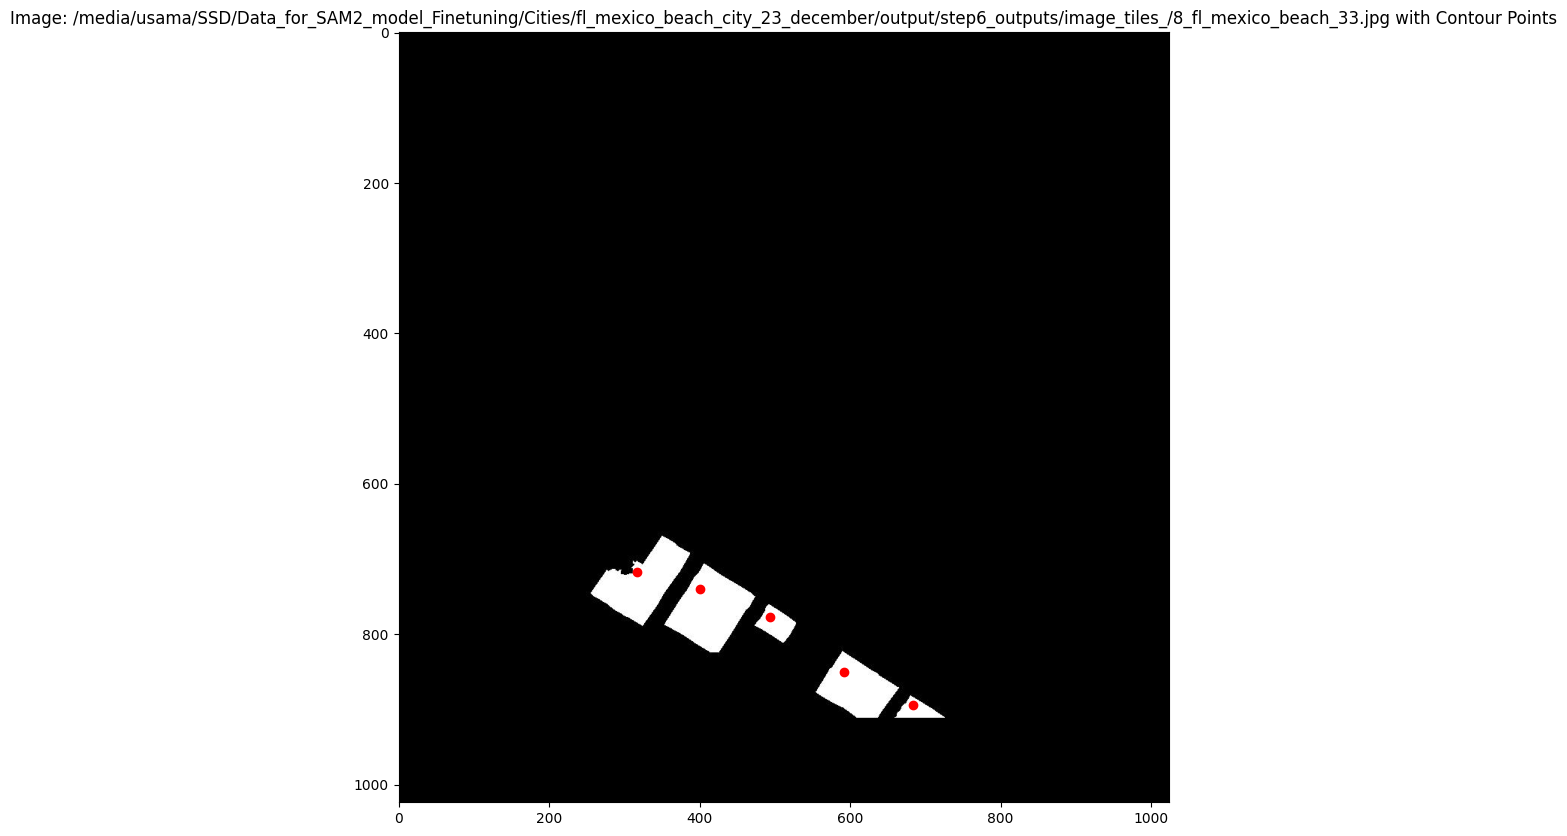

scale 1.0
points [[(578.75, 361.0), (598.0, 353.5), (567.25, 393.0), (586.75, 386.5)], [(882.0, 245.5), (896.25, 246.75), (875.5, 268.5), (896.25, 268.75)], [(804.0, 169.5), (827.5, 189.5), (810.25, 217.5), (829.25, 221.5)], [(673.25, 137.0), (726.25, 136.0), (685.75, 172.0), (715.25, 177.5)], [625.25, 117.5]]
copy image path test_data_sam2_24_22_december/images/8_fl_mexico_beach_47_copy0.jpg
point pairs [(578, 361), (882, 245), (804, 169), (673, 137), (625, 117)]


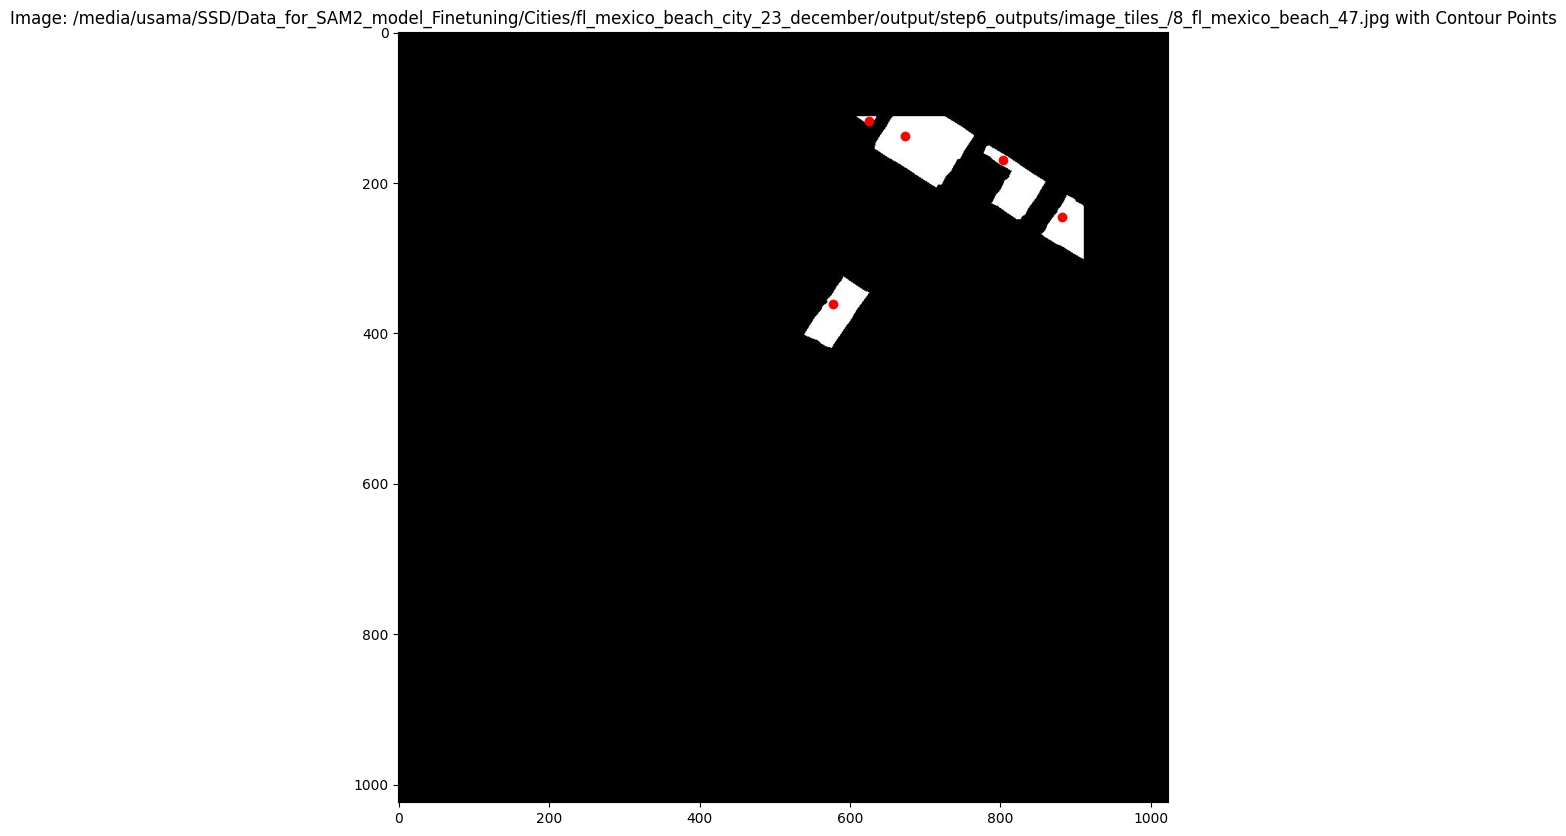

scale 1.0
representative point after area is less than 200 [[(906.75, 902.5)]]
representative point after area is less than 200 [[(906.75, 902.5)], [(876.0, 768.5), (894.0, 775.5), (879.5, 792.5), (898.625, 802.25)], [(907.25, 717.5)]]
points [[(906.75, 902.5)], [(876.0, 768.5), (894.0, 775.5), (879.5, 792.5), (898.625, 802.25)], [(907.25, 717.5)], [(792.0, 702.0), (813.5, 711.0), (802.5, 728.0), (829.5, 739.0)], [(694.125, 633.25), (724.5, 644.5), (710.0, 662.5), (739.75, 672.0)], [(606.25, 567.5), (633.25, 577.5), (618.25, 595.5), (646.75, 602.5)], [(855.0, 606.5), (889.5, 583.0), (840.5, 656.0), (886.5, 646.75)], [(488.5, 489.5), (524.75, 503.0), (511.75, 521.5), (549.5, 534.0)], [(384.5, 422.5), (415.0, 432.5), (403.5, 450.5), (433.625, 458.25)], [(287.75, 360.0), (316.0, 368.5), (302.25, 386.0), (330.5, 396.0)], [(192.0, 296.0), (219.5, 305.0), (209.25, 320.5), (237.5, 329.5)], [(125.0, 261.0), (149.25, 262.5), (125.0, 287.0), (143.5, 289.5)]]
copy image path test_data_sam2_24_22_

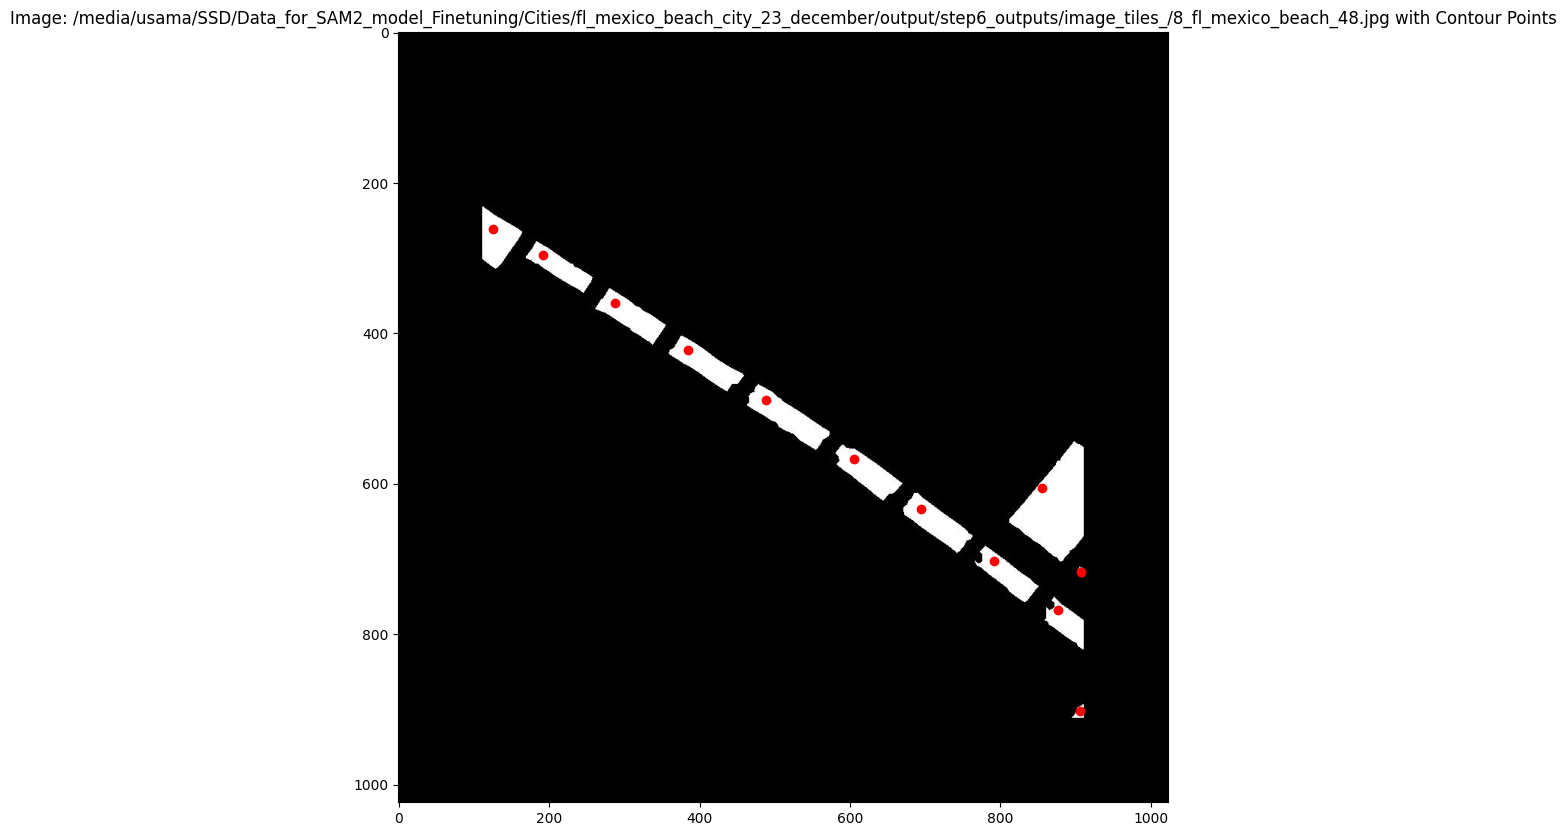

scale 1.0
representative point after area is less than 200 [[(380.0, 910.5)]]
representative point after area is less than 200 [[(380.0, 910.5)], [(398.0, 906.0)]]
points [[(380.0, 910.5)], [(398.0, 906.0)], [(255.375, 899.75), (260.25, 901.0), (252.5, 907.5), (263.75, 907.5)], [(309.75, 854.0), (335.0, 861.5), (318.5, 883.5), (344.5, 892.5)], [(156.25, 848.5), (182.75, 848.5), (141.5, 888.0), (194.0, 890.0)], [(119.25, 800.25), (131.25, 801.0), (119.25, 813.75), (130.75, 814.0)], [(221.0, 784.5), (247.75, 794.5), (234.0, 817.0), (257.5, 824.0)], [(132.5, 720.0), (160.0, 726.0), (145.5, 745.0), (171.0, 753.5)], [(126.5, 594.0), (153.5, 594.0), (123.5, 639.5), (146.75, 620.5)]]
copy image path test_data_sam2_24_22_december/images/8_fl_mexico_beach_49_copy0.jpg
point pairs [(380, 910), (398, 906), (255, 899), (309, 854), (156, 848), (119, 800), (221, 784), (132, 720), (126, 594)]


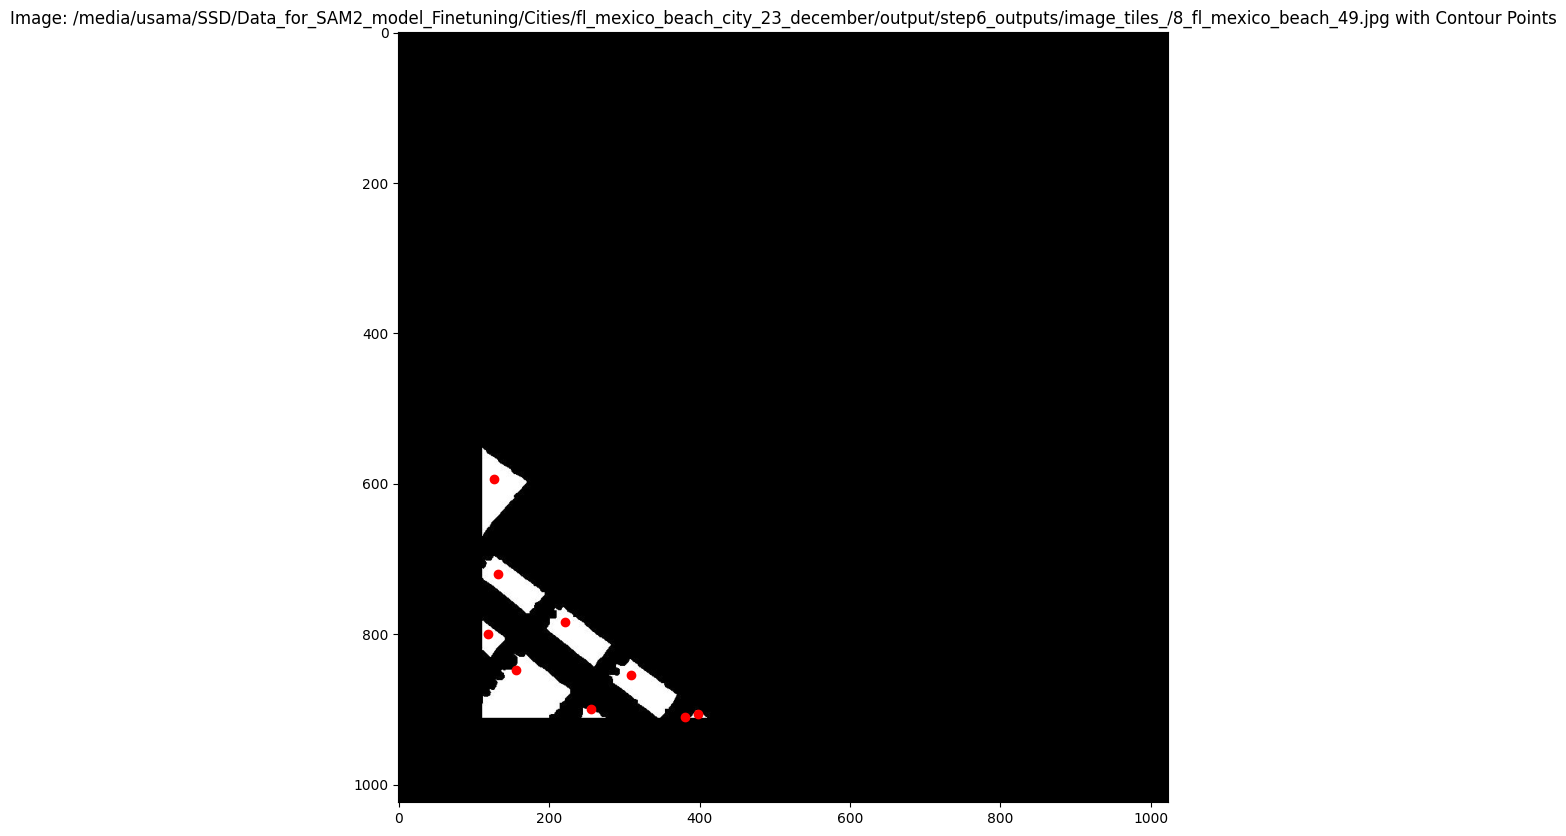

scale 1.0
points [[(870.25, 148.0), (893.625, 135.75), (868.75, 168.0), (892.75, 167.0)]]
copy image path test_data_sam2_24_22_december/images/8_fl_mexico_beach_62_copy0.jpg
point pairs [(870, 148)]


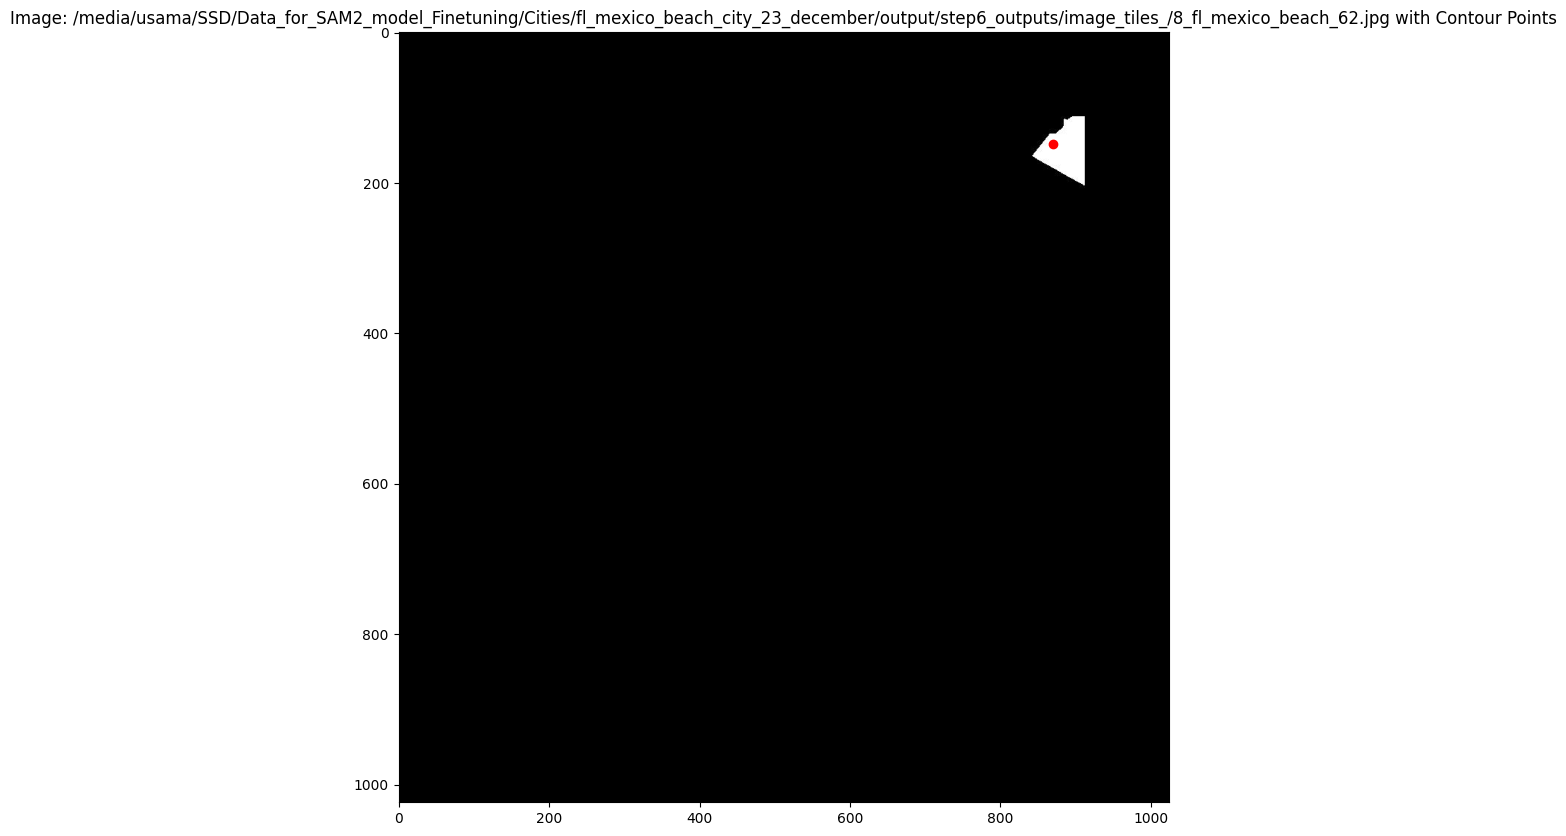

scale 1.0
representative point after area is less than 200 [[(410.0, 244.5), (423.5, 241.5), (405.25, 261.5), (416.5, 258.0)], [(502.5, 186.5)]]
Error creating polygon: A linearring requires at least 4 coordinates.
points [[(410.0, 244.5), (423.5, 241.5), (405.25, 261.5), (416.5, 258.0)], [(502.5, 186.5)], [(342.75, 184.5), (365.75, 191.5), (355.25, 213.5), (374.5, 218.5)], [(423.0, 161.5), (489.0, 221.5), (544.5, 261.0)], [(257.25, 126.0), (282.5, 125.5), (271.25, 148.0), (294.0, 154.5)], [(134.0, 136.25), (165.25, 137.5), (124.5, 185.0), (156.5, 163.75)]]
copy image path test_data_sam2_24_22_december/images/8_fl_mexico_beach_63_copy0.jpg
point pairs [(410, 244), (502, 186), (342, 184), (423, 161), (257, 126), (134, 136)]


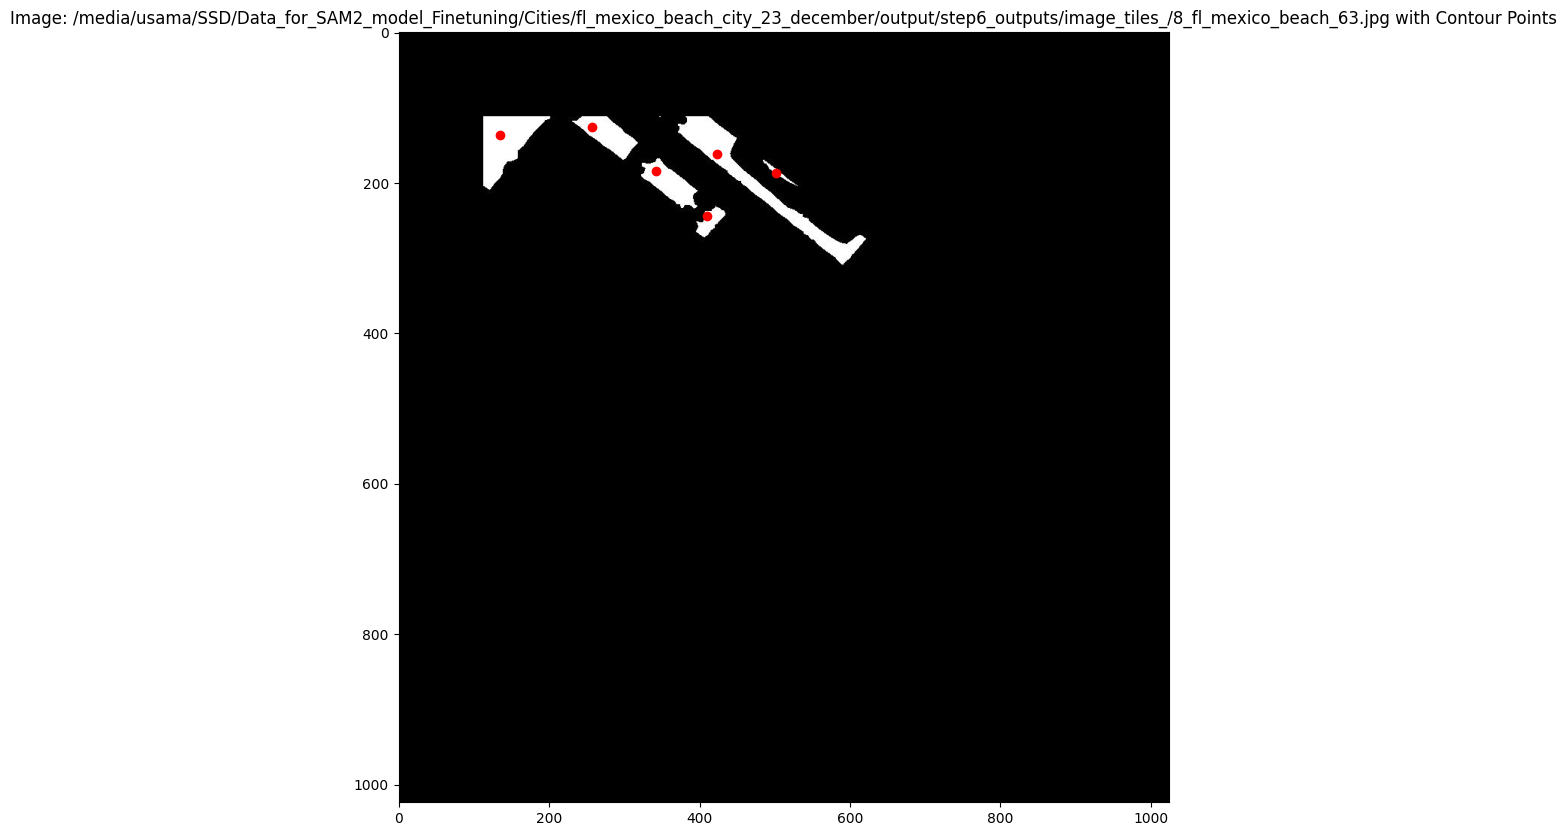

scale 1.0
representative point after area is less than 200 [[(903.25, 479.5)]]
points [[(903.25, 479.5)], [(830.25, 410.5), (855.75, 417.5), (844.25, 436.5), (866.75, 444.5)], [(741.75, 339.75), (766.25, 349.0), (756.75, 370.0), (779.5, 373.5)]]
copy image path test_data_sam2_24_22_december/images/8_fl_mexico_beach_78_copy0.jpg
point pairs [(903, 479), (830, 410), (741, 339)]


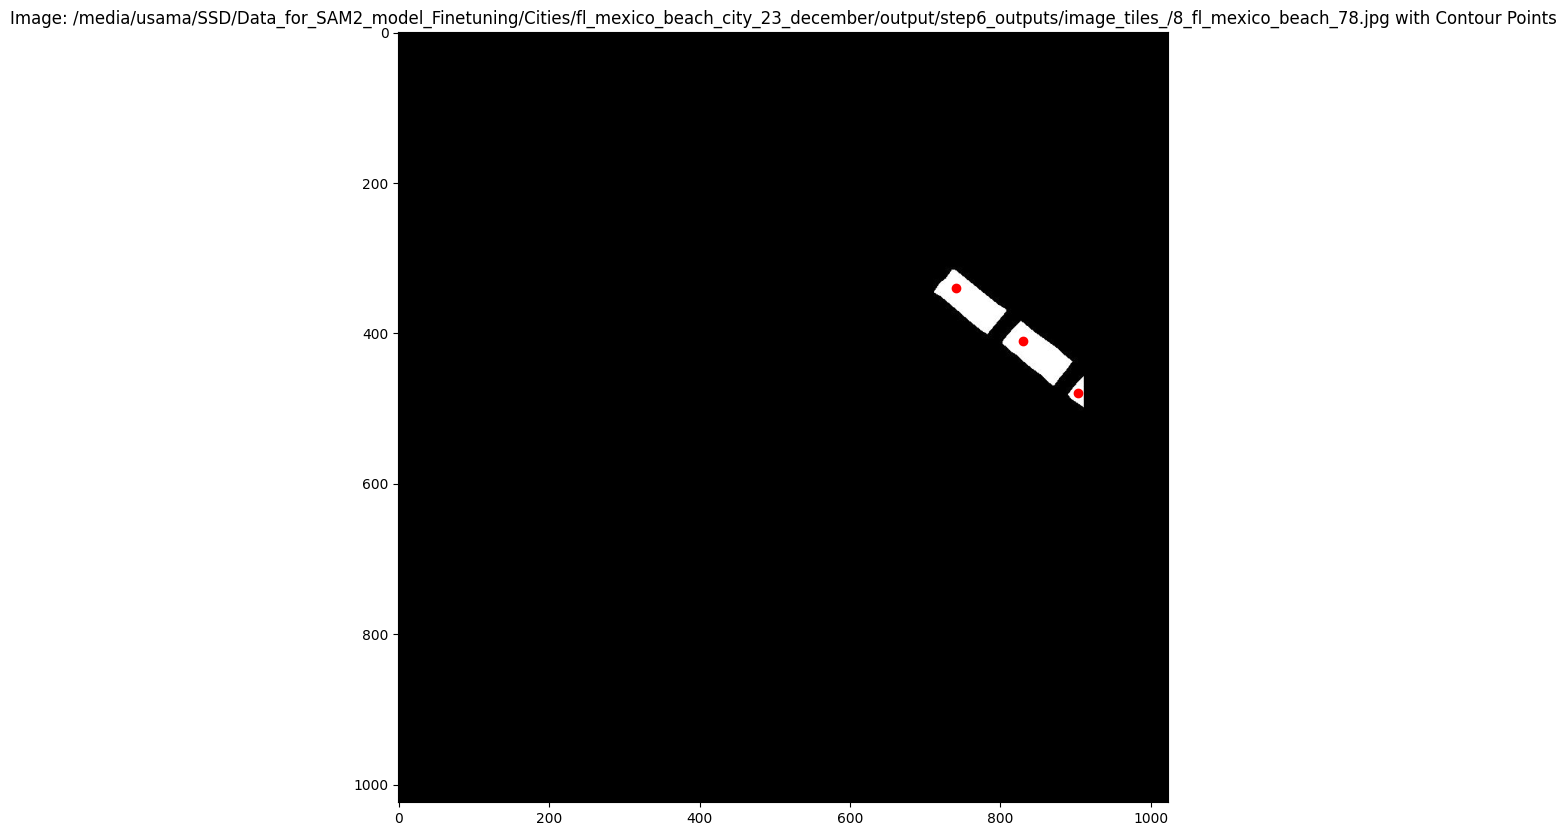

scale 1.0
points [[(583.25, 846.5), (618.75, 863.5), (607.75, 881.5), (632.0, 887.5)], [(483.25, 761.5), (511.25, 775.5), (490.5, 805.0), (522.0, 809.5)], [(389.0, 682.0), (413.25, 692.5), (402.0, 704.0), (426.5, 714.5)], [(298.0, 611.0), (324.5, 622.0), (315.25, 636.5), (339.5, 644.5)], [(209.0, 544.5), (232.5, 553.5), (223.0, 576.5), (245.375, 580.75)], [(127.75, 477.5), (150.75, 488.5), (136.25, 503.5), (159.25, 514.5)]]
copy image path test_data_sam2_24_22_december/images/8_fl_mexico_beach_79_copy0.jpg
point pairs [(583, 846), (483, 761), (389, 682), (298, 611), (209, 544), (127, 477)]


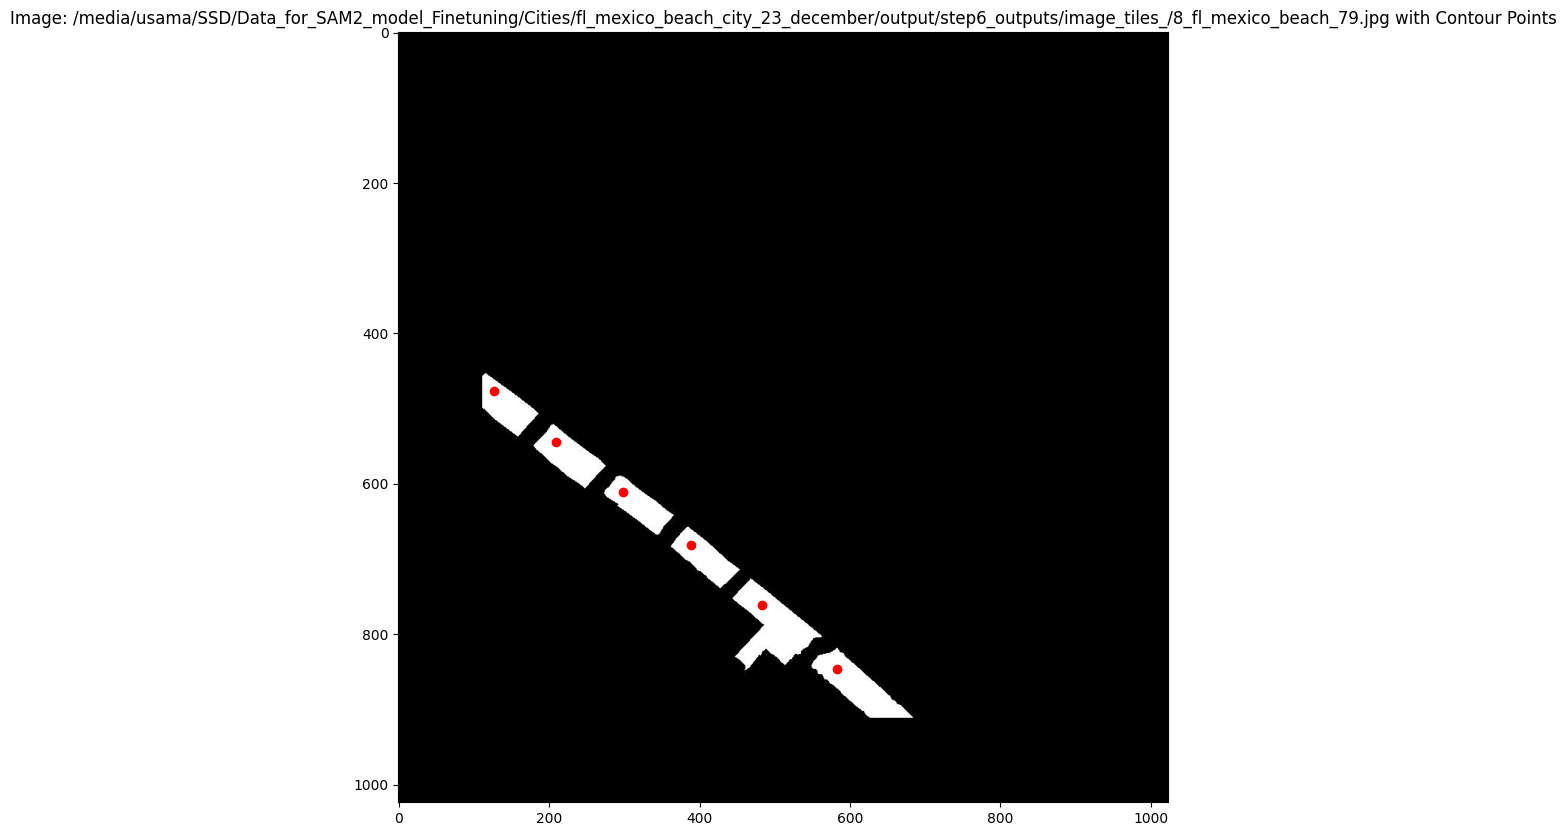

scale 1.0
points [[(658.5, 122.5), (681.25, 126.0), (667.5, 138.5), (678.875, 142.75)]]
copy image path test_data_sam2_24_22_december/images/8_fl_mexico_beach_93_copy0.jpg
point pairs [(658, 122)]


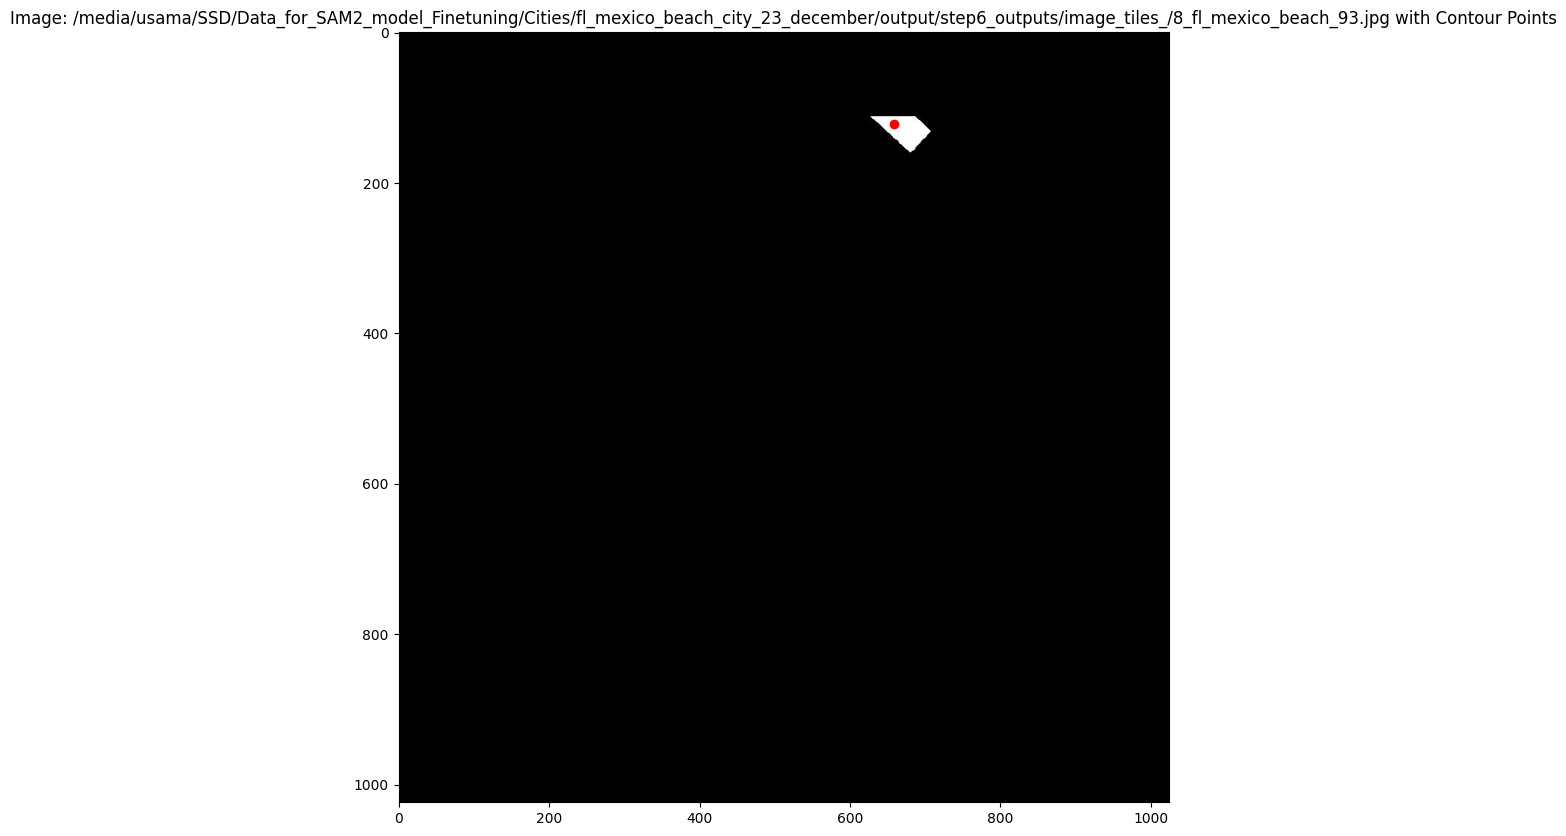

scale 1.0
points [[(760.0, 669.5), (819.75, 665.5), (744.0, 758.0), (794.0, 748.5)]]
copy image path test_data_sam2_24_22_december/images/9_fl_mexico_beach_79_copy0.jpg
point pairs [(760, 669)]


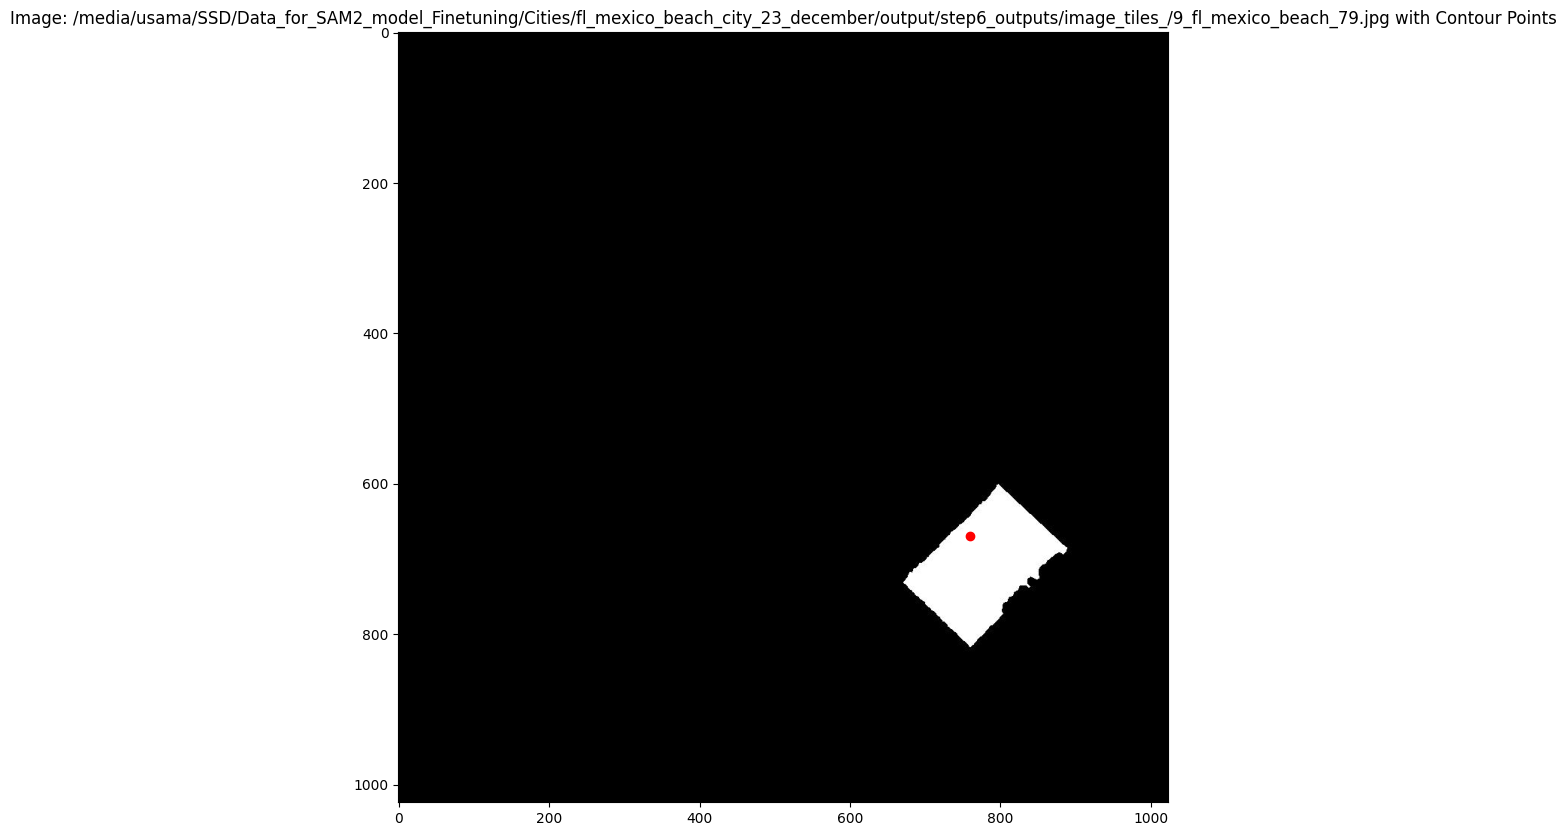

scale 1.0
points [[(547.0, 740.0), (624.25, 791.5), (614.0, 816.0), (669.0, 850.5)]]
copy image path test_data_sam2_24_22_december/images/9_fl_mexico_beach_80_copy0.jpg
point pairs [(547, 740)]


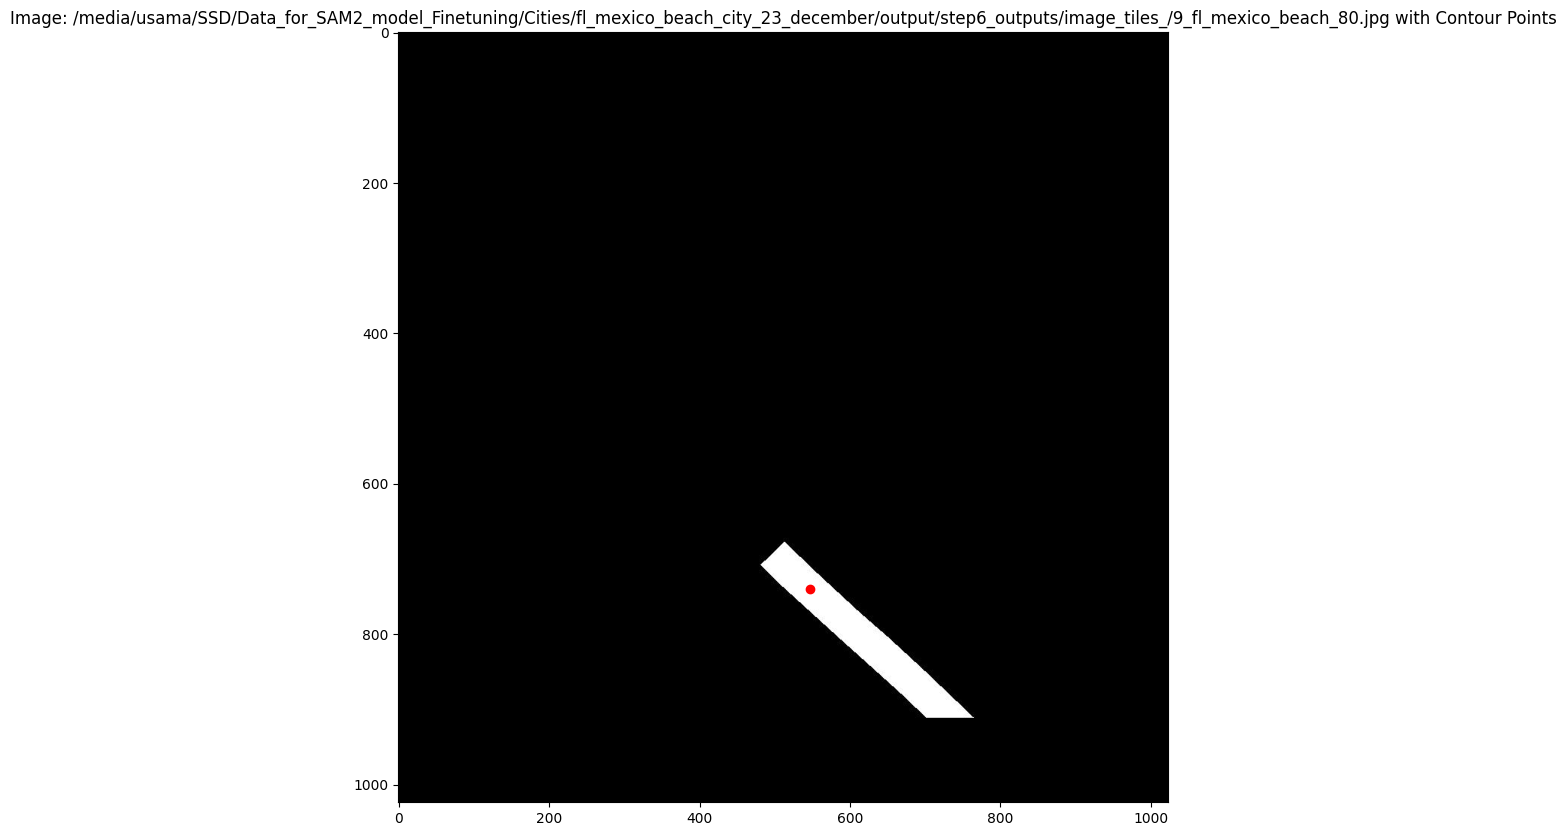

scale 1.0
points [[(763.25, 142.5), (792.25, 151.5), (779.25, 172.5), (821.0, 191.5)]]
copy image path test_data_sam2_24_22_december/images/9_fl_mexico_beach_94_copy0.jpg
point pairs [(763, 142)]


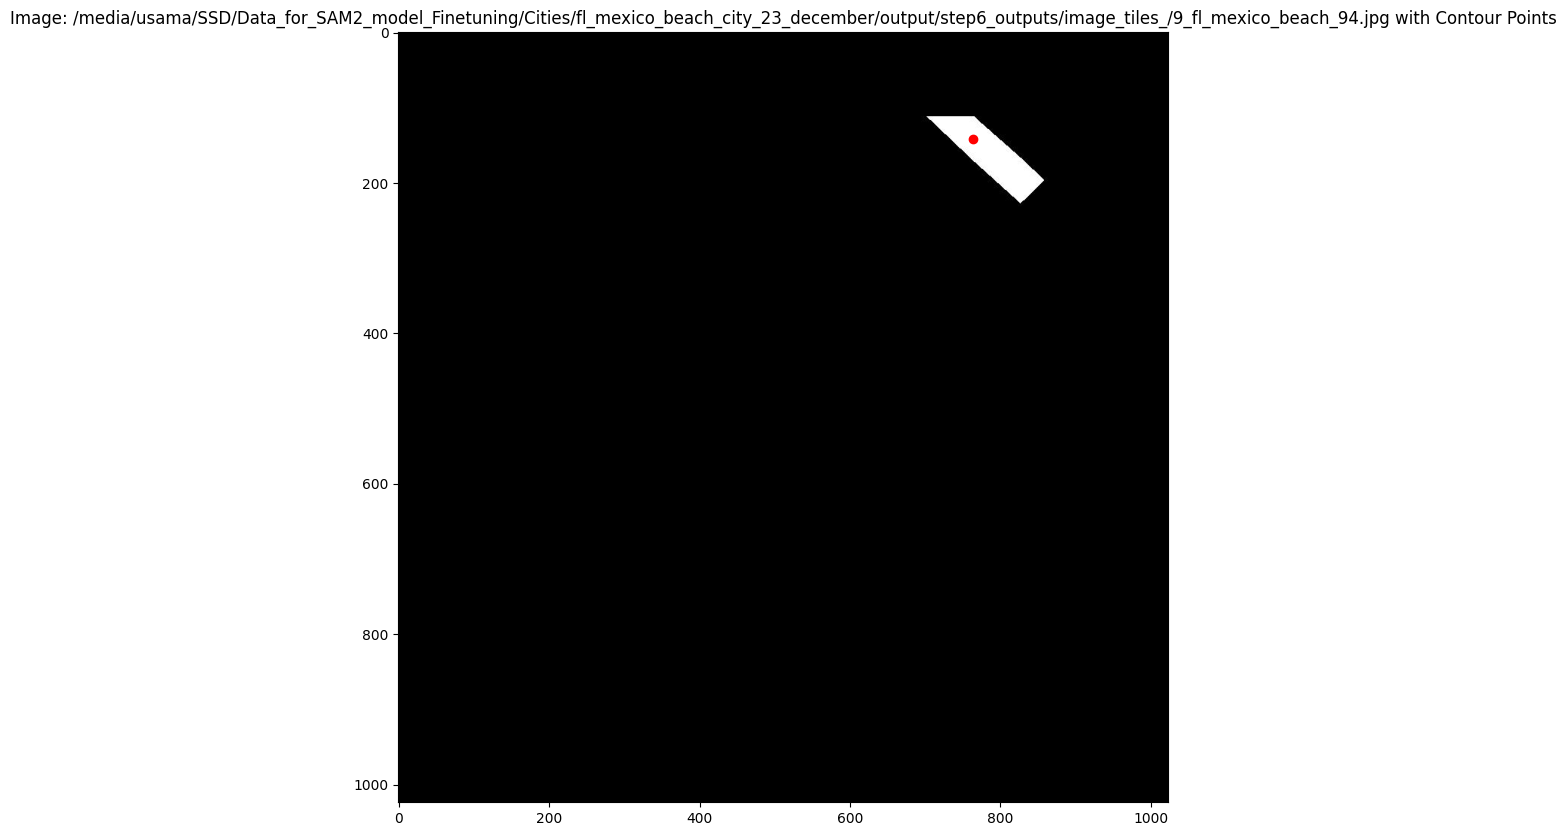

104


In [25]:

def read_batch(data, visualize_data=False):
    output_base_dir = "test_data_sam2_24_22_december/"
    images_dir = os.path.join(output_base_dir, "images")
    masks_dir = os.path.join(output_base_dir, "masks")
    txt_files_dir = os.path.join(output_base_dir, "txt_files")
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(masks_dir, exist_ok=True)
    os.makedirs(txt_files_dir, exist_ok=True)
    results = []

    for ent in data:
        image = cv2.imread(ent["image"])[..., ::-1]
        ann_map = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE)

        if image is None or ann_map is None:
            print(f"Error: Could not read image or mask from path {ent['image']} or {ent['annotation']}")
            continue

        scale = min(1024 / image.shape[1], 1024 / image.shape[0])
        print("scale",scale)
        image = cv2.resize(image, (int(image.shape[1] * scale), int(image.shape[0] * scale)))
#         ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * scale), int(ann_map.shape[0] * scale)), interpolation=cv2.INTER_NEAREST)
        ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * scale), int(ann_map.shape[0] * scale)))
        _, binary_mask = cv2.threshold(ann_map, 127, 255, cv2.THRESH_BINARY)
        contours_1, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # contours_1_blank_image = np.zeros(image.shape[:2],dtype=np.uint8)
#         print("Contours length before erosion:", len(contours_1))
        eroded_mask = cv2.erode(ann_map, np.ones((5, 5), np.uint8), iterations=2)
        _, binary_mask_eroded = cv2.threshold(eroded_mask, 127, 255, cv2.THRESH_BINARY)
        contours_2, _ = cv2.findContours(binary_mask_eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # contours_2_blank_image = np.zeros(image.shape[:2],dtype=np.uint8)
#         print("Contours length after erosion:", len(contours_2))
        final_mask = cv2.erode(ann_map, np.ones((5, 5), np.uint8), iterations=2) if len(contours_2) >= len(contours_1) else ann_map
#         for i in range(1, 2):
       
        _, binary_mask_final = cv2.threshold(final_mask, 100, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(binary_mask_final, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#         cv2.drawContours(image, contours, -1, (255, 255, 255), 10)  # Green color, thickness of 2
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
        # Get representative points with intersection logic
        rep_points = get_representative_points_within_contours(contours, contours_1,ann_map)
        print("points",rep_points)
#             print("length of points",len(points))
#             print("points",points)
        
        ct = 0
        if len(rep_points)!=0:      # To tackle the empty list
        # if points is not None:  
            for rep_points_item in rep_points:
                if len(rep_points_item)>=1:   # To check weather each elements contains points that is either equal to 3 or greater
                    ct+=1                  # here the aim is to remove those polygons that contains only 1 point or 2 points
            if ct==len(rep_points):   
                pts_ = rep_points
            else:
                continue
            for i in range(1):
                image_path = ent["image"]
                mask_path = ent["annotation"]
                image = cv2.imread(image_path)
                mask = cv2.imread(mask_path)
                copy_image_name  = f"{os.path.basename(ent['image']).split('.')[0]}_copy{i}.jpg"
                copy_mask_name  = f"{os.path.basename(ent['annotation']).split('.')[0]}_copy{i}.jpg"
            
                copy_image_path = os.path.join(images_dir, copy_image_name)
                print("copy image path",copy_image_path)
                cv2.imwrite(copy_image_path,image)
              

                copy_mask_path = os.path.join(masks_dir, copy_mask_name)
                cv2.imwrite(copy_mask_path,mask)
                
                txt_file_name = f'{copy_image_name.split(".")[0]}.txt'
                copy_txt_path = os.path.join(txt_files_dir, txt_file_name)
                
                points_pair = []
                for pt_element in pts_:
                    # Get the i-th point from each element and convert to integer
#                     pt_ = tuple(map(int, pt_element[i]))  # Convert to integer
                    if isinstance(pt_element[i], (int, float, np.float64)):
                        pt_ = (int(pt_element[i]),int(pt_element[1]))  # Convert to a single-element tuple
                    else:
                        pt_ = tuple(map(int, pt_element[i]))  # If iterable, process as before
                    points_pair.append(pt_)
                    with open(copy_txt_path, 'w') as file:
                        # for point in points:
                        for (cX, cY) in points_pair:
                            file.write(f'{cX}, {cY}\n')
                print("point pairs",points_pair)
                if visualize_data:
                    plt.figure(figsize=(10, 10))
                    plt.imshow(ann_map, cmap='gray')
                    for (cX, cY) in points_pair:
                        plt.plot(cX, cY, 'ro')
                    plt.title(f"Image: {ent['image']} with Contour Points")
                    plt.show()


                results.append({
                "image": ent["image"],
                "annotation": ent["annotation"],
                "txt_file": copy_txt_path,
                "points": points_pair
                    


        })
                

    return results

# sk_tiles_/186_tx_willis_147.jpg', 'annotation': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/tx_willis_city/output/step6_outputs/mask_tiles_/186_tx_willis_147.jpg'}]
# train_data =   [{'image': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/ca_millbrae_city/output/step6_outputs/image_tiles_/10_ca_millbrae_156.jpg', 'annotation': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/ca_millbrae_city/output/step6_outputs/mask_tiles_/10_ca_millbrae_156.jpg'}]
# es_and_mask_tiles_for_Fl_indialantic_city/image_tiles_/0_indialantic_77.jpg', 'annotation': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/fl_indialantic_city/output/image_tiles_and_mask_tiles_for_Fl_indialantic_city/mask_tiles_/0_indialantic_77.jpg'}]
# train_data =   [{'image': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/ca_millbrae_city/output/step6_outputs/image_tiles_/10_ca_millbrae_177.jpg', 'annotation': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/ca_millbrae_city/output/step6_outputs/mask_tiles_/10_ca_millbrae_177.jpg'}]
# train_data =   [{'image': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/Training_data_for_sam2_/Zone_data_19_december_2024_for_sam2/image_tiles_/10_brisbane_old_73.jpg', 'annotation': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/Training_data_for_sam2_/Zone_data_19_december_2024_for_sam2/mask_tiles_/10_brisbane_old_73.jpg'}]
results = read_batch(all_pairs, visualize_data=True)
print(len(results))

points [(406.75, 433.0), (706.0, 459.5), (525.25, 755.75), (704.5, 755.5)]
copy image path test_data_sam2_16_december/images/10_brisbane_old_73_copy0.jpg


TypeError: 'numpy.float64' object is not iterable